# Shallow Water

The shallow-water equations, derived from the general Navier-Stokes equations, present a suitable framework for modelling free-surface flow problems. In 2D, these come in the form of the following system of hyperbolic PDEs,

$$
\begin{align*}
∂_t h + ∂_x hu + ∂_y hv = 0 \\
∂_t hu + ∂_x \left( u^2 h + \frac{1}{2} g_r h^2 \right)  = −g_r h ∂_x b \\
∂_t hu + ∂_y \left( v^2 h + \frac{1}{2} g_r h^2 \right)  = −g_r h ∂_y b \\
\end{align*}
$$

with u, v being the velocities in horizontal and vertical direction, h describing the water depth and b describing a spatially varying bathymetry. hu, hv can be interpreted as the directional momentum components and gr describes the gravitational acceleration.

The initial condition for the system is defined as follows:

$$
h(t=0,x,y) = 
\begin{cases} 
      2.0,& for \;\; r< \sqrt{x^2+y^2}\\
      1.0,& for \;\; r ≥ \sqrt{x^2 +y^2} \\
\end{cases}
$$

To obtain a numerical solution, a finite volume solver (PyClaw) was employed. The dataset used for this purpose was downloaded from [PDEBench](https://github.com/pdebench/PDEBench). However, it is important to note that some noise was intentionally added to the original dataset.

In [5]:
import matplotlib.pyplot as plt
import sys
import pathlib
sys.path.append(str(pathlib.Path('/Users/properallan/Documents/github/simulai').resolve()))
from examples.utils.plot import anim_2D
from IPython.display import HTML
import pickle

with open('shallow_water_data', 'rb') as handle:
    shallow_water_data = pickle.load(handle)


data       = shallow_water_data['data']
data_x     = shallow_water_data['data_x']
data_y     = shallow_water_data['data_y']
time       = shallow_water_data['time']

from sklearn.metrics import mean_squared_error

def add_noise(data, noise_level=0.0):
    original_shape = data.shape
    data_flattened = data.reshape((data.shape[0], -1))
    rmse = mean_squared_error(data_flattened, np.zeros((data_flattened).shape), squared=False)
    noisy_data = data_flattened + np.random.normal(0, rmse * noise_level , data_flattened.shape) 
    return noisy_data.reshape(original_shape)

gtdata = np.copy(data)
data = add_noise(data, noise_level=0.05)

anim = anim_2D(
    # data is a list of data arrays to animate in (T, N, M) format
    data = [ data ],#, np.sum(PHI, axis=1) ], 
    # title is a list of titles for each data array
    title = [ 'Shallow Water'],#,  'ALL_SOURCES'],
    # force number os columns (leav it None to a single row plot)
    n_columns = 1, 
)

HTML(anim.to_html5_video())

# Order Reduction

Given the spatio-temporal domain with dimensions of $[101 \times 128 \times 120]$, we employ a projection technique to reduce the order of the data using Proper Orthogonal Decomposition (POD) modes. Prior to the projection, the data is normalized to fit within the range of $(-1,1)$. In order to accommodate the limited amount of data available, the full dataset is split into separate training and test portions. Additionally, due to the scarcity of data, the training dataset is also utilized for validation purposes.

In [2]:
from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline
from simulai.normalization import UnitaryNormalization


n_components = 10

rom_config = {
               'n_components': n_components,
               'eig_norm' : True
              }

# Instantiating the class Pipeline
pipeline = Pipeline(stages=[
    ('data_preparer', Reshaper()),
    ('normalization', UnitaryNormalization(-1,1)),
    ('rom', POD(config=rom_config)),
    ]
)

rescaler = UnitaryNormalization()
data_norm = rescaler.rescale(map_dict={'input': data})['input']
data_mean = np.mean(data_norm, axis=0)
data_norm = data_norm - data_mean

# Executing the workflow shown in the list stages
pipeline.exec(input_data=gtdata)
pdata = pipeline.project_data(data=data_norm)

Executing a global pipeline.
Executed operation RESHAPER.
Executed operation UNITARY.
Relative contribution of the mean component: 0.06719202548265457
Relative Modal Energy 0.9919609427452087
Executed operation POD.


In [3]:
import sys
import pathlib
sys.path.append(str(pathlib.Path('/Users/properallan/Documents/github/simulai').resolve()))
from examples.utils.slice_data import sliceDataAlongAxis


fractions = [0.00, 0.85, 0.0, 0.15]

_, gtdata_train, gtdata_validation,  gtdata_test = sliceDataAlongAxis(data=gtdata, fractions=fractions, axis=0)
_, data_train, data_validation, data_test = sliceDataAlongAxis(data=data, fractions=fractions, axis=0)
_, pdata_train, pdata_validation, pdata_test = sliceDataAlongAxis(data=pdata, fractions=fractions, axis=0)
_, time_train, time_validation ,time_test = sliceDataAlongAxis(data=time, fractions=fractions, axis=0)

gtdata_validation = gtdata_train
data_validation = data_train
pdata_validation = pdata_train
time_validation = time_train

# Spectral Waeak SINDy without hyperparameter optimization

In [4]:
from simulai.regression import WeakSSINDy
from scipy.special import legendre
from pysindy.feature_library import FourierLibrary, PolynomialLibrary, ConcatLibrary
from pysindy.optimizers import STLSQ, SR3

basis_function = PolynomialLibrary(degree=2, include_bias=True)

solver = STLSQ(threshold=0.0, alpha=0.0, max_iter=20)

swsindy = WeakSSINDy(
    basis_function = basis_function, 
    test_function = legendre, 
    K = 5, 
    solver = solver
)

swsindy.fit(pdata_train, time_train)
swisindy_derivatives = swsindy.eval(pdata_train)

solver STLSQ(alpha=0.0, threshold=0.0)


In [5]:
from simulai.math.differentiation import CollocationDerivative


diff_config={'step': time[1]-time[0]}
diff = CollocationDerivative(config=diff_config)
collocation_derivative = diff.solve(data=pdata_train) 

Performing Collocation Derivation.


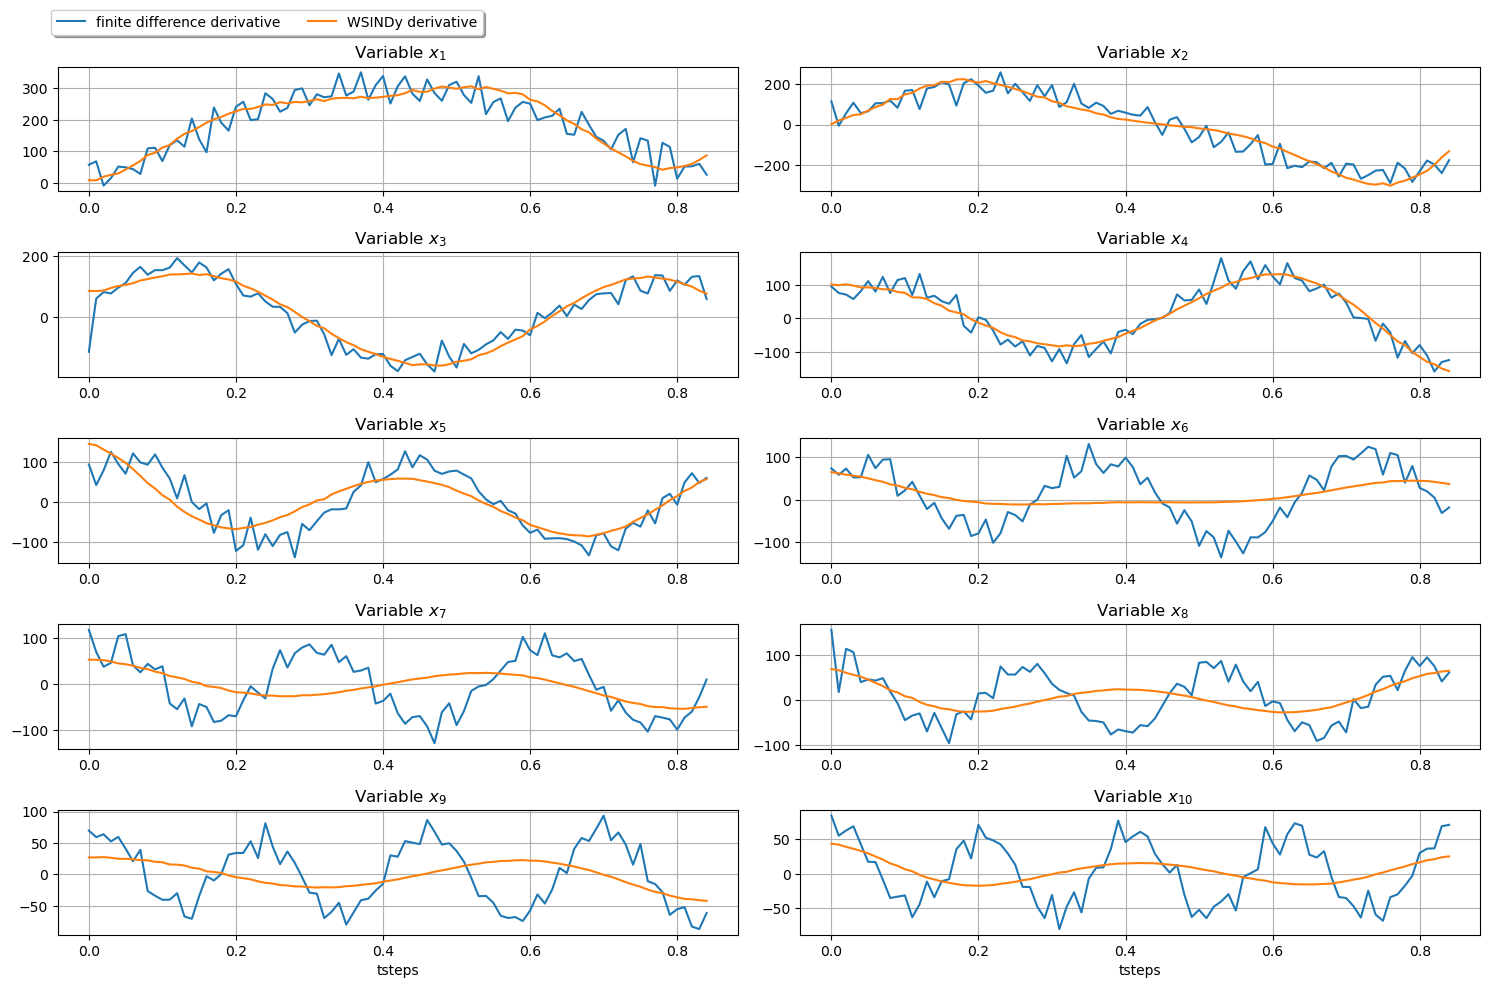

In [6]:
from examples.utils.plot import plot_latent

fig, ax = plot_latent(data = [ 
                              ( time_train, collocation_derivative) , 
                              ( time_train, swisindy_derivatives),
                               
                               #( t_train, ws_result)
                               ],
                      data_kwargs=[ 
                                    dict(label='finite difference derivative'),
                                    dict(label='WSINDy derivative'), 
                                    #dict(label='ws result')
                                    ], 
                      #vlines=[ t_train[-1] ],
                      #vlines_kwargs = [ dict(label='end train', color='k', ls='--') ] 
                    end_idx=-1)

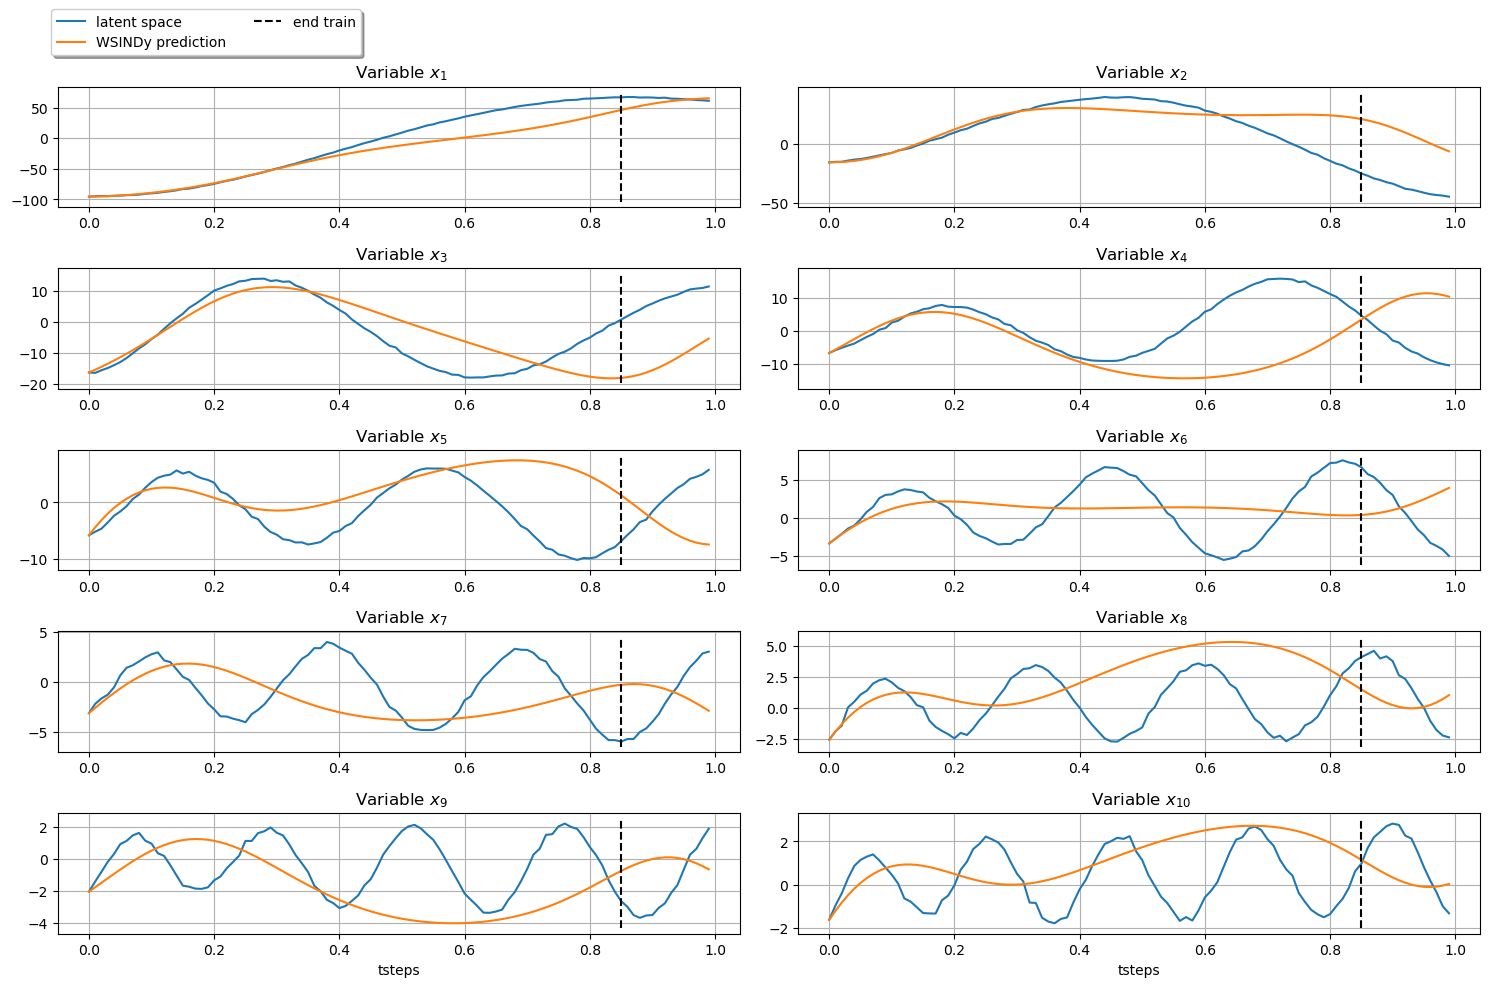

In [7]:
swsindy_prediction = swsindy.simulate(pdata_train[0], time)

fig, ax = plot_latent(data = [ 
                              ( time, pdata) , 
                              ( time, swsindy_prediction),
                               #( t_train, ws_result)
                               ],
                      data_kwargs=[ 
                                    dict(label='latent space'),
                                    dict(label='WSINDy prediction'), 
                                    #dict(label='ws result')
                                    ], 
                      vlines=[ time_train[-1] ],
                      vlines_kwargs = [ dict(label='end train', color='k', ls='--') ],
                    end_idx=-1)

# Hyperparameter Optimization

The algorithm incorporates several important hyperparameters:

- 'threshold' and 'lambda': These parameters play a crucial role in promoting sparsity and regularization within the optimization problem.
- 'training_fraction': This hyperparameter governs the number of time steps (support points) utilized to fit the test functions.
-  'K': It denotes the degree of the Legendre polynomials employed.

Our optimization process aimed to minimize the integration error, and we conducted 2,000 iterations in pursuit of this goal.

In [8]:
from simulai.templates import HyperTrainTemplate
from simulai.metrics import L2Norm
from simulai.workflows import ParamHyperOpt
from simulai.math.integration import ClassWrapper, BRKF78, LSODA

class HyperTrainOpInf(HyperTrainTemplate):

    def __init__(self, trial_config: dict = None, set_type='hard', path_to_model: str = None,
                 other_params: dict = None):

        self.model = None

        self.path_to_model = path_to_model
        self.others_params = other_params

        self.tag = 'model_'
        self.id = None

        required_keys = ['id', 'tag']

        for key in required_keys:
            assert key in trial_config.keys(), f"The required parameter {key} is not in others_params."

        for key, value in trial_config.items():
            setattr(self, key, value)

        super().__init__(trial_config=trial_config, set_type=set_type)

        self.model_id = self.tag + str(self.id)

    def _set_model(self):

        rc_config = {
            'threshold': 10**self.trial_config['threshold'],
            'lambda': 10**self.trial_config['lambda'],
        }

        tf_config = {
            'K' :  self.trial_config['K']
        }

        solver = STLSQ(threshold=rc_config['threshold'], alpha=rc_config['lambda'], max_iter=20)
        
        self.model = WeakSSINDy(
            basis_function = basis_function, 
            test_function = legendre, 
            K = tf_config['K'], 
            solver = solver
        )

    def fit(self, input_train_data=None, target_train_data=None):

        training_fraction = self.trial_config['training_fraction']
        _, input_train_data = sliceDataAlongAxis(input_train_data, [1-training_fraction, training_fraction], 0)
        _, target_train_data = sliceDataAlongAxis(target_train_data, [1-training_fraction, training_fraction], 0)

        msg = self.model.fit(input_train_data,
                             target_train_data)

        return msg
    
class ObjectiveWrapper:
    def __init__(self, target_field=None, t_test=None):
        self.target_field = target_field
        self.t_test = t_test
        
    def __call__(self, trainer_instance=None, objective_function=None):
        return objective_function(model = trainer_instance,
                                  target_field = self.target_field,
                                  t_test = self.t_test)
    
def find_max_tstep(estimated_field, reference_data, threshold=1e-3):
    # find maximum tstep up to which the error is below threshold
    abs_error = np.abs(estimated_field-reference_data)/reference_data
    modes_passed = np.array([len(ae[ae < threshold]) for ae in abs_error])
    max_tstep = np.argwhere(modes_passed < estimated_field.shape[1])[0][0]
    return max_tstep
    
def objective(model=None, target_field=None, t_test=None):
    try:
        estimated_field = model.model.simulate(target_field[0], t_test)
        l2_norm = L2Norm()
        error = 100*l2_norm(data=estimated_field, reference_data=target_field, relative_norm=True)
    except:
        error = np.inf
    return error

params_intervals = {
    'threshold': [-7, -2],
    'lambda': [-2, 5],
    'training_fraction' : [0.5, 1.0],
    'K' : [5, 25],
}

params_suggestions = { 
    'threshold': 'float',
    'lambda': 'float',
    'training_fraction' : 'float',
    'K' : 'int'
}

name = 'spectral_hyper_search'

direction = 'minimize'

trainer_template = HyperTrainOpInf

objective_wrapper = ObjectiveWrapper(target_field = pdata_validation,
                                     t_test = time_validation)

other_params = {'tag': 'model_'}

n_trials = 2_000

hyper_search = ParamHyperOpt(params_intervals=params_intervals, 
                             params_suggestions=params_suggestions,
                             name = name,
                             direction = direction,
                             trainer_template=HyperTrainOpInf,
                             objective_wrapper=objective_wrapper, 
                             objective_function=objective,
                             others_params=other_params)

hyper_search.set_data(input_train_data=pdata_train, 
                      target_train_data=time_train,
                      input_validation_data=pdata_train, 
                      target_validation_data=pdata_train,
                      input_test_data=pdata_test, 
                      target_test_data=time_test)

[I 2023-05-24 12:18:51,496] A new study created in memory with name: spectral_hyper_search


Auxiliary data is not being used.
Auxiliary data is not being used.
Auxiliary data is not being used.


In [9]:
hyper_search.set_data(input_train_data= pdata_train, 
                      target_train_data= time_train, 
                      input_validation_data= pdata_test,
                      target_validation_data= time_test,
                      input_test_data= pdata_test, 
                      target_test_data=time_test)

Auxiliary data is not being used.
Auxiliary data is not being used.
Auxiliary data is not being used.


In [10]:
hyper_search.optimize(n_trials=n_trials)

Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.0884895798398397, threshold=0.00023086513328323888)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:18:52,094] Trial 0 finished with value: 7214.808231194218 and parameters: {'threshold': -3.636641652037723, 'lambda': 0.3198323127687973, 'training_fraction': 0.5021987860383236, 'K': 16}. Best is trial 0 with value: 7214.808231194218.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.06283465128279611, threshold=5.18049265904276e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:18:52,592] Trial 1 finished with value: 2710.1585420114975 and parameters: {'threshold': -6.285628937372572, 'lambda': -1.2018007908063448, 'training_fraction': 0.7186990040152803, 'K': 14}. Best is trial 1 with value: 2710.1585420114975.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: Ru

There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.014505132498838384, threshold=0.0006426004261632859)


[I 2023-05-24 12:18:53,091] Trial 2 finished with value: 4187.724053672253 and parameters: {'threshold': -3.1920589907666015, 'lambda': -1.8384782997291869, 'training_fraction': 0.5661276412443734, 'K': 11}. Best is trial 1 with value: 2710.1585420114975.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2580.0588326238685, threshold=1.0424226210358236e-05)


[I 2023-05-24 12:18:53,577] Trial 3 finished with value: 12.378511781680222 and parameters: {'threshold': -4.98195617280925, 'lambda': 3.4116296092161704, 'training_fraction': 0.9482503773333003, 'K': 13}. Best is trial 3 with value: 12.378511781680222.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1255.9312435468835, threshold=1.194129195730554e-05)


[I 2023-05-24 12:18:54,073] Trial 4 finished with value: 8.209008483512543 and parameters: {'threshold': -4.922948683292519, 'lambda': 3.0989658644286195, 'training_fraction': 0.9848462778180859, 'K': 11}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=137.4910484692355, threshold=0.005574401627089223)


[I 2023-05-24 12:18:54,562] Trial 5 finished with value: 93.20003995536437 and parameters: {'threshold': -2.2538017442439964, 'lambda': 2.1382744237883435, 'training_fraction': 0.8164020915551847, 'K': 7}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.996345369861018, threshold=0.0006869260517527533)


[I 2023-05-24 12:18:55,076] Trial 6 finished with value: 90.30111693787781 and parameters: {'threshold': -3.1630900126410113, 'lambda': 1.3221437078849787, 'training_fraction': 0.9865581184972299, 'K': 17}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5259.050522289251, threshold=6.78876479134547e-05)


[I 2023-05-24 12:18:55,581] Trial 7 finished with value: 19.74075387317678 and parameters: {'threshold': -4.168209237958444, 'lambda': 3.72090734298422, 'training_fraction': 0.957974688021487, 'K': 14}. Best is trial 4 with value: 8.209008483512543.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.024570643661155342, threshold=0.0006762279508076205)


[I 2023-05-24 12:18:56,096] Trial 8 finished with value: 217613800.30257547 and parameters: {'threshold': -3.169906882327067, 'lambda': -1.6095834664411033, 'training_fraction': 0.8003761150222782, 'K': 14}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=54.313648317955426, threshold=0.001615151263655425)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:18:56,622] Trial 9 finished with value: 1428557857781.8691 and parameters: {'threshold': -2.7917867984755422, 'lambda': 1.7349089758940912, 'training_fraction': 0.6759150381645558, 'K': 20}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=87534.13060510423, threshold=3.507403999001291e-06)


[I 2023-05-24 12:18:57,130] Trial 10 finished with value: 92.73156854210592 and parameters: {'threshold': -5.455014207191855, 'lambda': 4.942177422660079, 'training_fraction': 0.8743174410449832, 'K': 25}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2851.7907389858924, threshold=7.15178013896703e-06)


[I 2023-05-24 12:18:57,633] Trial 11 finished with value: 36.98517731718806 and parameters: {'threshold': -5.145585845149092, 'lambda': 3.455117654336213, 'training_fraction': 0.8927245738407025, 'K': 8}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1908.0849212329636, threshold=8.517446568846243e-06)


[I 2023-05-24 12:18:58,131] Trial 12 finished with value: 17.03787070322833 and parameters: {'threshold': -5.069690582142594, 'lambda': 3.280597699509665, 'training_fraction': 0.9920074980661722, 'K': 10}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=76220.61579275942, threshold=3.7487019152026963e-07)


[I 2023-05-24 12:18:58,610] Trial 13 finished with value: 92.64988324899332 and parameters: {'threshold': -6.426119091914928, 'lambda': 4.882072453151933, 'training_fraction': 0.9067800572907915, 'K': 5}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=451.0700941965508, threshold=3.5889997478919424e-05)


[I 2023-05-24 12:18:59,095] Trial 14 finished with value: 20.509944631050946 and parameters: {'threshold': -4.445026572173626, 'lambda': 2.654244034466469, 'training_fraction': 0.9241888859926883, 'K': 11}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.425243605670079, threshold=1.72927033492419e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:18:59,595] Trial 15 finished with value: 472315.3149866671 and parameters: {'threshold': -5.762137108641364, 'lambda': 0.7344192437598274, 'training_fraction': 0.8120404815801844, 'K': 20}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15975.784569326313, threshold=1.83791203001483e-05)


[I 2023-05-24 12:19:00,120] Trial 16 finished with value: 59.96239593929952 and parameters: {'threshold': -4.735675279562225, 'lambda': 4.20346219551665, 'training_fraction': 0.8630875615036894, 'K': 19}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=588.4051704862488, threshold=1.2466317521525363e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:00,620] Trial 17 finished with value: 3232.687141967198 and parameters: {'threshold': -5.904261815668777, 'lambda': 2.769676480343359, 'training_fraction': 0.6555002350883912, 'K': 12}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15390.155242415518, threshold=1.5154960493502032e-07)


[I 2023-05-24 12:19:01,103] Trial 18 finished with value: 38.19009911016805 and parameters: {'threshold': -6.819445191429413, 'lambda': 4.187243000636181, 'training_fraction': 0.9422740763189964, 'K': 8}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.9557651037765154, threshold=8.618679680441308e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:01,585] Trial 19 finished with value: 1693.6074901506697 and parameters: {'threshold': -4.06455925986176, 'lambda': -0.019648830180535537, 'training_fraction': 0.7514897182401162, 'K': 5}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=317.41115970043285, threshold=1.33454067918253e-05)


[I 2023-05-24 12:19:02,129] Trial 20 finished with value: 16.979382283461135 and parameters: {'threshold': -4.874668183603531, 'lambda': 2.5016221918300365, 'training_fraction': 0.9945846100010057, 'K': 24}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=386.73202636040554, threshold=1.4625725404922065e-05)


[I 2023-05-24 12:19:02,659] Trial 21 finished with value: 12.100820614134216 and parameters: {'threshold': -4.834882584627524, 'lambda': 2.5874101387026682, 'training_fraction': 0.9937536406499539, 'K': 23}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1131.7775450422955, threshold=3.2589882926147917e-06)


[I 2023-05-24 12:19:03,190] Trial 22 finished with value: 18.897625921023888 and parameters: {'threshold': -5.486917199664321, 'lambda': 3.0537610730937743, 'training_fraction': 0.9482037400599789, 'K': 23}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.386745655131236, threshold=4.594973492129782e-05)


[I 2023-05-24 12:19:03,848] Trial 23 finished with value: 169.44045906434556 and parameters: {'threshold': -4.337716989665241, 'lambda': 1.6663939048835927, 'training_fraction': 0.8549334700394493, 'K': 18}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9992.977495914016, threshold=1.9500971880302086e-05)


[I 2023-05-24 12:19:04,384] Trial 24 finished with value: 38.01030044173146 and parameters: {'threshold': -4.709943743933158, 'lambda': 3.9996949093850844, 'training_fraction': 0.9655747477840111, 'K': 13}. Best is trial 4 with value: 8.209008483512543.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.550061254456505, threshold=0.00011471727239744522)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:04,908] Trial 25 finished with value: 19192.489856298846 and parameters: {'threshold': -3.940371187659722, 'lambda': 1.0625842874664237, 'training_fraction': 0.9237303885015411, 'K': 21}. Best is trial 4 with value: 8.209008483512543.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=162.36289884883644, threshold=4.505181663933543e-06)


[I 2023-05-24 12:19:05,449] Trial 26 finished with value: 3.0219132431164017 and parameters: {'threshold': -5.346287692131487, 'lambda': 2.210486796666033, 'training_fraction': 0.996959313189179, 'K': 16}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=201.33491990926672, threshold=3.096071900005961e-06)


[I 2023-05-24 12:19:06,065] Trial 27 finished with value: 6.893465513641954 and parameters: {'threshold': -5.509188962261349, 'lambda': 2.3039191062779167, 'training_fraction': 0.999900171428814, 'K': 22}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=127.50886223227828, threshold=9.432883158257202e-07)


[I 2023-05-24 12:19:06,580] Trial 28 finished with value: 83.36998740030434 and parameters: {'threshold': -6.025355544978051, 'lambda': 2.105540370533274, 'training_fraction': 0.8487012249928887, 'K': 16}. Best is trial 26 with value: 3.0219132431164017.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.3517461142048952, threshold=4.977490303937999e-06)


[I 2023-05-24 12:19:07,108] Trial 29 finished with value: 98.69918414896034 and parameters: {'threshold': -5.302989577297605, 'lambda': 0.13089512980542262, 'training_fraction': 0.5901288484490158, 'K': 22}. Best is trial 26 with value: 3.0219132431164017.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=113.69845283306294, threshold=0.00018769035188838062)


[I 2023-05-24 12:19:07,619] Trial 30 finished with value: 131.20205121918036 and parameters: {'threshold': -3.7265580514560677, 'lambda': 2.0557545550075678, 'training_fraction': 0.5120878754622844, 'K': 17}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=312.75070812768513, threshold=2.250907463082235e-06)


[I 2023-05-24 12:19:08,159] Trial 31 finished with value: 31.53466413658216 and parameters: {'threshold': -5.647642358886124, 'lambda': 2.4951983016927093, 'training_fraction': 0.999692919492008, 'K': 25}. Best is trial 26 with value: 3.0219132431164017.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.2552146076091851, threshold=7.537709105092462e-07)


[I 2023-05-24 12:19:08,662] Trial 32 finished with value: 332.98675510116084 and parameters: {'threshold': -6.122760626834791, 'lambda': -0.5930944717122197, 'training_fraction': 0.973061306613534, 'K': 22}. Best is trial 26 with value: 3.0219132431164017.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1298.53512998939, threshold=2.3228039816477018e-05)


[I 2023-05-24 12:19:09,164] Trial 33 finished with value: 56.08640182314275 and parameters: {'threshold': -4.633987438189711, 'lambda': 3.1134537033331804, 'training_fraction': 0.9025588885982232, 'K': 23}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.81518516001397, threshold=4.397512773914726e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:09,675] Trial 34 finished with value: 312453296.7304251 and parameters: {'threshold': -6.35679289032812, 'lambda': 0.5815156201469842, 'training_fraction': 0.9366766290464389, 'K': 16}. Best is trial 26 with value: 3.0219132431164017.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=157.9213182019908, threshold=4.998354671290384e-06)


[I 2023-05-24 12:19:10,160] Trial 35 finished with value: 20.751280370089614 and parameters: {'threshold': -5.30117293061867, 'lambda': 2.1984407604867906, 'training_fraction': 0.9761798385466124, 'K': 9}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.63394583680587, threshold=1.6453063178112305e-07)


[I 2023-05-24 12:19:10,679] Trial 36 finished with value: 530.2834806034455 and parameters: {'threshold': -6.783753234643727, 'lambda': 1.293007588593536, 'training_fraction': 0.7709402066904583, 'K': 18}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=49.59574145594896, threshold=1.0936763731584837e-05)


[I 2023-05-24 12:19:11,232] Trial 37 finished with value: 51.03700018707038 and parameters: {'threshold': -4.961111169907713, 'lambda': 1.6954443873453955, 'training_fraction': 0.9570140714627757, 'K': 15}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5278.546006020198, threshold=2.4693406989757987e-06)


[I 2023-05-24 12:19:11,802] Trial 38 finished with value: 34.73145987521183 and parameters: {'threshold': -5.6074189856139105, 'lambda': 3.7225143110710635, 'training_fraction': 0.9156060718617336, 'K': 21}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=681.5292104254596, threshold=5.146063562768618e-05)


[I 2023-05-24 12:19:12,340] Trial 39 finished with value: 40.41276928978282 and parameters: {'threshold': -4.2885248538059715, 'lambda': 2.833484474484305, 'training_fraction': 0.8845373237318762, 'K': 12}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=168.3779035243963, threshold=0.00028001497032890385)


[I 2023-05-24 12:19:12,897] Trial 40 finished with value: 36.434423793744834 and parameters: {'threshold': -3.5528187495240746, 'lambda': 2.226285097810484, 'training_fraction': 0.9992578931129257, 'K': 24}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4961.995870356038, threshold=6.078293988023468e-06)


[I 2023-05-24 12:19:13,386] Trial 41 finished with value: 24.80777792081354 and parameters: {'threshold': -5.2162182982855905, 'lambda': 3.695656398492754, 'training_fraction': 0.9669599314652951, 'K': 13}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2861.2596824169905, threshold=1.3045500585949635e-05)


[I 2023-05-24 12:19:13,878] Trial 42 finished with value: 15.815998172927697 and parameters: {'threshold': -4.884539251362956, 'lambda': 3.4565572753245934, 'training_fraction': 0.9410246514487522, 'K': 10}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=848.5361541835456, threshold=2.6986860195205696e-05)


[I 2023-05-24 12:19:14,374] Trial 43 finished with value: 12.752702941931323 and parameters: {'threshold': -4.5688476407942735, 'lambda': 2.9286703513418537, 'training_fraction': 0.971511513165653, 'K': 15}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39728.57865124607, threshold=8.395053126203539e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:14,871] Trial 44 finished with value: 1214.0134610763182 and parameters: {'threshold': -5.07597655118239, 'lambda': 4.599103027804855, 'training_fraction': 0.711627514771091, 'K': 13}. Best is trial 26 with value: 3.0219132431164017.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=74.98057744771434, threshold=3.556579727775663e-06)


[I 2023-05-24 12:19:15,371] Trial 45 finished with value: 3.092646865360099 and parameters: {'threshold': -5.448967451286411, 'lambda': 1.8749487807293068, 'training_fraction': 0.9994295760944787, 'K': 11}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=89.01022520764116, threshold=1.684742329733643e-06)


[I 2023-05-24 12:19:15,875] Trial 46 finished with value: 3.0638771599817725 and parameters: {'threshold': -5.773466512200324, 'lambda': 1.949439899860368, 'training_fraction': 0.9995985605966771, 'K': 10}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.48515173386521, threshold=1.5015400764713792e-06)


[I 2023-05-24 12:19:16,355] Trial 47 finished with value: 159.89426144997202 and parameters: {'threshold': -5.823463071884514, 'lambda': 1.3518958226114561, 'training_fraction': 0.8324957785722407, 'K': 6}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=85.24436394728305, threshold=2.425106084622649e-07)


[I 2023-05-24 12:19:16,840] Trial 48 finished with value: 37.27785565247798 and parameters: {'threshold': -6.615269258728306, 'lambda': 1.930665674614568, 'training_fraction': 0.926264802955667, 'K': 10}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.120705398129957, threshold=7.177139969325376e-07)


[I 2023-05-24 12:19:17,346] Trial 49 finished with value: 94.83269446141007 and parameters: {'threshold': -6.144048584029228, 'lambda': 1.0461323358790522, 'training_fraction': 0.9587428849066989, 'K': 11}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=232.60185751882523, threshold=3.288063226672176e-06)


[I 2023-05-24 12:19:17,855] Trial 50 finished with value: 46.39989196541339 and parameters: {'threshold': -5.48305983993648, 'lambda': 2.366613178608056, 'training_fraction': 0.8940545960799297, 'K': 8}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=60.011963627037886, threshold=3.7179465920442647e-06)


[I 2023-05-24 12:19:18,354] Trial 51 finished with value: 3.637222967191203 and parameters: {'threshold': -5.429696853119005, 'lambda': 1.7782378373715786, 'training_fraction': 0.9909708885454149, 'K': 9}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=70.46307811900387, threshold=1.3525273987173798e-06)


[I 2023-05-24 12:19:18,846] Trial 52 finished with value: 23.178540505741648 and parameters: {'threshold': -5.86885392844598, 'lambda': 1.84796161104078, 'training_fraction': 0.9738306740605057, 'K': 9}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.368426812195295, threshold=4.987998610314902e-06)


[I 2023-05-24 12:19:19,340] Trial 53 finished with value: 9.12815822376691 and parameters: {'threshold': -5.302073676190418, 'lambda': 1.6060418249591046, 'training_fraction': 0.9793943092034608, 'K': 7}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.46663630142512, threshold=0.006614763653085248)


[I 2023-05-24 12:19:19,824] Trial 54 finished with value: 164.19984474570597 and parameters: {'threshold': -2.179485668633641, 'lambda': 1.4059715860236437, 'training_fraction': 0.9438395260101865, 'K': 12}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.59727082079004, threshold=2.404497036985228e-06)


[I 2023-05-24 12:19:20,326] Trial 55 finished with value: 3.6688777493412976 and parameters: {'threshold': -5.6189757537624585, 'lambda': 0.9343606075713581, 'training_fraction': 0.998991886955594, 'K': 9}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.586645051061735, threshold=2.1280358488145312e-06)


[I 2023-05-24 12:19:20,818] Trial 56 finished with value: 15.739641803365457 and parameters: {'threshold': -5.672021060206315, 'lambda': 0.8800497656284171, 'training_fraction': 0.9838796566387005, 'K': 9}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.7697226113313045, threshold=1.0211609827242627e-06)


[I 2023-05-24 12:19:21,315] Trial 57 finished with value: 35.02092401681917 and parameters: {'threshold': -5.990905787396255, 'lambda': 0.5763093945558515, 'training_fraction': 0.954161579757687, 'K': 7}. Best is trial 26 with value: 3.0219132431164017.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.810773899803923, threshold=6.037148542876469e-07)


[I 2023-05-24 12:19:21,814] Trial 58 finished with value: 3.013566148911486 and parameters: {'threshold': -6.219168138283031, 'lambda': 1.0338567844606243, 'training_fraction': 0.9986439548090931, 'K': 10}. Best is trial 58 with value: 3.013566148911486.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.3292728380994049, threshold=2.6629386781131027e-07)


[I 2023-05-24 12:19:22,317] Trial 59 finished with value: 57.53555378058288 and parameters: {'threshold': -6.5746388343360245, 'lambda': -0.4824440930052901, 'training_fraction': 0.9334737566968042, 'K': 11}. Best is trial 58 with value: 3.013566148911486.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.28012825070614, threshold=6.013156079604319e-07)


[I 2023-05-24 12:19:22,832] Trial 60 finished with value: 66.84706281577134 and parameters: {'threshold': -6.220897523307142, 'lambda': 1.089202902495957, 'training_fraction': 0.9862760663164708, 'K': 14}. Best is trial 58 with value: 3.013566148911486.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2789310969503584, threshold=3.287437897858352e-06)


[I 2023-05-24 12:19:23,328] Trial 61 finished with value: 2.925811495460487 and parameters: {'threshold': -5.483142442569768, 'lambda': 0.3577311945675552, 'training_fraction': 0.9920646736994089, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.7756170878116574, threshold=1.8336466308746107e-06)


[I 2023-05-24 12:19:23,833] Trial 62 finished with value: 70.41996193254188 and parameters: {'threshold': -5.736684355169716, 'lambda': -0.11035263143892082, 'training_fraction': 0.958273984503034, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2292962729304655, threshold=3.916091322165881e-06)


[I 2023-05-24 12:19:24,323] Trial 63 finished with value: 15.954688671970125 and parameters: {'threshold': -5.407147189123681, 'lambda': 0.34816778994653375, 'training_fraction': 0.9841178531256122, 'K': 9}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.4955561813586575, threshold=3.2123335278123014e-07)


[I 2023-05-24 12:19:24,806] Trial 64 finished with value: 43.15348829584392 and parameters: {'threshold': -6.493179369443005, 'lambda': 0.7400116520409752, 'training_fraction': 0.9097983097015212, 'K': 6}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.195100646205438, threshold=0.003587536743641663)


[I 2023-05-24 12:19:25,318] Trial 65 finished with value: 5.838643372724842 and parameters: {'threshold': -2.4452036421801533, 'lambda': 0.34145443760300065, 'training_fraction': 0.9988344606997264, 'K': 12}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.784842065746902, threshold=1.0629290310410457e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:25,821] Trial 66 finished with value: 6113.831871426333 and parameters: {'threshold': -5.973495731202169, 'lambda': 1.1982402409436141, 'training_fraction': 0.6470363888274704, 'K': 8}. Best is trial 61 with value: 2.925811495460487.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.46237216098953, threshold=2.91446698578431e-06)


[I 2023-05-24 12:19:26,345] Trial 67 finished with value: 51.14373522737989 and parameters: {'threshold': -5.53544085987547, 'lambda': 1.511380252359773, 'training_fraction': 0.9648573420548886, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.503701428930888, threshold=8.953091281116187e-06)


[I 2023-05-24 12:19:26,881] Trial 68 finished with value: 55.06697472326704 and parameters: {'threshold': -5.048026987641237, 'lambda': -0.29782681710750736, 'training_fraction': 0.9839904106129421, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.13326517468679064, threshold=4.771854835467774e-07)


[I 2023-05-24 12:19:27,376] Trial 69 finished with value: 20.249382637648708 and parameters: {'threshold': -6.321312776467378, 'lambda': -0.8752833270855462, 'training_fraction': 0.9488342611559368, 'K': 7}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=82.38400904509272, threshold=1.6123817542504165e-06)


[I 2023-05-24 12:19:27,884] Trial 70 finished with value: 57.62019183235275 and parameters: {'threshold': -5.792532124977679, 'lambda': 1.9158429221651565, 'training_fraction': 0.9261048631424915, 'K': 9}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.1672395909071445, threshold=6.301228080634919e-06)


[I 2023-05-24 12:19:28,415] Trial 71 finished with value: 3.517094663754636 and parameters: {'threshold': -5.200574800281959, 'lambda': 0.335906925743945, 'training_fraction': 0.999678603195442, 'K': 12}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.4654273979649846, threshold=2.3606602907476504e-06)


[I 2023-05-24 12:19:28,958] Trial 72 finished with value: 13.288922624759863 and parameters: {'threshold': -5.626966505284093, 'lambda': 0.16596430694761366, 'training_fraction': 0.9880155740754857, 'K': 8}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.354511518641612, threshold=4.395655753286095e-06)


[I 2023-05-24 12:19:29,477] Trial 73 finished with value: 3.1475755891128507 and parameters: {'threshold': -5.356976326781383, 'lambda': 0.8030821712689092, 'training_fraction': 0.9997883600280754, 'K': 14}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.269361609952201, threshold=6.203539792495616e-06)


[I 2023-05-24 12:19:29,999] Trial 74 finished with value: 135.03275460966108 and parameters: {'threshold': -5.207360427652917, 'lambda': 0.6303629405982502, 'training_fraction': 0.9699770496237781, 'K': 13}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0188389517624787, threshold=4.4033681430670945e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:30,510] Trial 75 finished with value: 258172266137349.22 and parameters: {'threshold': -5.356215003884348, 'lambda': 0.47983994501167804, 'training_fraction': 0.9517931779957284, 'K': 15}. Best is trial 61 with value: 2.925811495460487.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.2315639516228647, threshold=1.651108306031158e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:31,039] Trial 76 finished with value: 1146.378614976661 and parameters: {'threshold': -4.782224437840207, 'lambda': 0.09045696844129994, 'training_fraction': 0.9800387942374167, 'K': 12}. Best is trial 61 with value: 2.925811495460487.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.607208364644752, threshold=7.413127952054376e-06)


[I 2023-05-24 12:19:31,556] Trial 77 finished with value: 125.51717606689414 and parameters: {'threshold': -5.129998503804928, 'lambda': 0.881225311926917, 'training_fraction': 0.9655397192581432, 'K': 14}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.88603627983727, threshold=7.672506484028288e-07)


[I 2023-05-24 12:19:32,084] Trial 78 finished with value: 67.22304431056368 and parameters: {'threshold': -6.115062735874111, 'lambda': 1.5170115315692794, 'training_fraction': 0.9384860128193626, 'K': 17}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.03587595317866483, threshold=4.264582617530329e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:32,590] Trial 79 finished with value: 612.7793082001111 and parameters: {'threshold': -5.370123467608672, 'lambda': -1.4451965514500027, 'training_fraction': 0.777307590037951, 'K': 12}. Best is trial 61 with value: 2.925811495460487.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=54.82396430134533, threshold=6.226781146570608e-06)


[I 2023-05-24 12:19:33,136] Trial 80 finished with value: 3.0824427287979987 and parameters: {'threshold': -5.205736398210995, 'lambda': 1.7389704360183382, 'training_fraction': 0.9996811581794307, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=57.06160146728872, threshold=1.0128939953771442e-05)


[I 2023-05-24 12:19:33,645] Trial 81 finished with value: 28.364136893587588 and parameters: {'threshold': -4.99443600343705, 'lambda': 1.7563439562212753, 'training_fraction': 0.9875231383832075, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=113.34154231598738, threshold=5.599813391879408e-06)


[I 2023-05-24 12:19:34,148] Trial 82 finished with value: 3.1493075319115333 and parameters: {'threshold': -5.251826445177259, 'lambda': 2.054389118088125, 'training_fraction': 0.9994195090021313, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=264.3821158345834, threshold=6.7835726714762835e-06)


[I 2023-05-24 12:19:34,644] Trial 83 finished with value: 19.49694952753107 and parameters: {'threshold': -5.168541518101749, 'lambda': 2.422232073895873, 'training_fraction': 0.9729508346769384, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=112.70067777547281, threshold=3.6828485822670146e-05)


[I 2023-05-24 12:19:35,140] Trial 84 finished with value: 3.1467682430440616 and parameters: {'threshold': -4.433816136490652, 'lambda': 2.051926527876299, 'training_fraction': 0.9999062036538723, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=115.20001103047584, threshold=2.782655954916648e-05)


[I 2023-05-24 12:19:35,661] Trial 85 finished with value: 34.266337038096914 and parameters: {'threshold': -4.555540486126514, 'lambda': 2.061452520671174, 'training_fraction': 0.9598677653804043, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=341.7120549615313, threshold=5.7371921431109456e-05)


[I 2023-05-24 12:19:36,148] Trial 86 finished with value: 18.832113700445184 and parameters: {'threshold': -4.241300605007666, 'lambda': 2.533660300165236, 'training_fraction': 0.9758041540953691, 'K': 14}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=99.88878267131125, threshold=4.250296881764607e-05)


[I 2023-05-24 12:19:36,642] Trial 87 finished with value: 3.0980764915493033 and parameters: {'threshold': -4.371580733571091, 'lambda': 1.9995167204834574, 'training_fraction': 0.9998236869483668, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.40126982291852, threshold=9.579420720822281e-05)


[I 2023-05-24 12:19:37,147] Trial 88 finished with value: 68.58077050714324 and parameters: {'threshold': -4.018660752440956, 'lambda': 1.2405809412115967, 'training_fraction': 0.9484615310828513, 'K': 16}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=199.92500549743238, threshold=4.58092000873388e-05)


[I 2023-05-24 12:19:37,660] Trial 89 finished with value: 58.848743765067326 and parameters: {'threshold': -4.339047291735985, 'lambda': 2.3008671166313013, 'training_fraction': 0.9159509734864989, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=573.2131244832767, threshold=0.00016741605563406169)


[I 2023-05-24 12:19:38,167] Trial 90 finished with value: 8.105351711747641 and parameters: {'threshold': -3.7762028943779593, 'lambda': 2.758316125593784, 'training_fraction': 0.986590486691552, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=114.61460014447779, threshold=3.357187077916616e-05)


[I 2023-05-24 12:19:38,671] Trial 91 finished with value: 3.1545991978059416 and parameters: {'threshold': -4.474024457190145, 'lambda': 2.0592399436200846, 'training_fraction': 0.9978858648623075, 'K': 10}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=160.99737821230994, threshold=1.2660197617750183e-05)


[I 2023-05-24 12:19:39,161] Trial 92 finished with value: 18.985552310253038 and parameters: {'threshold': -4.897559515201081, 'lambda': 2.2068188037511196, 'training_fraction': 0.9739638417554809, 'K': 11}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.3925021360661, threshold=1.89879124030302e-05)


[I 2023-05-24 12:19:39,658] Trial 93 finished with value: 13.330193481437227 and parameters: {'threshold': -4.721522780480556, 'lambda': 1.595413567236518, 'training_fraction': 0.9627690312162519, 'K': 8}. Best is trial 61 with value: 2.925811495460487.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=89.98922534512798, threshold=3.9136984156849114e-05)


[I 2023-05-24 12:19:40,180] Trial 94 finished with value: 2.6256941008594294 and parameters: {'threshold': -4.407412643534986, 'lambda': 1.954190513291756, 'training_fraction': 0.9902045182238942, 'K': 18}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.946099483088627, threshold=1.0692392090352762e-07)


[I 2023-05-24 12:19:40,698] Trial 95 finished with value: 60.98900246419734 and parameters: {'threshold': -6.970925124031247, 'lambda': 1.3970026499434884, 'training_fraction': 0.9850585303413687, 'K': 19}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=65.89049794595225, threshold=6.381476748558649e-05)


[I 2023-05-24 12:19:41,212] Trial 96 finished with value: 24.87919746200948 and parameters: {'threshold': -4.195078808812188, 'lambda': 1.8188227895988676, 'training_fraction': 0.9771113697004403, 'K': 18}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=423.70157379893794, threshold=4.47705442508119e-05)


[I 2023-05-24 12:19:41,730] Trial 97 finished with value: 54.449845964966926 and parameters: {'threshold': -4.349007626105997, 'lambda': 2.6270600771492667, 'training_fraction': 0.9366860673766286, 'K': 19}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=83.73036764427852, threshold=2.1517786300648918e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:42,239] Trial 98 finished with value: 15024.02130758482 and parameters: {'threshold': -4.667202409904544, 'lambda': 1.9228829981177755, 'training_fraction': 0.552206430847411, 'K': 13}. Best is trial 94 with value: 2.6256941008594294.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.010096186038549245, threshold=1.2678015157209024e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:42,764] Trial 99 finished with value: 54418850.503573775 and parameters: {'threshold': -5.896948733342691, 'lambda': -1.9958426554483006, 'training_fraction': 0.9903467426113434, 'K': 15}. Best is trial 94 with value: 2.6256941008594294.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43.66366008075528, threshold=3.733807891566078e-05)


[I 2023-05-24 12:19:43,332] Trial 100 finished with value: 308.8892557409445 and parameters: {'threshold': -4.427848030730558, 'lambda': 1.640120137379804, 'training_fraction': 0.9636614706222383, 'K': 17}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=99.40703951484974, threshold=2.9855460842854814e-06)


[I 2023-05-24 12:19:43,871] Trial 101 finished with value: 3.0963725616820588 and parameters: {'threshold': -5.524976220748683, 'lambda': 1.9974171400734027, 'training_fraction': 0.9902133123281015, 'K': 10}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=239.09507356524938, threshold=1.8211514485933424e-06)


[I 2023-05-24 12:19:44,406] Trial 102 finished with value: 3.884895966286846 and parameters: {'threshold': -5.739653936383322, 'lambda': 2.3785706277867518, 'training_fraction': 0.9884759624987327, 'K': 10}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=145.18063694365338, threshold=3.061637172049841e-06)


[I 2023-05-24 12:19:44,937] Trial 103 finished with value: 592.9810520466648 and parameters: {'threshold': -5.514046277881112, 'lambda': 2.161908697429637, 'training_fraction': 0.704704901531437, 'K': 9}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=90.18213409488143, threshold=0.00013759250037863416)


[I 2023-05-24 12:19:45,472] Trial 104 finished with value: 18.35846903117764 and parameters: {'threshold': -3.861405237124768, 'lambda': 1.955120508356496, 'training_fraction': 0.9792597437018925, 'K': 18}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.887940303100223, threshold=7.958324501823266e-05)


[I 2023-05-24 12:19:45,961] Trial 105 finished with value: 68.56051905287691 and parameters: {'threshold': -4.099178356408785, 'lambda': 1.1426378410344702, 'training_fraction': 0.9528278110535964, 'K': 11}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.460502774951433, threshold=0.00040895786885111805)


[I 2023-05-24 12:19:46,455] Trial 106 finished with value: 3.644498877818573 and parameters: {'threshold': -3.3883214310340897, 'lambda': 1.3703373151131553, 'training_fraction': 0.9919238951863422, 'K': 9}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=55.60341933464874, threshold=2.8472713229959797e-06)


[I 2023-05-24 12:19:46,951] Trial 107 finished with value: 18.34199505190042 and parameters: {'threshold': -5.545571145966691, 'lambda': 1.7451014993609923, 'training_fraction': 0.9704363169355251, 'K': 12}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.56981569732111, threshold=1.58494281193058e-05)


[I 2023-05-24 12:19:47,479] Trial 108 finished with value: 3.03563723174673 and parameters: {'threshold': -4.799986403421656, 'lambda': 1.4852928204114757, 'training_fraction': 0.9911158909968761, 'K': 10}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.65146411304687, threshold=1.6320106224344502e-05)


[I 2023-05-24 12:19:48,010] Trial 109 finished with value: 50.64281666994567 and parameters: {'threshold': -4.787277018836047, 'lambda': 1.5270039643217928, 'training_fraction': 0.9562401349340374, 'K': 10}. Best is trial 94 with value: 2.6256941008594294.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=196.19454259288906, threshold=2.485871438947558e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:48,503] Trial 110 finished with value: 1368.8352573729749 and parameters: {'threshold': -4.604521335388419, 'lambda': 2.292686922744452, 'training_fraction': 0.6209984589608465, 'K': 9}. Best is trial 94 with value: 2.6256941008594294.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.682296019069516, threshold=7.981990353664767e-06)


[I 2023-05-24 12:19:49,056] Trial 111 finished with value: 1.5499009248405833 and parameters: {'threshold': -5.097888801401995, 'lambda': 0.8249257105419896, 'training_fraction': 0.9929583873667716, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=101.64797832250031, threshold=1.0769505245995205e-05)


[I 2023-05-24 12:19:49,568] Trial 112 finished with value: 20.513542197935376 and parameters: {'threshold': -4.967804247850549, 'lambda': 2.0070987453733338, 'training_fraction': 0.9773725720539808, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.524467938459876, threshold=8.400684949665548e-06)


[I 2023-05-24 12:19:50,070] Trial 113 finished with value: 4.091013698708661 and parameters: {'threshold': -5.075685302303273, 'lambda': 0.9788407242064587, 'training_fraction': 0.9915688773748175, 'K': 8}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=50.08395597330396, threshold=2.0155685964673676e-06)


[I 2023-05-24 12:19:50,551] Trial 114 finished with value: 13.999513862661725 and parameters: {'threshold': -5.695602416781431, 'lambda': 1.6996986251049835, 'training_fraction': 0.9689446926631029, 'K': 10}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.110811123070416, threshold=3.181498053982469e-05)


[I 2023-05-24 12:19:51,045] Trial 115 finished with value: 36.631886217460185 and parameters: {'threshold': -4.4973683380713005, 'lambda': 1.2579379013568575, 'training_fraction': 0.9847246492469243, 'K': 10}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.228773165998348, threshold=1.3159900118991738e-05)


[I 2023-05-24 12:19:51,534] Trial 116 finished with value: 54.500045778963745 and parameters: {'threshold': -4.8807474069177585, 'lambda': 1.4658105868791995, 'training_fraction': 0.9444827855558907, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=71.17726751453061, threshold=4.977718240104049e-06)


[I 2023-05-24 12:19:52,042] Trial 117 finished with value: 2.4361590068768493 and parameters: {'threshold': -5.302969689935382, 'lambda': 1.852341311482668, 'training_fraction': 0.9926382066842536, 'K': 12}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.073930412304321, threshold=3.7582344312419015e-06)


[I 2023-05-24 12:19:52,559] Trial 118 finished with value: 109.8504026342691 and parameters: {'threshold': -5.425016132958416, 'lambda': 1.0818486684828896, 'training_fraction': 0.9631738914644693, 'K': 12}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=67.97008155857056, threshold=5.215659857850432e-06)


[I 2023-05-24 12:19:53,081] Trial 119 finished with value: 19.339952677562376 and parameters: {'threshold': -5.282690739108076, 'lambda': 1.8323177910406359, 'training_fraction': 0.9813655374259417, 'K': 13}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=313.5121755182511, threshold=8.096624973370942e-06)


[I 2023-05-24 12:19:53,597] Trial 120 finished with value: 21.502354305668977 and parameters: {'threshold': -5.09169597629348, 'lambda': 2.496254411698512, 'training_fraction': 0.9326969154639735, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=137.99879323489486, threshold=2.6038931336312963e-06)


[I 2023-05-24 12:19:54,096] Trial 121 finished with value: 3.8645619998344842 and parameters: {'threshold': -5.584376843616366, 'lambda': 2.139875288620674, 'training_fraction': 0.9922780290020642, 'K': 9}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=81.9423271432658, threshold=3.864961575933767e-06)


[I 2023-05-24 12:19:54,622] Trial 122 finished with value: 2.7653129044802522 and parameters: {'threshold': -5.41285481932467, 'lambda': 1.9135082936557795, 'training_fraction': 0.9982348909888334, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43.308987676415015, threshold=4.671819929919469e-06)


[I 2023-05-24 12:19:55,137] Trial 123 finished with value: 40.618493702531744 and parameters: {'threshold': -5.33051390496874, 'lambda': 1.6365780324556547, 'training_fraction': 0.9785026704789943, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=78.38482363053652, threshold=3.6770647440162083e-06)


[I 2023-05-24 12:19:55,650] Trial 124 finished with value: 2.762702686955974 and parameters: {'threshold': -5.434498723212065, 'lambda': 1.8942319854965923, 'training_fraction': 0.991837847345178, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=71.41034246753938, threshold=3.6216010489138153e-06)


[I 2023-05-24 12:19:56,141] Trial 125 finished with value: 17.89835217411953 and parameters: {'threshold': -5.441099392729334, 'lambda': 1.853761115855975, 'training_fraction': 0.9669212643674632, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=171.29103623638835, threshold=6.697395851311003e-06)


[I 2023-05-24 12:19:56,654] Trial 126 finished with value: 2.828314841429414 and parameters: {'threshold': -5.1740940312177175, 'lambda': 2.233734636667022, 'training_fraction': 0.9907840771258188, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.657217130118497, threshold=6.430826056298917e-06)


[I 2023-05-24 12:19:57,154] Trial 127 finished with value: 197.01606198190754 and parameters: {'threshold': -5.191733237239062, 'lambda': 0.6681264862071741, 'training_fraction': 0.9743734549240837, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.836474993265636, threshold=1.5067756174550374e-06)


[I 2023-05-24 12:19:57,812] Trial 128 finished with value: 81.13934703870453 and parameters: {'threshold': -5.8219514161369466, 'lambda': 1.2749996333715157, 'training_fraction': 0.9500772390874044, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=166.82546324160006, threshold=5.9593204089444775e-06)


[I 2023-05-24 12:19:58,328] Trial 129 finished with value: 12.734920519852597 and parameters: {'threshold': -5.22480326366136, 'lambda': 2.2222623394751024, 'training_fraction': 0.9832653432048571, 'K': 18}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.2792816780724254, threshold=9.473877326460062e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:19:58,841] Trial 130 finished with value: 118901565087.26895 and parameters: {'threshold': -5.023472243081399, 'lambda': 0.5157787225487427, 'training_fraction': 0.9587597845580924, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=250.0801220933892, threshold=3.3218035149719173e-06)


[I 2023-05-24 12:19:59,350] Trial 131 finished with value: 3.518037202216648 and parameters: {'threshold': -5.4786260596893, 'lambda': 2.398079172705151, 'training_fraction': 0.9889602423828288, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=54.76057508823843, threshold=2.259459583704203e-06)


[I 2023-05-24 12:19:59,859] Trial 132 finished with value: 3.59988907711236 and parameters: {'threshold': -5.645995422746689, 'lambda': 1.738468000388488, 'training_fraction': 0.9918213147084614, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=465.5077407198818, threshold=7.3852015297049245e-06)


[I 2023-05-24 12:20:00,356] Trial 133 finished with value: 16.550955815176074 and parameters: {'threshold': -5.131637649025749, 'lambda': 2.6679269070659757, 'training_fraction': 0.9741672935233678, 'K': 18}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.11600287823167, threshold=4.719583837901603e-06)


[I 2023-05-24 12:20:00,862] Trial 134 finished with value: 4.115453846251116 and parameters: {'threshold': -5.326096294770819, 'lambda': 1.5200379116669775, 'training_fraction': 0.9992929731604568, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=82.10647194673092, threshold=8.556138085794917e-07)


[I 2023-05-24 12:20:01,377] Trial 135 finished with value: 2.3435778010546695 and parameters: {'threshold': -6.067722215052492, 'lambda': 1.9143773912238649, 'training_fraction': 0.9907659250909101, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=72.18265792733065, threshold=8.737531882169854e-07)


[I 2023-05-24 12:20:01,901] Trial 136 finished with value: 233.71734458611627 and parameters: {'threshold': -6.058611226556685, 'lambda': 1.8584328697146266, 'training_fraction': 0.7306020419687491, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=810.9273465527173, threshold=5.915598959035354e-07)


[I 2023-05-24 12:20:02,416] Trial 137 finished with value: 7.8724093415423955 and parameters: {'threshold': -6.228001276152773, 'lambda': 2.9089819461906035, 'training_fraction': 0.9813015147744594, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=161.41753113576513, threshold=1.1490599560439546e-06)


[I 2023-05-24 12:20:02,933] Trial 138 finished with value: 341.81175633176133 and parameters: {'threshold': -5.939657309954265, 'lambda': 2.2079507005351138, 'training_fraction': 0.8012915058808714, 'K': 19}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.73601906772318, threshold=3.34567652247273e-07)


[I 2023-05-24 12:20:03,422] Trial 139 finished with value: 27.24215877599582 and parameters: {'threshold': -6.475516051208736, 'lambda': 1.6099785852582487, 'training_fraction': 0.9679221112486468, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.897944448844697, threshold=1.7947843598454334e-06)


[I 2023-05-24 12:20:03,929] Trial 140 finished with value: 2.6658055487905283 and parameters: {'threshold': -5.745987723662264, 'lambda': 1.4608669518820399, 'training_fraction': 0.9914598225880117, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.914412676260245, threshold=1.6708274490737892e-06)


[I 2023-05-24 12:20:04,440] Trial 141 finished with value: 2.646567928598411 and parameters: {'threshold': -5.777068398571294, 'lambda': 1.4299849071224546, 'training_fraction': 0.9891749840556566, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.10663015682234, threshold=1.6304024544472026e-06)


[I 2023-05-24 12:20:04,952] Trial 142 finished with value: 51.33509185783277 and parameters: {'threshold': -5.7877051795397625, 'lambda': 1.4330755302967098, 'training_fraction': 0.9870466036796913, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.374565726025122, threshold=4.1698398297430733e-07)


[I 2023-05-24 12:20:05,455] Trial 143 finished with value: 2.0465090601880256 and parameters: {'threshold': -6.379880626655669, 'lambda': 0.8044506033467521, 'training_fraction': 0.9994919372950523, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.251820596214147, threshold=7.647871794954232e-07)


[I 2023-05-24 12:20:05,960] Trial 144 finished with value: 79.63871654154167 and parameters: {'threshold': -6.116459400963469, 'lambda': 0.9165497773571983, 'training_fraction': 0.9770548352170438, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.986743377879195, threshold=9.277729958703579e-07)


[I 2023-05-24 12:20:06,472] Trial 145 finished with value: 3.111463040016182 and parameters: {'threshold': -6.032558272381138, 'lambda': 1.078701207692171, 'training_fraction': 0.9915365515031894, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.0514105141931775, threshold=5.976047359042372e-07)


[I 2023-05-24 12:20:06,966] Trial 146 finished with value: 103.35985746515269 and parameters: {'threshold': -6.223585969477585, 'lambda': 0.7034126638606603, 'training_fraction': 0.9671827099266244, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.167911826040485, threshold=2.1516102841207957e-07)


[I 2023-05-24 12:20:07,472] Trial 147 finished with value: 2.775482816339286 and parameters: {'threshold': -6.6672363885739445, 'lambda': 0.8553926543410677, 'training_fraction': 0.9999380296912179, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.252663701131663, threshold=1.353748326516551e-07)


[I 2023-05-24 12:20:07,980] Trial 148 finished with value: 102.3688632445514 and parameters: {'threshold': -6.868462067234639, 'lambda': 0.7960650708251696, 'training_fraction': 0.8398944887478735, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.9406244881287806, threshold=4.831144369194087e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:08,489] Trial 149 finished with value: 3363229.40970637 and parameters: {'threshold': -6.315949984287952, 'lambda': 0.46843956951020227, 'training_fraction': 0.9586258664293763, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.6956978120553083, threshold=2.428886077298218e-07)


[I 2023-05-24 12:20:08,993] Trial 150 finished with value: 64.76441374685761 and parameters: {'threshold': -6.614592854548934, 'lambda': 0.2293484598015306, 'training_fraction': 0.9827377851921191, 'K': 14}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.991214508540345, threshold=1.597588720342523e-07)


[I 2023-05-24 12:20:09,498] Trial 151 finished with value: 4.530902671033982 and parameters: {'threshold': -6.796535014430727, 'lambda': 1.3422492147992702, 'training_fraction': 0.9986774441847378, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.311837853438867, threshold=3.8445847561573135e-07)


[I 2023-05-24 12:20:10,007] Trial 152 finished with value: 2.6547498524302346 and parameters: {'threshold': -6.415150560374411, 'lambda': 1.1850273214431122, 'training_fraction': 0.9907187057032519, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.257985282952845, threshold=3.988346931192198e-07)


[I 2023-05-24 12:20:10,518] Trial 153 finished with value: 306.27171546663703 and parameters: {'threshold': -6.399207071085291, 'lambda': 1.1540581620998165, 'training_fraction': 0.8698199512943219, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.460104567057753, threshold=2.1255235577682734e-07)


[I 2023-05-24 12:20:11,032] Trial 154 finished with value: 52.458030134485 and parameters: {'threshold': -6.672534077263751, 'lambda': 0.9273757309604795, 'training_fraction': 0.9889737113757151, 'K': 18}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.8436689962093276, threshold=4.6574891299871074e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:11,545] Trial 155 finished with value: 314.2254817946719 and parameters: {'threshold': -6.3318481500210115, 'lambda': -0.07382791038385833, 'training_fraction': 0.9800820420323283, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.133443489871855, threshold=2.9957349202565545e-07)


[I 2023-05-24 12:20:12,033] Trial 156 finished with value: 83.9984908967876 and parameters: {'threshold': -6.523496618129797, 'lambda': 1.1799377593843166, 'training_fraction': 0.971396439427902, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.360404967446884, threshold=1.1742797330067108e-06)


[I 2023-05-24 12:20:12,536] Trial 157 finished with value: 4.399306724108425 and parameters: {'threshold': -5.93022843457902, 'lambda': 1.0153767314410853, 'training_fraction': 0.9917572100931914, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.64250218913842, threshold=3.909904994931791e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:13,049] Trial 158 finished with value: 364.93463899334813 and parameters: {'threshold': -6.4078337952072415, 'lambda': 0.751471736244359, 'training_fraction': 0.9804608445776417, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.87540985371671, threshold=2.240442096813176e-07)


[I 2023-05-24 12:20:13,536] Trial 159 finished with value: 61.04131103681988 and parameters: {'threshold': -6.649666275745348, 'lambda': 1.3196350108842723, 'training_fraction': 0.968762204156679, 'K': 14}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.44343204626788, threshold=2.0508185731898343e-06)


[I 2023-05-24 12:20:14,046] Trial 160 finished with value: 4.171622760552377 and parameters: {'threshold': -5.688072758036139, 'lambda': 1.4975299431373403, 'training_fraction': 0.9889526134124914, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.72888616508577, threshold=6.838581520575098e-07)


[I 2023-05-24 12:20:14,557] Trial 161 finished with value: 4.728417813978557 and parameters: {'threshold': -6.16503397162385, 'lambda': 1.5991063893911828, 'training_fraction': 0.9984294526069047, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=130.23378252063335, threshold=1.4266191005183664e-06)


[I 2023-05-24 12:20:15,071] Trial 162 finished with value: 3.2479034965420275 and parameters: {'threshold': -5.845691965655167, 'lambda': 2.1147236544260024, 'training_fraction': 0.9984472210804036, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.265546955206273, threshold=2.4627700729047945e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:15,583] Trial 163 finished with value: 6464.466600486472 and parameters: {'threshold': -5.608576132509205, 'lambda': 0.8612683138421116, 'training_fraction': 0.9822235278907551, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=74.35954026026072, threshold=4.184804020016644e-06)


[I 2023-05-24 12:20:16,075] Trial 164 finished with value: 17.63088783291812 and parameters: {'threshold': -5.378324875787396, 'lambda': 1.8713366960131328, 'training_fraction': 0.9737559421685323, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=53.137359073012725, threshold=0.0015390973230339712)


[I 2023-05-24 12:20:16,587] Trial 165 finished with value: 4.87881485577442 and parameters: {'threshold': -2.812733917192407, 'lambda': 1.7253999661728912, 'training_fraction': 0.9905698629126399, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.6001483228474904, threshold=1.8031149933121333e-06)


[I 2023-05-24 12:20:17,106] Trial 166 finished with value: 3164.3995903221626 and parameters: {'threshold': -5.743976575347263, 'lambda': 0.556320393674857, 'training_fraction': 0.9610679660279711, 'K': 18}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.44598065074343, threshold=2.645675272818065e-06)


[I 2023-05-24 12:20:17,615] Trial 167 finished with value: 69.21380567435308 and parameters: {'threshold': -5.577463461689578, 'lambda': 1.2160597749611877, 'training_fraction': 0.9861690440435664, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.474664938963109, threshold=1.0210057150197769e-06)


[I 2023-05-24 12:20:18,126] Trial 168 finished with value: 83.62350044976048 and parameters: {'threshold': -5.990971826968323, 'lambda': 0.3935164052857081, 'training_fraction': 0.9772166613334481, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=83.52071607900974, threshold=3.3120387631612453e-07)


[I 2023-05-24 12:20:18,630] Trial 169 finished with value: 3.0337124946758407 and parameters: {'threshold': -6.479904588998113, 'lambda': 1.9217942091714697, 'training_fraction': 0.9989688937267273, 'K': 14}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=210.27223163168884, threshold=2.012248217578592e-07)


[I 2023-05-24 12:20:19,133] Trial 170 finished with value: 3.653656979513987 and parameters: {'threshold': -6.696318448628186, 'lambda': 2.3227819239208083, 'training_fraction': 0.9931462860213992, 'K': 14}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=86.39969682041232, threshold=3.188479118854405e-07)


[I 2023-05-24 12:20:19,640] Trial 171 finished with value: 3.2896485260280537 and parameters: {'threshold': -6.496416422834168, 'lambda': 1.9365122185268913, 'training_fraction': 0.9994367639590142, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=108.15324964155187, threshold=4.965594492095053e-07)


[I 2023-05-24 12:20:20,144] Trial 172 finished with value: 3.2334984668411426 and parameters: {'threshold': -6.304028749347738, 'lambda': 2.0340395730602836, 'training_fraction': 0.9992904716571879, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=50.24425806965001, threshold=3.616672457837704e-06)


[I 2023-05-24 12:20:20,662] Trial 173 finished with value: 37.485817305050794 and parameters: {'threshold': -5.441690821123609, 'lambda': 1.701086437611913, 'training_fraction': 0.9834949893577948, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.868145111190195, threshold=5.883860200562001e-07)


[I 2023-05-24 12:20:21,174] Trial 174 finished with value: 11.987243191634342 and parameters: {'threshold': -6.2303376545790705, 'lambda': 1.3956433929089738, 'training_fraction': 0.9999849076082832, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=161.89027375075014, threshold=3.7968310451001257e-07)


[I 2023-05-24 12:20:21,669] Trial 175 finished with value: 19.122184697590832 and parameters: {'threshold': -6.420578728067804, 'lambda': 2.209220757442284, 'training_fraction': 0.9738033562825754, 'K': 18}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=69.44748200884564, threshold=5.1867490469257825e-06)


[I 2023-05-24 12:20:22,180] Trial 176 finished with value: 30.912181250951047 and parameters: {'threshold': -5.285104764185306, 'lambda': 1.8416565039326946, 'training_fraction': 0.9881357402517801, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.881794590558185, threshold=8.143929360183396e-07)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:22,696] Trial 177 finished with value: 69680.35907734405 and parameters: {'threshold': -6.089166002027897, 'lambda': 0.9948358221182356, 'training_fraction': 0.963309131574964, 'K': 17}. Best is trial 111 with value: 1.5499009248405833.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=97.61960354545302, threshold=2.679691597378213e-07)


[I 2023-05-24 12:20:23,197] Trial 178 finished with value: 16.19896523904686 and parameters: {'threshold': -6.571915185547297, 'lambda': 1.989537039559268, 'training_fraction': 0.9833279758969581, 'K': 13}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.944803287238265, threshold=1.3277160671628943e-06)


[I 2023-05-24 12:20:23,687] Trial 179 finished with value: 47.88592878112159 and parameters: {'threshold': -5.876894789161113, 'lambda': 1.6014602867669394, 'training_fraction': 0.9523955457060032, 'K': 14}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=119.97013833161971, threshold=9.673732168231998e-06)


[I 2023-05-24 12:20:24,185] Trial 180 finished with value: 18.17147957652575 and parameters: {'threshold': -5.014405940874494, 'lambda': 2.0790731596169123, 'training_fraction': 0.971946035719098, 'K': 15}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=58.50094338190261, threshold=6.319320503169297e-06)


[I 2023-05-24 12:20:24,684] Trial 181 finished with value: 3.0836393550726577 and parameters: {'threshold': -5.199329617538685, 'lambda': 1.7671628695394654, 'training_fraction': 0.9994168240795361, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.621552862324403, threshold=7.371589450056261e-06)


[I 2023-05-24 12:20:25,181] Trial 182 finished with value: 2.9282517850148144 and parameters: {'threshold': -5.132438860178423, 'lambda': 1.4566931927096953, 'training_fraction': 0.9889303260396574, 'K': 11}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.457448130399086, threshold=1.531905519011726e-05)


[I 2023-05-24 12:20:25,682] Trial 183 finished with value: 1.931286733929537 and parameters: {'threshold': -4.814768019192434, 'lambda': 1.454195952931138, 'training_fraction': 0.9889799143986555, 'K': 12}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.969408221286255, threshold=1.7818791985595166e-05)


[I 2023-05-24 12:20:26,183] Trial 184 finished with value: 33.85371441689299 and parameters: {'threshold': -4.749121742037264, 'lambda': 1.3215861743920798, 'training_fraction': 0.9882562063982778, 'K': 12}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.691237827342498, threshold=1.3157416901181528e-05)


[I 2023-05-24 12:20:26,691] Trial 185 finished with value: 49.096195444432105 and parameters: {'threshold': -4.880829364192865, 'lambda': 1.4726283037051169, 'training_fraction': 0.9797043998479618, 'K': 16}. Best is trial 111 with value: 1.5499009248405833.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.734461735777924, threshold=8.244684240262892e-06)


[I 2023-05-24 12:20:27,191] Trial 186 finished with value: 1.4528279033414528 and parameters: {'threshold': -5.083825972564932, 'lambda': 1.1968518906124501, 'training_fraction': 0.9890976741486809, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.206488422835253, threshold=8.638021809706718e-06)


[I 2023-05-24 12:20:27,677] Trial 187 finished with value: 49.191668859596746 and parameters: {'threshold': -5.0635857037588465, 'lambda': 1.086590743557517, 'training_fraction': 0.9764354337578327, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.5415106962999, threshold=7.732398726826252e-06)


[I 2023-05-24 12:20:28,172] Trial 188 finished with value: 2.490035405603155 and parameters: {'threshold': -5.1116857593517535, 'lambda': 1.2440669926112393, 'training_fraction': 0.9898432263422497, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.474508076719015, threshold=1.1009752859902111e-05)


[I 2023-05-24 12:20:28,653] Trial 189 finished with value: 41.4180064573093 and parameters: {'threshold': -4.958222429691774, 'lambda': 1.2424049588055017, 'training_fraction': 0.9665529750457366, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.752700637111902, threshold=7.291092663365726e-06)


[I 2023-05-24 12:20:29,161] Trial 190 finished with value: 41.2377267881811 and parameters: {'threshold': -5.137207382229245, 'lambda': 1.1383879895574482, 'training_fraction': 0.9839553742477382, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.393555206897802, threshold=5.131502720259286e-06)


[I 2023-05-24 12:20:29,684] Trial 191 finished with value: 2.2637284246844187 and parameters: {'threshold': -5.289755436535485, 'lambda': 0.8057424195632765, 'training_fraction': 0.9910102590467468, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.259059610625823, threshold=4.8770493248017165e-06)


[I 2023-05-24 12:20:30,243] Trial 192 finished with value: 2.264534710898938 and parameters: {'threshold': -5.311842852081003, 'lambda': 0.7965090877479882, 'training_fraction': 0.990034137548402, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.687434887736721, threshold=4.345816226630624e-06)


[I 2023-05-24 12:20:30,827] Trial 193 finished with value: 2.726486161079084 and parameters: {'threshold': -5.361928642821692, 'lambda': 0.6709352480759253, 'training_fraction': 0.9899027941402455, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.274299188265821, threshold=5.362908022904145e-06)


[I 2023-05-24 12:20:31,375] Trial 194 finished with value: 54.46208471218061 and parameters: {'threshold': -5.270599651384448, 'lambda': 0.6308649182176691, 'training_fraction': 0.9877832174437664, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.407333296854251, threshold=4.463496579225197e-06)


[I 2023-05-24 12:20:31,894] Trial 195 finished with value: 56.85158229550954 and parameters: {'threshold': -5.350324793728518, 'lambda': 0.8066773157227476, 'training_fraction': 0.9742112400037162, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.516579490215902, threshold=3.264388281158819e-06)


[I 2023-05-24 12:20:32,430] Trial 196 finished with value: 49.939064916434376 and parameters: {'threshold': -5.486198189888889, 'lambda': 0.7416698804523778, 'training_fraction': 0.9880077990210713, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.385459177726309, threshold=7.341642644280128e-06)


[I 2023-05-24 12:20:32,955] Trial 197 finished with value: 116.49653817065253 and parameters: {'threshold': -5.134206758676256, 'lambda': 0.868377501970701, 'training_fraction': 0.9654169304202225, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.105657150996296, threshold=5.236172662730205e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:33,481] Trial 198 finished with value: 385.90471320771115 and parameters: {'threshold': -5.280986041029875, 'lambda': 0.6133826801424123, 'training_fraction': 0.9799688274035765, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.767517876346279, threshold=1.003214687607996e-05)


[I 2023-05-24 12:20:34,017] Trial 199 finished with value: 1.7617520003132265 and parameters: {'threshold': -4.99860611815968, 'lambda': 0.9428766600500478, 'training_fraction': 0.9900812246534989, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.8980815313585113, threshold=1.070859374473747e-05)


[I 2023-05-24 12:20:34,532] Trial 200 finished with value: 54.54193382919771 and parameters: {'threshold': -4.9702675570859265, 'lambda': 0.46211059925835307, 'training_fraction': 0.9733855597618937, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.606793419595439, threshold=7.652813577771749e-06)


[I 2023-05-24 12:20:35,064] Trial 201 finished with value: 2.212221231614462 and parameters: {'threshold': -5.116178865937651, 'lambda': 0.9825784519180278, 'training_fraction': 0.9901820759579949, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.509163937407521, threshold=8.980774161767605e-06)


[I 2023-05-24 12:20:35,601] Trial 202 finished with value: 2.213884524720027 and parameters: {'threshold': -5.0466862246141915, 'lambda': 0.9781423346732652, 'training_fraction': 0.9892412331887058, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.903543816471341, threshold=7.95578419724655e-06)


[I 2023-05-24 12:20:36,110] Trial 203 finished with value: 2.224477412826415 and parameters: {'threshold': -5.099317005740677, 'lambda': 0.9495629003086208, 'training_fraction': 0.9909911864705067, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.280932698182944, threshold=8.799451861105704e-06)


[I 2023-05-24 12:20:36,687] Trial 204 finished with value: 31.753971915366364 and parameters: {'threshold': -5.055544380248857, 'lambda': 0.9675916233438273, 'training_fraction': 0.9817209730985292, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.7502127590789, threshold=1.284315825847436e-05)


[I 2023-05-24 12:20:37,357] Trial 205 finished with value: 2.245089980580521 and parameters: {'threshold': -4.891328165864726, 'lambda': 0.8893136249354257, 'training_fraction': 0.9906600551907642, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.538216105467308, threshold=1.5924509889134636e-05)


[I 2023-05-24 12:20:37,913] Trial 206 finished with value: 24.352308966953736 and parameters: {'threshold': -4.797933925128864, 'lambda': 1.0982357509554157, 'training_fraction': 0.9796111705843035, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.353039936743256, threshold=1.3035506732154834e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:38,451] Trial 207 finished with value: 577.9113035702258 and parameters: {'threshold': -4.88487208174144, 'lambda': 0.9709527887525867, 'training_fraction': 0.9576097239252795, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.071941836440563, threshold=9.799876880842815e-06)


[I 2023-05-24 12:20:38,984] Trial 208 finished with value: 2.331240224695994 and parameters: {'threshold': -5.008779380461226, 'lambda': 0.7833276027698522, 'training_fraction': 0.9901003967109417, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.629577698678521, threshold=1.1738379458293133e-05)


[I 2023-05-24 12:20:39,536] Trial 209 finished with value: 2.4510221370120817 and parameters: {'threshold': -4.930391855464875, 'lambda': 0.7504758175844872, 'training_fraction': 0.989738023924119, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.50903152998218, threshold=2.1959022743984584e-05)


[I 2023-05-24 12:20:40,057] Trial 210 finished with value: 57.18062662446034 and parameters: {'threshold': -4.658386991468704, 'lambda': 0.7410752579892389, 'training_fraction': 0.9715443659646825, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.724526015145555, threshold=1.098329115710826e-05)


[I 2023-05-24 12:20:40,607] Trial 211 finished with value: 2.715178192264023 and parameters: {'threshold': -4.959267503492546, 'lambda': 0.6743582447326306, 'training_fraction': 0.9895387482559762, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.574725694620755, threshold=1.121681811202861e-05)


[I 2023-05-24 12:20:41,132] Trial 212 finished with value: 2.761022627669801 and parameters: {'threshold': -4.950130322435359, 'lambda': 0.6603650584278111, 'training_fraction': 0.989271987750359, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.662972918864019, threshold=1.3852457542860918e-05)


[I 2023-05-24 12:20:41,667] Trial 213 finished with value: 125.26750746975071 and parameters: {'threshold': -4.858473172258438, 'lambda': 0.8236680481155293, 'training_fraction': 0.5226128023984916, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.743532117571084, threshold=9.361393076890928e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:42,193] Trial 214 finished with value: 2361.3884013474244 and parameters: {'threshold': -5.028659518720371, 'lambda': 0.9416869096697194, 'training_fraction': 0.9814339022878513, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9659288951733394, threshold=1.0673988482358941e-05)


[I 2023-05-24 12:20:42,715] Trial 215 finished with value: 2.1260879088256246 and parameters: {'threshold': -4.971673270152504, 'lambda': 0.598344923507539, 'training_fraction': 0.9887858605339145, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.4827135407667797, threshold=9.813038724942873e-06)


[I 2023-05-24 12:20:43,238] Trial 216 finished with value: 143.37986466371 and parameters: {'threshold': -5.008196487306806, 'lambda': 0.5419177544523475, 'training_fraction': 0.9707792011813736, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.871141877419594, threshold=1.3214043349391951e-05)


[I 2023-05-24 12:20:43,779] Trial 217 finished with value: 24.938962965107336 and parameters: {'threshold': -4.878964272798562, 'lambda': 1.0744924954677246, 'training_fraction': 0.9811507923009632, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.24168402219069, threshold=1.1929949193946474e-05)


[I 2023-05-24 12:20:44,310] Trial 218 finished with value: 2.253525595807781 and parameters: {'threshold': -4.923361405854862, 'lambda': 0.859839571238687, 'training_fraction': 0.9915884467454387, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.036858009315787, threshold=1.585002026725619e-05)


[I 2023-05-24 12:20:44,828] Trial 219 finished with value: 2.2565772770211976 and parameters: {'threshold': -4.799970178118034, 'lambda': 0.8473787878622993, 'training_fraction': 0.9999143516958886, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.6312011339584975, threshold=1.9511098161011824e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:20:45,336] Trial 220 finished with value: 2654648524822.7734 and parameters: {'threshold': -4.70971828612338, 'lambda': 0.8825929003133476, 'training_fraction': 0.9635973886093622, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.071497874092284, threshold=1.4495706523644952e-05)


[I 2023-05-24 12:20:45,873] Trial 221 finished with value: 3.1158146478128037 and parameters: {'threshold': -4.8387606121929085, 'lambda': 1.003094065397371, 'training_fraction': 0.9997309725568769, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.255581346413907, threshold=8.073631137251176e-06)


[I 2023-05-24 12:20:46,390] Trial 222 finished with value: 2.264548303838147 and parameters: {'threshold': -5.092931096233084, 'lambda': 0.796267675949133, 'training_fraction': 0.9915446719969683, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.304744883069054, threshold=7.892173517765943e-06)


[I 2023-05-24 12:20:46,901] Trial 223 finished with value: 46.37706753260514 and parameters: {'threshold': -5.102803374892243, 'lambda': 0.7996675178532785, 'training_fraction': 0.9807436494243499, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.413842523400277, threshold=8.423592141763213e-06)


[I 2023-05-24 12:20:47,413] Trial 224 finished with value: 2.1446190244859396 and parameters: {'threshold': -5.074502669228763, 'lambda': 1.1879109176727192, 'training_fraction': 0.9892857607641797, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.53781949956246, threshold=2.7368714901723492e-05)


[I 2023-05-24 12:20:47,935] Trial 225 finished with value: 40.160490223561624 and parameters: {'threshold': -4.562745594412786, 'lambda': 0.8772457336332778, 'training_fraction': 0.9772934067817958, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.7425355934244315, threshold=8.708615872831181e-06)


[I 2023-05-24 12:20:48,442] Trial 226 finished with value: 183.133656099 and parameters: {'threshold': -5.060050865263215, 'lambda': 0.7591036957225128, 'training_fraction': 0.6765854764056929, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.389018424442252, threshold=1.1865328573370002e-05)


[I 2023-05-24 12:20:48,956] Trial 227 finished with value: 3.1194375088340647 and parameters: {'threshold': -4.9257202308452355, 'lambda': 1.016574516470924, 'training_fraction': 0.9915995766658784, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.520900843732179, threshold=1.7704795724246502e-05)


[I 2023-05-24 12:20:49,455] Trial 228 finished with value: 3.094355138572931 and parameters: {'threshold': -4.751909079713231, 'lambda': 0.5466537945600083, 'training_fraction': 0.9998134080217779, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.526619243560564, threshold=6.531186543202888e-06)


[I 2023-05-24 12:20:49,960] Trial 229 finished with value: 72.19563637244734 and parameters: {'threshold': -5.185007911779486, 'lambda': 1.162164553409924, 'training_fraction': 0.9836460684809216, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.818601307937996, threshold=9.107553406433874e-06)


[I 2023-05-24 12:20:50,445] Trial 230 finished with value: 56.56763224788445 and parameters: {'threshold': -5.0405982733881025, 'lambda': 0.8336952974508587, 'training_fraction': 0.9712581362511443, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.412645817435823, threshold=1.1013604531302626e-05)


[I 2023-05-24 12:20:50,946] Trial 231 finished with value: 2.1304812445100807 and parameters: {'threshold': -4.958070521912893, 'lambda': 1.2651161992237754, 'training_fraction': 0.9903861191485028, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.009166639610502, threshold=1.1438488575568116e-05)


[I 2023-05-24 12:20:51,446] Trial 232 finished with value: 2.128897726047362 and parameters: {'threshold': -4.941631357243658, 'lambda': 1.2789630778464092, 'training_fraction': 0.9916620485594627, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.903530562939082, threshold=1.1303708886063985e-05)


[I 2023-05-24 12:20:51,947] Trial 233 finished with value: 2.132127897442948 and parameters: {'threshold': -4.946779035767072, 'lambda': 1.2529386819748267, 'training_fraction': 0.9912178278893128, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.694122209882796, threshold=1.1731496207092356e-05)


[I 2023-05-24 12:20:52,457] Trial 234 finished with value: 2.1275098534933896 and parameters: {'threshold': -4.930646595467965, 'lambda': 1.2943366285622846, 'training_fraction': 0.9994598926834911, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.46966032721935, threshold=1.1948535565143733e-05)


[I 2023-05-24 12:20:52,984] Trial 235 finished with value: 2.2145929549634085 and parameters: {'threshold': -4.9226853193978535, 'lambda': 0.9763344013200672, 'training_fraction': 0.9995427237443832, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.813194512186053, threshold=1.5752549646021268e-05)


[I 2023-05-24 12:20:53,501] Trial 236 finished with value: 2.179217772627104 and parameters: {'threshold': -4.80264914298031, 'lambda': 1.07236735497285, 'training_fraction': 0.9983984325633933, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.301674551694592, threshold=1.4508993289510844e-05)


[I 2023-05-24 12:20:54,027] Trial 237 finished with value: 2.186005705892801 and parameters: {'threshold': -4.8383627201589485, 'lambda': 1.0531427969949518, 'training_fraction': 0.9995146990658297, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.415156067578453, threshold=1.5919001822132642e-05)


[I 2023-05-24 12:20:54,541] Trial 238 finished with value: 2.1844543094180815 and parameters: {'threshold': -4.798084167548762, 'lambda': 1.0574818535244395, 'training_fraction': 0.9949160420700478, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.44082091067187, threshold=1.6181222535598794e-05)


[I 2023-05-24 12:20:55,043] Trial 239 finished with value: 2.1840828061165083 and parameters: {'threshold': -4.790988669348779, 'lambda': 1.0584571874101594, 'training_fraction': 0.9992705001394616, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.413050852084062, threshold=1.6328211148278766e-05)


[I 2023-05-24 12:20:55,544] Trial 240 finished with value: 2.171840586071171 and parameters: {'threshold': -4.787061392176147, 'lambda': 1.0938785345517512, 'training_fraction': 0.9991314786528179, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.394569700400723, threshold=2.0828148471414512e-05)


[I 2023-05-24 12:20:56,043] Trial 241 finished with value: 2.17205730206842 and parameters: {'threshold': -4.681349335159672, 'lambda': 1.0932314540578238, 'training_fraction': 0.9998525309306209, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.173828187598016, threshold=2.089170877921351e-05)


[I 2023-05-24 12:20:56,545] Trial 242 finished with value: 2.1635049432398046 and parameters: {'threshold': -4.68002603665766, 'lambda': 1.1197119950957273, 'training_fraction': 0.9995203356373688, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.58899766161692, threshold=2.209174953157709e-05)


[I 2023-05-24 12:20:57,053] Trial 243 finished with value: 3.1557047837142442 and parameters: {'threshold': -4.655769889297292, 'lambda': 1.2452410911668432, 'training_fraction': 0.9998310269289115, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.81152928544397, threshold=1.6212370128033203e-05)


[I 2023-05-24 12:20:57,555] Trial 244 finished with value: 2.1572687069698437 and parameters: {'threshold': -4.790153489884236, 'lambda': 1.1402417686190767, 'training_fraction': 0.9993086462045554, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.721003557820987, threshold=2.0312472159475195e-05)


[I 2023-05-24 12:20:58,060] Trial 245 finished with value: 2.168339000146326 and parameters: {'threshold': -4.6922372169260145, 'lambda': 1.104521374082192, 'training_fraction': 0.9996039787558314, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.420172416614538, threshold=2.3522100402961538e-05)


[I 2023-05-24 12:20:58,571] Trial 246 finished with value: 3.146055656880354 and parameters: {'threshold': -4.628523900593873, 'lambda': 1.1277580954978965, 'training_fraction': 0.9984782464168124, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.463596710050904, threshold=1.689619038894091e-05)


[I 2023-05-24 12:20:59,074] Trial 247 finished with value: 25.865784350047726 and parameters: {'threshold': -4.772211205419921, 'lambda': 1.2663163055293474, 'training_fraction': 0.9797927596636368, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.027041498240289, threshold=2.1217732976296165e-05)


[I 2023-05-24 12:20:59,595] Trial 248 finished with value: 2.1765168588869037 and parameters: {'threshold': -4.6733010204573375, 'lambda': 1.0801588094673715, 'training_fraction': 0.9977523455712867, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.821672076322272, threshold=2.9493542684587918e-05)


[I 2023-05-24 12:21:00,102] Trial 249 finished with value: 2.179086926616053 and parameters: {'threshold': -4.530273058036211, 'lambda': 1.0726789082002355, 'training_fraction': 0.9989205011266509, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.211342617471303, threshold=2.633067377437048e-05)


[I 2023-05-24 12:21:00,615] Trial 250 finished with value: 3.137736161042115 and parameters: {'threshold': -4.57953802761071, 'lambda': 1.086763416549546, 'training_fraction': 0.9971538249252792, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.74861431422516, threshold=1.8787345692798465e-05)


[I 2023-05-24 12:21:01,123] Trial 251 finished with value: 2.127412432878023 and parameters: {'threshold': -4.726134573406571, 'lambda': 1.2955366282258696, 'training_fraction': 0.9999244861526232, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.59724557704006, threshold=3.122213735263308e-05)


[I 2023-05-24 12:21:01,631] Trial 252 finished with value: 2.126303358927511 and parameters: {'threshold': -4.505537370053815, 'lambda': 1.3138091470354945, 'training_fraction': 0.9995314193311156, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.868299626646994, threshold=3.0164596605832843e-05)


[I 2023-05-24 12:21:02,138] Trial 253 finished with value: 3.1500127146506864 and parameters: {'threshold': -4.520502478172283, 'lambda': 1.3194870636869696, 'training_fraction': 0.9997769942742231, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.182115957795446, threshold=1.9606862291669422e-05)


[I 2023-05-24 12:21:02,641] Trial 254 finished with value: 2.139911419693503 and parameters: {'threshold': -4.707591901408419, 'lambda': 1.209035308914786, 'training_fraction': 0.9995411702475181, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.51077235039119, threshold=1.9802050799469748e-05)


[I 2023-05-24 12:21:03,150] Trial 255 finished with value: 2.1263921517204807 and parameters: {'threshold': -4.703289829699505, 'lambda': 1.3119820144004242, 'training_fraction': 0.9990948867462855, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.695212734292504, threshold=1.964442728533871e-05)


[I 2023-05-24 12:21:03,678] Trial 256 finished with value: 3.147516873117906 and parameters: {'threshold': -4.706760628111669, 'lambda': 1.3363639129983664, 'training_fraction': 0.9992871018883158, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.63651826789578, threshold=3.329609174752792e-05)


[I 2023-05-24 12:21:04,182] Trial 257 finished with value: 25.101513249909075 and parameters: {'threshold': -4.477606740430436, 'lambda': 1.221062441230125, 'training_fraction': 0.9794930028547958, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.90081526924315, threshold=2.296169401491318e-05)


[I 2023-05-24 12:21:04,689] Trial 258 finished with value: 26.488258104297145 and parameters: {'threshold': -4.638996074715268, 'lambda': 1.3201632267822505, 'training_fraction': 0.9802093300648327, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.337836931845251, threshold=2.023616662064467e-05)


[I 2023-05-24 12:21:05,198] Trial 259 finished with value: 3.1536920015063563 and parameters: {'threshold': -4.693871753352784, 'lambda': 1.1857641161447716, 'training_fraction': 0.9995000184122015, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.846707211841448, threshold=2.752502159968469e-05)


[I 2023-05-24 12:21:05,706] Trial 260 finished with value: 2.1271125594700613 and parameters: {'threshold': -4.560272331552571, 'lambda': 1.377428419499664, 'training_fraction': 0.9999861179358469, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.435527610487537, threshold=2.7706690279889948e-05)


[I 2023-05-24 12:21:06,210] Trial 261 finished with value: 32.583866186562055 and parameters: {'threshold': -4.557415350039832, 'lambda': 1.388021720726562, 'training_fraction': 0.9843086561021764, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.313011971866988, threshold=3.553634869166879e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:06,702] Trial 262 finished with value: 9398.531901644863 and parameters: {'threshold': -4.449327197367059, 'lambda': 1.2383726293410366, 'training_fraction': 0.7670811502575028, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.10352887731831, threshold=1.912644229492154e-05)


[I 2023-05-24 12:21:07,211] Trial 263 finished with value: 2.126304725647379 and parameters: {'threshold': -4.718365805475892, 'lambda': 1.3636783199309628, 'training_fraction': 0.9999950345686888, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.77265278028065, threshold=2.3942065071174796e-05)


[I 2023-05-24 12:21:07,742] Trial 264 finished with value: 73.00024757855533 and parameters: {'threshold': -4.620838393180362, 'lambda': 1.3760776471701113, 'training_fraction': 0.9818956677500981, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.505541483081036, threshold=2.0030058268685602e-05)


[I 2023-05-24 12:21:08,242] Trial 265 finished with value: 37.80458052583731 and parameters: {'threshold': -4.69831778731492, 'lambda': 1.1904869372297733, 'training_fraction': 0.9797828639483727, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.983754204432334, threshold=5.522817554359992e-05)


[I 2023-05-24 12:21:08,747] Trial 266 finished with value: 276.81104285634774 and parameters: {'threshold': -4.257839303407402, 'lambda': 1.397657698560286, 'training_fraction': 0.5852529719125612, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.809128994830886, threshold=1.9130615680862156e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:09,257] Trial 267 finished with value: 832.6641433107657 and parameters: {'threshold': -4.718271052842629, 'lambda': 1.5416931563646892, 'training_fraction': 0.8862515206680982, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.378336359938995, threshold=2.9546605673765588e-05)


[I 2023-05-24 12:21:09,775] Trial 268 finished with value: 2.1281182952284525 and parameters: {'threshold': -4.529492403846174, 'lambda': 1.287316489912301, 'training_fraction': 0.9997860148229876, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.39499583411213, threshold=4.466684928372058e-05)


[I 2023-05-24 12:21:10,283] Trial 269 finished with value: 75.74294513697988 and parameters: {'threshold': -4.350014680770899, 'lambda': 1.2646996938131192, 'training_fraction': 0.9852363954676872, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.497723238645253, threshold=3.0502105261399166e-05)


[I 2023-05-24 12:21:10,784] Trial 270 finished with value: 32.56440691912674 and parameters: {'threshold': -4.515670184526814, 'lambda': 1.3891257239221146, 'training_fraction': 0.9837267810213023, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.80151814211932, threshold=2.695589724659881e-05)


[I 2023-05-24 12:21:11,301] Trial 271 finished with value: 2.1507813819893626 and parameters: {'threshold': -4.569346207787803, 'lambda': 1.502447852846306, 'training_fraction': 0.9995019129139739, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.559599820245076, threshold=2.4691939018160444e-05)


[I 2023-05-24 12:21:11,816] Trial 272 finished with value: 416.7257883475513 and parameters: {'threshold': -4.60744480428346, 'lambda': 1.5126790584736942, 'training_fraction': 0.8171667945248684, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.70690823620422, threshold=3.82957890597229e-05)


[I 2023-05-24 12:21:12,346] Trial 273 finished with value: 52.56714982243918 and parameters: {'threshold': -4.416848977693714, 'lambda': 1.336597970318733, 'training_fraction': 0.9727688666290814, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.972141069405406, threshold=1.894568597717257e-05)


[I 2023-05-24 12:21:12,855] Trial 274 finished with value: 1.998785020273685 and parameters: {'threshold': -4.722489665358252, 'lambda': 1.490971228685411, 'training_fraction': 0.9999163808599395, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.86649185225241, threshold=1.8430468450582525e-05)


[I 2023-05-24 12:21:13,370] Trial 275 finished with value: 29.34408074626218 and parameters: {'threshold': -4.734463626098479, 'lambda': 1.5782550716964279, 'training_fraction': 0.9849352167927121, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.707511525385343, threshold=2.6996961521546093e-05)


[I 2023-05-24 12:21:13,871] Trial 276 finished with value: 1.9921775509005903 and parameters: {'threshold': -4.568685112458886, 'lambda': 1.487244623522768, 'training_fraction': 0.9998036962474701, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.8019267336584, threshold=2.603399968800624e-05)


[I 2023-05-24 12:21:14,390] Trial 277 finished with value: 30.881332591985615 and parameters: {'threshold': -4.584459104691768, 'lambda': 1.4885778835012373, 'training_fraction': 0.9855531892344621, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.52427228636148, threshold=1.4940688602667489e-05)


[I 2023-05-24 12:21:14,880] Trial 278 finished with value: 24.449784905042577 and parameters: {'threshold': -4.825629385824034, 'lambda': 1.5743122786612875, 'training_fraction': 0.9722362672881484, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.56058750206174, threshold=3.371622890180941e-05)


[I 2023-05-24 12:21:15,406] Trial 279 finished with value: 32.867351005650875 and parameters: {'threshold': -4.472161006370015, 'lambda': 1.3721861157297637, 'training_fraction': 0.9876150024016411, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.393555418381077, threshold=2.6739835236568042e-05)


[I 2023-05-24 12:21:15,908] Trial 280 finished with value: 30.978230730820822 and parameters: {'threshold': -4.572841273067668, 'lambda': 1.4827815065381993, 'training_fraction': 0.9789951612752255, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.8383512549755, threshold=4.3638226529302774e-05)


[I 2023-05-24 12:21:16,420] Trial 281 finished with value: 2.132361150246194 and parameters: {'threshold': -4.360132907583883, 'lambda': 1.2513547113654442, 'training_fraction': 0.989575274011868, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.02775000146305, threshold=4.2293305993804625e-05)


[I 2023-05-24 12:21:16,957] Trial 282 finished with value: 39.26144444709243 and parameters: {'threshold': -4.3737283654856585, 'lambda': 1.2559415268929552, 'training_fraction': 0.9867006018165079, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=45.23987507296641, threshold=8.405770822458283e-05)


[I 2023-05-24 12:21:17,501] Trial 283 finished with value: 24.669055813932033 and parameters: {'threshold': -4.075422454908567, 'lambda': 1.655521396978523, 'training_fraction': 0.9725178211157663, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.358115162167646, threshold=3.5073855583897866e-05)


[I 2023-05-24 12:21:18,019] Trial 284 finished with value: 1.7960655378307488 and parameters: {'threshold': -4.455016490554956, 'lambda': 1.3866436794312882, 'training_fraction': 0.9886643609083583, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.81819936964414, threshold=5.283983123537975e-05)


[I 2023-05-24 12:21:18,520] Trial 285 finished with value: 31.429893241705624 and parameters: {'threshold': -4.277038578144194, 'lambda': 1.4284296150487792, 'training_fraction': 0.9763458974286917, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.10954675670094, threshold=4.3921509607038793e-05)


[I 2023-05-24 12:21:19,037] Trial 286 finished with value: 29.49880554820975 and parameters: {'threshold': -4.357322741355329, 'lambda': 1.5694856500570609, 'training_fraction': 0.9879091122240554, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.197095669062136, threshold=3.455404905821679e-05)


[I 2023-05-24 12:21:19,553] Trial 287 finished with value: 89.14056785018033 and parameters: {'threshold': -4.461501054495094, 'lambda': 1.2832355292082955, 'training_fraction': 0.9650170770077297, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.671605963585325, threshold=2.7514536585333127e-05)


[I 2023-05-24 12:21:20,147] Trial 288 finished with value: 1.7308832669816254 and parameters: {'threshold': -4.560437797413155, 'lambda': 1.3554822848561168, 'training_fraction': 0.989945079238439, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.169003905939757, threshold=3.1779977686917185e-05)


[I 2023-05-24 12:21:20,666] Trial 289 finished with value: 31.52894531119385 and parameters: {'threshold': -4.497846412051614, 'lambda': 1.4497714900172836, 'training_fraction': 0.9806430790884199, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.588133338179922, threshold=6.0061609481972554e-05)


[I 2023-05-24 12:21:21,198] Trial 290 finished with value: 2.75236331338073 and parameters: {'threshold': -4.221403034112165, 'lambda': 1.3538803427209798, 'training_fraction': 0.9893286672469607, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.25318789491561, threshold=7.001035392805829e-05)


[I 2023-05-24 12:21:21,693] Trial 291 finished with value: 21.561994379487967 and parameters: {'threshold': -4.154837726824355, 'lambda': 1.6459445617073363, 'training_fraction': 0.9710989513660346, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.674423252769884, threshold=3.9893310319120476e-05)


[I 2023-05-24 12:21:22,215] Trial 292 finished with value: 2.498777461982451 and parameters: {'threshold': -4.399099924741101, 'lambda': 1.2473452509144127, 'training_fraction': 0.9891438955175906, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.085569734519943, threshold=2.623615786073576e-05)


[I 2023-05-24 12:21:22,747] Trial 293 finished with value: 31.052038947120813 and parameters: {'threshold': -4.5810997646490925, 'lambda': 1.4783582401991326, 'training_fraction': 0.9812963116676274, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.214265803192106, threshold=1.2095288646124453e-05)


[I 2023-05-24 12:21:23,263] Trial 294 finished with value: 2.1258779720591323 and parameters: {'threshold': -4.917383763025684, 'lambda': 1.3266280060229811, 'training_fraction': 0.9894414047709412, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.61670716808794, threshold=1.2920283162535603e-05)


[I 2023-05-24 12:21:23,762] Trial 295 finished with value: 91.26984554507831 and parameters: {'threshold': -4.888727968184657, 'lambda': 1.3544293750002505, 'training_fraction': 0.9640554057887831, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.7057180503464, threshold=1.0434035216263315e-05)


[I 2023-05-24 12:21:24,248] Trial 296 finished with value: 34.100820387256356 and parameters: {'threshold': -4.981547701809252, 'lambda': 1.5011375932514746, 'training_fraction': 0.974198092213839, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.8223556926212, threshold=1.3881072626978692e-05)


[I 2023-05-24 12:21:24,754] Trial 297 finished with value: 3.0704185126592485 and parameters: {'threshold': -4.857576973508013, 'lambda': 1.6001269471541268, 'training_fraction': 0.9888267197982966, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.795889932010137, threshold=4.7789797462495554e-05)


[I 2023-05-24 12:21:25,262] Trial 298 finished with value: 34.96563489897445 and parameters: {'threshold': -4.320664810054786, 'lambda': 1.2740628931470095, 'training_fraction': 0.9770000639873443, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.844329796729514, threshold=2.6531926290435082e-05)


[I 2023-05-24 12:21:25,767] Trial 299 finished with value: 2.1286033192345006 and parameters: {'threshold': -4.576231217905463, 'lambda': 1.3952272856656531, 'training_fraction': 0.9893728428612006, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.799264259222998, threshold=3.443708363426353e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:26,256] Trial 300 finished with value: 896.4331603614371 and parameters: {'threshold': -4.462973634662505, 'lambda': 1.250402050917692, 'training_fraction': 0.85793778868857, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.822811235270006, threshold=1.1382710893872295e-05)


[I 2023-05-24 12:21:26,756] Trial 301 finished with value: 87.26782608705682 and parameters: {'threshold': -4.943754294527655, 'lambda': 1.4120035205603396, 'training_fraction': 0.9614319866216066, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.418977099787714, threshold=0.00029715903746735167)


[I 2023-05-24 12:21:27,260] Trial 302 finished with value: 24.989143749928274 and parameters: {'threshold': -3.5270110570513498, 'lambda': 1.2153460971344883, 'training_fraction': 0.9848931482062252, 'K': 13}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=49.79877481127609, threshold=2.371890354403567e-05)


[I 2023-05-24 12:21:27,748] Trial 303 finished with value: 22.42804905543472 and parameters: {'threshold': -4.624905391015242, 'lambda': 1.697218658035872, 'training_fraction': 0.9716633915333677, 'K': 14}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.36673923150322, threshold=1.4099304424995161e-05)


[I 2023-05-24 12:21:28,249] Trial 304 finished with value: 1.6772136843996268 and parameters: {'threshold': -4.850802312297652, 'lambda': 1.3297382497346268, 'training_fraction': 0.9891981135243593, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.166683958506443, threshold=1.4123854637415193e-05)


[I 2023-05-24 12:21:28,754] Trial 305 finished with value: 38.05990080524172 and parameters: {'threshold': -4.850046760840838, 'lambda': 1.3256528253635351, 'training_fraction': 0.9810385038961733, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.722647944707997, threshold=1.7131690805302487e-05)


[I 2023-05-24 12:21:29,270] Trial 306 finished with value: 1.7721291391002167 and parameters: {'threshold': -4.766199772400773, 'lambda': 1.3751631637643713, 'training_fraction': 0.9901603724269773, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.505560028976745, threshold=1.5520229504800022e-05)


[I 2023-05-24 12:21:29,776] Trial 307 finished with value: 20.24567649114422 and parameters: {'threshold': -4.809101860917311, 'lambda': 1.64841427028577, 'training_fraction': 0.9659042228690942, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.505721711931358, threshold=1.0926089087792233e-05)


[I 2023-05-24 12:21:30,316] Trial 308 finished with value: 1.8014912290778335 and parameters: {'threshold': -4.961535262710432, 'lambda': 1.3892674973360515, 'training_fraction': 0.990817799585592, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.096964369030584, threshold=1.134509228615263e-05)


[I 2023-05-24 12:21:30,845] Trial 309 finished with value: 31.811645313275548 and parameters: {'threshold': -4.945191967015376, 'lambda': 1.4329206402610055, 'training_fraction': 0.9782274725072546, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.067223449678963, threshold=1.7855969456464075e-05)


[I 2023-05-24 12:21:31,381] Trial 310 finished with value: 2.8677378594210206 and parameters: {'threshold': -4.748216565624485, 'lambda': 1.4160947747547914, 'training_fraction': 0.990615641981519, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.983384033147956, threshold=1.249662947899086e-05)


[I 2023-05-24 12:21:31,928] Trial 311 finished with value: 29.320355741744553 and parameters: {'threshold': -4.90320710667686, 'lambda': 1.5795936544887468, 'training_fraction': 0.9773791094983747, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.71529411773499, threshold=1.0178142188881847e-05)


[I 2023-05-24 12:21:32,439] Trial 312 finished with value: 86.61765324637548 and parameters: {'threshold': -4.9923314863163855, 'lambda': 1.3563183644340429, 'training_fraction': 0.9553332797348036, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.79136257784113, threshold=1.704288777446517e-05)


[I 2023-05-24 12:21:32,952] Trial 313 finished with value: 2.1192667022250156 and parameters: {'threshold': -4.76845681577489, 'lambda': 1.5657458723399456, 'training_fraction': 0.989079518514815, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.58684087956277, threshold=2.4452092803667792e-05)


[I 2023-05-24 12:21:33,456] Trial 314 finished with value: 29.197892915126538 and parameters: {'threshold': -4.611683964589916, 'lambda': 1.5864392241600296, 'training_fraction': 0.983412683820813, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=49.874610323411055, threshold=1.8206805813352532e-05)


[I 2023-05-24 12:21:33,945] Trial 315 finished with value: 19.749392101443988 and parameters: {'threshold': -4.73976623977972, 'lambda': 1.697879515510776, 'training_fraction': 0.9712524628824871, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.11269521800833618, threshold=0.0009592148374978808)


[I 2023-05-24 12:21:34,453] Trial 316 finished with value: 3.7522108763157878 and parameters: {'threshold': -3.0180841120259543, 'lambda': -0.9480945119632431, 'training_fraction': 0.9895247009428221, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.00769011682279, threshold=1.4571528458978676e-05)


[I 2023-05-24 12:21:34,948] Trial 317 finished with value: 221.13691875353146 and parameters: {'threshold': -4.836494891161732, 'lambda': 1.477232566296999, 'training_fraction': 0.7362639498386525, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20533.417572856186, threshold=2.998250373713038e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:35,446] Trial 318 finished with value: 898.3162038077706 and parameters: {'threshold': -4.523132103515166, 'lambda': 4.31246123916643, 'training_fraction': 0.64006007009527, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=51.71393175546217, threshold=2.166545227009493e-05)


[I 2023-05-24 12:21:35,962] Trial 319 finished with value: 2.298436222127307 and parameters: {'threshold': -4.664232240561921, 'lambda': 1.7136075579768377, 'training_fraction': 0.9919258497968275, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.24401917659866, threshold=1.603816704811444e-05)


[I 2023-05-24 12:21:36,472] Trial 320 finished with value: 30.32356413064865 and parameters: {'threshold': -4.794845267372072, 'lambda': 1.5217135241583777, 'training_fraction': 0.9806349281414666, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.981668674464355, threshold=2.2631135870185058e-05)


[I 2023-05-24 12:21:36,965] Trial 321 finished with value: 59.921957615402164 and parameters: {'threshold': -4.6452936479995905, 'lambda': 1.3613815591565144, 'training_fraction': 0.9677603755497776, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.50793377892217, threshold=1.7704393853454938e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:37,470] Trial 322 finished with value: 999.1609110180065 and parameters: {'threshold': -4.751918937621266, 'lambda': 1.4066752808459522, 'training_fraction': 0.7011792000125057, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.01776272393334, threshold=1.3164519960858494e-05)


[I 2023-05-24 12:21:37,975] Trial 323 finished with value: 2.10563357851747 and parameters: {'threshold': -4.880594972649918, 'lambda': 1.556516732724862, 'training_fraction': 0.9886563968241208, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=55.121020616625046, threshold=2.972889713021259e-05)


[I 2023-05-24 12:21:38,473] Trial 324 finished with value: 28.798179222708022 and parameters: {'threshold': -4.526821201765366, 'lambda': 1.74131725033761, 'training_fraction': 0.9812213042448352, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.78743847529249, threshold=1.378847273287812e-05)


[I 2023-05-24 12:21:38,980] Trial 325 finished with value: 2.1014506287250136 and parameters: {'threshold': -4.860483835377164, 'lambda': 1.5537306144040472, 'training_fraction': 0.9995923688362827, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=47.43252123407364, threshold=1.339008453007784e-05)


[I 2023-05-24 12:21:39,503] Trial 326 finished with value: 2.258676752281889 and parameters: {'threshold': -4.873216681327761, 'lambda': 1.6760762098077746, 'training_fraction': 0.9998185099177556, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.15935001721766, threshold=1.8597621696953244e-05)


[I 2023-05-24 12:21:40,020] Trial 327 finished with value: 2.171995089185552 and parameters: {'threshold': -4.730542590724577, 'lambda': 1.6037866750976182, 'training_fraction': 0.9907911626292539, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.39674736837912, threshold=2.417252931422303e-05)


[I 2023-05-24 12:21:40,509] Trial 328 finished with value: 27.526840137798025 and parameters: {'threshold': -4.616677904423193, 'lambda': 1.561062574223728, 'training_fraction': 0.9757742065514299, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.575238279050048, threshold=3.185260165583223e-05)


[I 2023-05-24 12:21:41,023] Trial 329 finished with value: 1.9888359143818732 and parameters: {'threshold': -4.496855089588375, 'lambda': 1.485369850266732, 'training_fraction': 0.9901763683455587, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=57.81523932860295, threshold=3.658906942622879e-05)


[I 2023-05-24 12:21:41,570] Trial 330 finished with value: 3.0833696147359846 and parameters: {'threshold': -4.436648635831597, 'lambda': 1.7620423277628845, 'training_fraction': 0.9999253326692702, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.91105998871844, threshold=1.3570469648601066e-05)


[I 2023-05-24 12:21:42,088] Trial 331 finished with value: 29.53999932771667 and parameters: {'threshold': -4.867405121959541, 'lambda': 1.5671565171718493, 'training_fraction': 0.9829566560069889, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.240545576344118, threshold=1.7817208686363138e-05)


[I 2023-05-24 12:21:42,606] Trial 332 finished with value: 82.72149641530977 and parameters: {'threshold': -4.749160333243188, 'lambda': 1.4805896221022623, 'training_fraction': 0.957347558627906, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.650712256287065, threshold=3.0676066861398046e-05)


[I 2023-05-24 12:21:43,110] Trial 333 finished with value: 2.928869971201912 and parameters: {'threshold': -4.513200324315348, 'lambda': 1.4571354229920714, 'training_fraction': 0.9997746004871524, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=57.747979905348814, threshold=2.0997646048259217e-05)


[I 2023-05-24 12:21:43,615] Trial 334 finished with value: 17.910892486093744 and parameters: {'threshold': -4.677829389340021, 'lambda': 1.7615367966801205, 'training_fraction': 0.9693334559118681, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.99955643569353, threshold=1.5178872755029302e-05)


[I 2023-05-24 12:21:44,173] Trial 335 finished with value: 28.917057785839575 and parameters: {'threshold': -4.818760479721718, 'lambda': 1.6020551753629932, 'training_fraction': 0.9813439741405325, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.135360482936562, threshold=1.0583665541525086e-05)


[I 2023-05-24 12:21:44,703] Trial 336 finished with value: 2.3136452179548446 and parameters: {'threshold': -4.975363892910234, 'lambda': 1.1799927691238299, 'training_fraction': 0.9905077321143586, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.101046760214434, threshold=3.5643494887663256e-05)


[I 2023-05-24 12:21:45,233] Trial 337 finished with value: 1.7864754023797973 and parameters: {'threshold': -4.448019719449612, 'lambda': 1.3820359053264322, 'training_fraction': 0.9905867645822264, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.150146094382414, threshold=0.004642166229848856)


[I 2023-05-24 12:21:45,730] Trial 338 finished with value: 84.9584280555855 and parameters: {'threshold': -2.333279312089169, 'lambda': 1.5071829507544854, 'training_fraction': 0.9738728717899906, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.445289382960734, threshold=3.69408249159166e-05)


[I 2023-05-24 12:21:46,235] Trial 339 finished with value: 32.5808697804766 and parameters: {'threshold': -4.432493410670804, 'lambda': 1.3881951828017, 'training_fraction': 0.9839879199597674, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=47.58596481856761, threshold=1.3480951502257706e-05)


[I 2023-05-24 12:21:46,750] Trial 340 finished with value: 18.4531400419186 and parameters: {'threshold': -4.870279453676331, 'lambda': 1.6774788791772057, 'training_fraction': 0.9661964326371542, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.380844602072095, threshold=5.251635004825309e-05)


[I 2023-05-24 12:21:47,276] Trial 341 finished with value: 1.7191018928398634 and parameters: {'threshold': -4.279705465541178, 'lambda': 1.3498764717856295, 'training_fraction': 0.9904678046227083, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.88386386884283, threshold=7.04392399274028e-05)


[I 2023-05-24 12:21:47,798] Trial 342 finished with value: 32.38246209072806 and parameters: {'threshold': -4.152185338921623, 'lambda': 1.516982841663851, 'training_fraction': 0.9759525973956712, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=62.40349807216825, threshold=6.361954074647532e-05)


[I 2023-05-24 12:21:48,313] Trial 343 finished with value: 38.585830650797064 and parameters: {'threshold': -4.196409470280392, 'lambda': 1.7952089350487612, 'training_fraction': 0.9499214072203783, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.818684928530523, threshold=0.00010587992140715856)


[I 2023-05-24 12:21:48,836] Trial 344 finished with value: 1.775687910523895 and parameters: {'threshold': -3.975186389739881, 'lambda': 1.3769177796468128, 'training_fraction': 0.9895368477672796, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.385945044295823, threshold=0.00021699722628399894)


[I 2023-05-24 12:21:49,347] Trial 345 finished with value: 83.98583407121039 and parameters: {'threshold': -3.6635458173830484, 'lambda': 1.4213726535699083, 'training_fraction': 0.9642042901580501, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=42.299501820363055, threshold=5.153595316770792e-05)


[I 2023-05-24 12:21:49,856] Trial 346 finished with value: 28.47050242168047 and parameters: {'threshold': -4.287889687180843, 'lambda': 1.6263352525300925, 'training_fraction': 0.9833572685409979, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.21297305583384, threshold=0.00011733084232459642)


[I 2023-05-24 12:21:50,380] Trial 347 finished with value: 244.19187720829686 and parameters: {'threshold': -3.9305878114929467, 'lambda': 1.1526849327261708, 'training_fraction': 0.9021661506770935, 'K': 24}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.959065511178466, threshold=0.00016756513943836108)


[I 2023-05-24 12:21:50,885] Trial 348 finished with value: 1.8176486344250915 and parameters: {'threshold': -3.7758163277361563, 'lambda': 1.3972283209568583, 'training_fraction': 0.989138195780558, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.92922189518646, threshold=9.523937744577854e-05)


[I 2023-05-24 12:21:51,370] Trial 349 finished with value: 24.748843990933793 and parameters: {'threshold': -4.021183452124221, 'lambda': 1.567370157090813, 'training_fraction': 0.9741368352783824, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=83633.21426335978, threshold=0.00018855501797246713)


[I 2023-05-24 12:21:51,873] Trial 350 finished with value: 84.56227137126044 and parameters: {'threshold': -3.7245619053227776, 'lambda': 4.922378788283239, 'training_fraction': 0.9852565565513904, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.157419153109508, threshold=8.769253557797955e-05)


[I 2023-05-24 12:21:52,385] Trial 351 finished with value: 83.77576306856773 and parameters: {'threshold': -4.057037372372386, 'lambda': 1.4647490800997367, 'training_fraction': 0.9577999138756603, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.704088318489719, threshold=0.000130124346366846)


[I 2023-05-24 12:21:52,889] Trial 352 finished with value: 2.191253056273148 and parameters: {'threshold': -3.885641438999063, 'lambda': 1.1368501488562528, 'training_fraction': 0.9890310557060369, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.2771049458641, threshold=0.00016320386902254162)


[I 2023-05-24 12:21:53,382] Trial 353 finished with value: 35.70387492044649 and parameters: {'threshold': -3.7872695497780957, 'lambda': 1.347858750786699, 'training_fraction': 0.9728867792546975, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.1635767928625453, threshold=0.00014833317928044762)


[I 2023-05-24 12:21:53,881] Trial 354 finished with value: 52.17225507327261 and parameters: {'threshold': -3.8287616947793124, 'lambda': 0.33517231442939505, 'training_fraction': 0.9813284298465303, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=53.73689918013124, threshold=4.245728314453485e-05)


[I 2023-05-24 12:21:54,396] Trial 355 finished with value: 2.315444920133896 and parameters: {'threshold': -4.3720477999271425, 'lambda': 1.7302726024058295, 'training_fraction': 0.9912149149439741, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.303332795586964, threshold=0.0004692063005657535)


[I 2023-05-24 12:21:54,887] Trial 356 finished with value: 28.00116955433647 and parameters: {'threshold': -3.328636164752229, 'lambda': 1.4955905783668477, 'training_fraction': 0.9655684348211565, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.329477185440687, threshold=0.0003503566090400184)


[I 2023-05-24 12:21:55,390] Trial 357 finished with value: 38.01142057284066 and parameters: {'threshold': -3.455489685669939, 'lambda': 1.3289802104301665, 'training_fraction': 0.9786923894312193, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.663348004091564, threshold=0.0001046288242820541)


[I 2023-05-24 12:21:55,896] Trial 358 finished with value: 1.48261730788208 and parameters: {'threshold': -3.980348654836295, 'lambda': 1.2217622643949926, 'training_fraction': 0.989990320194496, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.334112395766846, threshold=0.00020472403043653376)


[I 2023-05-24 12:21:56,382] Trial 359 finished with value: 51.9204097180496 and parameters: {'threshold': -3.688831177007956, 'lambda': 1.0142731807045027, 'training_fraction': 0.9728237849106837, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.951107635667716, threshold=0.00011720824170265621)


[I 2023-05-24 12:21:56,879] Trial 360 finished with value: 2.298609991659915 and parameters: {'threshold': -3.9310418490675967, 'lambda': 1.1746733680610744, 'training_fraction': 0.9884473328025835, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=42.95212424053792, threshold=0.0002524522650752291)


[I 2023-05-24 12:21:57,383] Trial 361 finished with value: 28.35194264118134 and parameters: {'threshold': -3.5978207283344683, 'lambda': 1.6329846471691414, 'training_fraction': 0.9834765118289207, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.31356721045403, threshold=0.00014606390579949762)


[I 2023-05-24 12:21:57,882] Trial 362 finished with value: 1.6818848175778536 and parameters: {'threshold': -3.8354570903542315, 'lambda': 0.9691160529569596, 'training_fraction': 0.9902084186671948, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.803933849797927, threshold=0.00010474082455140973)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:21:58,367] Trial 363 finished with value: 3280.3463987125588 and parameters: {'threshold': -3.9798840115237275, 'lambda': 0.9914003722694877, 'training_fraction': 0.7828811729850434, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.39797985937101, threshold=0.00014346897432654742)


[I 2023-05-24 12:21:58,871] Trial 364 finished with value: 67.84126681816112 and parameters: {'threshold': -3.8432420064951667, 'lambda': 1.158301561715163, 'training_fraction': 0.9429247455371972, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.80610705568517, threshold=0.00018662312773196408)


[I 2023-05-24 12:21:59,361] Trial 365 finished with value: 54.64812395998292 and parameters: {'threshold': -3.729034536238146, 'lambda': 0.9447839608658091, 'training_fraction': 0.9673400599478542, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.781048951975132, threshold=0.00011791470933120878)


[I 2023-05-24 12:21:59,863] Trial 366 finished with value: 43.71099174342372 and parameters: {'threshold': -3.928432015236451, 'lambda': 0.9903854324589867, 'training_fraction': 0.9802564664532422, 'K': 11}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.791464961100539, threshold=7.906583030743673e-05)


[I 2023-05-24 12:22:00,370] Trial 367 finished with value: 137.1156431437719 and parameters: {'threshold': -4.1020111639749866, 'lambda': 0.6804683165985664, 'training_fraction': 0.9578559978598823, 'K': 12}. Best is trial 186 with value: 1.4528279033414528.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.208488388519589, threshold=8.992502975505589e-05)


[I 2023-05-24 12:22:00,877] Trial 368 finished with value: 1.4393059808725313 and parameters: {'threshold': -4.046119409806872, 'lambda': 1.182086050532387, 'training_fraction': 0.9892359394532944, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.2606443620752894, threshold=0.00013212750746888506)


[I 2023-05-24 12:22:01,389] Trial 369 finished with value: 110.17171468892467 and parameters: {'threshold': -3.87900675771996, 'lambda': 0.5133034329638977, 'training_fraction': 0.9717819934754569, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.392836009086654, threshold=0.00015493097920361333)


[I 2023-05-24 12:22:01,900] Trial 370 finished with value: 39.41267801928394 and parameters: {'threshold': -3.809861734261535, 'lambda': 1.1581463771015552, 'training_fraction': 0.9875664947733577, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=65.758820745772, threshold=7.988339803201358e-05)


[I 2023-05-24 12:22:02,409] Trial 371 finished with value: 26.520831501094033 and parameters: {'threshold': -4.097543469650544, 'lambda': 1.8179540163903258, 'training_fraction': 0.9773183785655091, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.064358013784979, threshold=9.638451525784957e-05)


[I 2023-05-24 12:22:02,939] Trial 372 finished with value: 119.52199404311348 and parameters: {'threshold': -4.015992732468966, 'lambda': 0.9065697998504456, 'training_fraction': 0.9622929412992325, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3879.643310685702, threshold=9.36058155017073e-05)


[I 2023-05-24 12:22:03,441] Trial 373 finished with value: 19.383991120619548 and parameters: {'threshold': -4.028697168763568, 'lambda': 3.5887917989648868, 'training_fraction': 0.9872117187311698, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.678623181316166, threshold=6.144365739598052e-05)


[I 2023-05-24 12:22:03,950] Trial 374 finished with value: 45.37553834524236 and parameters: {'threshold': -4.211522941094747, 'lambda': 1.1666853217381603, 'training_fraction': 0.9760577669786314, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.73443206794143, threshold=7.026572612184107e-05)


[I 2023-05-24 12:22:04,444] Trial 375 finished with value: 3.0366248734505294 and parameters: {'threshold': -4.153256461407259, 'lambda': 1.4732596478255555, 'training_fraction': 0.9888879695248758, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.71872935958487, threshold=0.00012009850278934189)


[I 2023-05-24 12:22:04,969] Trial 376 finished with value: 3.3305392358677404 and parameters: {'threshold': -3.9204624067051714, 'lambda': 1.6097942172478887, 'training_fraction': 0.98992276145893, 'K': 20}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.697801933877324, threshold=0.00017147119780074914)


[I 2023-05-24 12:22:05,480] Trial 377 finished with value: 42.41511483461527 and parameters: {'threshold': -3.7658088184007266, 'lambda': 1.0681042636547304, 'training_fraction': 0.9799560217365881, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.265030387387828, threshold=0.00010225276006709658)


[I 2023-05-24 12:22:05,968] Trial 378 finished with value: 41.70757860447126 and parameters: {'threshold': -3.990324960428378, 'lambda': 1.237167347067937, 'training_fraction': 0.9675882451669754, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.03626340400271131, threshold=1.1194417208587997e-07)


[I 2023-05-24 12:22:06,524] Trial 379 finished with value: 3.8660353184094753 and parameters: {'threshold': -6.9509985112571355, 'lambda': -1.4405314316192541, 'training_fraction': 0.99050071635825, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.491653871754178, threshold=5.265940444481446e-05)


[I 2023-05-24 12:22:07,065] Trial 380 finished with value: 36.28847048504416 and parameters: {'threshold': -4.27852405688573, 'lambda': 1.4231090721120843, 'training_fraction': 0.9787778682721258, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.634904424837462, threshold=9.86048706867781e-06)


[I 2023-05-24 12:22:07,574] Trial 381 finished with value: 26.729767771967307 and parameters: {'threshold': -5.006101632116132, 'lambda': 0.9362575349555435, 'training_fraction': 0.9522498046686663, 'K': 5}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.588057051777488, threshold=0.000233727182729264)


[I 2023-05-24 12:22:08,092] Trial 382 finished with value: 2.753991330216686 and parameters: {'threshold': -3.631290775742944, 'lambda': 0.6616288096472978, 'training_fraction': 0.9916239306606767, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.42906476295286, threshold=8.80973793762247e-06)


[I 2023-05-24 12:22:08,588] Trial 383 finished with value: 25.549437169762086 and parameters: {'threshold': -5.055037010309546, 'lambda': 1.5493596882166178, 'training_fraction': 0.9714572800642505, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.508253336184545, threshold=0.00014479286316172564)


[I 2023-05-24 12:22:09,127] Trial 384 finished with value: 35.1411333970956 and parameters: {'threshold': -3.839252843980491, 'lambda': 1.2673654353790822, 'training_fraction': 0.9830938649906984, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=62.93076181677666, threshold=4.7259816190016116e-05)


[I 2023-05-24 12:22:09,643] Trial 385 finished with value: 2.3827276388381105 and parameters: {'threshold': -4.325507971823772, 'lambda': 1.7988629891894008, 'training_fraction': 0.9908987368815875, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.064615583671602, threshold=7.254954734733973e-06)


[I 2023-05-24 12:22:10,157] Trial 386 finished with value: 2.132611786146427 and parameters: {'threshold': -5.1393652928770495, 'lambda': 1.1160966354681405, 'training_fraction': 0.9913304529285778, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.719152384923326, threshold=0.00010407962397075678)


[I 2023-05-24 12:22:10,663] Trial 387 finished with value: 31.912950432994293 and parameters: {'threshold': -3.9826342855060433, 'lambda': 1.4268226768428274, 'training_fraction': 0.9803573303662305, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43.835072245529986, threshold=6.170794914193823e-05)


[I 2023-05-24 12:22:11,177] Trial 388 finished with value: 21.720150758599267 and parameters: {'threshold': -4.209658887083264, 'lambda': 1.6418217266610682, 'training_fraction': 0.96794726143408, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.174496244182766, threshold=6.535390063608799e-06)


[I 2023-05-24 12:22:11,710] Trial 389 finished with value: 3.040216125941636 and parameters: {'threshold': -5.184728486519946, 'lambda': 1.3048026992254305, 'training_fraction': 0.9912907367558866, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1880.6677014793054, threshold=9.827273650605157e-06)


[I 2023-05-24 12:22:12,254] Trial 390 finished with value: 10.38567948207528 and parameters: {'threshold': -5.0075669504002915, 'lambda': 3.274312066064571, 'training_fraction': 0.9768771595917989, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.50176110350471, threshold=7.837956010004061e-05)


[I 2023-05-24 12:22:12,791] Trial 391 finished with value: 79.10836798056536 and parameters: {'threshold': -4.105797178299369, 'lambda': 1.5250676374079202, 'training_fraction': 0.9614035294474637, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.66766439085192, threshold=1.48288568781609e-05)


[I 2023-05-24 12:22:13,324] Trial 392 finished with value: 38.97678013643763 and parameters: {'threshold': -4.82889232642553, 'lambda': 1.1663609643599753, 'training_fraction': 0.9831840738593496, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.593077872297533, threshold=1.266523622180474e-05)


[I 2023-05-24 12:22:13,833] Trial 393 finished with value: 1.7877729193525977 and parameters: {'threshold': -4.897386705686336, 'lambda': 0.9819579698918276, 'training_fraction': 0.991569532833136, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.857647119599063, threshold=1.4788671266434752e-05)


[I 2023-05-24 12:22:14,348] Trial 394 finished with value: 1.814226252511571 and parameters: {'threshold': -4.8300708447710905, 'lambda': 0.9937732673839386, 'training_fraction': 0.9921241014254317, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.391407980552216, threshold=4.0381450046306095e-05)


[I 2023-05-24 12:22:14,855] Trial 395 finished with value: 1.7678175420412854 and parameters: {'threshold': -4.393818090152102, 'lambda': 0.9727307075318283, 'training_fraction': 0.9922353743487317, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.789389716489278, threshold=3.602961190020244e-05)


[I 2023-05-24 12:22:15,370] Trial 396 finished with value: 3.0001018722811477 and parameters: {'threshold': -4.4433404159376115, 'lambda': 0.9439587212669011, 'training_fraction': 0.9928144904199804, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.055102171047799, threshold=4.136952021304904e-05)


[I 2023-05-24 12:22:15,863] Trial 397 finished with value: 88.0728047134939 and parameters: {'threshold': -4.3833195158469, 'lambda': 0.8485033075306176, 'training_fraction': 0.9740762534236985, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.503862043944574, threshold=4.920609808875327e-05)


[I 2023-05-24 12:22:16,412] Trial 398 finished with value: 19877.141736893806 and parameters: {'threshold': -4.307981071985007, 'lambda': 0.9296162061201797, 'training_fraction': 0.9992184775938228, 'K': 25}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.161047752591534, threshold=0.00016743030705313445)


[I 2023-05-24 12:22:16,949] Trial 399 finished with value: 43.43449445766054 and parameters: {'threshold': -3.7761659263033076, 'lambda': 1.0069384923679605, 'training_fraction': 0.982369595219287, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.064342367205818, threshold=5.9433386516548305e-05)


[I 2023-05-24 12:22:17,449] Trial 400 finished with value: 1106.3958518223076 and parameters: {'threshold': -4.225969522921204, 'lambda': 1.002785402113437, 'training_fraction': 0.5511488764623542, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.192628815844042, threshold=3.83737371376205e-05)


[I 2023-05-24 12:22:17,936] Trial 401 finished with value: 7.929047268397904 and parameters: {'threshold': -4.4159659037150805, 'lambda': 1.0489321013747428, 'training_fraction': 0.991651082671867, 'K': 6}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.2496844901103294, threshold=7.629151508749049e-05)


[I 2023-05-24 12:22:18,454] Trial 402 finished with value: 134.26063783876023 and parameters: {'threshold': -4.117523760283511, 'lambda': 0.8603191062695168, 'training_fraction': 0.8236628878052202, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.124439969886571, threshold=0.00013645308581269867)


[I 2023-05-24 12:22:18,944] Trial 403 finished with value: 104.21551486607284 and parameters: {'threshold': -3.8650166385483264, 'lambda': 0.7870663821618314, 'training_fraction': 0.9716546928085951, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.02468513221673, threshold=5.016238027863131e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:19,450] Trial 404 finished with value: 1985.6923206147726 and parameters: {'threshold': -4.299621863777254, 'lambda': 1.1147672331620666, 'training_fraction': 0.6751333736632191, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.212600199280541, threshold=2.660592780630813e-05)


[I 2023-05-24 12:22:19,950] Trial 405 finished with value: 47.966211671917804 and parameters: {'threshold': -4.575021591686295, 'lambda': 0.7170544162938299, 'training_fraction': 0.9825337605163619, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.74502882937383, threshold=0.00010236152089582344)


[I 2023-05-24 12:22:20,449] Trial 406 finished with value: 3.0186821221247864 and parameters: {'threshold': -3.9898632699540917, 'lambda': 1.069854087135132, 'training_fraction': 0.9989919957912328, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.942707791465612, threshold=3.235702192132113e-05)


[I 2023-05-24 12:22:20,963] Trial 407 finished with value: 40.6337347377675 and parameters: {'threshold': -4.4900314568574915, 'lambda': 1.1744293037936193, 'training_fraction': 0.9814816743262283, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.955520225742003, threshold=2.2357303731394798e-05)


[I 2023-05-24 12:22:21,502] Trial 408 finished with value: 2.450441798504628 and parameters: {'threshold': -4.6505805731104495, 'lambda': 1.2293111192514141, 'training_fraction': 0.9998016036081159, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.061593279402295, threshold=0.0002012151932697838)


[I 2023-05-24 12:22:22,007] Trial 409 finished with value: 2.994865086689773 and parameters: {'threshold': -3.6963392298581077, 'lambda': 0.9064208835011076, 'training_fraction': 0.9914773366331352, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.99951801251966, threshold=1.4406857820494993e-05)


[I 2023-05-24 12:22:22,514] Trial 410 finished with value: 97.98820291307545 and parameters: {'threshold': -4.841430729805335, 'lambda': 1.0413736552410267, 'training_fraction': 0.8477254749943598, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.560274523603024, threshold=3.91647026699704e-05)


[I 2023-05-24 12:22:23,023] Trial 411 finished with value: 91.3589892910588 and parameters: {'threshold': -4.4071051661794955, 'lambda': 1.3533443800347336, 'training_fraction': 0.9628786922153422, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.24506429251064, threshold=0.0002726585111816939)


[I 2023-05-24 12:22:23,515] Trial 412 finished with value: 87.95988736252104 and parameters: {'threshold': -3.5643809410303358, 'lambda': 1.2107214344761599, 'training_fraction': 0.9733646123780599, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.11384539339959, threshold=5.853233669189179e-05)


[I 2023-05-24 12:22:24,022] Trial 413 finished with value: 1.8579721028739362 and parameters: {'threshold': -4.232604137902941, 'lambda': 1.4168708285509344, 'training_fraction': 0.9917795139164838, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.265117502476482, threshold=6.0175003126410154e-05)


[I 2023-05-24 12:22:24,540] Trial 414 finished with value: 32.96392004562828 and parameters: {'threshold': -4.220583878489033, 'lambda': 1.3667052503164505, 'training_fraction': 0.9817936464751009, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.057833881727731, threshold=7.841033586825549e-05)


[I 2023-05-24 12:22:25,039] Trial 415 finished with value: 1.6447644964174168 and parameters: {'threshold': -4.105626685852759, 'lambda': 0.9062183098390755, 'training_fraction': 0.9928074539240982, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.158708139299866, threshold=5.468665647348079e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:25,530] Trial 416 finished with value: 6967.65652914973 and parameters: {'threshold': -4.262118628453963, 'lambda': 0.7125409577866427, 'training_fraction': 0.8771851514698082, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.030898898314996, threshold=0.00012000000280660947)


[I 2023-05-24 12:22:26,020] Trial 417 finished with value: 99.29923499472952 and parameters: {'threshold': -3.920818743794917, 'lambda': 0.9557309803410382, 'training_fraction': 0.9743236769593098, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.714828332466084, threshold=8.337226966946004e-05)


[I 2023-05-24 12:22:26,508] Trial 418 finished with value: 60.31334116369863 and parameters: {'threshold': -4.078978375407067, 'lambda': 0.827034914217586, 'training_fraction': 0.9534731633236826, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.513755294277548, threshold=7.330070658304636e-05)


[I 2023-05-24 12:22:27,011] Trial 419 finished with value: 1.9818055071052332 and parameters: {'threshold': -4.134891838951791, 'lambda': 1.0612169950101795, 'training_fraction': 0.9914201355489655, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.776818663996231, threshold=6.848071910698698e-05)


[I 2023-05-24 12:22:27,499] Trial 420 finished with value: 92.40521391907367 and parameters: {'threshold': -4.164431687837962, 'lambda': 1.1391489420866534, 'training_fraction': 0.9676251189368437, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.422582804686915, threshold=7.849263292693071e-05)


[I 2023-05-24 12:22:28,030] Trial 421 finished with value: 43.25251113321979 and parameters: {'threshold': -4.105171102863966, 'lambda': 1.0179753541678, 'training_fraction': 0.982266535896626, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.86274861118284, threshold=6.914291795656694e-05)


[I 2023-05-24 12:22:28,539] Trial 422 finished with value: 2.4437761267037716 and parameters: {'threshold': -4.160252296391892, 'lambda': 1.2269283656254864, 'training_fraction': 0.9910245138350979, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.031154833379395, threshold=9.031825597243732e-05)


[I 2023-05-24 12:22:29,042] Trial 423 finished with value: 42.84182360762672 and parameters: {'threshold': -4.044224457142207, 'lambda': 1.0426209803922026, 'training_fraction': 0.9772796158951643, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.425355151382202, threshold=5.5514004347726854e-05)


[I 2023-05-24 12:22:29,549] Trial 424 finished with value: 2.3367300662890234 and parameters: {'threshold': -4.255597444918211, 'lambda': 1.188235171960379, 'training_fraction': 0.9900618667861879, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.249971699233264, threshold=9.721928029155843e-05)


[I 2023-05-24 12:22:30,050] Trial 425 finished with value: 118.93453797439759 and parameters: {'threshold': -4.012247598305312, 'lambda': 0.9164524587453301, 'training_fraction': 0.9628033825697937, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.48836886602584, threshold=6.835248310058254e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:30,558] Trial 426 finished with value: 29086.832004399577 and parameters: {'threshold': -4.165245703813162, 'lambda': 1.3115073844294045, 'training_fraction': 0.8010843778676122, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.207528879114959, threshold=5.0447204694135116e-05)


[I 2023-05-24 12:22:31,064] Trial 427 finished with value: 44.855281901242975 and parameters: {'threshold': -4.297162893243632, 'lambda': 1.0866277603594323, 'training_fraction': 0.9828755643285235, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.34439495923933, threshold=4.1475031258127466e-05)


[I 2023-05-24 12:22:31,571] Trial 428 finished with value: 273.9588651714216 and parameters: {'threshold': -4.382213277992519, 'lambda': 1.2635033922872814, 'training_fraction': 0.5061401701892095, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.03727491972845, threshold=0.00012064504711955505)


[I 2023-05-24 12:22:32,070] Trial 429 finished with value: 32.98940301710762 and parameters: {'threshold': -3.9184905026221593, 'lambda': 1.3985870580955697, 'training_fraction': 0.9714290609837543, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.604335534615861, threshold=8.198771711891652e-05)


[I 2023-05-24 12:22:32,581] Trial 430 finished with value: 1.9719999282773009 and parameters: {'threshold': -4.086251205994802, 'lambda': 0.8810612714781513, 'training_fraction': 0.9896114771568958, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.1352387394009655, threshold=9.290630696139083e-05)


[I 2023-05-24 12:22:33,069] Trial 431 finished with value: 129.23674139545426 and parameters: {'threshold': -4.031954802846443, 'lambda': 0.6165005877002772, 'training_fraction': 0.9455553521286476, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.239168022455176, threshold=6.597296430139635e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:33,578] Trial 432 finished with value: 1356.4836302019812 and parameters: {'threshold': -4.180634001734063, 'lambda': 0.859688656802267, 'training_fraction': 0.9827166083098426, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.761163576724377, threshold=8.230230556340444e-05)


[I 2023-05-24 12:22:34,063] Trial 433 finished with value: 88.96518970375683 and parameters: {'threshold': -4.084587998573401, 'lambda': 0.9425617889754123, 'training_fraction': 0.971288938113801, 'K': 10}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.800455724470254, threshold=0.00011138983990006356)


[I 2023-05-24 12:22:34,573] Trial 434 finished with value: 2.4039149036947514 and parameters: {'threshold': -3.953154420262536, 'lambda': 0.7634621161228612, 'training_fraction': 0.9905288212526495, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.309766462137189, threshold=5.6931521039179366e-05)


[I 2023-05-24 12:22:35,062] Trial 435 finished with value: 112.67565410561747 and parameters: {'threshold': -4.244647212989824, 'lambda': 1.0902498136813386, 'training_fraction': 0.9216050619237269, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.077052384537078, threshold=4.836980788402433e-05)


[I 2023-05-24 12:22:35,580] Trial 436 finished with value: 134.8922958225536 and parameters: {'threshold': -4.31542563754588, 'lambda': 0.705611644436321, 'training_fraction': 0.9578050994437182, 'K': 12}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.441144836154841, threshold=0.0001492782415515433)


[I 2023-05-24 12:22:36,098] Trial 437 finished with value: 44.749147636892985 and parameters: {'threshold': -3.8260034894132198, 'lambda': 0.9264013521122578, 'training_fraction': 0.9808305986193823, 'K': 11}. Best is trial 368 with value: 1.4393059808725313.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.582144365475049, threshold=6.894135598332354e-05)


[I 2023-05-24 12:22:36,606] Trial 438 finished with value: 1.4204719946560826 and parameters: {'threshold': -4.161520178858394, 'lambda': 1.1329683422988892, 'training_fraction': 0.9909949229551264, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.130322713343384, threshold=7.538498121489381e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:37,122] Trial 439 finished with value: 725.3871690146096 and parameters: {'threshold': -4.122715169053205, 'lambda': 1.0056232805421048, 'training_fraction': 0.966156502625063, 'K': 21}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.498614456780917, threshold=9.17182759945583e-05)


[I 2023-05-24 12:22:37,620] Trial 440 finished with value: 47.16998305993564 and parameters: {'threshold': -4.037544117189884, 'lambda': 1.1302891933353454, 'training_fraction': 0.9745299803215766, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.062139682266455, threshold=6.0144221732768314e-05)


[I 2023-05-24 12:22:38,128] Trial 441 finished with value: 45.08531127856011 and parameters: {'threshold': -4.220806090520589, 'lambda': 0.9064503183409744, 'training_fraction': 0.9843433219190963, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.8693725334812226, threshold=7.145708299055799e-05)


[I 2023-05-24 12:22:38,643] Trial 442 finished with value: 2.982759906829688 and parameters: {'threshold': -4.14595471647057, 'lambda': 0.5876405445174813, 'training_fraction': 0.9907806456563646, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.219613698680888, threshold=0.00011283533446923093)


[I 2023-05-24 12:22:39,136] Trial 443 finished with value: 92.76078048620325 and parameters: {'threshold': -3.947554879412787, 'lambda': 1.15288779816519, 'training_fraction': 0.9762269125615741, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.130774810442982, threshold=8.609620244968548e-05)


[I 2023-05-24 12:22:39,660] Trial 444 finished with value: 2.3159756949373915 and parameters: {'threshold': -4.0650160040808245, 'lambda': 0.7875153643448017, 'training_fraction': 0.9910034835006964, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.089963466923365, threshold=0.00012928866023049704)


[I 2023-05-24 12:22:40,155] Trial 445 finished with value: 96.18577462068451 and parameters: {'threshold': -3.8884395649516965, 'lambda': 1.0449301154783104, 'training_fraction': 0.9661239382874882, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.615306848374516, threshold=4.7107151881608434e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:40,651] Trial 446 finished with value: 6938.502531403141 and parameters: {'threshold': -4.326913152596683, 'lambda': 1.2205083661579312, 'training_fraction': 0.6271230597683006, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.615969362311135, threshold=7.881614769694612e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:22:41,168] Trial 447 finished with value: 736.4844180123343 and parameters: {'threshold': -4.103384795997246, 'lambda': 0.8817251882905492, 'training_fraction': 0.9817524927167882, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.870436784405605, threshold=5.704156298389134e-05)


[I 2023-05-24 12:22:41,700] Trial 448 finished with value: 95.58119368283407 and parameters: {'threshold': -4.243808582981235, 'lambda': 1.0362469947989037, 'training_fraction': 0.9912707904475511, 'K': 22}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.8426113802641, threshold=6.4785451148015065e-06)


[I 2023-05-24 12:22:42,190] Trial 449 finished with value: 84.37753648870692 and parameters: {'threshold': -5.188522512579289, 'lambda': 1.2514584164662712, 'training_fraction': 0.9761147897601323, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.464758805249715, threshold=0.00010157643673302497)


[I 2023-05-24 12:22:42,689] Trial 450 finished with value: 212.24793451214285 and parameters: {'threshold': -3.993207026143447, 'lambda': -0.33277237340084564, 'training_fraction': 0.7538779220684634, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.176409218044464, threshold=0.00018114016657385908)


[I 2023-05-24 12:22:43,218] Trial 451 finished with value: 1.4385045509290373 and parameters: {'threshold': -3.7419852372221944, 'lambda': 1.181169028393425, 'training_fraction': 0.9919099639891932, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.01301678527909, threshold=0.00033293250812464607)


[I 2023-05-24 12:22:43,715] Trial 452 finished with value: 1362.4222877288896 and parameters: {'threshold': -3.477643797484155, 'lambda': 1.1143779899759183, 'training_fraction': 0.5985775661600932, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7582.949852013626, threshold=0.0001388671869049215)


[I 2023-05-24 12:22:44,230] Trial 453 finished with value: 33.20692726587799 and parameters: {'threshold': -3.8574003621071182, 'lambda': 3.879838183895599, 'training_fraction': 0.9839725503042019, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.719127288273427, threshold=0.0002118455433039458)


[I 2023-05-24 12:22:44,749] Trial 454 finished with value: 115.00251370345906 and parameters: {'threshold': -3.6739806680276974, 'lambda': 0.9876272699773988, 'training_fraction': 0.9593310977359399, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.189995726233242, threshold=0.00017201217414364808)


[I 2023-05-24 12:22:45,264] Trial 455 finished with value: 1.5291569409945396 and parameters: {'threshold': -3.764440814858122, 'lambda': 0.7916903491697205, 'training_fraction': 0.9921326711452266, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.33042785023482, threshold=0.00017431570688596296)


[I 2023-05-24 12:22:45,777] Trial 456 finished with value: 2.8369786833572403 and parameters: {'threshold': -3.7586634786010378, 'lambda': 0.6365308071654934, 'training_fraction': 0.9992842994566287, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.126341233233038, threshold=0.00021401898803275702)


[I 2023-05-24 12:22:46,287] Trial 457 finished with value: 55.06524369532904 and parameters: {'threshold': -3.6695476937908915, 'lambda': 0.4950363785527263, 'training_fraction': 0.972987876366183, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.362003544294498, threshold=0.00018094903993751135)


[I 2023-05-24 12:22:46,791] Trial 458 finished with value: 47.82720241836857 and parameters: {'threshold': -3.7424437167887037, 'lambda': 0.7293270967164307, 'training_fraction': 0.984179740711109, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.783518337538843, threshold=0.00016884919143986005)


[I 2023-05-24 12:22:47,296] Trial 459 finished with value: 2.1521167757669106 and parameters: {'threshold': -3.7725010147090425, 'lambda': 0.831455003344271, 'training_fraction': 0.9912241541539608, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.1927346097796665, threshold=0.00023803621264623489)


[I 2023-05-24 12:22:47,804] Trial 460 finished with value: 1.5796784024574486 and parameters: {'threshold': -3.623356968338038, 'lambda': 0.8568940364394567, 'training_fraction': 0.9996936488181241, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.766925732833343, threshold=0.000440572176521903)


[I 2023-05-24 12:22:48,311] Trial 461 finished with value: 38.98462125187515 and parameters: {'threshold': -3.3559829333417524, 'lambda': 1.2733931353482055, 'training_fraction': 0.9797760421009161, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.69928567970133, threshold=0.00022952712419361572)


[I 2023-05-24 12:22:48,812] Trial 462 finished with value: 2.9721041816466665 and parameters: {'threshold': -3.639165984673359, 'lambda': 0.7558204267594618, 'training_fraction': 0.9987866163111954, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.3473090053747536, threshold=0.0002142008807611681)


[I 2023-05-24 12:22:49,316] Trial 463 finished with value: 2.942736145448752 and parameters: {'threshold': -3.669178747748193, 'lambda': 0.5246958059145943, 'training_fraction': 0.9998327455571046, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.478029915653284, threshold=0.00017637064963262926)


[I 2023-05-24 12:22:49,816] Trial 464 finished with value: 87.51185909756582 and parameters: {'threshold': -3.7535736854351547, 'lambda': 1.2169052869784849, 'training_fraction': 0.9685079278126403, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.676557196810938, threshold=0.00023672604825949214)


[I 2023-05-24 12:22:50,332] Trial 465 finished with value: 5.5346435809712045 and parameters: {'threshold': -3.6257539516486808, 'lambda': 0.9383474340441038, 'training_fraction': 0.9997695946796835, 'K': 7}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.4033131026140513, threshold=0.0002738607160347473)


[I 2023-05-24 12:22:50,845] Trial 466 finished with value: 44.5910872112929 and parameters: {'threshold': -3.562470260673831, 'lambda': 0.3808103541911415, 'training_fraction': 0.981889821054395, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.59933825594119, threshold=0.00011607230090659867)


[I 2023-05-24 12:22:51,363] Trial 467 finished with value: 2.709739743650872 and parameters: {'threshold': -3.9352714064341265, 'lambda': 1.3344404457715062, 'training_fraction': 0.9896598076411092, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.57113015585895, threshold=0.00016697982986965378)


[I 2023-05-24 12:22:51,870] Trial 468 finished with value: 40.81862137136703 and parameters: {'threshold': -3.7773359857706845, 'lambda': 1.1634932375227975, 'training_fraction': 0.9768695257584157, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.746584776176299, threshold=0.00037753314696233823)


[I 2023-05-24 12:22:52,372] Trial 469 finished with value: 1.9049786339151775 and parameters: {'threshold': -3.4230449118205915, 'lambda': 1.031270469040848, 'training_fraction': 0.9920822091435727, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.915825285614018, threshold=0.00016163917714295028)


[I 2023-05-24 12:22:52,868] Trial 470 finished with value: 2.962758467651042 and parameters: {'threshold': -3.7914533690879995, 'lambda': 0.6915964391366878, 'training_fraction': 0.9924346974368479, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.923249716673326, threshold=0.0003354607436534921)


[I 2023-05-24 12:22:53,366] Trial 471 finished with value: 1.5637291958917905 and parameters: {'threshold': -3.474358294607281, 'lambda': 0.8403099965857789, 'training_fraction': 0.9998524590219193, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.962870784193776, threshold=0.00020440041792713965)


[I 2023-05-24 12:22:53,867] Trial 472 finished with value: 1.5655903572916396 and parameters: {'threshold': -3.689518220556576, 'lambda': 0.8427883356850838, 'training_fraction': 0.9996212434179472, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9647257571665993, threshold=0.0006461640621293327)


[I 2023-05-24 12:22:54,387] Trial 473 finished with value: 49.614164837594124 and parameters: {'threshold': -3.189657199913145, 'lambda': 0.5982131522416827, 'training_fraction': 0.9825173921283971, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.411750703602195, threshold=0.0003088603914160127)


[I 2023-05-24 12:22:54,885] Trial 474 finished with value: 2.9805118952046397 and parameters: {'threshold': -3.5102377825124127, 'lambda': 0.8069766281308451, 'training_fraction': 0.9979971737975115, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.5981217067897358, threshold=0.00028269007161623)


[I 2023-05-24 12:22:55,401] Trial 475 finished with value: 1.8957401018207791 and parameters: {'threshold': -3.5486894441387187, 'lambda': 0.2036098504313295, 'training_fraction': 0.9989481520810823, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43537.81142175009, threshold=0.0003993476878436379)


[I 2023-05-24 12:22:55,912] Trial 476 finished with value: 74.02743957954928 and parameters: {'threshold': -3.398648825716689, 'lambda': 4.638866593943787, 'training_fraction': 0.9822646140536949, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.321052255696351, threshold=0.0002703118127726762)


[I 2023-05-24 12:22:56,397] Trial 477 finished with value: 105.84415112867693 and parameters: {'threshold': -3.5681349749824034, 'lambda': 0.7259975239593282, 'training_fraction': 0.9746277957339446, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.217349519685794, threshold=0.00023427635802068063)


[I 2023-05-24 12:22:56,906] Trial 478 finished with value: 2.987472673300899 and parameters: {'threshold': -3.6302715359835678, 'lambda': 0.8583777376928501, 'training_fraction': 0.9910024453864459, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.249203035729716, threshold=0.00044688632912789797)


[I 2023-05-24 12:22:57,435] Trial 479 finished with value: 49.206442949310585 and parameters: {'threshold': -3.349802930806477, 'lambda': 0.6283074830759499, 'training_fraction': 0.9838115324006121, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.46427492151137, threshold=0.00030872715415666764)


[I 2023-05-24 12:22:57,939] Trial 480 finished with value: 1.6793865911708703 and parameters: {'threshold': -3.5104251703826184, 'lambda': 0.9275897609005038, 'training_fraction': 0.9999879080115732, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.9311694246289384, threshold=0.0003510549687783388)


[I 2023-05-24 12:22:58,446] Trial 481 finished with value: 3.6815366029851013 and parameters: {'threshold': -3.4546248756481273, 'lambda': 0.4670409218348532, 'training_fraction': 0.9939695186533061, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.432414805971224, threshold=0.0005427546746384424)


[I 2023-05-24 12:22:58,998] Trial 482 finished with value: 24515668884351.863 and parameters: {'threshold': -3.2653964273651357, 'lambda': 0.8711299398065226, 'training_fraction': 0.999319595208821, 'K': 23}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.678039755432652, threshold=0.0005370960158971927)


[I 2023-05-24 12:22:59,514] Trial 483 finished with value: 44.572109636398196 and parameters: {'threshold': -3.269948069148019, 'lambda': 0.9384216353674588, 'training_fraction': 0.9832997010670576, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.518076972666849, threshold=0.00027859330723673247)


[I 2023-05-24 12:23:00,005] Trial 484 finished with value: 87.38796623009402 and parameters: {'threshold': -3.555029321024292, 'lambda': 0.7417877542387297, 'training_fraction': 0.9682574364869118, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.637655750769964, threshold=0.00032870132426260893)


[I 2023-05-24 12:23:00,510] Trial 485 finished with value: 1.5484486970264892 and parameters: {'threshold': -3.483198546241512, 'lambda': 0.8220147248098787, 'training_fraction': 0.999041034699842, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9887249630685897, threshold=0.0003302616402564506)


[I 2023-05-24 12:23:01,024] Trial 486 finished with value: 1.5682044928814747 and parameters: {'threshold': -3.481141866491467, 'lambda': 0.6008340911757991, 'training_fraction': 0.9990293532040303, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.151130044923918, threshold=0.0003394210576361607)


[I 2023-05-24 12:23:01,532] Trial 487 finished with value: 1.795265230851167 and parameters: {'threshold': -3.4692612176120474, 'lambda': 0.3326666661223123, 'training_fraction': 0.9999798026274325, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.5489153588661904, threshold=0.0003661865323644716)


[I 2023-05-24 12:23:02,026] Trial 488 finished with value: 2.9145338273488544 and parameters: {'threshold': -3.4362976322553735, 'lambda': 0.19002768620226757, 'training_fraction': 0.9995096191119666, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.256520001432798, threshold=0.0003189034370137373)


[I 2023-05-24 12:23:02,522] Trial 489 finished with value: 2.926474531174948 and parameters: {'threshold': -3.496340800079535, 'lambda': 0.3534391873901315, 'training_fraction': 0.9969428237468552, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5558818882053953, threshold=0.0004332434464064973)


[I 2023-05-24 12:23:03,033] Trial 490 finished with value: 1.7461059459898363 and parameters: {'threshold': -3.3632679980566804, 'lambda': 0.4075407804386907, 'training_fraction': 0.9986806235236219, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.255410746592833, threshold=0.0005252252217626699)


[I 2023-05-24 12:23:03,548] Trial 491 finished with value: 1.6056199996778666 and parameters: {'threshold': -3.2796544268907364, 'lambda': 0.5126057928195795, 'training_fraction': 0.9998233886899174, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.2793930403900438, threshold=0.00034510061531821455)


[I 2023-05-24 12:23:04,052] Trial 492 finished with value: 1.9630630277010497 and parameters: {'threshold': -3.4620542663559575, 'lambda': 0.10700398392381283, 'training_fraction': 0.998110472704185, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.7684687687861733, threshold=0.0004646275986252997)


[I 2023-05-24 12:23:04,546] Trial 493 finished with value: 2.950554384645037 and parameters: {'threshold': -3.332894996914841, 'lambda': 0.5761649204038728, 'training_fraction': 0.9997115139874662, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2090215235076873, threshold=0.0007315136619715081)


[I 2023-05-24 12:23:05,044] Trial 494 finished with value: 1.7428504458628813 and parameters: {'threshold': -3.1357775584471717, 'lambda': 0.34419994742194693, 'training_fraction': 0.9999196756239338, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.059339679554565, threshold=0.0007210724657610231)


[I 2023-05-24 12:23:05,570] Trial 495 finished with value: 2.9367517933085856 and parameters: {'threshold': -3.1420210877095744, 'lambda': 0.3137279876034653, 'training_fraction': 0.9994730126568818, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5745543686442223, threshold=0.0009681700379049662)


[I 2023-05-24 12:23:06,078] Trial 496 finished with value: 51.620504493327914 and parameters: {'threshold': -3.014048361659894, 'lambda': 0.4107020675568666, 'training_fraction': 0.9831814783088778, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.0619073600322557, threshold=0.0006158076582411106)


[I 2023-05-24 12:23:06,577] Trial 497 finished with value: 1.9701076483756665 and parameters: {'threshold': -3.21055491447281, 'lambda': 0.026086630886982376, 'training_fraction': 0.9907500721819623, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.141359546007715, threshold=0.0005749029923732869)


[I 2023-05-24 12:23:07,080] Trial 498 finished with value: 50.7341714341619 and parameters: {'threshold': -3.2404054308429378, 'lambda': 0.4971176466534394, 'training_fraction': 0.9831097708409203, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.7707159595229816, threshold=0.0008687248081830054)


[I 2023-05-24 12:23:07,596] Trial 499 finished with value: 51.12848566678526 and parameters: {'threshold': -3.0611177761580777, 'lambda': 0.4425920062822013, 'training_fraction': 0.9865849888821334, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.635482158043927, threshold=0.0007912073832445203)


[I 2023-05-24 12:23:08,101] Trial 500 finished with value: 2.9173041670137634 and parameters: {'threshold': -3.101709668722059, 'lambda': 0.5605620175861052, 'training_fraction': 0.9998771545421956, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.236559504027236, threshold=0.0018334373735147496)


[I 2023-05-24 12:23:08,608] Trial 501 finished with value: 1.6222419804014572 and parameters: {'threshold': -2.7367339200646983, 'lambda': 0.34958045713729535, 'training_fraction': 0.9989018096699961, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.8787361205700834, threshold=0.002822300831336757)


[I 2023-05-24 12:23:09,116] Trial 502 finished with value: 2.951807654239043 and parameters: {'threshold': -2.549396696312969, 'lambda': 0.27386578519465044, 'training_fraction': 0.9998906995239565, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.9732818251187865, threshold=0.000498685679911376)


[I 2023-05-24 12:23:09,627] Trial 503 finished with value: 2.9049041199367833 and parameters: {'threshold': -3.3021731026554333, 'lambda': -0.011761386482135594, 'training_fraction': 0.9996418763511763, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.3804147230372263, threshold=0.0010705005194456382)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:10,128] Trial 504 finished with value: 1956.035073403772 and parameters: {'threshold': -2.970413117634074, 'lambda': 0.1400095826824203, 'training_fraction': 0.7193088305595063, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.8828141350194751, threshold=0.001963088347551069)


[I 2023-05-24 12:23:10,634] Trial 505 finished with value: 2.80595593367991 and parameters: {'threshold': -2.707060154811342, 'lambda': 0.2748074500647275, 'training_fraction': 0.9996229587555734, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.634303412164323, threshold=0.00038691978901709173)


[I 2023-05-24 12:23:11,140] Trial 506 finished with value: 15.933930794781537 and parameters: {'threshold': -3.412379057714411, 'lambda': 0.4206657944070641, 'training_fraction': 0.9787229206146797, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.3350100534169513, threshold=0.0032687533903064357)


[I 2023-05-24 12:23:11,659] Trial 507 finished with value: 64.85694020828028 and parameters: {'threshold': -2.4856178433441034, 'lambda': 0.5230971474390521, 'training_fraction': 0.988190047696156, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5822830173266196, threshold=0.0002575250409212096)


[I 2023-05-24 12:23:12,155] Trial 508 finished with value: 111.96761077796744 and parameters: {'threshold': -3.5891805351464634, 'lambda': 0.41200383906416765, 'training_fraction': 0.9765551548841459, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.392984621346353, threshold=0.008246198131047506)


[I 2023-05-24 12:23:12,659] Trial 509 finished with value: 13.456067490633771 and parameters: {'threshold': -2.0837462346344795, 'lambda': 0.6427596829202012, 'training_fraction': 0.9995780676426534, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.6312905204378256, threshold=0.0004141566968956357)


[I 2023-05-24 12:23:13,152] Trial 510 finished with value: 565.7448247388706 and parameters: {'threshold': -3.3828353117255414, 'lambda': 0.21253131247330784, 'training_fraction': 0.784159065550439, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.355873401017498, threshold=0.0005154235246517881)


[I 2023-05-24 12:23:13,652] Trial 511 finished with value: 49.04529246328759 and parameters: {'threshold': -3.2878357635241398, 'lambda': 0.6390752489445055, 'training_fraction': 0.987758081044997, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.6526012376765723, threshold=0.0002506940402189804)


[I 2023-05-24 12:23:14,148] Trial 512 finished with value: 45.656935111248536 and parameters: {'threshold': -3.600855990456526, 'lambda': -0.18535210689568293, 'training_fraction': 0.9846610748657898, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.327576623495602, threshold=0.00030581108182765844)


[I 2023-05-24 12:23:14,649] Trial 513 finished with value: 1.6312859404406597 and parameters: {'threshold': -3.514546780894271, 'lambda': 0.5221280646811042, 'training_fraction': 0.9998025874186892, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.780848986722964, threshold=0.0015692618838588012)


[I 2023-05-24 12:23:15,159] Trial 514 finished with value: 1.5630289245667242 and parameters: {'threshold': -2.804304573797367, 'lambda': 0.44417740525623217, 'training_fraction': 0.9908116702176449, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.9601187034429186, threshold=0.002022955092311281)


[I 2023-05-24 12:23:15,660] Trial 515 finished with value: 2.235177854871695 and parameters: {'threshold': -2.694013758048711, 'lambda': 0.2922823727285304, 'training_fraction': 0.9997319455824586, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.77971931875927, threshold=0.0014134639007307695)


[I 2023-05-24 12:23:16,158] Trial 516 finished with value: 2.8449346947921854 and parameters: {'threshold': -2.8497152787299105, 'lambda': 0.4440009453899696, 'training_fraction': 0.9998890432684192, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.282370442650457, threshold=0.0024318224891167594)


[I 2023-05-24 12:23:16,649] Trial 517 finished with value: 130.38778181429802 and parameters: {'threshold': -2.614068129568162, 'lambda': 0.10801349941023347, 'training_fraction': 0.9747832905562519, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.5366952656081074, threshold=0.001203899488634585)


[I 2023-05-24 12:23:17,149] Trial 518 finished with value: 1.5992349590599415 and parameters: {'threshold': -2.919409770016326, 'lambda': 0.5485976410513026, 'training_fraction': 0.9895366580218355, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.170950192838081, threshold=0.001226450264432309)


[I 2023-05-24 12:23:17,652] Trial 519 finished with value: 49.59682218839687 and parameters: {'threshold': -2.911350058807421, 'lambda': 0.5011894204738051, 'training_fraction': 0.9835560035819114, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.8116599784378662, threshold=0.0008102047656787176)


[I 2023-05-24 12:23:18,148] Trial 520 finished with value: 2.8731850261883296 and parameters: {'threshold': -3.091405206595676, 'lambda': 0.25807669039102804, 'training_fraction': 0.9901299678080472, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.600636175671701, threshold=0.0015555320555321124)


[I 2023-05-24 12:23:18,635] Trial 521 finished with value: 116.42347206986705 and parameters: {'threshold': -2.8081210347659713, 'lambda': 0.415079599427673, 'training_fraction': 0.9750499714331141, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.228572859553188, threshold=0.0018183166161430848)


[I 2023-05-24 12:23:19,134] Trial 522 finished with value: 2.7650651790519247 and parameters: {'threshold': -2.740330492581838, 'lambda': 0.5090105916230294, 'training_fraction': 0.9900632718490188, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.438296738858705, threshold=0.0017359221918009484)


[I 2023-05-24 12:23:19,635] Trial 523 finished with value: 1.5314442959654195 and parameters: {'threshold': -2.760469744844317, 'lambda': 0.5363433553317356, 'training_fraction': 0.9999616228096514, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.193351243514584, threshold=0.0012934967889013716)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:20,123] Trial 524 finished with value: 5170.933335282333 and parameters: {'threshold': -2.8882346450797503, 'lambda': 0.6225612413044389, 'training_fraction': 0.5276220163289911, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.652749262260593, threshold=0.002549202144364187)


[I 2023-05-24 12:23:20,680] Trial 525 finished with value: 2.5753883716956345 and parameters: {'threshold': -2.5935957248677006, 'lambda': 0.6677096489332806, 'training_fraction': 0.9998363538973083, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.872506531154993, threshold=0.0019099681643463557)


[I 2023-05-24 12:23:21,191] Trial 526 finished with value: 50.34317562527001 and parameters: {'threshold': -2.7189738715815563, 'lambda': 0.5879921588888761, 'training_fraction': 0.9824225463996535, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.7416259351162386, threshold=0.0016904973192574274)


[I 2023-05-24 12:23:21,707] Trial 527 finished with value: 2.7771923632570616 and parameters: {'threshold': -2.7719855135895046, 'lambda': 0.5730603672272687, 'training_fraction': 0.9998811569326678, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.913193434979219, threshold=0.001062737755400937)


[I 2023-05-24 12:23:22,194] Trial 528 finished with value: 112.5162194936477 and parameters: {'threshold': -2.973573890164595, 'lambda': 0.4643693225799428, 'training_fraction': 0.9669961884515987, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.851302506709316, threshold=0.0006891287711446437)


[I 2023-05-24 12:23:22,707] Trial 529 finished with value: 47.299181551522565 and parameters: {'threshold': -3.1616996179005534, 'lambda': 0.7672525512979519, 'training_fraction': 0.9833045840582992, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.030464767281749, threshold=0.0011559555471074047)


[I 2023-05-24 12:23:23,208] Trial 530 finished with value: 106.99914851322023 and parameters: {'threshold': -2.9370588666223743, 'lambda': 0.7016081116048782, 'training_fraction': 0.9751507690514253, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.199455588778161, threshold=0.00154761923286282)


[I 2023-05-24 12:23:23,717] Trial 531 finished with value: 51.48635400526054 and parameters: {'threshold': -2.810335881771746, 'lambda': 0.3423151971638459, 'training_fraction': 0.9879023488178209, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.686712922352345, threshold=0.0012308291104737804)


[I 2023-05-24 12:23:24,227] Trial 532 finished with value: 2.823094042810755 and parameters: {'threshold': -2.909802240756865, 'lambda': 0.22704117218748476, 'training_fraction': 0.9906149649655056, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.5998105649782812, threshold=0.0002970818006746746)


[I 2023-05-24 12:23:24,736] Trial 533 finished with value: 99.77121585907722 and parameters: {'threshold': -3.5271239523991462, 'lambda': 0.5562796472258258, 'training_fraction': 0.9598132308535758, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.960457683019053, threshold=0.004250176163264877)


[I 2023-05-24 12:23:25,238] Trial 534 finished with value: 3.531140560565994 and parameters: {'threshold': -2.3715930687383273, 'lambda': 0.6955217490788073, 'training_fraction': 0.9999966024095356, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.3378682270318762, threshold=0.00021076366736006385)


[I 2023-05-24 12:23:25,743] Trial 535 finished with value: 15.950677799301339 and parameters: {'threshold': -3.676204253160637, 'lambda': 0.3688200286882192, 'training_fraction': 0.9796241017586074, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.47529643300725, threshold=0.0019651585708591987)


[I 2023-05-24 12:23:26,264] Trial 536 finished with value: 1.507265960345634 and parameters: {'threshold': -2.706602400163562, 'lambda': 0.7384076368882772, 'training_fraction': 0.9999191704048815, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.636677105535831, threshold=0.0023614207304829987)


[I 2023-05-24 12:23:26,787] Trial 537 finished with value: 58.15301673321984 and parameters: {'threshold': -2.6268266284872945, 'lambda': 0.751023157172416, 'training_fraction': 0.9355132182722671, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.548965108753014, threshold=0.0035173071135179554)


[I 2023-05-24 12:23:27,294] Trial 538 finished with value: 61.086626264039054 and parameters: {'threshold': -2.453789709623614, 'lambda': 0.7442119940295788, 'training_fraction': 0.9870420807640834, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.883797291290521, threshold=0.0021628532704794567)


[I 2023-05-24 12:23:27,792] Trial 539 finished with value: 28.92869706023426 and parameters: {'threshold': -2.6649729424113895, 'lambda': 0.5892565545080187, 'training_fraction': 0.9728865066986675, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.14079110831028, threshold=0.0028259188868728045)


[I 2023-05-24 12:23:28,301] Trial 540 finished with value: 3.740550697417077 and parameters: {'threshold': -2.5488403079825455, 'lambda': 0.7882243242098564, 'training_fraction': 0.989440515253214, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.7607136451974355, threshold=0.001578217278270612)


[I 2023-05-24 12:23:28,840] Trial 541 finished with value: 1.523136121539912 and parameters: {'threshold': -2.8018332062862603, 'lambda': 0.5752702658751495, 'training_fraction': 0.9902087461612017, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.3818325748613858, threshold=0.001360324145563764)


[I 2023-05-24 12:23:29,353] Trial 542 finished with value: 44.57995005338079 and parameters: {'threshold': -2.8663575932062053, 'lambda': 0.5291521030802675, 'training_fraction': 0.9804403626458124, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.587292184872976, threshold=0.0017545342706338973)


[I 2023-05-24 12:23:29,845] Trial 543 finished with value: 111.1319591676212 and parameters: {'threshold': -2.7558381444609235, 'lambda': 0.6615564031441289, 'training_fraction': 0.9665609374819765, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.5784276618619377, threshold=0.0016727534002365365)


[I 2023-05-24 12:23:30,345] Trial 544 finished with value: 597.2280841427197 and parameters: {'threshold': -2.7765680786492704, 'lambda': 0.5536922423486956, 'training_fraction': 0.6934934985821686, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.763296137872905, threshold=0.0022075700043059573)


[I 2023-05-24 12:23:30,848] Trial 545 finished with value: 1.456878724871721 and parameters: {'threshold': -2.6560855156091776, 'lambda': 0.7606709356909849, 'training_fraction': 0.9915874370727477, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.2387442796552, threshold=0.002699030535420527)


[I 2023-05-24 12:23:31,365] Trial 546 finished with value: 2.99873750705049 and parameters: {'threshold': -2.568792202034954, 'lambda': 0.7950971846669546, 'training_fraction': 0.9915475756057623, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.516391250935966, threshold=0.0023394196229085903)


[I 2023-05-24 12:23:31,876] Trial 547 finished with value: 45.53985326465422 and parameters: {'threshold': -2.6308918715775635, 'lambda': 0.7416550610021174, 'training_fraction': 0.977087331043077, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.31734437678378, threshold=0.0021052211221430583)


[I 2023-05-24 12:23:32,383] Trial 548 finished with value: 1.6419358287323345 and parameters: {'threshold': -2.6767022812615635, 'lambda': 0.6352166919205258, 'training_fraction': 0.9996830769562509, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.542532044652796, threshold=0.002221250090870697)


[I 2023-05-24 12:23:32,885] Trial 549 finished with value: 1.7360629021491054 and parameters: {'threshold': -2.6534025414197804, 'lambda': 0.5493137874312666, 'training_fraction': 0.9916365269257544, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.179487010804049, threshold=0.0014083070310329808)


[I 2023-05-24 12:23:33,394] Trial 550 finished with value: 1.537311976479734 and parameters: {'threshold': -2.851302652475779, 'lambda': 0.621122979849434, 'training_fraction': 0.9917243529160805, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.6706627334684345, threshold=0.001673164108731982)


[I 2023-05-24 12:23:33,897] Trial 551 finished with value: 45.09177303976961 and parameters: {'threshold': -2.7764614601007493, 'lambda': 0.4266190462984515, 'training_fraction': 0.9806801550180728, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.560446990233722, threshold=0.0032506468268532355)


[I 2023-05-24 12:23:34,400] Trial 552 finished with value: 2.0252571218803888 and parameters: {'threshold': -2.488030212749551, 'lambda': 0.6590074119359485, 'training_fraction': 0.9999133168044864, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.941865368080257, threshold=0.0013324577009957417)


[I 2023-05-24 12:23:34,904] Trial 553 finished with value: 101.57993408863032 and parameters: {'threshold': -2.8753465688047437, 'lambda': 0.46862279373558874, 'training_fraction': 0.9539116264028252, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.332324472630632, threshold=0.001909282875449566)


[I 2023-05-24 12:23:35,398] Trial 554 finished with value: 115.89317552870868 and parameters: {'threshold': -2.7191297226562714, 'lambda': 0.5227472825943456, 'training_fraction': 0.9717897968293256, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.496450299429653, threshold=0.002103463228520362)


[I 2023-05-24 12:23:35,896] Trial 555 finished with value: 44.37657715348465 and parameters: {'threshold': -2.6770650756556766, 'lambda': 0.6528697973930369, 'training_fraction': 0.9834532873730032, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2747710505131677, threshold=0.0016444047411868729)


[I 2023-05-24 12:23:36,406] Trial 556 finished with value: 1.6169746807943461 and parameters: {'threshold': -2.7839912797217, 'lambda': 0.35693769264044894, 'training_fraction': 0.9910277077277119, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.1816614288448775, threshold=0.0015160837696880846)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:36,909] Trial 557 finished with value: 18427.39811327466 and parameters: {'threshold': -2.8192768015349827, 'lambda': 0.07249305975388687, 'training_fraction': 0.8666021889646395, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2409168654963385, threshold=0.0014801975503853056)


[I 2023-05-24 12:23:37,428] Trial 558 finished with value: 1.620323574185514 and parameters: {'threshold': -2.8296803188504582, 'lambda': 0.35042574518927605, 'training_fraction': 0.9916053261376933, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.4488475212326157, threshold=0.0011014447237283613)


[I 2023-05-24 12:23:37,939] Trial 559 finished with value: 48.376266854194924 and parameters: {'threshold': -2.9580372931406496, 'lambda': 0.16102268210903542, 'training_fraction': 0.9808205753821194, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.7343870789007332, threshold=0.0014845959615965476)


[I 2023-05-24 12:23:38,463] Trial 560 finished with value: 1.6942648287242594 and parameters: {'threshold': -2.828391725151191, 'lambda': 0.23914602939760643, 'training_fraction': 0.9996892468327288, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.4596422951635017, threshold=0.0021106487855796626)


[I 2023-05-24 12:23:38,961] Trial 561 finished with value: 86.69605514061374 and parameters: {'threshold': -2.675584027788809, 'lambda': 0.3908719524154589, 'training_fraction': 0.9684121628485042, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.962490760082841, threshold=0.001335414244531361)


[I 2023-05-24 12:23:39,469] Trial 562 finished with value: 2.823049560963505 and parameters: {'threshold': -2.874383995566687, 'lambda': 0.29280762065067506, 'training_fraction': 0.9897654462785338, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.9202314317553618, threshold=0.0016938445286132837)


[I 2023-05-24 12:23:39,980] Trial 563 finished with value: 52.53986764238391 and parameters: {'threshold': -2.7711264543736505, 'lambda': -0.03610293689954314, 'training_fraction': 0.9840372530020203, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.4013340298653167, threshold=0.0009441645249474413)


[I 2023-05-24 12:23:40,495] Trial 564 finished with value: 1.7363239499743368 and parameters: {'threshold': -3.0249523213258653, 'lambda': 0.38045257539949606, 'training_fraction': 0.9996772521704115, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.103240285616633, threshold=0.004131466429498091)


[I 2023-05-24 12:23:40,993] Trial 565 finished with value: 131.81603580275865 and parameters: {'threshold': -2.3838957717815457, 'lambda': 0.4918154045487672, 'training_fraction': 0.975469929823388, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.6891920913928868, threshold=0.0027759696945075856)


[I 2023-05-24 12:23:41,501] Trial 566 finished with value: 3.4879049404666373 and parameters: {'threshold': -2.5565852794203416, 'lambda': 0.22767903943978157, 'training_fraction': 0.9892708661499643, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.1799561933953475, threshold=0.0011892424234790804)


[I 2023-05-24 12:23:42,027] Trial 567 finished with value: 1.5395063409451306 and parameters: {'threshold': -2.9247296067373303, 'lambda': 0.6211717303237521, 'training_fraction': 0.9913899469562018, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.13479535951343, threshold=0.0010235672256903136)


[I 2023-05-24 12:23:42,540] Trial 568 finished with value: 101.15605107605018 and parameters: {'threshold': -2.9898836285387813, 'lambda': 0.3293562500899998, 'training_fraction': 0.9621003046106962, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.1679912934458323, threshold=0.0013618831176803443)


[I 2023-05-24 12:23:43,037] Trial 569 finished with value: 86.79700517158805 and parameters: {'threshold': -2.865860163733563, 'lambda': 0.5007839793525483, 'training_fraction': 0.9751946469253155, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.221536457095795, threshold=0.001106389583764499)


[I 2023-05-24 12:23:43,558] Trial 570 finished with value: 46.61852105421273 and parameters: {'threshold': -2.9560919215962285, 'lambda': 0.6254705441830074, 'training_fraction': 0.9831892130492512, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.4169939025879776, threshold=0.001747822469163671)


[I 2023-05-24 12:23:44,062] Trial 571 finished with value: 3.699896481514285 and parameters: {'threshold': -2.757502681872159, 'lambda': 0.1513679814555814, 'training_fraction': 0.9901930509173008, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.399266402646547, threshold=0.0013718576444524465)


[I 2023-05-24 12:23:44,555] Trial 572 finished with value: 114.32146698512923 and parameters: {'threshold': -2.862690952358394, 'lambda': 0.38007847255136556, 'training_fraction': 0.9707202987588813, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0132374540618407, threshold=0.0008425262645058865)


[I 2023-05-24 12:23:45,067] Trial 573 finished with value: 50.76847452809883 and parameters: {'threshold': -3.0744165517596698, 'lambda': 0.47903335700536653, 'training_fraction': 0.9811475892722785, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.960580253325346, threshold=0.0011951317003730693)


[I 2023-05-24 12:23:45,580] Trial 574 finished with value: 1.5232385497015306 and parameters: {'threshold': -2.9225842339679713, 'lambda': 0.6955324801349755, 'training_fraction': 0.991041205996035, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.107807716649125, threshold=0.0010756421606086066)


[I 2023-05-24 12:23:46,099] Trial 575 finished with value: 59.94806012551239 and parameters: {'threshold': -2.9683321836141996, 'lambda': 0.7858853563292578, 'training_fraction': 0.9477483474850541, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.5719506969134835, threshold=0.0015360373601393106)


[I 2023-05-24 12:23:46,602] Trial 576 finished with value: 111.06910581010858 and parameters: {'threshold': -2.8135982210850896, 'lambda': 0.6601015383956268, 'training_fraction': 0.966094970230482, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.086361796487122, threshold=0.0011805772245632867)


[I 2023-05-24 12:23:47,105] Trial 577 finished with value: 13.24054913272848 and parameters: {'threshold': -2.9279055993478385, 'lambda': 0.7064072486099511, 'training_fraction': 0.9770730179165118, 'K': 8}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.16071121975185, threshold=0.001896094783870455)


[I 2023-05-24 12:23:47,607] Trial 578 finished with value: 44.10538206016146 and parameters: {'threshold': -2.7221399565111284, 'lambda': 0.6191675739951865, 'training_fraction': 0.9859085433332722, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.762243936611273, threshold=0.0008912683675657351)


[I 2023-05-24 12:23:48,119] Trial 579 finished with value: 98.7678233785269 and parameters: {'threshold': -3.049991506957471, 'lambda': 0.7605916395885732, 'training_fraction': 0.9615977767448634, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.0477292381880887, threshold=0.0025436473002338625)


[I 2023-05-24 12:23:48,629] Trial 580 finished with value: 77.62713156719737 and parameters: {'threshold': -2.5945431077175316, 'lambda': 0.31127253133958577, 'training_fraction': 0.988049702154627, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.642247921879218, threshold=0.0015150407901958172)


[I 2023-05-24 12:23:49,128] Trial 581 finished with value: 103.22655617022384 and parameters: {'threshold': -2.8195756742781892, 'lambda': 0.8223150816048311, 'training_fraction': 0.9759232059336606, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0254944363133016, threshold=0.001344298314682211)


[I 2023-05-24 12:23:49,634] Trial 582 finished with value: 2.845932854688553 and parameters: {'threshold': -2.8715043458325735, 'lambda': 0.48079635862998893, 'training_fraction': 0.9904220336255165, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.279406694512091, threshold=0.0019223207535431512)


[I 2023-05-24 12:23:50,168] Trial 583 finished with value: 50.03296800926486 and parameters: {'threshold': -2.7161741453503825, 'lambda': 0.6313835617326699, 'training_fraction': 0.9817595468267992, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.37430882834692, threshold=0.0009803830409129408)


[I 2023-05-24 12:23:50,678] Trial 584 finished with value: 1.5768935674883588 and parameters: {'threshold': -3.008604209967523, 'lambda': 0.8044331007438994, 'training_fraction': 0.9921296184303835, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.718678441717855, threshold=0.0007426035348478346)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:51,176] Trial 585 finished with value: 4907.923165818139 and parameters: {'threshold': -3.1292429878310353, 'lambda': 0.7572956770828284, 'training_fraction': 0.660971114019676, 'K': 6}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.714767334368923, threshold=0.0009950286716271383)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:51,680] Trial 586 finished with value: 3814154265971.548 and parameters: {'threshold': -3.002164404932615, 'lambda': 0.8270309690300076, 'training_fraction': 0.8403301995287621, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.336350484559753, threshold=0.0011237840582740363)


[I 2023-05-24 12:23:52,179] Trial 587 finished with value: 104.99857839967552 and parameters: {'threshold': -2.949317132992787, 'lambda': 0.8018391915139652, 'training_fraction': 0.9695399662554349, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.43952999899477, threshold=0.0009123052377530651)


[I 2023-05-24 12:23:52,707] Trial 588 finished with value: 48.65200673528551 and parameters: {'threshold': -3.03985983174508, 'lambda': 0.6473369949688015, 'training_fraction': 0.9822813390665318, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.756114373223582, threshold=0.0006246561287091254)


[I 2023-05-24 12:23:53,217] Trial 589 finished with value: 65.88793093663497 and parameters: {'threshold': -3.2043589946600277, 'lambda': 0.8296969930658501, 'training_fraction': 0.9557882267911859, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.094262688690151, threshold=0.001327393631157846)


[I 2023-05-24 12:23:53,728] Trial 590 finished with value: 1.5737523081043598 and parameters: {'threshold': -2.877000270436359, 'lambda': 0.6121757036388168, 'training_fraction': 0.9905276690918011, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.8194817132014025, threshold=0.0011629892397723221)


[I 2023-05-24 12:23:54,217] Trial 591 finished with value: 107.40389267670966 and parameters: {'threshold': -2.934424303439327, 'lambda': 0.6830003367452241, 'training_fraction': 0.9753660023282693, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.713718075547372, threshold=0.0008468015941796684)


[I 2023-05-24 12:23:54,709] Trial 592 finished with value: 86.68312522024098 and parameters: {'threshold': -3.0722183330536867, 'lambda': 0.5698089314766261, 'training_fraction': 0.9680834786416447, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.754629020532653, threshold=0.001187398429124014)


[I 2023-05-24 12:23:55,218] Trial 593 finished with value: 1.6008295550748588 and parameters: {'threshold': -2.925403529962111, 'lambda': 0.8296015015801266, 'training_fraction': 0.9909673141240595, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.50150642150424, threshold=0.0011659269753856976)


[I 2023-05-24 12:23:55,720] Trial 594 finished with value: 45.083881482920496 and parameters: {'threshold': -2.9333286495600057, 'lambda': 0.8130139958347199, 'training_fraction': 0.9836920369483856, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.946499327133323, threshold=0.0006249724304842133)


[I 2023-05-24 12:23:56,275] Trial 595 finished with value: 1.6180710993569964 and parameters: {'threshold': -3.204139140340182, 'lambda': 0.8417659979820156, 'training_fraction': 0.99088623465431, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.204897247768966, threshold=0.0008723994217916515)


[I 2023-05-24 12:23:56,783] Trial 596 finished with value: 2.940189884539988 and parameters: {'threshold': -3.0592846309346697, 'lambda': 0.7164121603273587, 'training_fraction': 0.9999443573640615, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.620735325933069, threshold=0.0012455531171197995)


[I 2023-05-24 12:23:57,277] Trial 597 finished with value: 102.10015438740191 and parameters: {'threshold': -2.9046377470675515, 'lambda': 0.8819968785033364, 'training_fraction': 0.9744910080054446, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.085084401523341, threshold=0.00021120931990910638)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:23:57,788] Trial 598 finished with value: 88791894487752.66 and parameters: {'threshold': -3.6752869218589037, 'lambda': 0.7062981656779672, 'training_fraction': 0.9073798948353078, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.659448934935094, threshold=0.0010138996734495786)


[I 2023-05-24 12:23:58,297] Trial 599 finished with value: 15.693786187922122 and parameters: {'threshold': -2.9940050168201178, 'lambda': 0.8841975250992036, 'training_fraction': 0.9822479630748644, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.772738474868393, threshold=0.0007040979939697484)


[I 2023-05-24 12:23:58,824] Trial 600 finished with value: 2.96724196294747 and parameters: {'threshold': -3.152366893018927, 'lambda': 0.5766567010774668, 'training_fraction': 0.9894581725099053, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.76147597562575, threshold=0.0012719798840489223)


[I 2023-05-24 12:23:59,332] Trial 601 finished with value: 129.20494380411904 and parameters: {'threshold': -2.895519756860271, 'lambda': 0.7605337552905578, 'training_fraction': 0.9614599396589171, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.860596183268465, threshold=0.00150494636824538)


[I 2023-05-24 12:23:59,825] Trial 602 finished with value: 112.76765330331833 and parameters: {'threshold': -2.8224789767413068, 'lambda': 0.5866543769801793, 'training_fraction': 0.9766549243643912, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.332697559406789, threshold=0.0024614411335451055)


[I 2023-05-24 12:24:00,346] Trial 603 finished with value: 1.443339224717965 and parameters: {'threshold': -2.6088105461119167, 'lambda': 0.8652637726828519, 'training_fraction': 0.991662051293212, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.478416998498485, threshold=0.0030393544291473016)


[I 2023-05-24 12:24:00,858] Trial 604 finished with value: 65.24056059852198 and parameters: {'threshold': -2.5172186524545737, 'lambda': 0.9283147728942933, 'training_fraction': 0.9838942329366953, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.260028210144604, threshold=0.002321627612172424)


[I 2023-05-24 12:24:01,352] Trial 605 finished with value: 87.41689724819078 and parameters: {'threshold': -2.6342074396139528, 'lambda': 0.8609383082326464, 'training_fraction': 0.9674228982700805, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.595313273550804, threshold=0.002214004138661694)


[I 2023-05-24 12:24:01,858] Trial 606 finished with value: 48.65530717690518 and parameters: {'threshold': -2.654821571625202, 'lambda': 0.8805456913217289, 'training_fraction': 0.9736414438967008, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.487530227460835, threshold=0.003786826858456875)


[I 2023-05-24 12:24:02,367] Trial 607 finished with value: 1.6704617176148757 and parameters: {'threshold': -2.421724551265697, 'lambda': 0.7393769255204805, 'training_fraction': 0.9905887236469263, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.082289223010921, threshold=0.0025369362095141934)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:02,878] Trial 608 finished with value: 1551165.2703153787 and parameters: {'threshold': -2.5956904528430242, 'lambda': 0.9075343875209114, 'training_fraction': 0.9819904948268667, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.4262323740285225, threshold=0.0016551914263795017)


[I 2023-05-24 12:24:03,394] Trial 609 finished with value: 1.598639949344021 and parameters: {'threshold': -2.7811517719107823, 'lambda': 0.7344983881350156, 'training_fraction': 0.9902698073992633, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.1164623148733295, threshold=0.001930812467987212)


[I 2023-05-24 12:24:03,911] Trial 610 finished with value: 87.22720572358543 and parameters: {'threshold': -2.714259905440375, 'lambda': 0.7089697796938347, 'training_fraction': 0.9747777646702753, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.408719645421155, threshold=0.00280587717391559)


[I 2023-05-24 12:24:04,405] Trial 611 finished with value: 148.20319130748592 and parameters: {'threshold': -2.551931343948501, 'lambda': 0.644312482514735, 'training_fraction': 0.9522417540508062, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.087350181502491, threshold=0.0016360858278165332)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:04,922] Trial 612 finished with value: 4360.498735985616 and parameters: {'threshold': -2.786193917309317, 'lambda': 0.6114418472489666, 'training_fraction': 0.6059356735492326, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.999445377462437, threshold=0.003174383173065703)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:05,423] Trial 613 finished with value: 665.400401472915 and parameters: {'threshold': -2.498340651650437, 'lambda': 0.7781111036101558, 'training_fraction': 0.5758196457918405, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.100693086918465, threshold=0.004653870492258005)


[I 2023-05-24 12:24:05,943] Trial 614 finished with value: 2.542803448290978 and parameters: {'threshold': -2.3321857064124796, 'lambda': 0.9590744684048313, 'training_fraction': 0.9909507032914061, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.3224428822164023, threshold=0.0020682827648491834)


[I 2023-05-24 12:24:06,454] Trial 615 finished with value: 45.10059891165977 and parameters: {'threshold': -2.6843900870390303, 'lambda': 0.5214575235044733, 'training_fraction': 0.9806896879979962, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.180140439694137, threshold=0.0015736142299108817)


[I 2023-05-24 12:24:06,989] Trial 616 finished with value: 1.579031881642689 and parameters: {'threshold': -2.8031017258239563, 'lambda': 0.7143415341385557, 'training_fraction': 0.9908006622519288, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.603864138762383, threshold=0.0018706221611854193)


[I 2023-05-24 12:24:07,503] Trial 617 finished with value: 2.160079425896056 and parameters: {'threshold': -2.7280139248908784, 'lambda': 0.982446007673708, 'training_fraction': 0.9999186981077153, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.380129897316134, threshold=0.0024385184231090484)


[I 2023-05-24 12:24:08,021] Trial 618 finished with value: 145.95258348107234 and parameters: {'threshold': -2.612873958946979, 'lambda': 0.8048295209019343, 'training_fraction': 0.960467758154961, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.9134448518927885, threshold=0.0017189495290109425)


[I 2023-05-24 12:24:08,523] Trial 619 finished with value: 110.26350516918957 and parameters: {'threshold': -2.7647368746764336, 'lambda': 0.691386085929295, 'training_fraction': 0.9700547850328229, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.116587703711147, threshold=0.00024039609287977994)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:09,053] Trial 620 finished with value: 2698.9242376635975 and parameters: {'threshold': -3.6190725951324465, 'lambda': 0.9093734857785059, 'training_fraction': 0.9818487024909216, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.499259306779553, threshold=0.0014145202745937803)


[I 2023-05-24 12:24:09,565] Trial 621 finished with value: 2.947203373656475 and parameters: {'threshold': -2.8493908233352347, 'lambda': 1.0211586618961352, 'training_fraction': 0.9903261530962729, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.624513264644379, threshold=0.0023517583288393358)


[I 2023-05-24 12:24:10,082] Trial 622 finished with value: 1.4671917870328641 and parameters: {'threshold': -2.628607309230291, 'lambda': 0.7500849453388962, 'training_fraction': 0.9903126124702223, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.011566629591428765, threshold=0.003541966152546726)


[I 2023-05-24 12:24:10,595] Trial 623 finished with value: 90.04172347476973 and parameters: {'threshold': -2.45075559329626, 'lambda': -1.9367931719976972, 'training_fraction': 0.9804028407971733, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.5976327999424536, threshold=0.002921795966115701)


[I 2023-05-24 12:24:11,140] Trial 624 finished with value: 3.2597816043761068 and parameters: {'threshold': -2.534350114850702, 'lambda': 0.8193881406430163, 'training_fraction': 0.9997313415906622, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.4711479391046725, threshold=0.004962731864089483)


[I 2023-05-24 12:24:11,639] Trial 625 finished with value: 1295.5341280168293 and parameters: {'threshold': -2.3042791890565897, 'lambda': 0.6504190398241677, 'training_fraction': 0.7418236542335286, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.404449651725848, threshold=0.0023201660574205217)


[I 2023-05-24 12:24:12,143] Trial 626 finished with value: 1.833117205008445 and parameters: {'threshold': -2.6344809309536843, 'lambda': 1.017219112943625, 'training_fraction': 0.9904048669380915, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.9160624843761696, threshold=0.00018608475665379175)


[I 2023-05-24 12:24:12,644] Trial 627 finished with value: 101.1664270900037 and parameters: {'threshold': -3.7302892011426514, 'lambda': 0.8985092135930595, 'training_fraction': 0.9703957312180634, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.916667991413599, threshold=0.0065046522820490435)


[I 2023-05-24 12:24:13,148] Trial 628 finished with value: 53.16929347926648 and parameters: {'threshold': -2.1867759144788126, 'lambda': 0.6916708826108322, 'training_fraction': 0.9829579114454888, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0363218089912514, threshold=0.0022144439022533176)


[I 2023-05-24 12:24:13,651] Trial 629 finished with value: 2.4973390616003783 and parameters: {'threshold': -2.6547353170727956, 'lambda': 0.48234779899634755, 'training_fraction': 0.9997341061621545, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.728798352659925, threshold=0.0031861916674922317)


[I 2023-05-24 12:24:14,160] Trial 630 finished with value: 2.9183224741446225 and parameters: {'threshold': -2.496728102473838, 'lambda': 0.8279375136437986, 'training_fraction': 0.9907750640524546, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.605980024642797, threshold=0.0002671007711078142)


[I 2023-05-24 12:24:14,688] Trial 631 finished with value: 96.95073539477033 and parameters: {'threshold': -3.5733248581883417, 'lambda': 1.0255508048308584, 'training_fraction': 0.9766892015636541, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.8844573352361644, threshold=0.0025108601352744064)


[I 2023-05-24 12:24:15,196] Trial 632 finished with value: 2.705999990355852 and parameters: {'threshold': -2.6001774785138014, 'lambda': 0.5893303557562728, 'training_fraction': 0.9998855053042949, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.766514410840915, threshold=0.00019467700191326632)


[I 2023-05-24 12:24:15,706] Trial 633 finished with value: 98.38742030165962 and parameters: {'threshold': -3.7106853506479203, 'lambda': 0.7609133816915776, 'training_fraction': 0.9615870965032614, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.10848911195784, threshold=0.0019878463691373593)


[I 2023-05-24 12:24:16,209] Trial 634 finished with value: 42.435620146997195 and parameters: {'threshold': -2.701617183124872, 'lambda': 0.9089399378771065, 'training_fraction': 0.9814914548906593, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.07131879112407, threshold=0.0016268183490347793)


[I 2023-05-24 12:24:16,721] Trial 635 finished with value: 1.5259218444893454 and parameters: {'threshold': -2.788660937792154, 'lambda': 0.6097351097008237, 'training_fraction': 0.9894353474950165, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.9435338107081543, threshold=0.0015941817254792666)


[I 2023-05-24 12:24:17,218] Trial 636 finished with value: 60.53446030882482 and parameters: {'threshold': -2.797462173608414, 'lambda': 0.46886902867193436, 'training_fraction': 0.9712600032926454, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.057224536488761, threshold=0.0018495475564845442)


[I 2023-05-24 12:24:17,723] Trial 637 finished with value: 112.56965536019825 and parameters: {'threshold': -2.7329344974097998, 'lambda': 0.6082290432625341, 'training_fraction': 0.9653977209994832, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.2317674668480817, threshold=0.0014445440272500584)


[I 2023-05-24 12:24:18,222] Trial 638 finished with value: 118.82638171997873 and parameters: {'threshold': -2.840269217059406, 'lambda': -0.6349475259218225, 'training_fraction': 0.9435829452676983, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.030815201245481, threshold=0.0036995578976088592)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:18,741] Trial 639 finished with value: 450.67546108379213 and parameters: {'threshold': -2.431850171635909, 'lambda': 0.48155945681431667, 'training_fraction': 0.9837211712578966, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.480053112436751, threshold=0.0025977678003130437)


[I 2023-05-24 12:24:19,270] Trial 640 finished with value: 90.64085302623924 and parameters: {'threshold': -2.5853996706415527, 'lambda': 0.6512831627261509, 'training_fraction': 0.9750556255882292, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.462134551557506, threshold=0.0009711056780247172)


[I 2023-05-24 12:24:19,780] Trial 641 finished with value: 1.5338894957879128 and parameters: {'threshold': -3.012733506564003, 'lambda': 0.7373623941338538, 'training_fraction': 0.989523411674742, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.6856509033484626, threshold=0.0008551307180556811)


[I 2023-05-24 12:24:20,287] Trial 642 finished with value: 44.573217120161544 and parameters: {'threshold': -3.0679674925338003, 'lambda': 0.5665141974242098, 'training_fraction': 0.9830889545492626, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.072780934195075, threshold=0.00102496360699263)


[I 2023-05-24 12:24:20,781] Trial 643 finished with value: 99.14496112258865 and parameters: {'threshold': -2.989291554669567, 'lambda': 1.04425670784349, 'training_fraction': 0.9707723213371757, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.811825491341239, threshold=0.0009763789057172373)


[I 2023-05-24 12:24:21,329] Trial 644 finished with value: 2.222311600753637 and parameters: {'threshold': -3.0103816119151974, 'lambda': 0.7643125654874157, 'training_fraction': 0.9896766681456107, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.7807340686303124, threshold=0.001346435316238456)


[I 2023-05-24 12:24:21,831] Trial 645 finished with value: 50.778285103413424 and parameters: {'threshold': -2.870814505583679, 'lambda': 0.44415945774272036, 'training_fraction': 0.9804022961927058, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.7304234680201205, threshold=0.0011752742885499821)


[I 2023-05-24 12:24:22,346] Trial 646 finished with value: 1.7969929165974632 and parameters: {'threshold': -2.929860764794692, 'lambda': 0.8882032849645181, 'training_fraction': 0.9909658792470432, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.240413248526275, threshold=0.0008110368268964139)


[I 2023-05-24 12:24:22,857] Trial 647 finished with value: 99.73622581309259 and parameters: {'threshold': -3.090959425252743, 'lambda': 0.6274081827269665, 'training_fraction': 0.9594089921472909, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.899470872308623, threshold=0.0020774520315287085)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:23,365] Trial 648 finished with value: 311098.1355949526 and parameters: {'threshold': -2.682468995309385, 'lambda': 0.7708130612113616, 'training_fraction': 0.8865843071686382, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.303844302138822, threshold=0.0013225851069449588)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:23,857] Trial 649 finished with value: 6123.470802415511 and parameters: {'threshold': -2.8785763720055737, 'lambda': 1.0532261669590763, 'training_fraction': 0.7668039782225154, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.9204578108597654, threshold=0.00013898507798328983)


[I 2023-05-24 12:24:24,347] Trial 650 finished with value: 54.59779177088666 and parameters: {'threshold': -3.857031824907006, 'lambda': 0.4654509367722054, 'training_fraction': 0.9749290156638288, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.32220213886619, threshold=0.0018120568932937465)


[I 2023-05-24 12:24:24,914] Trial 651 finished with value: 1.9680598334324573 and parameters: {'threshold': -2.7418281708669094, 'lambda': 0.920238260210595, 'training_fraction': 0.9900100249578018, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.1727586996336985, threshold=0.0009741906602330635)


[I 2023-05-24 12:24:25,451] Trial 652 finished with value: 15.849079596490794 and parameters: {'threshold': -3.011356038415128, 'lambda': 0.6204232712567512, 'training_fraction': 0.981369116528462, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.635058279518026, threshold=0.002665699698614308)


[I 2023-05-24 12:24:25,960] Trial 653 finished with value: 1.5987373626406205 and parameters: {'threshold': -2.574188777120417, 'lambda': 0.7508984120133946, 'training_fraction': 0.9915932114670878, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.472383021430333, threshold=0.0006464603694901225)


[I 2023-05-24 12:24:26,471] Trial 654 finished with value: 2.9445530326054503 and parameters: {'threshold': -3.189458093891559, 'lambda': 0.5406276240272103, 'training_fraction': 0.9999420451935054, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.892948549995765, threshold=0.0015309691597936573)


[I 2023-05-24 12:24:26,968] Trial 655 finished with value: 60.48856199280892 and parameters: {'threshold': -2.8150335577448073, 'lambda': 0.99532575045909, 'training_fraction': 0.9708074786339764, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.162516912125501, threshold=0.0021133368213170313)


[I 2023-05-24 12:24:27,485] Trial 656 finished with value: 1.429394647745041 and parameters: {'threshold': -2.675031280050474, 'lambda': 0.8550656604322158, 'training_fraction': 0.9999894105576357, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.062719105264511, threshold=0.0035264336937143544)


[I 2023-05-24 12:24:27,993] Trial 657 finished with value: 1.5544934128791588 and parameters: {'threshold': -2.4526642776281684, 'lambda': 1.081445214877704, 'training_fraction': 0.9911136949140854, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.460674733488702, threshold=0.004177727490016817)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:28,489] Trial 658 finished with value: 1275.8377804343345 and parameters: {'threshold': -2.379059892130196, 'lambda': 1.0955415595861546, 'training_fraction': 0.8270336552542024, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.898898373897618, threshold=0.00258197708825171)


[I 2023-05-24 12:24:29,023] Trial 659 finished with value: 45.89789862001629 and parameters: {'threshold': -2.5880476158612336, 'lambda': 1.1105526211080174, 'training_fraction': 0.9814275561453156, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.67156419878488, threshold=0.003584555197659558)


[I 2023-05-24 12:24:29,530] Trial 660 finished with value: 1.8471798023724975 and parameters: {'threshold': -2.4455647276354875, 'lambda': 0.9854967189603417, 'training_fraction': 0.9901421496249319, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.12322612331726, threshold=0.0038203238006368763)


[I 2023-05-24 12:24:30,035] Trial 661 finished with value: 1.567722498051654 and parameters: {'threshold': -2.4178998258657343, 'lambda': 1.0836182057309036, 'training_fraction': 0.9999359828292802, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.264601139792818, threshold=0.003921454215066792)


[I 2023-05-24 12:24:30,575] Trial 662 finished with value: 54.86504159489797 and parameters: {'threshold': -2.4065528512289065, 'lambda': 1.0886534289709646, 'training_fraction': 0.9830062022615847, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.33815322772989, threshold=0.005097723193656592)


[I 2023-05-24 12:24:31,153] Trial 663 finished with value: 1.8191458700550198 and parameters: {'threshold': -2.29262375041467, 'lambda': 1.1250957022545736, 'training_fraction': 0.9909462996121532, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.071244540054105, threshold=0.0029276045586936242)


[I 2023-05-24 12:24:31,683] Trial 664 finished with value: 59.23731635534526 and parameters: {'threshold': -2.533487585255505, 'lambda': 0.9576668746895614, 'training_fraction': 0.9673261113851335, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.700027845362357, threshold=0.004940658326932524)


[I 2023-05-24 12:24:32,200] Trial 665 finished with value: 1.8547652760178506 and parameters: {'threshold': -2.306215178868845, 'lambda': 1.136721449862606, 'training_fraction': 0.9999652952013812, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.653702956325448, threshold=0.006100778347070488)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:32,724] Trial 666 finished with value: 346.21252153325435 and parameters: {'threshold': -2.2146147534689904, 'lambda': 0.9372019836934433, 'training_fraction': 0.9805562545482845, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.43787390818049, threshold=0.0032083779009997896)


[I 2023-05-24 12:24:33,253] Trial 667 finished with value: 1.7105206457071267 and parameters: {'threshold': -2.493714483700523, 'lambda': 1.058345304548189, 'training_fraction': 0.9997426877821409, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.407537160644093, threshold=0.003550836671085578)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:33,777] Trial 668 finished with value: 1864.020917327318 and parameters: {'threshold': -2.449669303614353, 'lambda': 0.8696738388388512, 'training_fraction': 0.984250440165245, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.493857323669198, threshold=0.0030948373034913987)


[I 2023-05-24 12:24:34,318] Trial 669 finished with value: 149.4984946358523 and parameters: {'threshold': -2.5093621770325996, 'lambda': 0.9774427007330084, 'training_fraction': 0.9547612721862256, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.173004328707078, threshold=0.0024711100563742797)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:34,838] Trial 670 finished with value: 11630.48675853757 and parameters: {'threshold': -2.607107911897936, 'lambda': 0.8557010929200644, 'training_fraction': 0.7917571327926377, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.120426143236973, threshold=0.004155829879047634)


[I 2023-05-24 12:24:35,337] Trial 671 finished with value: 31.06524834176229 and parameters: {'threshold': -2.381342238810495, 'lambda': 1.1498478035758155, 'training_fraction': 0.9728266125272029, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.906105199230211, threshold=0.007741047116313995)


[I 2023-05-24 12:24:35,847] Trial 672 finished with value: 2.9877328814289954 and parameters: {'threshold': -2.111200289177746, 'lambda': 1.0376696825333471, 'training_fraction': 0.9999438024667273, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.054710239600182, threshold=0.0022747522323374406)


[I 2023-05-24 12:24:36,368] Trial 673 finished with value: 1.4302685933859647 and parameters: {'threshold': -2.643065900100755, 'lambda': 0.8484791805386954, 'training_fraction': 0.9919525527981328, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.216346866600744, threshold=0.0022078832705513542)


[I 2023-05-24 12:24:36,886] Trial 674 finished with value: 100.30795343925367 and parameters: {'threshold': -2.6560238912216, 'lambda': 0.7935352397130203, 'training_fraction': 0.9636015711369376, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.178671974614936, threshold=0.002039292069198285)


[I 2023-05-24 12:24:37,377] Trial 675 finished with value: 106.34858589199494 and parameters: {'threshold': -2.6905205697307575, 'lambda': 0.8560441089439907, 'training_fraction': 0.9755049949791925, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.044662175416813, threshold=0.0021749040025932503)


[I 2023-05-24 12:24:37,893] Trial 676 finished with value: 45.465209139312904 and parameters: {'threshold': -2.6625599074744524, 'lambda': 0.7028320882607898, 'training_fraction': 0.9839736748097688, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.444706149043341, threshold=0.0018906865974267645)


[I 2023-05-24 12:24:38,398] Trial 677 finished with value: 1.985551885187008 and parameters: {'threshold': -2.7233804543851807, 'lambda': 0.9265845419982867, 'training_fraction': 0.9900370050495534, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.554646394664148, threshold=0.0029366306180129073)


[I 2023-05-24 12:24:38,883] Trial 678 finished with value: 127.14066310604974 and parameters: {'threshold': -2.532150677463403, 'lambda': 0.7446564172401489, 'training_fraction': 0.9754159413703316, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.1810363649643865, threshold=0.0023977312671315493)


[I 2023-05-24 12:24:39,391] Trial 679 finished with value: 46.629755773868624 and parameters: {'threshold': -2.6201994933563926, 'lambda': 0.791061298689206, 'training_fraction': 0.9851901486938245, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.88896898770055, threshold=0.0016875977741880061)


[I 2023-05-24 12:24:39,897] Trial 680 finished with value: 2.054443998176991 and parameters: {'threshold': -2.772731056090882, 'lambda': 0.9488513910130765, 'training_fraction': 0.9913043612485779, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.216892428166635, threshold=0.0025322542020289993)


[I 2023-05-24 12:24:40,477] Trial 681 finished with value: 129.78378166514676 and parameters: {'threshold': -2.5964926995247133, 'lambda': 0.7174118817031504, 'training_fraction': 0.966755613171208, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.0835653906744795, threshold=0.0019452044537542077)


[I 2023-05-24 12:24:40,978] Trial 682 finished with value: 42.947951847433316 and parameters: {'threshold': -2.7110347447389302, 'lambda': 0.8502519073709407, 'training_fraction': 0.9787899430083126, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.020481780536532945, threshold=0.0031134480426620046)


[I 2023-05-24 12:24:41,479] Trial 683 finished with value: 2.9986913646671587 and parameters: {'threshold': -2.506758377404751, 'lambda': -1.6886322916620968, 'training_fraction': 0.9903014552802167, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.723311440317215, threshold=0.0016421679208756808)


[I 2023-05-24 12:24:41,965] Trial 684 finished with value: 140.06091914553787 and parameters: {'threshold': -2.7845824359005156, 'lambda': 0.6742465825345458, 'training_fraction': 0.8978821230117792, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.06736233000968599, threshold=0.0021072326271262265)


[I 2023-05-24 12:24:42,466] Trial 685 finished with value: 46.98296248185807 and parameters: {'threshold': -2.676287517974935, 'lambda': -1.171582899346165, 'training_fraction': 0.9829291203254817, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.798497425347273, threshold=0.0027192285309417096)


[I 2023-05-24 12:24:42,974] Trial 686 finished with value: 152.42248915603838 and parameters: {'threshold': -2.565554291656262, 'lambda': 0.4469249116865627, 'training_fraction': 0.9509242749010711, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.689679651900187, threshold=0.00012942297223081755)


[I 2023-05-24 12:24:43,475] Trial 687 finished with value: 1.797418872297308 and parameters: {'threshold': -3.8879886307182554, 'lambda': 0.9863094191857698, 'training_fraction': 0.9913360819618194, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.747196412088349, threshold=0.0016510651083285692)


[I 2023-05-24 12:24:43,973] Trial 688 finished with value: 87.71621590009099 and parameters: {'threshold': -2.7822358003711902, 'lambda': 0.8291233527289685, 'training_fraction': 0.9742638810037072, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1062.792777618795, threshold=0.002146170756555824)


[I 2023-05-24 12:24:44,470] Trial 689 finished with value: 22.223594914486196 and parameters: {'threshold': -2.668335727067314, 'lambda': 3.0264485944294695, 'training_fraction': 0.9273507134397422, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.762737563848908, threshold=0.0014385877761984272)


[I 2023-05-24 12:24:44,973] Trial 690 finished with value: 2.7551410222587607 and parameters: {'threshold': -2.842063634256368, 'lambda': 1.1387048285667818, 'training_fraction': 0.9912705511445666, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.652876981112106, threshold=0.0027234624947932527)


[I 2023-05-24 12:24:45,485] Trial 691 finished with value: 92.29142891645368 and parameters: {'threshold': -2.564878601083519, 'lambda': 0.6677215702357271, 'training_fraction': 0.9639839598002206, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.308055647897575, threshold=0.00015265867081113265)


[I 2023-05-24 12:24:45,985] Trial 692 finished with value: 41.33334260958803 and parameters: {'threshold': -3.8162785233110545, 'lambda': 0.9194993968055155, 'training_fraction': 0.9824735092956584, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.346473740605361, threshold=0.0018319783849172796)


[I 2023-05-24 12:24:46,508] Trial 693 finished with value: 445.0426518652816 and parameters: {'threshold': -2.7370796547765366, 'lambda': 0.5245874214940285, 'training_fraction': 0.9998124924662315, 'K': 19}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.504325827528878, threshold=0.0014442861881739362)


[I 2023-05-24 12:24:46,998] Trial 694 finished with value: 70.3696881950689 and parameters: {'threshold': -2.8403467419258233, 'lambda': 0.7407041339682938, 'training_fraction': 0.9750200918176684, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.942666039460828, threshold=0.0022767260228745635)


[I 2023-05-24 12:24:47,506] Trial 695 finished with value: 1.9258714586039565 and parameters: {'threshold': -2.642689228459422, 'lambda': 1.0391231451388898, 'training_fraction': 0.9909449346489716, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.6367464793605575, threshold=0.0012977012389768139)


[I 2023-05-24 12:24:48,008] Trial 696 finished with value: 1.5645926533232293 and parameters: {'threshold': -2.8868252807239365, 'lambda': 0.5607130270782638, 'training_fraction': 0.999803924281131, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.714866618070525, threshold=0.0012077492849411366)


[I 2023-05-24 12:24:48,526] Trial 697 finished with value: 43.80469018542225 and parameters: {'threshold': -2.918023210969334, 'lambda': 0.5699432250748239, 'training_fraction': 0.9836801262875877, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.7305167507117638, threshold=0.0012511399130553256)


[I 2023-05-24 12:24:49,025] Trial 698 finished with value: 1.676047905072783 and parameters: {'threshold': -2.902694121105777, 'lambda': 0.23817580744781686, 'training_fraction': 0.9922084009025844, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.1108314090930733, threshold=0.0017357099082972855)


[I 2023-05-24 12:24:49,531] Trial 699 finished with value: 129.56361692255547 and parameters: {'threshold': -2.7605228573583718, 'lambda': 0.3244535478389479, 'training_fraction': 0.5444955302133913, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.094659292603097, threshold=0.001412919674619212)


[I 2023-05-24 12:24:50,036] Trial 700 finished with value: 2.3670051032336152 and parameters: {'threshold': -2.8498825273667476, 'lambda': 0.4906128422132052, 'training_fraction': 0.9999248441037355, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5130178657495295, threshold=0.001954386269403634)


[I 2023-05-24 12:24:50,534] Trial 701 finished with value: 167.03178510383376 and parameters: {'threshold': -2.7089895971721463, 'lambda': 0.4001955761249497, 'training_fraction': 0.7228365292421967, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.779411931718793, threshold=0.003227436825303278)


[I 2023-05-24 12:24:51,022] Trial 702 finished with value: 90.45689661090977 and parameters: {'threshold': -2.491142249972682, 'lambda': 0.5774242298166119, 'training_fraction': 0.9747301948087809, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.67688790894087, threshold=0.001097352677538302)


[I 2023-05-24 12:24:51,544] Trial 703 finished with value: 16.206912302727414 and parameters: {'threshold': -2.9596537723403413, 'lambda': 0.4276301860738761, 'training_fraction': 0.9834282292956015, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.485859694419591, threshold=0.0024155973339423276)


[I 2023-05-24 12:24:52,050] Trial 704 finished with value: 100.94422924658979 and parameters: {'threshold': -2.616975458387605, 'lambda': 0.7392446959556116, 'training_fraction': 0.9645109523025467, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17121.227477084652, threshold=0.005496897993515824)


[I 2023-05-24 12:24:52,556] Trial 705 finished with value: 85.53213004385725 and parameters: {'threshold': -2.2598823222054976, 'lambda': 4.2335348974564795, 'training_fraction': 0.9899551709256657, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.390231129254461, threshold=0.0014879916269420475)


[I 2023-05-24 12:24:53,070] Trial 706 finished with value: 48.1469126272135 and parameters: {'threshold': -2.8273995125959845, 'lambda': 0.6424873848246966, 'training_fraction': 0.9817646063961246, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5126936520658765, threshold=0.001112075850036502)


[I 2023-05-24 12:24:53,579] Trial 707 finished with value: 1.7174033385488316 and parameters: {'threshold': -2.9538655903358975, 'lambda': 0.4001395425808578, 'training_fraction': 0.9914763477109728, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.703633242503843, threshold=0.0007860198426682914)


[I 2023-05-24 12:24:54,063] Trial 708 finished with value: 47.36654689804062 and parameters: {'threshold': -3.104566490280476, 'lambda': 1.16742466142892, 'training_fraction': 0.9705896443501448, 'K': 7}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.527438075640876, threshold=0.001960128988001066)


[I 2023-05-24 12:24:54,570] Trial 709 finished with value: 1.6136268909211702 and parameters: {'threshold': -2.707715348575222, 'lambda': 0.8766471914822952, 'training_fraction': 0.9996337208657704, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.8532870057467243, threshold=0.0017567379074491759)


[I 2023-05-24 12:24:55,070] Trial 710 finished with value: 44.37910855104988 and parameters: {'threshold': -2.755293027257754, 'lambda': 0.5858313579281248, 'training_fraction': 0.9804782876218174, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.160000474212603, threshold=0.0028859564374789913)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:55,578] Trial 711 finished with value: 726.9920912950921 and parameters: {'threshold': -2.539710228719059, 'lambda': 0.7126497415395965, 'training_fraction': 0.9568062312227833, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.936652148414076, threshold=0.0013893771051833505)


[I 2023-05-24 12:24:56,102] Trial 712 finished with value: 253.8625532905637 and parameters: {'threshold': -2.857179861913699, 'lambda': 0.9972400867740626, 'training_fraction': 0.9909288135880079, 'K': 20}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.847232280639459, threshold=0.0023882044777769223)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:56,616] Trial 713 finished with value: 262.41791475613076 and parameters: {'threshold': -2.621928491710003, 'lambda': 0.8355150608144329, 'training_fraction': 0.9761373746075123, 'K': 25}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.4976547552037314, threshold=0.0009881583363998746)


[I 2023-05-24 12:24:57,123] Trial 714 finished with value: 1.5817740715139392 and parameters: {'threshold': -3.0051734611661716, 'lambda': 0.5437769391307421, 'training_fraction': 0.9913300709419723, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.0669110269722095, threshold=0.003947310516977931)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:24:57,633] Trial 715 finished with value: 19984.763765247044 and parameters: {'threshold': -2.4036987082876196, 'lambda': 0.7047432783119338, 'training_fraction': 0.9841096880326246, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.285775625627908, threshold=0.001728908788049698)


[I 2023-05-24 12:24:58,120] Trial 716 finished with value: 100.48315669601111 and parameters: {'threshold': -2.76222791817293, 'lambda': 1.052531411739416, 'training_fraction': 0.9676518226631023, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.867684368307336, threshold=0.0030593721948159592)


[I 2023-05-24 12:24:58,620] Trial 717 finished with value: 2.573953948198345 and parameters: {'threshold': -2.51436768472768, 'lambda': 0.4575313490020885, 'training_fraction': 0.9922935655653491, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.063547936850744, threshold=0.0012158690684462986)


[I 2023-05-24 12:24:59,125] Trial 718 finished with value: 46.01387821646944 and parameters: {'threshold': -2.9151131897942246, 'lambda': 1.1480948978543708, 'training_fraction': 0.9817484031507324, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.815461475272297, threshold=0.0023457534319305928)


[I 2023-05-24 12:24:59,610] Trial 719 finished with value: 87.55020696293444 and parameters: {'threshold': -2.629717639611645, 'lambda': 0.8929546266606754, 'training_fraction': 0.9753637916977612, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.8276247419322904, threshold=0.0015257738812601836)


[I 2023-05-24 12:25:00,109] Trial 720 finished with value: 1.679014698280076 and parameters: {'threshold': -2.8165098237843784, 'lambda': 0.2618870287948797, 'training_fraction': 0.9914183741547423, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.7028455860557, threshold=0.0019381025408300905)


[I 2023-05-24 12:25:00,610] Trial 721 finished with value: 2.1793436741911285 and parameters: {'threshold': -2.712623249091968, 'lambda': 0.6723607192893766, 'training_fraction': 0.9998211496794416, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.397531243727946, threshold=0.0007766369001041232)


[I 2023-05-24 12:25:01,108] Trial 722 finished with value: 46.373709105332864 and parameters: {'threshold': -3.109781978802991, 'lambda': 0.806012415535465, 'training_fraction': 0.9839780943825119, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.38872032439705, threshold=0.001287776536560396)


[I 2023-05-24 12:25:01,610] Trial 723 finished with value: 2.9311274263452067 and parameters: {'threshold': -2.890159492068229, 'lambda': 0.9726064022846589, 'training_fraction': 0.9997746818181543, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.411785725544393, threshold=0.003424115721056436)


[I 2023-05-24 12:25:02,113] Trial 724 finished with value: 1.7159136422717183 and parameters: {'threshold': -2.4654515663760175, 'lambda': 1.1878529622628042, 'training_fraction': 0.9999381208778108, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.80770074031479, threshold=0.002208774790916167)


[I 2023-05-24 12:25:02,600] Trial 725 finished with value: 121.37578253201147 and parameters: {'threshold': -2.65584856300972, 'lambda': 0.5806628084264418, 'training_fraction': 0.9682332408393511, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.5610357257363536, threshold=0.001616195210008107)


[I 2023-05-24 12:25:03,101] Trial 726 finished with value: 51.06964076158277 and parameters: {'threshold': -2.791506184706736, 'lambda': 0.4084156367979656, 'training_fraction': 0.9838178743575389, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.917853725433372, threshold=0.009821659647301494)


[I 2023-05-24 12:25:03,586] Trial 727 finished with value: 420.7522454905308 and parameters: {'threshold': -2.0078151196709126, 'lambda': 0.7721642262821627, 'training_fraction': 0.9760788788484113, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.64611621479472, threshold=0.00011560335688195957)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:04,113] Trial 728 finished with value: 230.52471198131568 and parameters: {'threshold': -3.937029554720469, 'lambda': 0.9368210687068697, 'training_fraction': 0.9579228901109065, 'K': 21}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.148561542540442, threshold=0.0009746943968908717)


[I 2023-05-24 12:25:04,641] Trial 729 finished with value: 156.01801608626974 and parameters: {'threshold': -3.0111315305049353, 'lambda': 0.6178975370903576, 'training_fraction': 0.9911729887366407, 'K': 22}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.050496045044119, threshold=0.0026620396097077263)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:05,133] Trial 730 finished with value: 983.5655342427474 and parameters: {'threshold': -2.574785486746575, 'lambda': 1.0810049245201334, 'training_fraction': 0.8063502582018536, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.616855805063231, threshold=0.0012439835210999966)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:05,641] Trial 731 finished with value: 422.6647300237436 and parameters: {'threshold': -2.9051853726538344, 'lambda': 0.8206516705741237, 'training_fraction': 0.9838222459250094, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.468432973154552, threshold=0.0020337228989710347)


[I 2023-05-24 12:25:06,146] Trial 732 finished with value: 1.6777118864474094 and parameters: {'threshold': -2.691708221347404, 'lambda': 0.6501552478682546, 'training_fraction': 0.9997671993581544, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.2361524398733996, threshold=0.0016349610746933074)


[I 2023-05-24 12:25:06,638] Trial 733 finished with value: 65.99072164407251 and parameters: {'threshold': -2.7864925826043923, 'lambda': 0.5100289709861373, 'training_fraction': 0.9741773147507019, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.132113272541465, threshold=0.004074182815891551)


[I 2023-05-24 12:25:07,140] Trial 734 finished with value: 1.7710124795445241 and parameters: {'threshold': -2.3899594873261445, 'lambda': 0.9605712897361363, 'training_fraction': 0.9908485477577957, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.6416768753385063, threshold=0.0010071409069045093)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:07,644] Trial 735 finished with value: 103602491.35883494 and parameters: {'threshold': -2.996909763994491, 'lambda': 0.2152876807572549, 'training_fraction': 0.9848959576944133, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.04401914641971, threshold=0.003049048901935117)


[I 2023-05-24 12:25:08,130] Trial 736 finished with value: 98.2077503297863 and parameters: {'threshold': -2.5158356101802855, 'lambda': 1.2053131715830738, 'training_fraction': 0.9661141343733279, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.305825877979702, threshold=0.001401471429705678)


[I 2023-05-24 12:25:08,633] Trial 737 finished with value: 2.886950605861407 and parameters: {'threshold': -2.853415751309077, 'lambda': 0.7247529935781989, 'training_fraction': 0.9904601262519295, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.8760972307370745, threshold=0.0006455439457386841)


[I 2023-05-24 12:25:09,113] Trial 738 finished with value: 14.730679955049073 and parameters: {'threshold': -3.1900741875692495, 'lambda': 0.8373420091543443, 'training_fraction': 0.9761114654012015, 'K': 8}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.4301809676794064, threshold=0.0022768383248569376)


[I 2023-05-24 12:25:09,613] Trial 739 finished with value: 1.9998765489931365 and parameters: {'threshold': -2.642667806941008, 'lambda': 0.38563861530127674, 'training_fraction': 0.9911089251736032, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.793555017534185, threshold=0.00010294614917402784)


[I 2023-05-24 12:25:10,096] Trial 740 finished with value: 57.57582517289222 and parameters: {'threshold': -3.987389894055654, 'lambda': 1.0331645095775375, 'training_fraction': 0.9446649095173475, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.624314098420371, threshold=0.0019241435142552737)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:10,611] Trial 741 finished with value: 169067789958205.62 and parameters: {'threshold': -2.715762538782248, 'lambda': 0.559225828436228, 'training_fraction': 0.9834442186730847, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.287958079996236, threshold=0.001619877149689515)


[I 2023-05-24 12:25:11,109] Trial 742 finished with value: 1.5858583088017968 and parameters: {'threshold': -2.7905179207876327, 'lambda': 0.7232880036450426, 'training_fraction': 0.9910700046387765, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.465563826612548, threshold=0.0025890850238198346)


[I 2023-05-24 12:25:11,607] Trial 743 finished with value: 2.576459115029484 and parameters: {'threshold': -2.5868536873907457, 'lambda': 0.873062612803138, 'training_fraction': 0.9995335088932282, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.399041274064539, threshold=0.0011490257173687641)


[I 2023-05-24 12:25:12,098] Trial 744 finished with value: 95.46849479933779 and parameters: {'threshold': -2.9396702508710257, 'lambda': 1.1270737249111458, 'training_fraction': 0.9743148302831106, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.656966139553981, threshold=0.0008251045735703396)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:12,609] Trial 745 finished with value: 414.1024897053079 and parameters: {'threshold': -3.0834910055756017, 'lambda': 0.42438601978530066, 'training_fraction': 0.9826362817005844, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.353386206093213, threshold=0.001924371401119262)


[I 2023-05-24 12:25:13,111] Trial 746 finished with value: 1.6997590649400356 and parameters: {'threshold': -2.715711105951756, 'lambda': 0.6388271968461348, 'training_fraction': 0.9999936580013205, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.81145105113368, threshold=0.0014136369830043888)


[I 2023-05-24 12:25:13,598] Trial 747 finished with value: 62.06116639217255 and parameters: {'threshold': -2.8496621015144283, 'lambda': 0.9450474329987477, 'training_fraction': 0.9707738317082193, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.891395357813983, threshold=0.0029257598431510034)


[I 2023-05-24 12:25:14,109] Trial 748 finished with value: 110.92335312547432 and parameters: {'threshold': -2.5337613251945776, 'lambda': 0.7702181682046082, 'training_fraction': 0.9624344902350461, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.2874852622996549, threshold=0.00014673873709314164)


[I 2023-05-24 12:25:14,603] Trial 749 finished with value: 3.6884864744325494 and parameters: {'threshold': -3.833455223000375, 'lambda': 0.10974226642113649, 'training_fraction': 0.9901322128203264, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.705000221081201, threshold=0.004613182324441858)


[I 2023-05-24 12:25:15,116] Trial 750 finished with value: 50.81029435363131 and parameters: {'threshold': -2.335999380654198, 'lambda': 1.1674650353724554, 'training_fraction': 0.9827186778935983, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.3230274886887767, threshold=5.693272055226826e-06)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:15,602] Trial 751 finished with value: 771498790.6939567 and parameters: {'threshold': -5.244638062761302, 'lambda': 0.5215339338566445, 'training_fraction': 0.8556794482649424, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.759897564688133, threshold=0.001119120653481418)


[I 2023-05-24 12:25:16,112] Trial 752 finished with value: 1.5249390927959343 and parameters: {'threshold': -2.951123089238853, 'lambda': 0.9894452595392171, 'training_fraction': 0.9915047972061916, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.784055193442217, threshold=0.0007672731927772165)


[I 2023-05-24 12:25:16,620] Trial 753 finished with value: 1042.9982283845018 and parameters: {'threshold': -3.1150499750461167, 'lambda': 1.2248968990053442, 'training_fraction': 0.7534405707296299, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.95866970152313, threshold=0.0005280856673695735)


[I 2023-05-24 12:25:17,111] Trial 754 finished with value: 109.53768349965647 and parameters: {'threshold': -3.2772956194207543, 'lambda': 1.0397578373278165, 'training_fraction': 0.9533019367864687, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.504761873101453, threshold=0.0009834114596134703)


[I 2023-05-24 12:25:17,612] Trial 755 finished with value: 246.30728869860508 and parameters: {'threshold': -3.007264735218221, 'lambda': 0.977941240770794, 'training_fraction': 0.9771813595458899, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.452140190829056, threshold=0.0021494474552414024)


[I 2023-05-24 12:25:18,102] Trial 756 finished with value: 41.6838954113219 and parameters: {'threshold': -2.6676731670520377, 'lambda': 1.0952440014869267, 'training_fraction': 0.968057018014049, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.97431383696531, threshold=0.0001140277812217869)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:18,615] Trial 757 finished with value: 276284.47557515855 and parameters: {'threshold': -3.9429893261947244, 'lambda': 0.901693323749269, 'training_fraction': 0.983292281067727, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.026647966753748, threshold=0.0034305304447715262)


[I 2023-05-24 12:25:19,129] Trial 758 finished with value: 221.1779100022286 and parameters: {'threshold': -2.4646387221071064, 'lambda': 1.17686211219695, 'training_fraction': 0.6351344149239587, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.213153423920576, threshold=0.0016470352420243444)


[I 2023-05-24 12:25:19,638] Trial 759 finished with value: 1.794523908569307 and parameters: {'threshold': -2.783297108023351, 'lambda': 0.8581251697408037, 'training_fraction': 0.9905238783518564, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.92878569323554, threshold=0.0011961723532826426)


[I 2023-05-24 12:25:20,127] Trial 760 finished with value: 56.16731336590101 and parameters: {'threshold': -2.922206239505875, 'lambda': 1.0385719097974482, 'training_fraction': 0.973061745445987, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.918278542250595, threshold=0.00248352661996826)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:20,644] Trial 761 finished with value: 758686.3032353646 and parameters: {'threshold': -2.604931180608011, 'lambda': 0.8399980435018691, 'training_fraction': 0.9841282435727503, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.392426557722867, threshold=0.0008730660456857125)


[I 2023-05-24 12:25:21,148] Trial 762 finished with value: 99.18279051531421 and parameters: {'threshold': -3.0589529015499686, 'lambda': 1.2403601781562914, 'training_fraction': 0.9633668016929197, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.844245232484816, threshold=0.0017724517412618884)


[I 2023-05-24 12:25:21,652] Trial 763 finished with value: 155.05898209390614 and parameters: {'threshold': -2.751425580567453, 'lambda': 0.9466607761543437, 'training_fraction': 0.6114801679623024, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.27868248719388, threshold=0.0004456662076473648)


[I 2023-05-24 12:25:22,155] Trial 764 finished with value: 1.9585958847273859 and parameters: {'threshold': -3.350990294764303, 'lambda': 1.0522583707501452, 'training_fraction': 0.9909473645061926, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.822522787578394, threshold=0.0006218873802818681)


[I 2023-05-24 12:25:22,669] Trial 765 finished with value: 426.3387097598877 and parameters: {'threshold': -3.206288256065647, 'lambda': 0.7651111969061921, 'training_fraction': 0.662630967338739, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.35764648482264, threshold=0.00013784611675115527)


[I 2023-05-24 12:25:23,219] Trial 766 finished with value: 7.91055953079608 and parameters: {'threshold': -3.860605463851277, 'lambda': 1.2394908390463621, 'training_fraction': 0.9999807737895628, 'K': 6}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.135779138201749, threshold=0.001125801306762668)


[I 2023-05-24 12:25:23,744] Trial 767 finished with value: 43.30881270046533 and parameters: {'threshold': -2.9485382515725242, 'lambda': 0.7106063388297432, 'training_fraction': 0.9779082851932005, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.806192668915193, threshold=0.002257050480094614)


[I 2023-05-24 12:25:24,280] Trial 768 finished with value: 46.830190867811744 and parameters: {'threshold': -2.646458727594204, 'lambda': 0.9447881830689239, 'training_fraction': 0.9835609046440548, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.783627812917385, threshold=0.003355164955073647)


[I 2023-05-24 12:25:24,814] Trial 769 finished with value: 2.8985725488896597 and parameters: {'threshold': -2.4742861230904682, 'lambda': 0.831462012121545, 'training_fraction': 0.9915927082647568, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.87380997169787, threshold=0.00149014435738518)


[I 2023-05-24 12:25:25,313] Trial 770 finished with value: 98.04747969415175 and parameters: {'threshold': -2.826771657373637, 'lambda': 1.1097070942871161, 'training_fraction': 0.9748691786453123, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.745473018654041, threshold=0.00018083302489333957)


[I 2023-05-24 12:25:25,812] Trial 771 finished with value: 48.33763074486391 and parameters: {'threshold': -3.7427222529579978, 'lambda': 0.676279508470912, 'training_fraction': 0.999854541764639, 'K': 5}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.966478365662716, threshold=0.0019043115831462376)


[I 2023-05-24 12:25:26,343] Trial 772 finished with value: 1.630453016491927 and parameters: {'threshold': -2.7202619909462724, 'lambda': 0.9985417283680299, 'training_fraction': 0.9889827362762483, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.944586947468025, threshold=0.005101147389585011)


[I 2023-05-24 12:25:26,855] Trial 773 finished with value: 136.88874143159723 and parameters: {'threshold': -2.2923321280354254, 'lambda': 0.7741216835690998, 'training_fraction': 0.9580004636245892, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.88562401786306, threshold=0.0028679838437954824)


[I 2023-05-24 12:25:27,365] Trial 774 finished with value: 39.08033720938226 and parameters: {'threshold': -2.5424232995071083, 'lambda': 1.227517114868194, 'training_fraction': 0.977373495084706, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.166297246866765, threshold=0.0014023478820418761)


[I 2023-05-24 12:25:27,871] Trial 775 finished with value: 1.9794901804678018 and parameters: {'threshold': -2.8531442370755706, 'lambda': 0.9120251838559637, 'training_fraction': 0.9903959417656414, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.61694142622435, threshold=0.002241162302477528)


[I 2023-05-24 12:25:28,386] Trial 776 finished with value: 454.42589697129534 and parameters: {'threshold': -2.6495266912034348, 'lambda': 0.6643543648199494, 'training_fraction': 0.6944348593886378, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.58708652479735, threshold=9.990944211355175e-05)


[I 2023-05-24 12:25:28,885] Trial 777 finished with value: 95.44430956695197 and parameters: {'threshold': -4.000393466087961, 'lambda': 1.0639742500045253, 'training_fraction': 0.9659833959180806, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2039.1312887494453, threshold=0.0010375687721304633)


[I 2023-05-24 12:25:29,385] Trial 778 finished with value: 51.0745521119907 and parameters: {'threshold': -2.9839831077561945, 'lambda': 3.309445188575511, 'training_fraction': 0.8762431237744439, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=41234.746008293194, threshold=0.0018035378801993537)


[I 2023-05-24 12:25:29,894] Trial 779 finished with value: 68.78597746840636 and parameters: {'threshold': -2.743874731644045, 'lambda': 4.615263323804292, 'training_fraction': 0.9839549806567696, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.857224257208561, threshold=0.0007290049253444982)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:30,481] Trial 780 finished with value: 218.91565818610079 and parameters: {'threshold': -3.1372695374670583, 'lambda': 0.8361483527723045, 'training_fraction': 0.9997777825872766, 'K': 24}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.650738000688829, threshold=0.0013333535486725117)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:30,993] Trial 781 finished with value: 331772.0390898604 and parameters: {'threshold': -2.875054678883924, 'lambda': 0.6675218742223145, 'training_fraction': 0.9776944793818797, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.477057695999941, threshold=0.00376796347671279)


[I 2023-05-24 12:25:31,503] Trial 782 finished with value: 2.0787904507066854 and parameters: {'threshold': -2.423893315523261, 'lambda': 0.5412118971389706, 'training_fraction': 0.9912272749233912, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.9550742122962068, threshold=0.0024682371156608506)


[I 2023-05-24 12:25:31,995] Trial 783 finished with value: 91.67043369308263 and parameters: {'threshold': -2.6076131213500857, 'lambda': 0.2911632473477517, 'training_fraction': 0.9708410570255607, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.443396321770408, threshold=0.0009620687625343381)


[I 2023-05-24 12:25:32,507] Trial 784 finished with value: 1.7687704479920592 and parameters: {'threshold': -3.0167938862553427, 'lambda': 0.9265171749558371, 'training_fraction': 0.9907072949667394, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.851638537706567, threshold=0.0016869751951176873)


[I 2023-05-24 12:25:33,024] Trial 785 finished with value: 40.995007764627914 and parameters: {'threshold': -2.7728913031267677, 'lambda': 1.2266421350760397, 'training_fraction': 0.9841107061348539, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.848346251837348, threshold=0.00014791742686343784)


[I 2023-05-24 12:25:33,542] Trial 786 finished with value: 238.79345167690843 and parameters: {'threshold': -3.8299806566672308, 'lambda': 0.7670330771527334, 'training_fraction': 0.9131733563892199, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.358370325878404, threshold=0.002779823494938091)


[I 2023-05-24 12:25:34,052] Trial 787 finished with value: 44.01739120632263 and parameters: {'threshold': -2.555982778761052, 'lambda': 1.0553160242227377, 'training_fraction': 0.9810790432082631, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0138685086370565, threshold=0.001161289318724458)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:34,593] Trial 788 finished with value: 109.12436827121151 and parameters: {'threshold': -2.935059568485072, 'lambda': 0.4791243006597484, 'training_fraction': 0.9996639576156049, 'K': 23}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.718801394771076, threshold=0.001925781393342097)


[I 2023-05-24 12:25:35,093] Trial 789 finished with value: 1.61358523130462 and parameters: {'threshold': -2.7153930137086846, 'lambda': 0.6738316991123734, 'training_fraction': 0.9898058574717106, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.6997492525091396, threshold=0.00039442238312725)


[I 2023-05-24 12:25:35,595] Trial 790 finished with value: 101.52124485310632 and parameters: {'threshold': -3.4040384471973026, 'lambda': 0.8864765823121202, 'training_fraction': 0.9724528877321081, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.98087684522905, threshold=0.0013958297671105458)


[I 2023-05-24 12:25:36,104] Trial 791 finished with value: 2.9594040649282425 and parameters: {'threshold': -2.8551675442577027, 'lambda': 1.078488603955544, 'training_fraction': 0.9917281077444077, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.132786415242321, threshold=0.002215945654787683)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:36,649] Trial 792 finished with value: 822.7834336459598 and parameters: {'threshold': -2.654440894717632, 'lambda': 0.7876578399040428, 'training_fraction': 0.981095255173271, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2936304445186186, threshold=0.00010002915088651892)


[I 2023-05-24 12:25:37,167] Trial 793 finished with value: 2.454080530259832 and parameters: {'threshold': -3.999873417757449, 'lambda': 0.36052344458731606, 'training_fraction': 0.9998626284419542, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.999147786349194, threshold=0.001557623923632545)


[I 2023-05-24 12:25:37,668] Trial 794 finished with value: 92.23585807471298 and parameters: {'threshold': -2.8075373910836774, 'lambda': 1.2304271495569123, 'training_fraction': 0.969526497013442, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.488539396156718, threshold=0.0008467554812662846)


[I 2023-05-24 12:25:38,179] Trial 795 finished with value: 147.5330502615395 and parameters: {'threshold': -3.072241983374213, 'lambda': 0.5426436318405635, 'training_fraction': 0.9592149745768238, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.189203841218285, threshold=0.003452625169682241)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:25:38,688] Trial 796 finished with value: 932.5000664836848 and parameters: {'threshold': -2.461850567777019, 'lambda': 0.9632778854509706, 'training_fraction': 0.983409136591823, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.338386789024366, threshold=0.00017892657316469535)


[I 2023-05-24 12:25:39,208] Trial 797 finished with value: 1.5450642664462282 and parameters: {'threshold': -3.7473251556775646, 'lambda': 0.6373282689438668, 'training_fraction': 0.9911207735975511, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.208315358715146, threshold=0.0001653790410188609)


[I 2023-05-24 12:25:39,701] Trial 798 finished with value: 86.35941171227472 and parameters: {'threshold': -3.7815195307364102, 'lambda': 0.3440610929566867, 'training_fraction': 0.9666384641796596, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.5857501194575256, threshold=4.261991273809836e-06)


[I 2023-05-24 12:25:40,197] Trial 799 finished with value: 109.40541177124663 and parameters: {'threshold': -5.370387443814711, 'lambda': 0.5545800215557997, 'training_fraction': 0.9766211568443443, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.404738209245093, threshold=0.00021531568039895042)


[I 2023-05-24 12:25:40,695] Trial 800 finished with value: 189.5880202870795 and parameters: {'threshold': -3.666924341459533, 'lambda': 0.6439201017017899, 'training_fraction': 0.9486968786648471, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.768632314625919, threshold=0.00013289394143104402)


[I 2023-05-24 12:25:41,197] Trial 801 finished with value: 74.03978659085215 and parameters: {'threshold': -3.8764948178762486, 'lambda': 0.44226528354193145, 'training_fraction': 0.9366706960254713, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.932801481231722, threshold=0.00019983449325377964)


[I 2023-05-24 12:25:41,725] Trial 802 finished with value: 48.3106296456048 and parameters: {'threshold': -3.699329546456168, 'lambda': 0.6930936377932883, 'training_fraction': 0.9836179393333816, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.829427135661109, threshold=0.0001600585507153331)


[I 2023-05-24 12:25:42,232] Trial 803 finished with value: 1.6921568556812316 and parameters: {'threshold': -3.7957211198373066, 'lambda': 0.4516985143209085, 'training_fraction': 0.9907218129196482, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.8026076742937072, threshold=0.00255021917290944)


[I 2023-05-24 12:25:42,737] Trial 804 finished with value: 65.13627139931447 and parameters: {'threshold': -2.593422493489661, 'lambda': 0.2559012156688345, 'training_fraction': 0.9756946692606168, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=571.1189668422821, threshold=0.00011091835713568445)


[I 2023-05-24 12:25:43,258] Trial 805 finished with value: 6.051804334230285 and parameters: {'threshold': -3.9549965715877806, 'lambda': 2.756726583309864, 'training_fraction': 0.9905552232864353, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9178129226763954, threshold=0.001824814656624276)


[I 2023-05-24 12:25:43,705] Trial 806 finished with value: 103.51751903116846 and parameters: {'threshold': -2.738781239532436, 'lambda': 0.5930436943975941, 'training_fraction': 0.9608899646848706, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.892032508923947, threshold=0.0001306944607509792)


[I 2023-05-24 12:25:44,214] Trial 807 finished with value: 47.220215662045476 and parameters: {'threshold': -3.883742818817794, 'lambda': 0.7702651343700729, 'training_fraction': 0.9806098084557688, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.355808255192884, threshold=8.107039448350139e-05)


[I 2023-05-24 12:25:44,885] Trial 808 finished with value: 2.955500850634623 and parameters: {'threshold': -4.091137713727623, 'lambda': 0.6390687536492764, 'training_fraction': 0.9915377325869789, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.586348458063164, threshold=0.001286149337283457)


[I 2023-05-24 12:25:45,507] Trial 809 finished with value: 67.77081911848971 and parameters: {'threshold': -2.8907086017129604, 'lambda': 0.88003278694816, 'training_fraction': 0.9722390844591771, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.83121399201104, threshold=0.004209174917707972)


[I 2023-05-24 12:25:46,024] Trial 810 finished with value: 61.51703158220575 and parameters: {'threshold': -2.375803026208046, 'lambda': 0.4519726959413297, 'training_fraction': 0.9827121487490351, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.944488777722551, threshold=0.0057746424346979955)


[I 2023-05-24 12:25:46,550] Trial 811 finished with value: 4.589205812629668 and parameters: {'threshold': -2.2384749020756813, 'lambda': 1.1120849033303153, 'training_fraction': 0.9916165452654147, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.73708713829135, threshold=0.00017986606576969255)


[I 2023-05-24 12:25:47,055] Trial 812 finished with value: 57.28785914520351 and parameters: {'threshold': -3.7450507646093953, 'lambda': 0.7586914462554056, 'training_fraction': 0.9699486283007177, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.745297801212395, threshold=0.002065624683398026)


[I 2023-05-24 12:25:47,565] Trial 813 finished with value: 1.5321051254787112 and parameters: {'threshold': -2.6849485853993493, 'lambda': 0.941774602976633, 'training_fraction': 0.9915784945633741, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.724331968600818, threshold=0.003277912264916403)


[I 2023-05-24 12:25:48,096] Trial 814 finished with value: 36.51912882700324 and parameters: {'threshold': -2.484402674735194, 'lambda': 0.987859776340632, 'training_fraction': 0.9809348802769681, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9789.237923347624, threshold=0.0022220671645179334)


[I 2023-05-24 12:25:48,617] Trial 815 finished with value: 48.11677923892004 and parameters: {'threshold': -2.6532428181500216, 'lambda': 3.990748883982182, 'training_fraction': 0.9910394251434068, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.82507910501784, threshold=0.0026980244587178777)


[I 2023-05-24 12:25:49,142] Trial 816 finished with value: 46.05818129551604 and parameters: {'threshold': -2.5689541175855153, 'lambda': 1.2510314658617157, 'training_fraction': 0.983576254934212, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.804364731638739, threshold=0.002692008173755516)


[I 2023-05-24 12:25:49,675] Trial 817 finished with value: 1.5730653780663475 and parameters: {'threshold': -2.569923625795933, 'lambda': 1.1073580365031817, 'training_fraction': 0.9918915944816699, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.098841468912056, threshold=8.876517722163371e-05)


[I 2023-05-24 12:25:50,175] Trial 818 finished with value: 88.60006168354738 and parameters: {'threshold': -4.051757375511505, 'lambda': 0.9084228979349476, 'training_fraction': 0.9758820715687172, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.05349848967865, threshold=0.0019930567513126284)


[I 2023-05-24 12:25:50,690] Trial 819 finished with value: 41.69569182728565 and parameters: {'threshold': -2.700480334801264, 'lambda': 1.0023172170172252, 'training_fraction': 0.9642315117973529, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.82474755694005, threshold=0.0029679531396704013)


[I 2023-05-24 12:25:51,217] Trial 820 finished with value: 1.8951176813454036 and parameters: {'threshold': -2.527542960314582, 'lambda': 1.2510233878700867, 'training_fraction': 0.9915636029841958, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.926217590620828, threshold=0.00024361784351567892)


[I 2023-05-24 12:25:51,737] Trial 821 finished with value: 41.69384477021451 and parameters: {'threshold': -3.61329090546201, 'lambda': 1.111471462248156, 'training_fraction': 0.9826795433366822, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.153460276615027, threshold=0.00012548581587548704)


[I 2023-05-24 12:25:52,260] Trial 822 finished with value: 2.252822104262444 and parameters: {'threshold': -3.90140536131555, 'lambda': 0.8545161698456264, 'training_fraction': 0.9997113910104892, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.590407967913855, threshold=0.004118664835108524)


[I 2023-05-24 12:25:52,761] Trial 823 finished with value: 137.80204135637746 and parameters: {'threshold': -2.3852435482196856, 'lambda': 0.9340137894431771, 'training_fraction': 0.9696818858657519, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.8827308541093, threshold=0.0019297773329213744)


[I 2023-05-24 12:25:53,283] Trial 824 finished with value: 1.9279628929214838 and parameters: {'threshold': -2.7144927991074437, 'lambda': 0.7695789790607336, 'training_fraction': 0.991774854184277, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.333995108181618, threshold=0.001620137608103753)


[I 2023-05-24 12:25:53,807] Trial 825 finished with value: 39.244965264576024 and parameters: {'threshold': -2.790448096628937, 'lambda': 1.1249602914607526, 'training_fraction': 0.9788334775748126, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.24444338743978, threshold=0.0023522639080227714)


[I 2023-05-24 12:25:54,314] Trial 826 finished with value: 1.6434486168677316 and parameters: {'threshold': -2.628513954973308, 'lambda': 0.9658807671944054, 'training_fraction': 0.9913900570318371, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.039268455354109, threshold=3.0383650524967156e-06)


[I 2023-05-24 12:25:54,829] Trial 827 finished with value: 2.339854993370664 and parameters: {'threshold': -5.517360047866115, 'lambda': 0.7809843351369823, 'training_fraction': 0.9996552431629547, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.892205339240483, threshold=6.670538320880416e-06)


[I 2023-05-24 12:25:55,348] Trial 828 finished with value: 3.0377332662775407 and parameters: {'threshold': -5.175839116555109, 'lambda': 1.2526638736939648, 'training_fraction': 0.9997006850339091, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.835396682991763, threshold=0.001204219191828749)


[I 2023-05-24 12:25:55,870] Trial 829 finished with value: 45.968108159018364 and parameters: {'threshold': -2.9192944556549416, 'lambda': 0.6844321082365206, 'training_fraction': 0.9830885323527251, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.243085853077263, threshold=0.0016145951750047567)


[I 2023-05-24 12:25:56,386] Trial 830 finished with value: 117.08222386697327 and parameters: {'threshold': -2.7919363496798906, 'lambda': 1.0508855269831037, 'training_fraction': 0.9574496381085869, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.465819414873535, threshold=0.003359299094434091)


[I 2023-05-24 12:25:56,912] Trial 831 finished with value: 126.39387788140735 and parameters: {'threshold': -2.4737513271260245, 'lambda': 0.8730774808926649, 'training_fraction': 0.9740436761873417, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.484047550596773, threshold=0.0022428154566499583)


[I 2023-05-24 12:25:57,447] Trial 832 finished with value: 59.8948191088795 and parameters: {'threshold': -2.6492064595671874, 'lambda': 0.6516702093761679, 'training_fraction': 0.9844132702834263, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.738562292589952, threshold=0.0010364821483994997)


[I 2023-05-24 12:25:57,951] Trial 833 finished with value: 53.31745159778928 and parameters: {'threshold': -2.9844381734720544, 'lambda': 0.9884948465622041, 'training_fraction': 0.9665539311136003, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.54945857517448, threshold=0.00013045015006049254)


[I 2023-05-24 12:25:58,470] Trial 834 finished with value: 1.543479046166908 and parameters: {'threshold': -3.8845554169822627, 'lambda': 0.8162053996050803, 'training_fraction': 0.9915245352017845, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.757382698418268, threshold=0.00012093624178852819)


[I 2023-05-24 12:25:58,976] Trial 835 finished with value: 87.49646289066922 and parameters: {'threshold': -3.917443531644286, 'lambda': 0.760225098360346, 'training_fraction': 0.976051742321017, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9094584845656306, threshold=0.0001558696429192552)


[I 2023-05-24 12:25:59,514] Trial 836 finished with value: 2.950078067105523 and parameters: {'threshold': -3.807238459515561, 'lambda': 0.5921166056178755, 'training_fraction': 0.9995144913265485, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.51506833395362, threshold=0.00010049365562327347)


[I 2023-05-24 12:26:00,054] Trial 837 finished with value: 46.55308569835948 and parameters: {'threshold': -3.9978613553059446, 'lambda': 0.8139189752141212, 'training_fraction': 0.9849539965589048, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.423219732625074, threshold=0.00018277587599816784)


[I 2023-05-24 12:26:00,605] Trial 838 finished with value: 1.5404649064539395 and parameters: {'threshold': -3.738081125955876, 'lambda': 0.6457385143857051, 'training_fraction': 0.9907767061385511, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.667058157870056, threshold=0.00018494302667700262)


[I 2023-05-24 12:26:01,118] Trial 839 finished with value: 109.26330141769105 and parameters: {'threshold': -3.7329620392217544, 'lambda': 0.5643177977276483, 'training_fraction': 0.9754392508410448, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9769488032378444, threshold=0.00015390704108252223)


[I 2023-05-24 12:26:01,646] Trial 840 finished with value: 43.68717263791283 and parameters: {'threshold': -3.8127415112059673, 'lambda': 0.5995500001852735, 'training_fraction': 0.9845775963383526, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.771805359021778, threshold=0.00018269231944605078)


[I 2023-05-24 12:26:02,146] Trial 841 finished with value: 3.678803119705265 and parameters: {'threshold': -3.738279710405062, 'lambda': 0.6786827205752569, 'training_fraction': 0.9916733685869261, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.164183360154383, threshold=0.00022503281324874212)


[I 2023-05-24 12:26:02,650] Trial 842 finished with value: 1.5176298166239837 and parameters: {'threshold': -3.6477541504493836, 'lambda': 0.713001653983522, 'training_fraction': 0.9996919877708484, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.44995346503598, threshold=0.0002318246374100931)


[I 2023-05-24 12:26:03,157] Trial 843 finished with value: 99.89818717501157 and parameters: {'threshold': -3.6348404108113335, 'lambda': 0.5378132370980886, 'training_fraction': 0.9626743994785172, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.2315069366604976, threshold=0.00013941233072859056)


[I 2023-05-24 12:26:03,656] Trial 844 finished with value: 44.68960445571841 and parameters: {'threshold': -3.855698812102062, 'lambda': 0.3485982411871665, 'training_fraction': 0.9838386567122107, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.2438969789677365, threshold=0.0001892481953956718)


[I 2023-05-24 12:26:04,172] Trial 845 finished with value: 1.639660173126287 and parameters: {'threshold': -3.722968253087802, 'lambda': 0.5110670532529644, 'training_fraction': 0.999907947050097, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.249770138195587, threshold=0.00012678988315896803)


[I 2023-05-24 12:26:04,667] Trial 846 finished with value: 107.96172177141578 and parameters: {'threshold': -3.896915398374797, 'lambda': 0.6283654405413818, 'training_fraction': 0.9727675069137369, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.267863081477682, threshold=0.0002104153730999893)


[I 2023-05-24 12:26:05,172] Trial 847 finished with value: 1.5165338961183155 and parameters: {'threshold': -3.6769225334888502, 'lambda': 0.721634478565474, 'training_fraction': 0.991448102837249, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.652734670902544, threshold=0.0002469307087532418)


[I 2023-05-24 12:26:05,680] Trial 848 finished with value: 2.971556934990149 and parameters: {'threshold': -3.6074248970556737, 'lambda': 0.7522586009444213, 'training_fraction': 0.9999283666838653, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.98074872145394, threshold=0.00020756374987183598)


[I 2023-05-24 12:26:06,181] Trial 849 finished with value: 97.61529499611324 and parameters: {'threshold': -3.6828484918895437, 'lambda': 0.8439020054537425, 'training_fraction': 0.9556157363299834, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.911116965183177, threshold=9.672085495233902e-05)


[I 2023-05-24 12:26:06,691] Trial 850 finished with value: 127.30723341520809 and parameters: {'threshold': -4.014479873236593, 'lambda': 0.7716695529592839, 'training_fraction': 0.8140472238608076, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.189417920935126, threshold=0.0001187161230137302)


[I 2023-05-24 12:26:07,190] Trial 851 finished with value: 43.00286362779672 and parameters: {'threshold': -3.9254902948584847, 'lambda': 0.7151186472698692, 'training_fraction': 0.981398521619926, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.0766663823609464, threshold=0.00025751152562109573)


[I 2023-05-24 12:26:07,707] Trial 852 finished with value: 1.6594920784784373 and parameters: {'threshold': -3.589203328169885, 'lambda': 0.48808040617437165, 'training_fraction': 0.9901297556763645, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.355600296217949, threshold=0.0001971329307482348)


[I 2023-05-24 12:26:08,209] Trial 853 finished with value: 100.4423658564048 and parameters: {'threshold': -3.70524082144535, 'lambda': 0.9219776566195641, 'training_fraction': 0.9698704606298512, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.14081034297017, threshold=0.00012285610073726176)


[I 2023-05-24 12:26:08,716] Trial 854 finished with value: 43.029918850026476 and parameters: {'threshold': -3.910603272633286, 'lambda': 0.711031581980076, 'training_fraction': 0.9829510525123034, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.555253494709453, threshold=9.483420476610524e-05)


[I 2023-05-24 12:26:09,222] Trial 855 finished with value: 1.604835927502533 and parameters: {'threshold': -4.023034993232453, 'lambda': 0.8782490404164853, 'training_fraction': 0.9894912851540123, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.6943724293883813, threshold=0.0001560643119650097)


[I 2023-05-24 12:26:09,715] Trial 856 finished with value: 54.026100053631396 and parameters: {'threshold': -3.8066963979540005, 'lambda': 0.4304576258521601, 'training_fraction': 0.976305115485669, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.38323745072308, threshold=0.00016524237336728906)


[I 2023-05-24 12:26:10,236] Trial 857 finished with value: 114.47838747339077 and parameters: {'threshold': -3.781878575902454, 'lambda': 0.6417949980884743, 'training_fraction': 0.8416352851444667, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.538956144787125, threshold=0.00022929287177132342)


[I 2023-05-24 12:26:10,744] Trial 858 finished with value: 2.998731813499472 and parameters: {'threshold': -3.6396094463537927, 'lambda': 0.9314047830698814, 'training_fraction': 0.99096315937343, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.099702141602634, threshold=0.00014565882055139631)


[I 2023-05-24 12:26:11,246] Trial 859 finished with value: 1.526442088041232 and parameters: {'threshold': -3.836663210996427, 'lambda': 0.785308628221144, 'training_fraction': 0.9996831248217886, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.36021995711048, threshold=0.0001596059764572764)


[I 2023-05-24 12:26:11,760] Trial 860 finished with value: 3.144405958627912 and parameters: {'threshold': -3.7969508504926783, 'lambda': 0.5263677068638734, 'training_fraction': 0.9991023580325672, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4.545181835293943, threshold=0.00024026549168370634)


[I 2023-05-24 12:26:12,275] Trial 861 finished with value: 179.22139019959923 and parameters: {'threshold': -3.6193086005965904, 'lambda': 0.6575512623621906, 'training_fraction': 0.5630913644990757, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.600301210978575, threshold=0.00029174577296320114)


[I 2023-05-24 12:26:12,789] Trial 862 finished with value: 2.9708650386141318 and parameters: {'threshold': -3.5349954276289695, 'lambda': 0.7482113860683276, 'training_fraction': 0.9921198349655279, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.1913380764384502, threshold=7.223007389591089e-05)


[I 2023-05-24 12:26:13,292] Trial 863 finished with value: 1.7898191225643074 and parameters: {'threshold': -4.141281940828897, 'lambda': 0.3407093850482203, 'training_fraction': 0.9997942321368053, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.210465296333874, threshold=0.00014673828360795772)


[I 2023-05-24 12:26:13,796] Trial 864 finished with value: 65.95956153988651 and parameters: {'threshold': -3.833456565157335, 'lambda': 1.0090455335683828, 'training_fraction': 0.9820870066335928, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.518358231142444, threshold=0.00020326826209714875)


[I 2023-05-24 12:26:14,302] Trial 865 finished with value: 1.6108247198963908 and parameters: {'threshold': -3.691930425946768, 'lambda': 0.5463400562379442, 'training_fraction': 0.9998710708391788, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.272855314656669, threshold=9.941513331584061e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:26:14,809] Trial 866 finished with value: 612.1314725546005 and parameters: {'threshold': -4.002547500760566, 'lambda': 0.8617049478531277, 'training_fraction': 0.9772537679444382, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.081401847415192, threshold=0.0001848676259501045)


[I 2023-05-24 12:26:15,308] Trial 867 finished with value: 43.0604656618563 and parameters: {'threshold': -3.7331391359053923, 'lambda': 0.7059835411441282, 'training_fraction': 0.9856870619415083, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.31656059570651, threshold=0.001600172254323574)


[I 2023-05-24 12:26:15,846] Trial 868 finished with value: 2.8743183140117345 and parameters: {'threshold': -2.795833264171846, 'lambda': 1.1851612534164702, 'training_fraction': 0.9999073423849723, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.044383594676269, threshold=0.00011706854675219807)


[I 2023-05-24 12:26:16,337] Trial 869 finished with value: 97.74219607260464 and parameters: {'threshold': -3.9315597727912754, 'lambda': 1.001923290049453, 'training_fraction': 0.9657359525832327, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.4372781055997614, threshold=0.0002847943943623973)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:26:16,847] Trial 870 finished with value: 378.7608134864743 and parameters: {'threshold': -3.545468563214386, 'lambda': 0.5362146717476901, 'training_fraction': 0.984666238171915, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.084059057675633, threshold=0.0013797511481706479)


[I 2023-05-24 12:26:17,334] Trial 871 finished with value: 106.72222851215238 and parameters: {'threshold': -2.860199235861018, 'lambda': 0.8502821731159662, 'training_fraction': 0.9753206595673332, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.82462255306552, threshold=0.0019108342273561202)


[I 2023-05-24 12:26:17,847] Trial 872 finished with value: 2.4593555117289854 and parameters: {'threshold': -2.7187769881241026, 'lambda': 1.274726277049937, 'training_fraction': 0.9907327550766171, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2.622438856428383, threshold=0.00015172341470360946)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:26:18,350] Trial 873 finished with value: 1664245649234.3806 and parameters: {'threshold': -3.8189473915805925, 'lambda': 0.41870537117433954, 'training_fraction': 0.6497178863078401, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1.5807396511350214, threshold=8.522214790914963e-05)


[I 2023-05-24 12:26:18,858] Trial 874 finished with value: 1.8994430066662942 and parameters: {'threshold': -4.069447524191704, 'lambda': 0.19886034723384582, 'training_fraction': 0.9907525387896742, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.058296102229444, threshold=0.0009669932942281578)


[I 2023-05-24 12:26:19,344] Trial 875 finished with value: 51.26863484826981 and parameters: {'threshold': -3.014576537592082, 'lambda': 0.7040042484564669, 'training_fraction': 0.9479042283374379, 'K': 9}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.612689773361813, threshold=0.0012327193968848604)


[I 2023-05-24 12:26:19,840] Trial 876 finished with value: 83.38421247272045 and parameters: {'threshold': -2.9091357703251224, 'lambda': 1.1008077137863987, 'training_fraction': 0.9764945259115966, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.556232192031281, threshold=0.0020349579110159506)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:26:20,372] Trial 877 finished with value: 1143.6121587576888 and parameters: {'threshold': -2.691444568847878, 'lambda': 0.9322825615878567, 'training_fraction': 0.7701676758010267, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3.9331314809401765, threshold=0.0015920167966269215)


[I 2023-05-24 12:26:20,891] Trial 878 finished with value: 2.1403381118421603 and parameters: {'threshold': -2.7980523545355953, 'lambda': 0.5947384647144401, 'training_fraction': 0.9998389248011534, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.77034440176175, threshold=0.00115285294434113)


[I 2023-05-24 12:26:21,397] Trial 879 finished with value: 87.65354343932316 and parameters: {'threshold': -2.938226086924107, 'lambda': 0.8306107614444243, 'training_fraction': 0.9670721328413835, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.255255826593022, threshold=0.00021808736421500042)


[I 2023-05-24 12:26:21,913] Trial 880 finished with value: 1.5167101822549571 and parameters: {'threshold': -3.6613694963225907, 'lambda': 0.7205938623953454, 'training_fraction': 0.9905759921504675, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.215896183557259, threshold=0.0022544100253938165)


[I 2023-05-24 12:26:22,436] Trial 881 finished with value: 52.26146212647402 and parameters: {'threshold': -2.6469670929166154, 'lambda': 1.0092764708707362, 'training_fraction': 0.9835007329538648, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.929516751584412, threshold=0.00030350837548772655)


[I 2023-05-24 12:26:22,971] Trial 882 finished with value: 38.53967193417732 and parameters: {'threshold': -3.517829319818002, 'lambda': 1.1439360499659075, 'training_fraction': 0.9813304443393075, 'K': 10}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.204891128271245, threshold=0.0002397759693942312)


[I 2023-05-24 12:26:23,486] Trial 883 finished with value: 1.5300736359938136 and parameters: {'threshold': -3.620194344516721, 'lambda': 0.7927341657209949, 'training_fraction': 0.9918116000969168, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.07954360307967, threshold=0.00025601927334733247)


[I 2023-05-24 12:26:23,984] Trial 884 finished with value: 54.14216277408212 and parameters: {'threshold': -3.591727339401727, 'lambda': 0.9580640186041631, 'training_fraction': 0.972811647828618, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.805787145262091, threshold=0.00023810973572785558)


[I 2023-05-24 12:26:24,506] Trial 885 finished with value: 1.556636879356937 and parameters: {'threshold': -3.6232228469872076, 'lambda': 0.8328783621732953, 'training_fraction': 0.9906218237959263, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.664153579194757, threshold=0.00022768760311546433)


[I 2023-05-24 12:26:25,021] Trial 886 finished with value: 43.08626144111708 and parameters: {'threshold': -3.642660614730102, 'lambda': 1.0279263909178562, 'training_fraction': 0.9825813387454222, 'K': 11}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.443699555203128, threshold=0.00029629300933940646)


[I 2023-05-24 12:26:25,525] Trial 887 finished with value: 1.4256854892388426 and parameters: {'threshold': -3.5282785950307005, 'lambda': 1.159678446047058, 'training_fraction': 0.9914093538596049, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.29265618274207, threshold=0.0003456052548167729)


[I 2023-05-24 12:26:26,033] Trial 888 finished with value: 16922.09226942972 and parameters: {'threshold': -3.46141966283499, 'lambda': 1.4029944404528725, 'training_fraction': 0.957147416089885, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.49155895180173, threshold=0.00024993528785234234)


[I 2023-05-24 12:26:26,525] Trial 889 finished with value: 62.29994960569192 and parameters: {'threshold': -3.602172422394461, 'lambda': 1.2669735263903659, 'training_fraction': 0.967796072549107, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.94046741525245, threshold=0.0003588239106158667)


[I 2023-05-24 12:26:27,046] Trial 890 finished with value: 2.1299809791226187 and parameters: {'threshold': -3.4451186249854167, 'lambda': 1.2538337538262716, 'training_fraction': 0.9997898797232923, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.368443723471103, threshold=0.00032652827034743023)


[I 2023-05-24 12:26:27,558] Trial 891 finished with value: 1.4213079980444803 and parameters: {'threshold': -3.4860792121702726, 'lambda': 1.1260808521648689, 'training_fraction': 0.9995833650823345, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.38480807086888, threshold=0.0003320675689783591)


[I 2023-05-24 12:26:28,092] Trial 892 finished with value: 2.125286306025624 and parameters: {'threshold': -3.4787735372335873, 'lambda': 1.3093066267935736, 'training_fraction': 0.9920911002936579, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.171489553875988, threshold=0.00030953918484737103)


[I 2023-05-24 12:26:28,607] Trial 893 finished with value: 2.144780391544788 and parameters: {'threshold': -3.509284365429663, 'lambda': 1.1810282223998398, 'training_fraction': 0.9993561454565268, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.3595796407553, threshold=0.0004106829359323689)


[I 2023-05-24 12:26:29,116] Trial 894 finished with value: 33.66149474184077 and parameters: {'threshold': -3.3864933419098504, 'lambda': 1.3295927014699656, 'training_fraction': 0.9840905511086623, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.143071192592924, threshold=0.00021445305151592098)


[I 2023-05-24 12:26:29,636] Trial 895 finished with value: 1.4223827862778178 and parameters: {'threshold': -3.668667769676262, 'lambda': 1.150543727506621, 'training_fraction': 0.9918599979139748, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.458475175894556, threshold=0.0002469275391222047)


[I 2023-05-24 12:26:30,261] Trial 896 finished with value: 2.1249122911156553 and parameters: {'threshold': -3.607430471745476, 'lambda': 1.3315988580668918, 'training_fraction': 0.9994525199978439, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.718809054650427, threshold=0.00020151103205396035)


[I 2023-05-24 12:26:30,782] Trial 897 finished with value: 24.28327672490377 and parameters: {'threshold': -3.69570117270398, 'lambda': 1.167872671284225, 'training_fraction': 0.9776109957189475, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.716306378139297, threshold=0.00024589961548532525)


[I 2023-05-24 12:26:31,298] Trial 898 finished with value: 1.4294253801896961 and parameters: {'threshold': -3.609242150369587, 'lambda': 1.1677988208110461, 'training_fraction': 0.9999095397402931, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.730476434845688, threshold=0.00026790543146315565)


[I 2023-05-24 12:26:31,840] Trial 899 finished with value: 305.6841490099966 and parameters: {'threshold': -3.572018481499796, 'lambda': 1.3166092833117469, 'training_fraction': 0.6826088804690155, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.457603446170586, threshold=0.00033572336421675545)


[I 2023-05-24 12:26:32,398] Trial 900 finished with value: 72.07078999758157 and parameters: {'threshold': -3.4740184335588955, 'lambda': 1.1600963084243843, 'training_fraction': 0.9854989677146664, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.022828246433676, threshold=0.0002707777946570077)


[I 2023-05-24 12:26:32,934] Trial 901 finished with value: 1.5770606538860032 and parameters: {'threshold': -3.5673869531823783, 'lambda': 1.2792750867604936, 'training_fraction': 0.9900867708091825, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.944810452549074, threshold=0.00029224675619646414)


[I 2023-05-24 12:26:33,463] Trial 902 finished with value: 26.479755956525715 and parameters: {'threshold': -3.5342503006068213, 'lambda': 1.4304751328308551, 'training_fraction': 0.9774587244587627, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.603684674298382, threshold=0.00041233879976166656)


[I 2023-05-24 12:26:33,974] Trial 903 finished with value: 1.4492867197843091 and parameters: {'threshold': -3.3847457975547512, 'lambda': 1.1932271653262496, 'training_fraction': 0.9999734409227448, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.209168909524077, threshold=0.00042967019270628317)


[I 2023-05-24 12:26:34,488] Trial 904 finished with value: 135.75463160073 and parameters: {'threshold': -3.3668647733633152, 'lambda': 1.346532307095934, 'training_fraction': 0.5162311928700609, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.598477292571205, threshold=0.0004197357358104805)


[I 2023-05-24 12:26:35,000] Trial 905 finished with value: 2.147036314707831 and parameters: {'threshold': -3.377024053889278, 'lambda': 1.1643075586665188, 'training_fraction': 0.9999239238780696, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.551582499446795, threshold=0.0003086987876702786)


[I 2023-05-24 12:26:35,521] Trial 906 finished with value: 1.8029702089056465 and parameters: {'threshold': -3.510465076086878, 'lambda': 1.3900794902931006, 'training_fraction': 0.9911179073999795, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.757446283423434, threshold=0.0003582586848907168)


[I 2023-05-24 12:26:36,078] Trial 907 finished with value: 35.64748181078264 and parameters: {'threshold': -3.4458032726559606, 'lambda': 1.2493805095978967, 'training_fraction': 0.9847805117422193, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.771903062063144, threshold=0.0004593290708032525)


[I 2023-05-24 12:26:36,604] Trial 908 finished with value: 2.1467539211681106 and parameters: {'threshold': -3.337876067340833, 'lambda': 1.1694364490094584, 'training_fraction': 0.9919310584269238, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.910045354362712, threshold=0.00022544800753752315)


[I 2023-05-24 12:26:37,127] Trial 909 finished with value: 1.6996561834774764 and parameters: {'threshold': -3.6469535985445156, 'lambda': 1.3406432765624885, 'training_fraction': 0.9986586114160566, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.293092820290413, threshold=0.0002111021836802015)


[I 2023-05-24 12:26:37,647] Trial 910 finished with value: 39.588552774612026 and parameters: {'threshold': -3.6755072742463146, 'lambda': 1.1551262140569687, 'training_fraction': 0.9824228090570686, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.81565236462642, threshold=0.00027784634648108915)


[I 2023-05-24 12:26:38,146] Trial 911 finished with value: 30.61872806570972 and parameters: {'threshold': -3.5561953095625487, 'lambda': 1.4442892499692812, 'training_fraction': 0.9736366473090415, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.433046712890013, threshold=0.0001860850716875339)


[I 2023-05-24 12:26:38,653] Trial 912 finished with value: 282.2372392108736 and parameters: {'threshold': -3.7302884659008053, 'lambda': 1.1281745249942823, 'training_fraction': 0.7109136442535147, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.12777783285083, threshold=0.00035214273718165334)


[I 2023-05-24 12:26:39,168] Trial 913 finished with value: 2.125763647077213 and parameters: {'threshold': -3.4532812643480604, 'lambda': 1.303795830119535, 'training_fraction': 0.9908696194029942, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.65558856007308, threshold=0.00019767582750935148)


[I 2023-05-24 12:26:39,690] Trial 914 finished with value: 1.4316033822019951 and parameters: {'threshold': -3.7040464344857265, 'lambda': 1.1022823472381102, 'training_fraction': 0.9990082199641177, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.434809258888151, threshold=0.00019642565956947598)


[I 2023-05-24 12:26:40,205] Trial 915 finished with value: 2.143922459903598 and parameters: {'threshold': -3.706801779881411, 'lambda': 1.1885012669036863, 'training_fraction': 0.9988084239784892, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.43121525171677, threshold=0.0002780102784184462)


[I 2023-05-24 12:26:40,723] Trial 916 finished with value: 2.1255949193274577 and parameters: {'threshold': -3.5559391473269044, 'lambda': 1.3102941993009878, 'training_fraction': 0.9994489459794724, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.53712504152575, threshold=0.0003745630207667448)


[I 2023-05-24 12:26:41,254] Trial 917 finished with value: 31.16877589943349 and parameters: {'threshold': -3.426475101145747, 'lambda': 1.4703682215323457, 'training_fraction': 0.9847346313563129, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.770466134639019, threshold=0.00020851386107814074)


[I 2023-05-24 12:26:41,811] Trial 918 finished with value: 1.4537594896857078 and parameters: {'threshold': -3.6808650697565986, 'lambda': 1.197844530152601, 'training_fraction': 0.9910111331964593, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.016656639030288, threshold=0.00028509229478791736)


[I 2023-05-24 12:26:42,349] Trial 919 finished with value: 64.13136662937691 and parameters: {'threshold': -3.5450145202433627, 'lambda': 1.255674201851904, 'training_fraction': 0.9688306587482269, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.710004101138217, threshold=0.0004988676581190549)


[I 2023-05-24 12:26:42,908] Trial 920 finished with value: 2.18900051673569 and parameters: {'threshold': -3.302014650712494, 'lambda': 1.3749316290984557, 'training_fraction': 0.9999241315248267, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.9443424810789, threshold=0.0004020163433579654)


[I 2023-05-24 12:26:43,462] Trial 921 finished with value: 30.559078850283285 and parameters: {'threshold': -3.395756290980449, 'lambda': 1.5043939533610056, 'training_fraction': 0.9769091208814779, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.280201120900397, threshold=0.00022284557800836407)


[I 2023-05-24 12:26:44,046] Trial 922 finished with value: 41.688141646187624 and parameters: {'threshold': -3.6519959793279524, 'lambda': 1.123204652218432, 'training_fraction': 0.9828173806762405, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.146830635688197, threshold=0.0002638340265312861)


[I 2023-05-24 12:26:44,671] Trial 923 finished with value: 3.1640465545690417 and parameters: {'threshold': -3.5786691944537568, 'lambda': 1.2341838582194875, 'training_fraction': 0.999954818536228, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.249031050223298, threshold=0.00035147506174502307)


[I 2023-05-24 12:26:45,219] Trial 924 finished with value: 109.63274268281786 and parameters: {'threshold': -3.454105484102895, 'lambda': 1.0881017355426146, 'training_fraction': 0.9648303025233184, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.44588994532268, threshold=0.00024125476606941498)


[I 2023-05-24 12:26:45,761] Trial 925 finished with value: 26.47583564490916 and parameters: {'threshold': -3.6175240982651995, 'lambda': 1.4223581862855998, 'training_fraction': 0.9838507109219012, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.345219756644246, threshold=0.00030570709800267667)


[I 2023-05-24 12:26:46,289] Trial 926 finished with value: 1.4426732662944224 and parameters: {'threshold': -3.5146944775722164, 'lambda': 1.1859731122800323, 'training_fraction': 0.9999605982875064, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.416231423364703, threshold=0.0004966684752451682)


[I 2023-05-24 12:26:46,818] Trial 927 finished with value: 2.194583898591048 and parameters: {'threshold': -3.303933404855912, 'lambda': 1.288164939739788, 'training_fraction': 0.9910474303463688, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.185365449662168, threshold=0.000308937518566167)


[I 2023-05-24 12:26:47,370] Trial 928 finished with value: 1.466907716926059 and parameters: {'threshold': -3.5101293460954235, 'lambda': 1.2091225097923386, 'training_fraction': 0.9999929286271972, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.164347032942565, threshold=0.0003208273217645766)


[I 2023-05-24 12:26:47,889] Trial 929 finished with value: 1.9508780687627643 and parameters: {'threshold': -3.4937286541461847, 'lambda': 1.4648522573590583, 'training_fraction': 0.9992687951569492, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.042588633978262, threshold=0.0004093380183566919)


[I 2023-05-24 12:26:48,416] Trial 930 finished with value: 2.1246322435521003 and parameters: {'threshold': -3.3879179172268548, 'lambda': 1.323099165153703, 'training_fraction': 0.988680157245312, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.34903642755201, threshold=0.00030031043972333183)


[I 2023-05-24 12:26:48,932] Trial 931 finished with value: 1.4722180263359679 and parameters: {'threshold': -3.522429570113945, 'lambda': 1.2134921614899588, 'training_fraction': 0.9994977274285987, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.33801266447401, threshold=0.00030894559239907985)


[I 2023-05-24 12:26:49,450] Trial 932 finished with value: 2.1575752820426555 and parameters: {'threshold': -3.510117996307673, 'lambda': 1.522939707232322, 'training_fraction': 0.9989991487727514, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.418498268915016, threshold=0.0003525856949601463)


[I 2023-05-24 12:26:49,981] Trial 933 finished with value: 2.12411703037992 and parameters: {'threshold': -3.452735311792506, 'lambda': 1.3695590421268526, 'training_fraction': 0.9920026679282958, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.64926811996247, threshold=0.00029165540523843015)


[I 2023-05-24 12:26:50,500] Trial 934 finished with value: 1.4824360867097128 and parameters: {'threshold': -3.5351299703964183, 'lambda': 1.2213951472448745, 'training_fraction': 0.9996759332425089, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.270875751863677, threshold=0.0002967321155047977)


[I 2023-05-24 12:26:51,024] Trial 935 finished with value: 1.5455637572180496 and parameters: {'threshold': -3.5276354471725013, 'lambda': 1.2617593642702585, 'training_fraction': 0.9924701214481075, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.867245920569317, threshold=0.0003741390951704392)


[I 2023-05-24 12:26:51,553] Trial 936 finished with value: 2.146403384795674 and parameters: {'threshold': -3.4269669084025156, 'lambda': 1.4894978819972529, 'training_fraction': 0.9925256509200545, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.424735152265473, threshold=0.0002844724596622983)


[I 2023-05-24 12:26:52,080] Trial 937 finished with value: 1.4747358445652854 and parameters: {'threshold': -3.5459597721358356, 'lambda': 1.2154983753193676, 'training_fraction': 0.9991823032411954, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.981230013036715, threshold=0.00045102583113664266)


[I 2023-05-24 12:26:52,678] Trial 938 finished with value: 24.2470867802242 and parameters: {'threshold': -3.3457985845103955, 'lambda': 1.5908555387181482, 'training_fraction': 0.9826287032450101, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.103065852603912, threshold=0.0003092069502434923)


[I 2023-05-24 12:26:53,228] Trial 939 finished with value: 1.8570188344067837 and parameters: {'threshold': -3.509750752727605, 'lambda': 1.4166915190115608, 'training_fraction': 0.9986420848242141, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.464554166581173, threshold=0.00047275204265745206)


[I 2023-05-24 12:26:53,779] Trial 940 finished with value: 2.190192038741164 and parameters: {'threshold': -3.3253665859880663, 'lambda': 1.3317218723167634, 'training_fraction': 0.9997621974650692, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.20945644675988, threshold=0.00027617251585041375)


[I 2023-05-24 12:26:54,333] Trial 941 finished with value: 1.5027834371572921 and parameters: {'threshold': -3.5588195437458734, 'lambda': 1.2357671535407662, 'training_fraction': 0.9999682174555016, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.229008264081845, threshold=0.00038063187414951117)


[I 2023-05-24 12:26:54,921] Trial 942 finished with value: 2.131571532328453 and parameters: {'threshold': -3.419494846664777, 'lambda': 1.2362602793149668, 'training_fraction': 0.9913708042266364, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.87974314087604, threshold=0.00027352576399909895)


[I 2023-05-24 12:26:55,471] Trial 943 finished with value: 1.849933828148274 and parameters: {'threshold': -3.563001760242222, 'lambda': 1.4129599616004593, 'training_fraction': 0.9995932134405818, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.772414478589758, threshold=0.00029147416423197286)


[I 2023-05-24 12:26:55,989] Trial 944 finished with value: 1.4541301985239155 and parameters: {'threshold': -3.5353999343140603, 'lambda': 1.1978981812466851, 'training_fraction': 0.9997509734215427, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.878049026640735, threshold=0.0003132268548725109)


[I 2023-05-24 12:26:56,502] Trial 945 finished with value: 2.1333051863912154 and parameters: {'threshold': -3.504141010270026, 'lambda': 1.2273222440708622, 'training_fraction': 0.9993008479082924, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.23212615275632, threshold=0.0003736757100377114)


[I 2023-05-24 12:26:57,022] Trial 946 finished with value: 2.1848530042391756 and parameters: {'threshold': -3.4275051315842324, 'lambda': 1.5824284505362665, 'training_fraction': 0.9988189240169772, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.230233243219143, threshold=0.0005232103996698978)


[I 2023-05-24 12:26:57,545] Trial 947 finished with value: 1.9012203765588067 and parameters: {'threshold': -3.2813236322786605, 'lambda': 1.4019212654115418, 'training_fraction': 0.998817453909755, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.9718289872401, threshold=0.00043550994374091907)


[I 2023-05-24 12:26:58,091] Trial 948 finished with value: 74.91503677711138 and parameters: {'threshold': -3.3610019245541154, 'lambda': 1.2297286470474336, 'training_fraction': 0.9842339229260961, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.603441156508023, threshold=0.00028729505349134614)


[I 2023-05-24 12:26:58,617] Trial 949 finished with value: 33.570094335677425 and parameters: {'threshold': -3.5416718514181, 'lambda': 1.3345229343106957, 'training_fraction': 0.9859405532115877, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.953970174085658, threshold=0.00037825381542913914)


[I 2023-05-24 12:26:59,148] Trial 950 finished with value: 1.4341234541125418 and parameters: {'threshold': -3.4222166825738727, 'lambda': 1.174756510104767, 'training_fraction': 0.9910207458846699, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.362153755519195, threshold=0.00037667551311768304)


[I 2023-05-24 12:26:59,661] Trial 951 finished with value: 2.1399667551917174 and parameters: {'threshold': -3.424032611449309, 'lambda': 1.1864521075292058, 'training_fraction': 0.9999054075649066, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.378957652626596, threshold=0.0004965044037334913)


[I 2023-05-24 12:27:00,179] Trial 952 finished with value: 26.283502577485766 and parameters: {'threshold': -3.3040768951873845, 'lambda': 1.4529964399577528, 'training_fraction': 0.9798204364542957, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.023107326642457, threshold=0.0005545623745341881)


[I 2023-05-24 12:27:00,709] Trial 953 finished with value: 1.6442316928691143 and parameters: {'threshold': -3.256049599393025, 'lambda': 1.2792814581635283, 'training_fraction': 0.9999147115230002, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.41361988344186, threshold=0.00040410403659094394)


[I 2023-05-24 12:27:01,217] Trial 954 finished with value: 30.0902336751931 and parameters: {'threshold': -3.3935068113727023, 'lambda': 1.5367303573846216, 'training_fraction': 0.9831916088174776, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.490921740254088, threshold=0.0002921136036971553)


[I 2023-05-24 12:27:01,755] Trial 955 finished with value: 25.021936680917772 and parameters: {'threshold': -3.534448217511085, 'lambda': 1.2172449306911264, 'training_fraction': 0.9837368930854298, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.182686060358392, threshold=0.0003523100191810283)


[I 2023-05-24 12:27:02,272] Trial 956 finished with value: 35.799965352286335 and parameters: {'threshold': -3.453075005944045, 'lambda': 1.3460141329115047, 'training_fraction': 0.9763011481614878, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.111090006555902, threshold=0.00026878974384748997)


[I 2023-05-24 12:27:02,815] Trial 957 finished with value: 2.1453990208967797 and parameters: {'threshold': -3.5705873065833105, 'lambda': 1.1792957923839482, 'training_fraction': 0.9883854204009661, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.660660797636755, threshold=0.00031336010461985043)


[I 2023-05-24 12:27:03,329] Trial 958 finished with value: 1.428949183543006 and parameters: {'threshold': -3.5039562964646067, 'lambda': 1.166153545632509, 'training_fraction': 0.9996403652156811, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.926008437236675, threshold=0.0004249977584888186)


[I 2023-05-24 12:27:03,842] Trial 959 finished with value: 1.4211437885615612 and parameters: {'threshold': -3.3716133604873457, 'lambda': 1.1438266539620818, 'training_fraction': 0.9895428298889254, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.94417102564232, threshold=0.0005142651411833154)


[I 2023-05-24 12:27:04,361] Trial 960 finished with value: 1.4463575774799664 and parameters: {'threshold': -3.28881291278723, 'lambda': 1.1443927007684045, 'training_fraction': 0.9999647205110217, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.153603830722128, threshold=0.0004736059272200218)


[I 2023-05-24 12:27:04,885] Trial 961 finished with value: 46.74730542916759 and parameters: {'threshold': -3.3245828710173146, 'lambda': 1.1190447573406104, 'training_fraction': 0.9761573478843159, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.171213625901458, threshold=0.0005496385357232848)


[I 2023-05-24 12:27:05,406] Trial 962 finished with value: 24.203078132068132 and parameters: {'threshold': -3.2599228260480673, 'lambda': 1.1196257936974394, 'training_fraction': 0.9861902695751795, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.627301594510952, threshold=0.00040997959325901205)


[I 2023-05-24 12:27:05,963] Trial 963 finished with value: 1.4205363660606 and parameters: {'threshold': -3.3872377597572583, 'lambda': 1.1344098676737695, 'training_fraction': 0.9890233742687403, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.577851178709388, threshold=0.0004909121437638922)


[I 2023-05-24 12:27:06,513] Trial 964 finished with value: 87.05804816126043 and parameters: {'threshold': -3.308996224562555, 'lambda': 1.1328310442397196, 'training_fraction': 0.9723687285513462, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.343068703087916, threshold=0.00043717676078568163)


[I 2023-05-24 12:27:07,034] Trial 965 finished with value: 33.277438472996266 and parameters: {'threshold': -3.3593429321084, 'lambda': 1.3491428209412908, 'training_fraction': 0.9789606911749587, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.931665320810911, threshold=0.0005430860839415181)


[I 2023-05-24 12:27:07,549] Trial 966 finished with value: 42.657873156978596 and parameters: {'threshold': -3.265131325443129, 'lambda': 1.1116544562854915, 'training_fraction': 0.9833662969768899, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.433803425940054, threshold=0.0004088146909680689)


[I 2023-05-24 12:27:08,052] Trial 967 finished with value: 87.78557842721825 and parameters: {'threshold': -3.388473505995343, 'lambda': 1.1281989890680688, 'training_fraction': 0.974706068148743, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.37683074081822, threshold=0.0003945672533696043)


[I 2023-05-24 12:27:08,560] Trial 968 finished with value: 31.732448594404328 and parameters: {'threshold': -3.403878961331727, 'lambda': 1.4373831709185045, 'training_fraction': 0.9873035580428636, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.553349323474416, threshold=0.0005118029853983556)


[I 2023-05-24 12:27:09,073] Trial 969 finished with value: 3.1401743747536925 and parameters: {'threshold': -3.290897185157996, 'lambda': 1.0987596141547393, 'training_fraction': 0.9892174653008452, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.605072540042274, threshold=0.0006004355018610511)


[I 2023-05-24 12:27:09,589] Trial 970 finished with value: 45.95808100758092 and parameters: {'threshold': -3.22153363720404, 'lambda': 1.133700861709756, 'training_fraction': 0.9666223316545643, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.072092361852505, threshold=0.00036669587363528244)


[I 2023-05-24 12:27:10,103] Trial 971 finished with value: 35.9183994380012 and parameters: {'threshold': -3.4356939770519688, 'lambda': 1.3438435048034485, 'training_fraction': 0.9767187667667465, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.294919235082595, threshold=0.0005689079753107089)


[I 2023-05-24 12:27:10,626] Trial 972 finished with value: 2.3248213183534263 and parameters: {'threshold': -3.2449579779756728, 'lambda': 1.665533330775082, 'training_fraction': 0.9900496170138664, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.847062801350525, threshold=0.0004221311649967082)


[I 2023-05-24 12:27:11,146] Trial 973 finished with value: 26.703651079828923 and parameters: {'threshold': -3.3745525836748618, 'lambda': 1.3588303754711726, 'training_fraction': 0.9833050852647235, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.086504431544766, threshold=0.00034074878413785007)


[I 2023-05-24 12:27:11,656] Trial 974 finished with value: 141.51767303330135 and parameters: {'threshold': -3.4675656851430747, 'lambda': 1.082300715616958, 'training_fraction': 0.539851572297079, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.118279830568728, threshold=0.0004427399324095973)


[I 2023-05-24 12:27:12,182] Trial 975 finished with value: 1.6476685758595222 and parameters: {'threshold': -3.3538513055724875, 'lambda': 1.2814488140018312, 'training_fraction': 0.9913808608018092, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.64302506616959, threshold=0.00034969702719195783)


[I 2023-05-24 12:27:12,691] Trial 976 finished with value: 2.137566005145484 and parameters: {'threshold': -3.456308059654199, 'lambda': 1.4570188830550586, 'training_fraction': 0.9999002245862374, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.841575660952955, threshold=0.0005602762572127584)


[I 2023-05-24 12:27:13,185] Trial 977 finished with value: 47.063675894533795 and parameters: {'threshold': -3.251597781208967, 'lambda': 1.1086183149223714, 'training_fraction': 0.9744381576274842, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.707997637398755, threshold=0.0003308953738576272)


[I 2023-05-24 12:27:13,698] Trial 978 finished with value: 97.09384176703696 and parameters: {'threshold': -3.4803093045299303, 'lambda': 1.2720273063901575, 'training_fraction': 0.9604334596101386, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.364100093194688, threshold=0.00042850727176345805)


[I 2023-05-24 12:27:14,207] Trial 979 finished with value: 24.163795293399122 and parameters: {'threshold': -3.368041803705901, 'lambda': 1.1259397197167178, 'training_fraction': 0.9863202833986346, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.40962512659381, threshold=0.00033324428844908055)


[I 2023-05-24 12:27:14,733] Trial 980 finished with value: 1.5939470978075656 and parameters: {'threshold': -3.477237285323868, 'lambda': 1.288017147597332, 'training_fraction': 0.9998323859213761, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.144734215622815, threshold=0.00027032156835891464)


[I 2023-05-24 12:27:15,252] Trial 981 finished with value: 30.792056958662272 and parameters: {'threshold': -3.568119301524495, 'lambda': 1.4933846290235837, 'training_fraction': 0.9777835303418702, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.476351633771232, threshold=0.0006381171065992191)


[I 2023-05-24 12:27:15,770] Trial 982 finished with value: 25.64204265084128 and parameters: {'threshold': -3.1950996126851434, 'lambda': 1.0598038464985797, 'training_fraction': 0.9875376285916392, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.947335784832072, threshold=0.00022424736320008227)


[I 2023-05-24 12:27:16,290] Trial 983 finished with value: 1.433651903660235 and parameters: {'threshold': -3.6492726548809125, 'lambda': 1.17456379085064, 'training_fraction': 0.9998944494358292, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.241440829014016, threshold=0.0002284966319724941)


[I 2023-05-24 12:27:16,819] Trial 984 finished with value: 24.688234545666965 and parameters: {'threshold': -3.6411201970231937, 'lambda': 1.0878325376840012, 'training_fraction': 0.9881328338480851, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.811596338222015, threshold=0.00024364987151413806)


[I 2023-05-24 12:27:17,319] Trial 985 finished with value: 50.008612045588094 and parameters: {'threshold': -3.613233813302656, 'lambda': 1.0723085965153334, 'training_fraction': 0.9681299315052012, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.686319755964785, threshold=0.00022877171865469165)


[I 2023-05-24 12:27:17,828] Trial 986 finished with value: 33.95547939100751 and parameters: {'threshold': -3.6405976651559793, 'lambda': 1.315683233447587, 'training_fraction': 0.9790158709619434, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.745550436446267, threshold=0.00039743239613198905)


[I 2023-05-24 12:27:18,350] Trial 987 finished with value: 1.4537508510975394 and parameters: {'threshold': -3.4007367348912356, 'lambda': 1.1971578474008127, 'training_fraction': 0.9905698689952266, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.406684683119835, threshold=0.00044435312607828164)


[I 2023-05-24 12:27:18,867] Trial 988 finished with value: 162.08272841044283 and parameters: {'threshold': -3.3522717601704675, 'lambda': 1.5238333779048383, 'training_fraction': 0.7908023935235085, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.09031406967442, threshold=0.000526506912720345)


[I 2023-05-24 12:27:19,392] Trial 989 finished with value: 1.817628559561494 and parameters: {'threshold': -3.2785959224146914, 'lambda': 1.363429840141035, 'training_fraction': 0.9997698424967761, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.891605711589685, threshold=0.00037933561124411984)


[I 2023-05-24 12:27:19,958] Trial 990 finished with value: 3.160527108146405 and parameters: {'threshold': -3.420976384713911, 'lambda': 1.2011677811879342, 'training_fraction': 0.9907235646077641, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.13125697242142, threshold=0.0003668928289383629)


[I 2023-05-24 12:27:20,509] Trial 991 finished with value: 28.84268244164459 and parameters: {'threshold': -3.4354607766139997, 'lambda': 1.6034827627150818, 'training_fraction': 0.9794245694155911, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.15687992748204, threshold=0.0003278518436103334)


[I 2023-05-24 12:27:21,038] Trial 992 finished with value: 2.127187481473525 and parameters: {'threshold': -3.4843223698210335, 'lambda': 1.4006567769042817, 'training_fraction': 0.990556124707445, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.31830166400523, threshold=0.0004370130361886869)


[I 2023-05-24 12:27:21,550] Trial 993 finished with value: 43.113192572592695 and parameters: {'threshold': -3.359505607742694, 'lambda': 1.2126749573387048, 'training_fraction': 0.9688881483414313, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.704571692762777, threshold=0.0006133123366648834)


[I 2023-05-24 12:27:22,084] Trial 994 finished with value: 104.82665521708614 and parameters: {'threshold': -3.2123182994709962, 'lambda': 1.0683555261169646, 'training_fraction': 0.9505642929054212, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.325433015626356, threshold=0.0001974900023381128)


[I 2023-05-24 12:27:22,614] Trial 995 finished with value: 25.40568574311187 and parameters: {'threshold': -3.7044548850465833, 'lambda': 1.2386840977685216, 'training_fraction': 0.9831977813636221, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.588555516832127, threshold=0.00025061369459256804)


[I 2023-05-24 12:27:23,128] Trial 996 finished with value: 1.8043088965940262 and parameters: {'threshold': -3.6009952010055426, 'lambda': 1.390733016355826, 'training_fraction': 0.9908798701546511, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.631381522702306, threshold=0.0003348013480892762)


[I 2023-05-24 12:27:23,635] Trial 997 finished with value: 97.2986728440043 and parameters: {'threshold': -3.475212801973416, 'lambda': 1.065631301319413, 'training_fraction': 0.9758526918020481, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.15786751323091, threshold=0.0004877010077865065)


[I 2023-05-24 12:27:24,162] Trial 998 finished with value: 258.903792856089 and parameters: {'threshold': -3.3118463469803703, 'lambda': 1.2083840428031605, 'training_fraction': 0.7293658241100694, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.570760243215062, threshold=0.00027171525527260883)


[I 2023-05-24 12:27:24,676] Trial 999 finished with value: 1.6851799638856662 and parameters: {'threshold': -3.5658859777222474, 'lambda': 1.333865451714268, 'training_fraction': 0.9897033961441004, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.885012153702107, threshold=0.00019759011561265165)


[I 2023-05-24 12:27:25,178] Trial 1000 finished with value: 137.7697001754395 and parameters: {'threshold': -3.704234784658573, 'lambda': 1.0749996301772038, 'training_fraction': 0.9238983836150647, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.94515846991244, threshold=0.00040183543643541105)


[I 2023-05-24 12:27:25,689] Trial 1001 finished with value: 77.22485115016102 and parameters: {'threshold': -3.395951767015969, 'lambda': 1.5675575337303758, 'training_fraction': 0.9619078445368009, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.892458264143746, threshold=0.00028709823611194007)


[I 2023-05-24 12:27:26,225] Trial 1002 finished with value: 2.1466386165965705 and parameters: {'threshold': -3.5419694757347875, 'lambda': 1.172966391669827, 'training_fraction': 0.9910302481795537, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.758103220632908, threshold=0.0006246349515791651)


[I 2023-05-24 12:27:26,748] Trial 1003 finished with value: 1.9874800286860863 and parameters: {'threshold': -3.2043737183874765, 'lambda': 1.4433897863881244, 'training_fraction': 0.9997294834484864, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.445412623738328, threshold=0.00032782474308972007)


[I 2023-05-24 12:27:27,265] Trial 1004 finished with value: 34.56315358161944 and parameters: {'threshold': -3.484358270467189, 'lambda': 1.2888171631333303, 'training_fraction': 0.9776690516396577, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.485354867751022, threshold=0.0002421618612595814)


[I 2023-05-24 12:27:27,774] Trial 1005 finished with value: 47.8238896307241 and parameters: {'threshold': -3.6158942540449623, 'lambda': 1.0601444183142525, 'training_fraction': 0.9834357445585373, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.11867897479287, threshold=0.00043121058562464173)


[I 2023-05-24 12:27:28,279] Trial 1006 finished with value: 1.465094025388667 and parameters: {'threshold': -3.3653105863604167, 'lambda': 1.2073294458147934, 'training_fraction': 0.991954192027233, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.871989049056594, threshold=0.000534130648368905)


[I 2023-05-24 12:27:28,774] Trial 1007 finished with value: 49.05730964454924 and parameters: {'threshold': -3.2723525015372994, 'lambda': 1.0745234873338327, 'training_fraction': 0.9684189584921321, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.4903260877371, threshold=0.0004222149252936616)


[I 2023-05-24 12:27:29,265] Trial 1008 finished with value: 52.89587632977124 and parameters: {'threshold': -3.3744664184511293, 'lambda': 1.332243005395138, 'training_fraction': 0.9713699200331838, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.04902966879643, threshold=0.000523407450433237)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:29,760] Trial 1009 finished with value: 1937.3895841912642 and parameters: {'threshold': -3.28116009969573, 'lambda': 1.1476463296475157, 'training_fraction': 0.5797293777901236, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.016661329023854, threshold=0.0006250416188758378)


[I 2023-05-24 12:27:30,276] Trial 1010 finished with value: 26.186982447114847 and parameters: {'threshold': -3.2040910638617772, 'lambda': 1.4626474408448065, 'training_fraction': 0.983281649610356, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.17609367043107, threshold=0.0003896688689854077)


[I 2023-05-24 12:27:30,785] Trial 1011 finished with value: 111.96264050694134 and parameters: {'threshold': -3.409304289018454, 'lambda': 1.0482900330829377, 'training_fraction': 0.958151433993888, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.28597196198294, threshold=0.00046808987321504295)


[I 2023-05-24 12:27:31,296] Trial 1012 finished with value: 51.27590924724005 and parameters: {'threshold': -3.329670754417099, 'lambda': 1.646266180753539, 'training_fraction': 0.9773752968738744, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.01907673815765, threshold=0.00019578571277095407)


[I 2023-05-24 12:27:31,821] Trial 1013 finished with value: 1.5345276113413562 and parameters: {'threshold': -3.708219003498801, 'lambda': 1.255732534823083, 'training_fraction': 0.9899791286346507, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.77664331022724, threshold=0.0003588253127656124)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:32,330] Trial 1014 finished with value: 703.8338192614422 and parameters: {'threshold': -3.4451169279281983, 'lambda': 1.1980146068000788, 'training_fraction': 0.8894424272465616, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.34085929924201, threshold=0.0002358280167436677)


[I 2023-05-24 12:27:32,870] Trial 1015 finished with value: 118.83971108173353 and parameters: {'threshold': -3.6274046013003574, 'lambda': 1.0546459623858517, 'training_fraction': 0.9824338519174236, 'K': 20}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.5419663267234, threshold=0.00047601150205967127)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:33,370] Trial 1016 finished with value: 2662.1156117194846 and parameters: {'threshold': -3.3223825531183855, 'lambda': 1.4988887637622863, 'training_fraction': 0.5942695164897669, 'K': 8}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.032930238051065, threshold=0.0006590057226636332)


[I 2023-05-24 12:27:33,893] Trial 1017 finished with value: 34.59215820650422 and parameters: {'threshold': -3.1811108140699558, 'lambda': 1.362349192209299, 'training_fraction': 0.9727588808067585, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.706046808464736, threshold=0.0003025563717307648)


[I 2023-05-24 12:27:34,544] Trial 1018 finished with value: 1.5310877059554968 and parameters: {'threshold': -3.519193696546219, 'lambda': 1.0296291378530826, 'training_fraction': 0.9909754402903873, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.310322644198598, threshold=0.0002548700104456996)


[I 2023-05-24 12:27:35,058] Trial 1019 finished with value: 24.49558255843979 and parameters: {'threshold': -3.5936812632524915, 'lambda': 1.1849843429594376, 'training_fraction': 0.9827619532758536, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.06004824884985, threshold=0.00018387787797882347)


[I 2023-05-24 12:27:35,646] Trial 1020 finished with value: 1.6214490325716158 and parameters: {'threshold': -3.7354705168175575, 'lambda': 1.3023319732598753, 'training_fraction': 0.991539258836081, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.324329103267383, threshold=0.000392097409293288)


[I 2023-05-24 12:27:36,225] Trial 1021 finished with value: 50.06742428041942 and parameters: {'threshold': -3.4066060272059047, 'lambda': 1.0540124821745318, 'training_fraction': 0.9655298144224346, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.670692987463084, threshold=0.00033156230851854056)


[I 2023-05-24 12:27:36,792] Trial 1022 finished with value: 1.483442045237527 and parameters: {'threshold': -3.479434845229092, 'lambda': 1.2219536534798237, 'training_fraction': 0.9911400594568014, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.855810602437703, threshold=0.0002168901192162591)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:37,354] Trial 1023 finished with value: 1040.7679209409805 and parameters: {'threshold': -3.663760232529835, 'lambda': 1.412558157836082, 'training_fraction': 0.9391967080663739, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.678786185094381, threshold=0.00046954975317870814)


[I 2023-05-24 12:27:37,927] Trial 1024 finished with value: 53.04919595583111 and parameters: {'threshold': -3.328318383406028, 'lambda': 1.0285218909814777, 'training_fraction': 0.9774200888885664, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.27224756099234, threshold=0.000177588243148997)


[I 2023-05-24 12:27:38,507] Trial 1025 finished with value: 1.4234061366294162 and parameters: {'threshold': -3.7505857891459606, 'lambda': 1.1544923702047252, 'training_fraction': 0.9996142388314753, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.280835060543023, threshold=0.0001902550163307795)


[I 2023-05-24 12:27:39,039] Trial 1026 finished with value: 1.5689928842087295 and parameters: {'threshold': -3.720663883645136, 'lambda': 1.0120283916492256, 'training_fraction': 0.9908460575854044, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.7537119455218, threshold=0.00017880112244645215)


[I 2023-05-24 12:27:39,556] Trial 1027 finished with value: 300.28769995687077 and parameters: {'threshold': -3.747629759193511, 'lambda': 1.1384199243407138, 'training_fraction': 0.831855374980775, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.86359847878037, threshold=0.00015855270732303465)


[I 2023-05-24 12:27:40,091] Trial 1028 finished with value: 2.125807874563593 and parameters: {'threshold': -3.799826337897906, 'lambda': 1.3193892161085745, 'training_fraction': 0.990075105702273, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.323698883938576, threshold=0.00022625231220303795)


[I 2023-05-24 12:27:40,603] Trial 1029 finished with value: 1.5650077774630955 and parameters: {'threshold': -3.6454069737939667, 'lambda': 1.013835328790174, 'training_fraction': 0.9992411144366538, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.089746331007463, threshold=0.0001803926482874377)


[I 2023-05-24 12:27:41,123] Trial 1030 finished with value: 1.4218101891554284 and parameters: {'threshold': -3.743781165648053, 'lambda': 1.148903174228207, 'training_fraction': 0.9993388779920112, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.70920575809619, threshold=0.000159594488990339)


[I 2023-05-24 12:27:41,633] Trial 1031 finished with value: 2.158748743305606 and parameters: {'threshold': -3.7969821094916094, 'lambda': 1.5277485199804886, 'training_fraction': 0.9995140324877936, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.59066361415548, threshold=0.00017535490265679628)


[I 2023-05-24 12:27:42,142] Trial 1032 finished with value: 1.6863050815658118 and parameters: {'threshold': -3.7560820873985126, 'lambda': 1.3342659910853494, 'training_fraction': 0.999323560545852, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27995.201272099406, threshold=0.00022790099761504822)


[I 2023-05-24 12:27:42,656] Trial 1033 finished with value: 64.65539181391861 and parameters: {'threshold': -3.642253773732471, 'lambda': 4.44708359421171, 'training_fraction': 0.9816333183309394, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.907323004907298, threshold=0.00016450654805655554)


[I 2023-05-24 12:27:43,167] Trial 1034 finished with value: 2.148168442205903 and parameters: {'threshold': -3.7838168106122976, 'lambda': 1.1733996616569913, 'training_fraction': 0.9999260279933999, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=54.93215697166312, threshold=0.00021112689526245291)


[I 2023-05-24 12:27:43,691] Trial 1035 finished with value: 3.02884584255281 and parameters: {'threshold': -3.6754564387905946, 'lambda': 1.7398266524074721, 'training_fraction': 0.9998373610651563, 'K': 14}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.631540515689405, threshold=0.0002871832438534622)


[I 2023-05-24 12:27:44,229] Trial 1036 finished with value: 31.935157252287972 and parameters: {'threshold': -3.541840903267732, 'lambda': 1.4253962891619005, 'training_fraction': 0.9840019650059181, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.11124228716445, threshold=0.00015752066289779554)


[I 2023-05-24 12:27:44,765] Trial 1037 finished with value: 2.1284956775691035 and parameters: {'threshold': -3.802662469214727, 'lambda': 1.2812889183959304, 'training_fraction': 0.9919665255911285, 'K': 13}. Best is trial 438 with value: 1.4204719946560826.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.15875494110699273, threshold=0.0002581101809587971)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:45,291] Trial 1038 finished with value: 268.9161080796401 and parameters: {'threshold': -3.5881948647043957, 'lambda': -0.7992727487943707, 'training_fraction': 0.9842818428098046, 'K': 12}. Best is trial 438 with value: 1.4204719946560826.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.687309987603726, threshold=0.00019650945337646694)


[I 2023-05-24 12:27:45,811] Trial 1039 finished with value: 1.420438039952278 and parameters: {'threshold': -3.7066165524107855, 'lambda': 1.1363181031863496, 'training_fraction': 0.9914121780678469, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.137370649000612, threshold=0.00018880771099472402)


[I 2023-05-24 12:27:46,324] Trial 1040 finished with value: 49.35004533819462 and parameters: {'threshold': -3.7239802728871365, 'lambda': 1.0841246145556407, 'training_fraction': 0.9682646400571907, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.824336420225064, threshold=0.00014135245062989386)


[I 2023-05-24 12:27:46,825] Trial 1041 finished with value: 101.089537522311 and parameters: {'threshold': -3.84969665773821, 'lambda': 1.0344012816657717, 'training_fraction': 0.9752286117074707, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.62551226353457, threshold=0.00020015533598768324)


[I 2023-05-24 12:27:47,324] Trial 1042 finished with value: 236.64185376408398 and parameters: {'threshold': -3.6986328274468794, 'lambda': 1.1651110863323513, 'training_fraction': 0.502297477473868, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.3857752122138, threshold=0.00015653100647738185)


[I 2023-05-24 12:27:47,860] Trial 1043 finished with value: 33.672238860630216 and parameters: {'threshold': -3.8053996222821325, 'lambda': 1.3301249976035714, 'training_fraction': 0.9828735065054732, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.240508753560709, threshold=0.00022914143042313938)


[I 2023-05-24 12:27:48,364] Trial 1044 finished with value: 52.08898837377595 and parameters: {'threshold': -3.6398963801365656, 'lambda': 1.0103215331413304, 'training_fraction': 0.976288362659109, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.955311799527584, threshold=0.00014466777368739444)


[I 2023-05-24 12:27:48,891] Trial 1045 finished with value: 2.1477464436038627 and parameters: {'threshold': -3.8396282019042443, 'lambda': 1.1747954719579545, 'training_fraction': 0.9889830759601829, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.543016188934782, threshold=0.00018435839986164314)


[I 2023-05-24 12:27:49,404] Trial 1046 finished with value: 2.1419087278852618 and parameters: {'threshold': -3.7343370699892318, 'lambda': 1.4704548324566602, 'training_fraction': 0.9996881321559863, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.014376412812666, threshold=0.00023914537402252236)


[I 2023-05-24 12:27:49,911] Trial 1047 finished with value: 92.02575893061068 and parameters: {'threshold': -3.6213380156112644, 'lambda': 1.342706387987228, 'training_fraction': 0.9628983992457155, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.761895017096913, threshold=0.00020293340016931972)


[I 2023-05-24 12:27:50,423] Trial 1048 finished with value: 40.59893670316216 and parameters: {'threshold': -3.692646467922511, 'lambda': 1.1386782404984996, 'training_fraction': 0.9833106610301131, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.157597416940074, threshold=0.00014214354096572294)


[I 2023-05-24 12:27:50,934] Trial 1049 finished with value: 1.5818322684019455 and parameters: {'threshold': -3.8472728699635264, 'lambda': 1.0067909961411163, 'training_fraction': 0.9901699237602808, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.13011855842823, threshold=0.0002887316556368084)


[I 2023-05-24 12:27:51,426] Trial 1050 finished with value: 23.2245739714887 and parameters: {'threshold': -3.5395055988185424, 'lambda': 1.6034704427937716, 'training_fraction': 0.9725281239730953, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.650439355944876, threshold=0.00018517801344891674)


[I 2023-05-24 12:27:51,928] Trial 1051 finished with value: 108.80884439979404 and parameters: {'threshold': -3.7324105792342865, 'lambda': 1.270689067116017, 'training_fraction': 0.9533222181876188, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.835134606909767, threshold=0.0002353461633596805)


[I 2023-05-24 12:27:52,441] Trial 1052 finished with value: 151.48004987239852 and parameters: {'threshold': -3.6282928772184455, 'lambda': 1.1409833889018897, 'training_fraction': 0.861472871157664, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.32635993468701, threshold=0.00032888624308959844)


[I 2023-05-24 12:27:52,972] Trial 1053 finished with value: 27.965046656819837 and parameters: {'threshold': -3.4829542921458883, 'lambda': 1.0139472587050142, 'training_fraction': 0.9830287290318269, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.255447873710036, threshold=0.00025936738916189844)


[I 2023-05-24 12:27:53,694] Trial 1054 finished with value: 1.6297327019638697 and parameters: {'threshold': -3.586084629629559, 'lambda': 1.306541850429033, 'training_fraction': 0.9996668415415323, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.955660719568574, threshold=0.00013597294067197376)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:54,215] Trial 1055 finished with value: 4368.44485732216 and parameters: {'threshold': -3.866547509909892, 'lambda': 1.4764789030850605, 'training_fraction': 0.759879892981466, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.900500658885111, threshold=0.00017246534209757085)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:27:54,718] Trial 1056 finished with value: 56840.95495033731 and parameters: {'threshold': -3.763298165796762, 'lambda': 1.173200861012152, 'training_fraction': 0.7427259644765247, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.457985346655143, threshold=0.00033025240184075946)


[I 2023-05-24 12:27:55,226] Trial 1057 finished with value: 1.5527658328873666 and parameters: {'threshold': -3.481154015189907, 'lambda': 1.0194480289765904, 'training_fraction': 0.9908441273601265, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.615999966676863, threshold=0.00021146484141010746)


[I 2023-05-24 12:27:55,723] Trial 1058 finished with value: 32.46032401470492 and parameters: {'threshold': -3.6747618290021995, 'lambda': 1.408511314010263, 'training_fraction': 0.9734204215340359, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.177917137670901, threshold=0.0003560247452035152)


[I 2023-05-24 12:27:56,284] Trial 1059 finished with value: 2.1439760687862788 and parameters: {'threshold': -3.448519815701672, 'lambda': 1.1812121775093554, 'training_fraction': 0.990201644675038, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.59860498559484, threshold=0.00026397085610443385)


[I 2023-05-24 12:27:56,875] Trial 1060 finished with value: 35.07208593292363 and parameters: {'threshold': -3.5784440190835944, 'lambda': 1.2694803705738855, 'training_fraction': 0.9850612417487514, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.604564902370011, threshold=0.00017120158821138702)


[I 2023-05-24 12:27:57,388] Trial 1061 finished with value: 53.79904069829203 and parameters: {'threshold': -3.7664922107555823, 'lambda': 1.025492854429554, 'training_fraction': 0.9768326452056653, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.663415401831092, threshold=0.00022173476479247982)


[I 2023-05-24 12:27:57,898] Trial 1062 finished with value: 1.4204540533403445 and parameters: {'threshold': -3.6541662104764425, 'lambda': 1.135559272168833, 'training_fraction': 0.999458157769513, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.479329365794879, threshold=0.0002745821660166177)


[I 2023-05-24 12:27:58,417] Trial 1063 finished with value: 3.1150184970481325 and parameters: {'threshold': -3.5613276734069528, 'lambda': 0.9767776133890107, 'training_fraction': 0.9998541022981802, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.610342801412552, threshold=0.0003961758434654498)


[I 2023-05-24 12:27:58,930] Trial 1064 finished with value: 2.163296067178434 and parameters: {'threshold': -3.4021120087810472, 'lambda': 1.100726892658593, 'training_fraction': 0.9998318795887372, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.082569076484164, threshold=0.00013224724276103016)


[I 2023-05-24 12:27:59,474] Trial 1065 finished with value: 51.79008367336765 and parameters: {'threshold': -3.8786133738572586, 'lambda': 1.0035712060759505, 'training_fraction': 0.999864611902405, 'K': 19}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.131159614547613, threshold=0.00024384962485157795)


[I 2023-05-24 12:27:59,994] Trial 1066 finished with value: 1.6667826026469794 and parameters: {'threshold': -3.6128779082086253, 'lambda': 1.3249233304825307, 'training_fraction': 0.9894035768028967, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5535.6098524150575, threshold=0.00031012430398149894)


[I 2023-05-24 12:28:00,510] Trial 1067 finished with value: 35.19045507570954 and parameters: {'threshold': -3.508464197414885, 'lambda': 3.7431654736246185, 'training_fraction': 0.9997150628544281, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=63240.64795329736, threshold=0.0005599951157696018)


[I 2023-05-24 12:28:01,054] Trial 1068 finished with value: 80.22317635773447 and parameters: {'threshold': -3.251815760857301, 'lambda': 4.800996310992935, 'training_fraction': 0.9999497244396901, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.477147355299063, threshold=0.0001820843702341047)


[I 2023-05-24 12:28:01,569] Trial 1069 finished with value: 37.84123994795192 and parameters: {'threshold': -3.739727331593352, 'lambda': 1.189690917456873, 'training_fraction': 0.9855976561281584, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.079381315402358, threshold=1.959393392203959e-06)


[I 2023-05-24 12:28:02,085] Trial 1070 finished with value: 26.50618987734006 and parameters: {'threshold': -5.707878360885578, 'lambda': 1.4162972843568968, 'training_fraction': 0.9811000133380285, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.743227664065138, threshold=0.0003586038928310705)


[I 2023-05-24 12:28:02,603] Trial 1071 finished with value: 1.6273592675044843 and parameters: {'threshold': -3.445385000256612, 'lambda': 0.9887028505629598, 'training_fraction': 0.9892861397238327, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.425148923523686, threshold=0.00020587466995044548)


[I 2023-05-24 12:28:03,144] Trial 1072 finished with value: 1.4210717062440015 and parameters: {'threshold': -3.6863970840641573, 'lambda': 1.1279191119735177, 'training_fraction': 0.9999831697869295, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.959001290596897, threshold=0.00015854956483120735)


[I 2023-05-24 12:28:03,659] Trial 1073 finished with value: 1.454005239775126 and parameters: {'threshold': -3.7998349456373006, 'lambda': 1.0776949127549764, 'training_fraction': 0.990979193146044, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.58680198484733, threshold=0.00013622973870227052)


[I 2023-05-24 12:28:04,173] Trial 1074 finished with value: 2.2117813612799626 and parameters: {'threshold': -3.865728076384369, 'lambda': 0.9816737571223793, 'training_fraction': 0.999926561987131, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.46900404137286, threshold=0.00021354765015498488)


[I 2023-05-24 12:28:04,694] Trial 1075 finished with value: 1.595965433254987 and parameters: {'threshold': -3.670505203119565, 'lambda': 1.2893437352694257, 'training_fraction': 0.99988544318762, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.635472267410293, threshold=0.0001136402306274029)


[I 2023-05-24 12:28:05,204] Trial 1076 finished with value: 1.4320828646313977 and parameters: {'threshold': -3.944467893568366, 'lambda': 1.101591478887293, 'training_fraction': 0.9911108185191848, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.419057164220057, threshold=0.0001186523961001778)


[I 2023-05-24 12:28:05,747] Trial 1077 finished with value: 1.556154949073296 and parameters: {'threshold': -3.9257234870920024, 'lambda': 1.0178284207962591, 'training_fraction': 0.990406718194176, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.49379227066477, threshold=0.00012395927929357246)


[I 2023-05-24 12:28:06,258] Trial 1078 finished with value: 2.160185410964373 and parameters: {'threshold': -3.9067209574386794, 'lambda': 1.1301340201516883, 'training_fraction': 0.999942260541473, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.039779632974319135, threshold=0.00011950247670750406)


[I 2023-05-24 12:28:06,793] Trial 1079 finished with value: 85.25834931292695 and parameters: {'threshold': -3.922623093801567, 'lambda': -1.4003392281990958, 'training_fraction': 0.979519758609705, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.938313506726168, threshold=0.00010114301886998418)


[I 2023-05-24 12:28:07,301] Trial 1080 finished with value: 1.7350961204631115 and parameters: {'threshold': -3.995064087889461, 'lambda': 0.9512555832459577, 'training_fraction': 0.9997633714210802, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.965229697340789, threshold=0.00015393903217438256)


[I 2023-05-24 12:28:07,816] Trial 1081 finished with value: 1.4256725689896006 and parameters: {'threshold': -3.8126512482081774, 'lambda': 1.1127802153131563, 'training_fraction': 0.9906950320905393, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.85526737568045, threshold=0.00014911152004812336)


[I 2023-05-24 12:28:08,314] Trial 1082 finished with value: 52.76414770722684 and parameters: {'threshold': -3.82648880255598, 'lambda': 0.9936684112849112, 'training_fraction': 0.9733884347472487, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.099814893810006, threshold=0.00011296141186741218)


[I 2023-05-24 12:28:08,828] Trial 1083 finished with value: 24.122379065292247 and parameters: {'threshold': -3.9470698881549273, 'lambda': 1.1172651589256226, 'training_fraction': 0.9813409604889384, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.45488143620315, threshold=0.00015807528192827446)


[I 2023-05-24 12:28:09,335] Trial 1084 finished with value: 53.533495868732636 and parameters: {'threshold': -3.8011360349470724, 'lambda': 0.9756560871815265, 'training_fraction': 0.9651378971842213, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.801302098414112, threshold=0.00010916595026849988)


[I 2023-05-24 12:28:09,853] Trial 1085 finished with value: 40.525749898197155 and parameters: {'threshold': -3.9619128004265924, 'lambda': 1.1399200623055288, 'training_fraction': 0.9831795931552603, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.387488166976054, threshold=0.00014256917549589567)


[I 2023-05-24 12:28:10,374] Trial 1086 finished with value: 107.62333761327434 and parameters: {'threshold': -3.845974361995444, 'lambda': 0.9725494025799752, 'training_fraction': 0.9745920268893422, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.372984475135723, threshold=9.881315739892524e-05)


[I 2023-05-24 12:28:10,886] Trial 1087 finished with value: 1.6348136220438454 and parameters: {'threshold': -4.00518522337494, 'lambda': 1.3090546542402803, 'training_fraction': 0.9900926271870664, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.819602963369759, threshold=0.0001673538748011045)


[I 2023-05-24 12:28:11,394] Trial 1088 finished with value: 9.219523658981323 and parameters: {'threshold': -3.7763642278221483, 'lambda': 1.1404955659546363, 'training_fraction': 0.9827420601273813, 'K': 7}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.92868971405408, threshold=7.984740129101555e-05)


[I 2023-05-24 12:28:11,906] Trial 1089 finished with value: 2.065691928315847 and parameters: {'threshold': -4.097739213819018, 'lambda': 1.5305670880287339, 'training_fraction': 0.9901908151896421, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.464258834513718, threshold=0.0001823525190114267)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:12,426] Trial 1090 finished with value: 419.43751980013235 and parameters: {'threshold': -3.739088232979724, 'lambda': 0.9760866091414171, 'training_fraction': 0.9589317622041795, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.338996667825167, threshold=0.00012142308394779738)


[I 2023-05-24 12:28:12,920] Trial 1091 finished with value: 39.04439729165393 and parameters: {'threshold': -3.915698740953251, 'lambda': 1.2864339385716845, 'training_fraction': 0.971240809626917, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.58098661291695, threshold=0.00018205561577372447)


[I 2023-05-24 12:28:13,434] Trial 1092 finished with value: 2.167770179179869 and parameters: {'threshold': -3.7397959200701965, 'lambda': 1.099714700230414, 'training_fraction': 0.9904585685303218, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.76247424949068, threshold=0.0001309805322128018)


[I 2023-05-24 12:28:13,944] Trial 1093 finished with value: 32.47666334113741 and parameters: {'threshold': -3.8827932492361725, 'lambda': 1.39379403692379, 'training_fraction': 0.9819299820467469, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.630097921774178, threshold=0.0002171057504182623)


[I 2023-05-24 12:28:14,451] Trial 1094 finished with value: 1.6410542209913344 and parameters: {'threshold': -3.663328673358818, 'lambda': 0.9836307031857983, 'training_fraction': 0.9907031105054062, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.099620292827627, threshold=0.0001534117163631282)


[I 2023-05-24 12:28:14,971] Trial 1095 finished with value: 75.97777169651822 and parameters: {'threshold': -3.8141414711722677, 'lambda': 1.257669464015072, 'training_fraction': 0.9696001496094238, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.06395978214138, threshold=0.0001970267702396272)


[I 2023-05-24 12:28:15,490] Trial 1096 finished with value: 42.237445735066984 and parameters: {'threshold': -3.7054747617699624, 'lambda': 1.1160748347398672, 'training_fraction': 0.9805243587893315, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.59654678063635, threshold=0.00010394159897470523)


[I 2023-05-24 12:28:16,010] Trial 1097 finished with value: 1.558743584973479 and parameters: {'threshold': -3.983210606538079, 'lambda': 1.2694323069411504, 'training_fraction': 0.9918754766693085, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.993222386177411, threshold=0.00016457340292526845)


[I 2023-05-24 12:28:16,524] Trial 1098 finished with value: 2.2220652924588804 and parameters: {'threshold': -3.783640350752721, 'lambda': 0.953915332865873, 'training_fraction': 0.9911383711506345, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.64814663078982, threshold=0.00021656972159234995)


[I 2023-05-24 12:28:17,058] Trial 1099 finished with value: 31.160720265136316 and parameters: {'threshold': -3.6644022617667793, 'lambda': 1.4719975498696356, 'training_fraction': 0.9788969146989029, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.83951208672112, threshold=8.701859877832923e-05)


[I 2023-05-24 12:28:17,577] Trial 1100 finished with value: 22.62282690290197 and parameters: {'threshold': -4.060387914237269, 'lambda': 1.6706123625073217, 'training_fraction': 0.9837162986376399, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.405920189842384, threshold=0.0001426927827893435)


[I 2023-05-24 12:28:18,098] Trial 1101 finished with value: 1.4211426194522792 and parameters: {'threshold': -3.845597992365579, 'lambda': 1.127296629557616, 'training_fraction': 0.9999274495902866, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.026066695216823, threshold=0.0001268911196483929)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:18,688] Trial 1102 finished with value: 8844.736145563262 and parameters: {'threshold': -3.896568770518774, 'lambda': 0.9554985382753768, 'training_fraction': 0.6174812071465334, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.93588214787666, threshold=0.0001317969550197146)


[I 2023-05-24 12:28:19,242] Trial 1103 finished with value: 100.72008897470022 and parameters: {'threshold': -3.8800946233794265, 'lambda': 1.0768545220270915, 'training_fraction': 0.9678149900487023, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.230108374629967, threshold=9.441430259385787e-05)


[I 2023-05-24 12:28:19,809] Trial 1104 finished with value: 1.7529530415197287 and parameters: {'threshold': -4.02496221049981, 'lambda': 1.3660512359041521, 'training_fraction': 0.989683689794702, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.003244839563855, threshold=0.00016693697950015334)


[I 2023-05-24 12:28:20,380] Trial 1105 finished with value: 2.1313870137998236 and parameters: {'threshold': -3.7774474487375165, 'lambda': 1.25535078782073, 'training_fraction': 0.9997236462405303, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.928989085779978, threshold=0.00013947396849756203)


[I 2023-05-24 12:28:20,958] Trial 1106 finished with value: 48.08738551898897 and parameters: {'threshold': -3.855506841801253, 'lambda': 1.1115645688377815, 'training_fraction': 0.9765387716769836, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.064197642591242, threshold=0.00010659685608551822)


[I 2023-05-24 12:28:21,542] Trial 1107 finished with value: 2.2210041174180724 and parameters: {'threshold': -3.9722556039852983, 'lambda': 0.9573293666425157, 'training_fraction': 0.9999431341060581, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.69259377119633, threshold=6.739467584360016e-05)


[I 2023-05-24 12:28:22,174] Trial 1108 finished with value: 36.5317519913194 and parameters: {'threshold': -4.171374411225457, 'lambda': 1.2225238245759555, 'training_fraction': 0.9841714592156264, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.858597379734679, threshold=0.0001740031373965799)


[I 2023-05-24 12:28:22,746] Trial 1109 finished with value: 1.4583637717026103 and parameters: {'threshold': -3.7594429210177553, 'lambda': 1.0740333242504374, 'training_fraction': 0.9916366834020309, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.742535862588003, threshold=0.00012627733303445982)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:23,317] Trial 1110 finished with value: 1467.2219225850326 and parameters: {'threshold': -3.898674598942067, 'lambda': 1.375527102668826, 'training_fraction': 0.8499320393603025, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.589181911019406, threshold=0.00020445262637128217)


[I 2023-05-24 12:28:23,914] Trial 1111 finished with value: 115.31957627793368 and parameters: {'threshold': -3.6894073061845822, 'lambda': 0.9817815574641806, 'training_fraction': 0.9604277087395285, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.93215795339708, threshold=0.00016961637958602948)


[I 2023-05-24 12:28:24,464] Trial 1112 finished with value: 282.64085343729084 and parameters: {'threshold': -3.770532210921613, 'lambda': 1.5554833001189268, 'training_fraction': 0.8996603546771231, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.53856397229282, threshold=0.00021854962798419385)


[I 2023-05-24 12:28:24,984] Trial 1113 finished with value: 44.15215436258013 and parameters: {'threshold': -3.6604499284310172, 'lambda': 1.1914108801195578, 'training_fraction': 0.9744672997156757, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.17160430309572, threshold=7.121871727195073e-05)


[I 2023-05-24 12:28:25,526] Trial 1114 finished with value: 2.174641352705622 and parameters: {'threshold': -4.14740585271639, 'lambda': 1.085347825071654, 'training_fraction': 0.9908954207041768, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.7448269830469, threshold=0.0001132890810352826)


[I 2023-05-24 12:28:26,064] Trial 1115 finished with value: 26.464680146410835 and parameters: {'threshold': -3.9458119460469305, 'lambda': 1.316909817057431, 'training_fraction': 0.9827712351508826, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.191070963176745, threshold=8.859398421190678e-05)


[I 2023-05-24 12:28:26,584] Trial 1116 finished with value: 1.698708030853308 and parameters: {'threshold': -4.052595766964795, 'lambda': 0.9633661192532416, 'training_fraction': 0.9998853121351264, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.966590915941875, threshold=0.00015209210658846174)


[I 2023-05-24 12:28:27,101] Trial 1117 finished with value: 1.434057498906802 and parameters: {'threshold': -3.8178933247637623, 'lambda': 1.175122888185329, 'training_fraction': 0.9999742111986674, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.47976107490743, threshold=0.0001432856954171948)


[I 2023-05-24 12:28:27,621] Trial 1118 finished with value: 2.125295653757732 and parameters: {'threshold': -3.84379716418373, 'lambda': 1.3320294462814106, 'training_fraction': 0.9909491508614514, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.67517374608738, threshold=0.00014890895953428518)


[I 2023-05-24 12:28:28,132] Trial 1119 finished with value: 2.0148856575157286 and parameters: {'threshold': -3.827079170889602, 'lambda': 1.5007190057736337, 'training_fraction': 0.9916487993709234, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.28200774949627, threshold=0.00011840092026315477)


[I 2023-05-24 12:28:28,641] Trial 1120 finished with value: 1.505541690821713 and parameters: {'threshold': -3.926644922075457, 'lambda': 1.237594195543068, 'training_fraction': 0.9906478815568496, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.52903294055677, threshold=0.00018423274659822524)


[I 2023-05-24 12:28:29,184] Trial 1121 finished with value: 26.452634639514567 and parameters: {'threshold': -3.7346331732547258, 'lambda': 1.4237214189896918, 'training_fraction': 0.983038179243005, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.408450067605427, threshold=0.0001495046936013218)


[I 2023-05-24 12:28:29,713] Trial 1122 finished with value: 1.4440913619014255 and parameters: {'threshold': -3.825345172736496, 'lambda': 1.1877589553349022, 'training_fraction': 0.9999964164846745, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.98891369390584, threshold=0.00021449769396303096)


[I 2023-05-24 12:28:30,230] Trial 1123 finished with value: 1.8534322687740339 and parameters: {'threshold': -3.668577372497971, 'lambda': 1.4147881268806943, 'training_fraction': 0.9996749837801251, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=42.43055459178377, threshold=0.00010327908469950071)


[I 2023-05-24 12:28:30,754] Trial 1124 finished with value: 23.45308036201797 and parameters: {'threshold': -3.985987619615741, 'lambda': 1.6276787082826971, 'training_fraction': 0.9817838818686995, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.87618137335149, threshold=0.00024813644374112396)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:31,265] Trial 1125 finished with value: 3234.630106259993 and parameters: {'threshold': -3.6053094463149087, 'lambda': 1.1097870855105425, 'training_fraction': 0.6734027526160378, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.993107321120439, threshold=0.00017793494964271213)


[I 2023-05-24 12:28:31,777] Trial 1126 finished with value: 80.41848671717466 and parameters: {'threshold': -3.749738740245378, 'lambda': 1.2039328515705199, 'training_fraction': 0.9724044571385694, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.384121957941886, threshold=0.00014403845366611385)


[I 2023-05-24 12:28:32,294] Trial 1127 finished with value: 1.6350717587683719 and parameters: {'threshold': -3.841521549671474, 'lambda': 1.3092920090413798, 'training_fraction': 0.9911077914691022, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.067519593690829, threshold=0.00022756654251657242)


[I 2023-05-24 12:28:32,811] Trial 1128 finished with value: 1.4218067248849193 and parameters: {'threshold': -3.642891588799502, 'lambda': 1.1482175287256842, 'training_fraction': 0.9904731539139625, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.404169801168418, threshold=8.544211449069874e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:33,333] Trial 1129 finished with value: 2217239183526.5396 and parameters: {'threshold': -4.0683280124189904, 'lambda': 1.0935677026802293, 'training_fraction': 0.9651118857455384, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.280654051395718, threshold=0.00018857752009375235)


[I 2023-05-24 12:28:33,831] Trial 1130 finished with value: 49.08553075376235 and parameters: {'threshold': -3.724510079791271, 'lambda': 1.0892214973709322, 'training_fraction': 0.9731934421219544, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.066234956154975, threshold=0.00012164448394131717)


[I 2023-05-24 12:28:34,331] Trial 1131 finished with value: 106.52048981202246 and parameters: {'threshold': -3.9149075796896935, 'lambda': 1.280264940597018, 'training_fraction': 0.9505539859143238, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.98306484890826, threshold=0.00016344810279703283)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:34,861] Trial 1132 finished with value: 110017696303056.38 and parameters: {'threshold': -3.7866201160720587, 'lambda': 0.9534245348721025, 'training_fraction': 0.9802247917903586, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.182510509083198, threshold=0.00022675511461130252)


[I 2023-05-24 12:28:35,374] Trial 1133 finished with value: 31.529614065074956 and parameters: {'threshold': -3.644442908358651, 'lambda': 1.4499796776192557, 'training_fraction': 0.9818620633522239, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.761915369896425, threshold=0.00019981229945052265)


[I 2023-05-24 12:28:35,873] Trial 1134 finished with value: 96.48510585513135 and parameters: {'threshold': -3.699377782280765, 'lambda': 1.0704780502131694, 'training_fraction': 0.9698081603678302, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=385.38614609624614, threshold=0.00015414629409411692)


[I 2023-05-24 12:28:36,386] Trial 1135 finished with value: 9.275409879855232 and parameters: {'threshold': -3.812066911896423, 'lambda': 2.585896098534027, 'training_fraction': 0.9837218867183851, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.388737952130803, threshold=0.00011341724426095688)


[I 2023-05-24 12:28:36,896] Trial 1136 finished with value: 1.5499801993006552 and parameters: {'threshold': -3.9453209091290136, 'lambda': 1.2645519239507717, 'training_fraction': 0.9903852785792792, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.741651739156644, threshold=0.0002237277231636972)


[I 2023-05-24 12:28:37,396] Trial 1137 finished with value: 32.35530201054615 and parameters: {'threshold': -3.6502801970789807, 'lambda': 1.4106364104077742, 'training_fraction': 0.9749447253921619, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.588232806216896, threshold=0.00024003060686284965)


[I 2023-05-24 12:28:37,932] Trial 1138 finished with value: 2.149858838464677 and parameters: {'threshold': -3.619733376854494, 'lambda': 1.1640026853826673, 'training_fraction': 0.9998073555481914, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.179072571092895, threshold=0.00014324857333701183)


[I 2023-05-24 12:28:38,443] Trial 1139 finished with value: 1.7003963684436043 and parameters: {'threshold': -3.84390969463072, 'lambda': 0.9627988034666242, 'training_fraction': 0.9906283591244488, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.06763307032295, threshold=0.009991105924249953)


[I 2023-05-24 12:28:38,966] Trial 1140 finished with value: 157.52254964210363 and parameters: {'threshold': -2.000386436677327, 'lambda': 0.9574939377052323, 'training_fraction': 0.981942830823401, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.848750586896923, threshold=0.0001908748327431024)


[I 2023-05-24 12:28:39,481] Trial 1141 finished with value: 96.96657585678268 and parameters: {'threshold': -3.719251330492324, 'lambda': 1.275282567740762, 'training_fraction': 0.9565045261355504, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.92196358208102, threshold=7.480380262959688e-05)


[I 2023-05-24 12:28:40,003] Trial 1142 finished with value: 2.1039928810244146 and parameters: {'threshold': -4.1260763243404295, 'lambda': 1.5553600682389974, 'training_fraction': 0.988875278392968, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.655585999516287, threshold=0.00025270092774786385)


[I 2023-05-24 12:28:40,520] Trial 1143 finished with value: 97.02372238948621 and parameters: {'threshold': -3.5973931636398864, 'lambda': 1.0665341131168828, 'training_fraction': 0.9675864408450557, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.830025351124453, threshold=0.0001211744154726919)


[I 2023-05-24 12:28:41,029] Trial 1144 finished with value: 1.4314498637336206 and parameters: {'threshold': -3.9165890665719596, 'lambda': 1.1711418934318918, 'training_fraction': 0.9908293385880466, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.850847845515103, threshold=0.0001693561035681347)


[I 2023-05-24 12:28:41,540] Trial 1145 finished with value: 1.4206683958876942 and parameters: {'threshold': -3.7711991468304285, 'lambda': 1.1414763584805259, 'training_fraction': 0.9905052385651988, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.719263693134756, threshold=0.00013438498555059811)


[I 2023-05-24 12:28:42,034] Trial 1146 finished with value: 291.7763563940179 and parameters: {'threshold': -3.871649251049899, 'lambda': 0.9404798120529801, 'training_fraction': 0.8750154051913649, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.161369560883518, threshold=0.00017229347134292206)


[I 2023-05-24 12:28:42,538] Trial 1147 finished with value: 94.46789132359683 and parameters: {'threshold': -3.763731178811183, 'lambda': 1.0849824860585575, 'training_fraction': 0.9763901205812058, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.93265101629483, threshold=0.00012232046279552852)


[I 2023-05-24 12:28:43,078] Trial 1148 finished with value: 1.700752325139163 and parameters: {'threshold': -3.9125008844534532, 'lambda': 1.3410911283562692, 'training_fraction': 0.990971291559287, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.345287056778524, threshold=0.0001636681284159257)


[I 2023-05-24 12:28:43,605] Trial 1149 finished with value: 38.01640118264204 and parameters: {'threshold': -3.7860358838178616, 'lambda': 1.1859750169782588, 'training_fraction': 0.9832523937084345, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.489466228216042, threshold=0.0002437955906832859)


[I 2023-05-24 12:28:44,116] Trial 1150 finished with value: 180.91281086054332 and parameters: {'threshold': -3.6129741533494446, 'lambda': 1.0602998529245744, 'training_fraction': 0.81940515057436, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.287845586453718, threshold=0.00019975505554385334)


[I 2023-05-24 12:28:44,640] Trial 1151 finished with value: 2.2342547102594112 and parameters: {'threshold': -3.6995022204394306, 'lambda': 0.9184416509948119, 'training_fraction': 0.9915411613519507, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.843776303178657, threshold=0.00014265241354835618)


[I 2023-05-24 12:28:45,160] Trial 1152 finished with value: 43.93809240603937 and parameters: {'threshold': -3.8457208760793504, 'lambda': 1.3773750387256816, 'training_fraction': 0.9747268091258874, 'K': 22}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=53.2909826888309, threshold=0.0002441717183949064)


[I 2023-05-24 12:28:45,759] Trial 1153 finished with value: 46.093771960137566 and parameters: {'threshold': -3.612304640376097, 'lambda': 1.7266537287303427, 'training_fraction': 0.9834680115035125, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.111199329370756, threshold=0.00017560005517556327)


[I 2023-05-24 12:28:46,283] Trial 1154 finished with value: 103.71268321860366 and parameters: {'threshold': -3.755475351969558, 'lambda': 1.1792989343229794, 'training_fraction': 0.962357893182523, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.670273324815929, threshold=0.00010504447814173994)


[I 2023-05-24 12:28:46,802] Trial 1155 finished with value: 1.7772535826556186 and parameters: {'threshold': -3.978626772154761, 'lambda': 0.9380327885475229, 'training_fraction': 0.999528336621522, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.649511840137595, threshold=0.00021227184935322543)


[I 2023-05-24 12:28:47,330] Trial 1156 finished with value: 2.1270533769078313 and parameters: {'threshold': -3.6731075964189293, 'lambda': 1.2933517655120579, 'training_fraction': 0.999661951080938, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.061866516543693, threshold=0.00025277330549980116)


[I 2023-05-24 12:28:47,844] Trial 1157 finished with value: 1.449925402606497 and parameters: {'threshold': -3.597268792281561, 'lambda': 1.081414518012461, 'training_fraction': 0.9906268243826108, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.414366879279847, threshold=0.0001330205280968046)


[I 2023-05-24 12:28:48,401] Trial 1158 finished with value: 31.46089250868489 and parameters: {'threshold': -3.8760813323320225, 'lambda': 1.4535379836642819, 'training_fraction': 0.9789079372710637, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.36599903107979, threshold=0.0001727874426068278)


[I 2023-05-24 12:28:48,931] Trial 1159 finished with value: 2.1383293799078054 and parameters: {'threshold': -3.7624878232270818, 'lambda': 1.2139425211284374, 'training_fraction': 0.9908426044070138, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.519380062639375, threshold=0.00025750029402417005)


[I 2023-05-24 12:28:49,467] Trial 1160 finished with value: 168.2680094414896 and parameters: {'threshold': -3.589222270727638, 'lambda': 0.9304079932208722, 'training_fraction': 0.6334473198360641, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.7152357653334, threshold=0.0001142985344900739)


[I 2023-05-24 12:28:49,998] Trial 1161 finished with value: 186.8649797548544 and parameters: {'threshold': -3.94195933799452, 'lambda': 1.0687510330570118, 'training_fraction': 0.5630357601284146, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.964213555572574, threshold=0.00019010387330411642)


[I 2023-05-24 12:28:50,564] Trial 1162 finished with value: 4.092803534999144 and parameters: {'threshold': -3.721009034436673, 'lambda': 1.2779348372546253, 'training_fraction': 0.9998388525093636, 'K': 8}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.055856065847388, threshold=0.0002774002228464167)


[I 2023-05-24 12:28:51,109] Trial 1163 finished with value: 47.921046593462314 and parameters: {'threshold': -3.5568931943769004, 'lambda': 1.1158053535610724, 'training_fraction': 0.9708567112811011, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.54222240746313, threshold=0.00014877371433556777)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:28:51,674] Trial 1164 finished with value: 421.7360802394907 and parameters: {'threshold': -3.8274737941089154, 'lambda': 0.9315708746389831, 'training_fraction': 0.9837257286394588, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.74646329849843, threshold=0.00021051027788708844)


[I 2023-05-24 12:28:52,314] Trial 1165 finished with value: 2.1851152242748664 and parameters: {'threshold': -3.6767266954545317, 'lambda': 1.5882320670992502, 'training_fraction': 0.9910123175428779, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.709788042897454, threshold=9.496129829729904e-05)


[I 2023-05-24 12:28:52,870] Trial 1166 finished with value: 33.541760630783834 and parameters: {'threshold': -4.022453356400786, 'lambda': 1.3366555833692337, 'training_fraction': 0.9813342605622655, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.832218094423906, threshold=0.0002742186344867423)


[I 2023-05-24 12:28:53,390] Trial 1167 finished with value: 43.732054388607324 and parameters: {'threshold': -3.5619030361264308, 'lambda': 1.1995417638001875, 'training_fraction': 0.9670107548460503, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.240626101248093, threshold=0.000149719096891057)


[I 2023-05-24 12:28:53,947] Trial 1168 finished with value: 2.1372440764042584 and parameters: {'threshold': -3.8247228012237486, 'lambda': 1.4508743208961599, 'training_fraction': 0.9913825949979114, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.512954377984904, threshold=0.00020100190606984605)


[I 2023-05-24 12:28:54,528] Trial 1169 finished with value: 25.43004073883739 and parameters: {'threshold': -3.6967998242128877, 'lambda': 1.0611867837006652, 'training_fraction': 0.9770602348367642, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.238472733892554, threshold=0.00013014847006957277)


[I 2023-05-24 12:28:55,068] Trial 1170 finished with value: 1.6921578519027147 and parameters: {'threshold': -3.885560932773705, 'lambda': 0.9656001813861822, 'training_fraction': 0.9999864592491641, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.47045589321952, threshold=0.00017173585827619074)


[I 2023-05-24 12:28:55,627] Trial 1171 finished with value: 36.737693029592364 and parameters: {'threshold': -3.765139015115448, 'lambda': 1.216705620370082, 'training_fraction': 0.984616268900355, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.90201452221502, threshold=0.0002834948987266416)


[I 2023-05-24 12:28:56,206] Trial 1172 finished with value: 1.4565554876123745 and parameters: {'threshold': -3.5474547514970105, 'lambda': 1.0756204758324894, 'training_fraction': 0.999909000170232, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.675727971108785, threshold=0.0002054982471373793)


[I 2023-05-24 12:28:56,776] Trial 1173 finished with value: 26.66563915569763 and parameters: {'threshold': -3.6871918782249455, 'lambda': 1.3555612383456124, 'training_fraction': 0.9825406497305516, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.136412395047614, threshold=0.00010473612542921356)


[I 2023-05-24 12:28:57,305] Trial 1174 finished with value: 48.4800136331839 and parameters: {'threshold': -3.9799034962721938, 'lambda': 1.180022951672259, 'training_fraction': 0.9911952888313209, 'K': 5}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.465295690979422, threshold=0.000245729170024849)


[I 2023-05-24 12:28:57,822] Trial 1175 finished with value: 120.2143423024512 and parameters: {'threshold': -3.6095432862188206, 'lambda': 0.9276421325238551, 'training_fraction': 0.9457148045212247, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.358045748022466, threshold=0.0001282905342593295)


[I 2023-05-24 12:28:58,351] Trial 1176 finished with value: 52.88929984894899 and parameters: {'threshold': -3.891805386264166, 'lambda': 0.9221047439384208, 'training_fraction': 0.9998846032163174, 'K': 18}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.71930279453722, threshold=0.00016327953208407478)


[I 2023-05-24 12:28:58,849] Trial 1177 finished with value: 28.459927343923336 and parameters: {'threshold': -3.787068252863247, 'lambda': 1.4874113547214112, 'training_fraction': 0.9731812149696752, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.99134975849836, threshold=0.00029895549108036165)


[I 2023-05-24 12:28:59,376] Trial 1178 finished with value: 1.575656377570259 and parameters: {'threshold': -3.524393465244334, 'lambda': 1.2785558321322898, 'training_fraction': 0.9998508183635056, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.849257014024403, threshold=0.00022524331009311386)


[I 2023-05-24 12:28:59,953] Trial 1179 finished with value: 110.42081192780076 and parameters: {'threshold': -3.6473480990516336, 'lambda': 1.0736911195591619, 'training_fraction': 0.9605874146027328, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.1974906479121, threshold=8.441902500884864e-05)


[I 2023-05-24 12:29:00,466] Trial 1180 finished with value: 24.45298923373567 and parameters: {'threshold': -4.073559668003953, 'lambda': 1.1817718848045347, 'training_fraction': 0.9839623941833837, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.182361021052525, threshold=0.00016729046753303668)


[I 2023-05-24 12:29:00,983] Trial 1181 finished with value: 1.6690565448984673 and parameters: {'threshold': -3.776528805097066, 'lambda': 1.3259743656518939, 'training_fraction': 0.9908072894101096, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.062776928707576, threshold=0.00021241736214706452)


[I 2023-05-24 12:29:01,482] Trial 1182 finished with value: 99.95846342560534 and parameters: {'threshold': -3.6728099886428316, 'lambda': 1.0438641553085266, 'training_fraction': 0.9752342733650786, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.169673516367272, threshold=0.0002885176623436148)


[I 2023-05-24 12:29:01,999] Trial 1183 finished with value: 1.8629310454119068 and parameters: {'threshold': -3.53982759525149, 'lambda': 0.9122047012235713, 'training_fraction': 0.9999962732484007, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.47771997336084, threshold=0.00011425774972305302)


[I 2023-05-24 12:29:02,510] Trial 1184 finished with value: 1.4258529341280397 and parameters: {'threshold': -3.942114333509186, 'lambda': 1.1607001722924095, 'training_fraction': 0.9901804739035641, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.22904714920346, threshold=8.832352358238058e-05)


[I 2023-05-24 12:29:03,005] Trial 1185 finished with value: 44.463575994618736 and parameters: {'threshold': -4.053923613506864, 'lambda': 1.4019008483908424, 'training_fraction': 0.9665976601882964, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.05226486263043, threshold=0.00010813367939885326)


[I 2023-05-24 12:29:03,520] Trial 1186 finished with value: 45.423419637689406 and parameters: {'threshold': -3.96603901928438, 'lambda': 1.0810686672358787, 'training_fraction': 0.9839610120075336, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.153872559446114, threshold=0.00011834693461006837)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:04,033] Trial 1187 finished with value: 25044.90790999086 and parameters: {'threshold': -3.926842986566105, 'lambda': 0.9113639193847374, 'training_fraction': 0.9778627526777904, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.73547923705879, threshold=6.763832791007906e-05)


[I 2023-05-24 12:29:04,546] Trial 1188 finished with value: 24.38211360409696 and parameters: {'threshold': -4.169807137153565, 'lambda': 1.5767498698617626, 'training_fraction': 0.9879717742786881, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.231522152396145, threshold=9.018502556225518e-05)


[I 2023-05-24 12:29:05,056] Trial 1189 finished with value: 1.5435023582466718 and parameters: {'threshold': -4.0448655672869025, 'lambda': 1.2608229294772142, 'training_fraction': 0.9902983138242831, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.901745060218838, threshold=0.00013901120829819987)


[I 2023-05-24 12:29:05,661] Trial 1190 finished with value: 51.27096977956983 and parameters: {'threshold': -3.856950181718451, 'lambda': 1.0374960217354534, 'training_fraction': 0.975114079044308, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.489102219460538, threshold=6.296018806126752e-05)


[I 2023-05-24 12:29:06,217] Trial 1191 finished with value: 1.4765704137052975 and parameters: {'threshold': -4.200933983415053, 'lambda': 1.2171970102989451, 'training_fraction': 0.9997864575461438, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.649980488993794, threshold=0.00011595525960352994)


[I 2023-05-24 12:29:06,773] Trial 1192 finished with value: 2.1283100637334056 and parameters: {'threshold': -3.935709547457348, 'lambda': 1.3918165798596713, 'training_fraction': 0.9909712207726437, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.247689789341084, threshold=0.0001534066162534252)


[I 2023-05-24 12:29:07,363] Trial 1193 finished with value: 44.72899575800114 and parameters: {'threshold': -3.8141559093545134, 'lambda': 1.0880541779773114, 'training_fraction': 0.9825906229068768, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.185766560772072, threshold=0.0001264066294816403)


[I 2023-05-24 12:29:07,898] Trial 1194 finished with value: 119.13278383269747 and parameters: {'threshold': -3.898230148586913, 'lambda': 0.9130593554064756, 'training_fraction': 0.9625275956465117, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.115204440209201, threshold=9.655513877427536e-05)


[I 2023-05-24 12:29:08,431] Trial 1195 finished with value: 2.1466197140437364 and parameters: {'threshold': -4.015224607623348, 'lambda': 1.1794140255895413, 'training_fraction': 0.9908417679365209, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.992641401342727, threshold=0.00015370882277186703)


[I 2023-05-24 12:29:08,989] Trial 1196 finished with value: 193.7478670891383 and parameters: {'threshold': -3.813301203605219, 'lambda': 1.3220670871700482, 'training_fraction': 0.9161717759290517, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.838039851235191, threshold=0.00010579421730084593)


[I 2023-05-24 12:29:09,516] Trial 1197 finished with value: 101.02382857253562 and parameters: {'threshold': -3.9755380701360705, 'lambda': 1.0349507435706073, 'training_fraction': 0.9727367870786375, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.319838909497438, threshold=0.0001801256433164668)


[I 2023-05-24 12:29:10,040] Trial 1198 finished with value: 30.986485368017547 and parameters: {'threshold': -3.7444244550979113, 'lambda': 1.4817268895423972, 'training_fraction': 0.9828646056511559, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.709214198957659, threshold=7.868307460478351e-05)


[I 2023-05-24 12:29:10,577] Trial 1199 finished with value: 1.429349894919381 and parameters: {'threshold': -4.104118678012964, 'lambda': 1.1675894723079447, 'training_fraction': 0.9904388503083992, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.198246248480533, threshold=9.933347412723166e-05)


[I 2023-05-24 12:29:11,103] Trial 1200 finished with value: 60.268287228449665 and parameters: {'threshold': -4.002904375079953, 'lambda': 0.9137209589609815, 'training_fraction': 0.9318531205860994, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.196702178526055, threshold=7.330127620667265e-05)


[I 2023-05-24 12:29:11,613] Trial 1201 finished with value: 34.407238326936586 and parameters: {'threshold': -4.134888464039761, 'lambda': 1.049090126548032, 'training_fraction': 0.957544712313782, 'K': 7}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.726268102087676, threshold=5.953388584023272e-05)


[I 2023-05-24 12:29:12,112] Trial 1202 finished with value: 58.145355654055074 and parameters: {'threshold': -4.225235769659002, 'lambda': 1.2950449313763615, 'training_fraction': 0.9674827577749963, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=69.45349912766407, threshold=6.886316334893882e-05)


[I 2023-05-24 12:29:12,629] Trial 1203 finished with value: 23.92033590202206 and parameters: {'threshold': -4.1620130311022505, 'lambda': 1.8416941307583665, 'training_fraction': 0.9778547184662293, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.619750352597086, threshold=0.00010339260831503467)


[I 2023-05-24 12:29:13,143] Trial 1204 finished with value: 45.47583416987082 and parameters: {'threshold': -3.9855105084639275, 'lambda': 1.1649399566563698, 'training_fraction': 0.9698454738509084, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.726232887510509, threshold=5.7924297022138096e-05)


[I 2023-05-24 12:29:13,659] Trial 1205 finished with value: 39.18699459700662 and parameters: {'threshold': -4.237139228168266, 'lambda': 0.8879677947014204, 'training_fraction': 0.9818649456273219, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.668710587361435, threshold=7.949658095383902e-05)


[I 2023-05-24 12:29:14,193] Trial 1206 finished with value: 32.8297040648393 and parameters: {'threshold': -4.099651549391478, 'lambda': 1.3741745992874757, 'training_fraction': 0.9840202862046772, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.06264216831459, threshold=7.795234162565653e-05)


[I 2023-05-24 12:29:14,714] Trial 1207 finished with value: 2.1891983492868072 and parameters: {'threshold': -4.1081708344221965, 'lambda': 1.043858864950428, 'training_fraction': 0.9891457919821225, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=48.32819513267674, threshold=0.00012169247749306805)


[I 2023-05-24 12:29:15,241] Trial 1208 finished with value: 20.201701332477562 and parameters: {'threshold': -3.9147362671620796, 'lambda': 1.6842005762571173, 'training_fraction': 0.9746892820429066, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.986918589668036, threshold=5.454859386652723e-05)


[I 2023-05-24 12:29:15,756] Trial 1209 finished with value: 1.49432408581385 and parameters: {'threshold': -4.26321644001384, 'lambda': 1.2301146054214895, 'training_fraction': 0.9907698109773831, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.342745907013994, threshold=7.777040120320885e-05)


[I 2023-05-24 12:29:16,277] Trial 1210 finished with value: 118.62203462117466 and parameters: {'threshold': -4.10918566059367, 'lambda': 0.9213090165836822, 'training_fraction': 0.9579048017246633, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.929306633032176, threshold=0.00020118318812430085)


[I 2023-05-24 12:29:16,776] Trial 1211 finished with value: 26.995764640023662 and parameters: {'threshold': -3.6964083139237887, 'lambda': 1.5175825862048224, 'training_fraction': 0.9754241352441088, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.0430396532677, threshold=8.588296541141492e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:17,290] Trial 1212 finished with value: 1756.688642489383 and parameters: {'threshold': -4.066092968432577, 'lambda': 1.115378814617166, 'training_fraction': 0.7050198419291358, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.4504471172816623, threshold=0.0001333525978570971)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:17,802] Trial 1213 finished with value: 206015.81039124518 and parameters: {'threshold': -3.8749985193515903, 'lambda': -0.346356188083051, 'training_fraction': 0.9838367971601891, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.581744530897012, threshold=0.0076001609219994385)


[I 2023-05-24 12:29:18,315] Trial 1214 finished with value: 3.003780411997458 and parameters: {'threshold': -2.119177212088092, 'lambda': 1.269086484930808, 'training_fraction': 0.9908430462307806, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.41355784915851, threshold=0.00017523494666947428)


[I 2023-05-24 12:29:18,831] Trial 1215 finished with value: 1.5568839862801314 and parameters: {'threshold': -3.756379279262443, 'lambda': 1.0175991339554646, 'training_fraction': 0.9999453112578646, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.399095706502003, threshold=0.00011518882919556644)


[I 2023-05-24 12:29:19,379] Trial 1216 finished with value: 51.64949024798722 and parameters: {'threshold': -3.9385896359645187, 'lambda': 1.3873737305619303, 'training_fraction': 0.9714263412506661, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.94532705742961, threshold=0.0002131997545255545)


[I 2023-05-24 12:29:19,914] Trial 1217 finished with value: 1.4210702531127224 and parameters: {'threshold': -3.6712132996842013, 'lambda': 1.1444287041575596, 'training_fraction': 0.990721064062609, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.995544181904439, threshold=0.0001455093362528332)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:20,407] Trial 1218 finished with value: 789.0167369561381 and parameters: {'threshold': -3.8371091403343978, 'lambda': 0.9028480274512971, 'training_fraction': 0.7797519946578406, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.604666830200323, threshold=8.783906729458677e-05)


[I 2023-05-24 12:29:20,983] Trial 1219 finished with value: 112.97977771371568 and parameters: {'threshold': -4.056312284357608, 'lambda': 1.0254970287150553, 'training_fraction': 0.9637310477829889, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.380113553731414, threshold=0.00019751886658057218)


[I 2023-05-24 12:29:21,496] Trial 1220 finished with value: 39.436686450592354 and parameters: {'threshold': -3.704391415174218, 'lambda': 1.157762315501957, 'training_fraction': 0.9774773193066958, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.026113485724096, threshold=0.00026083609398596075)


[I 2023-05-24 12:29:21,994] Trial 1221 finished with value: 124.55145858442285 and parameters: {'threshold': -3.58363231196498, 'lambda': 0.9045052961747082, 'training_fraction': 0.9533328690437256, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.174304403868724, threshold=0.00012672213754856204)


[I 2023-05-24 12:29:22,491] Trial 1222 finished with value: 40.50911681159574 and parameters: {'threshold': -3.897147510015032, 'lambda': 1.2594577978341028, 'training_fraction': 0.9672626915095741, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.137099753643811, threshold=0.00018026875279192672)


[I 2023-05-24 12:29:23,000] Trial 1223 finished with value: 26.088348788429716 and parameters: {'threshold': -3.744079545968146, 'lambda': 1.0467721096009515, 'training_fraction': 0.9819984948883463, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.26338298127054, threshold=0.00023919438365320691)


[I 2023-05-24 12:29:23,515] Trial 1224 finished with value: 32.050930292410044 and parameters: {'threshold': -3.6212490219121234, 'lambda': 1.4193506667446936, 'training_fraction': 0.9844935192094587, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.764542042589847, threshold=0.00010996121039779233)


[I 2023-05-24 12:29:24,009] Trial 1225 finished with value: 85.6857198015557 and parameters: {'threshold': -3.9587604883066616, 'lambda': 1.1387617666421912, 'training_fraction': 0.9744997286442791, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.020251542458526957, threshold=0.00016553126456263917)


[I 2023-05-24 12:29:24,513] Trial 1226 finished with value: 2.2271612966031853 and parameters: {'threshold': -3.781119967177181, 'lambda': -1.6935418931547237, 'training_fraction': 0.9897120515495089, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.173481666249957, threshold=9.393042608988349e-05)


[I 2023-05-24 12:29:25,019] Trial 1227 finished with value: 1.8629398532343915 and parameters: {'threshold': -4.0271937075999125, 'lambda': 0.9124070928048496, 'training_fraction': 0.9902279647277172, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.465566749119613, threshold=6.715577584725782e-05)


[I 2023-05-24 12:29:25,535] Trial 1228 finished with value: 34.57665277891896 and parameters: {'threshold': -4.172916629149862, 'lambda': 1.2892670529261074, 'training_fraction': 0.9788690107858534, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.745887394386862, threshold=4.8362992712506506e-05)


[I 2023-05-24 12:29:26,030] Trial 1229 finished with value: 101.47824779731427 and parameters: {'threshold': -4.315486832742754, 'lambda': 1.0312422853065029, 'training_fraction': 0.9699351470038087, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.20445557716427, threshold=0.0002713138546324374)


[I 2023-05-24 12:29:26,538] Trial 1230 finished with value: 3.0307212090758195 and parameters: {'threshold': -3.5665280284397123, 'lambda': 1.5587620211823876, 'training_fraction': 0.9907329376985176, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.258383485227707, threshold=0.00021521351329610792)


[I 2023-05-24 12:29:27,030] Trial 1231 finished with value: 108.32358817118637 and parameters: {'threshold': -3.6671304627190398, 'lambda': 1.1540702910670122, 'training_fraction': 0.9450319025661429, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=3512.904164957577, threshold=0.00013821573137782285)


[I 2023-05-24 12:29:27,537] Trial 1232 finished with value: 17.61663388362865 and parameters: {'threshold': -3.859442523808689, 'lambda': 3.545666302027205, 'training_fraction': 0.9812619215560509, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.80164165800749, threshold=0.0001817291999699761)


[I 2023-05-24 12:29:28,047] Trial 1233 finished with value: 2.674257226641074 and parameters: {'threshold': -3.7405752853118615, 'lambda': 1.3180976106781315, 'training_fraction': 0.9908931917574473, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.711272109044976, threshold=0.0002957609863921646)


[I 2023-05-24 12:29:28,608] Trial 1234 finished with value: 120.69676553830587 and parameters: {'threshold': -3.52905911401745, 'lambda': 0.8871260284227238, 'training_fraction': 0.9625489956935933, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.238161907628236, threshold=0.0001444604484260748)


[I 2023-05-24 12:29:29,134] Trial 1235 finished with value: 25.88924365942644 and parameters: {'threshold': -3.8402510413609026, 'lambda': 1.0506952846625117, 'training_fraction': 0.9835958100917265, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.548122578560875, threshold=0.00021084447629038286)


[I 2023-05-24 12:29:29,662] Trial 1236 finished with value: 2.421676497639686 and parameters: {'threshold': -3.676037772159336, 'lambda': 1.218748729228274, 'training_fraction': 0.9911876885176464, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.839522048321694, threshold=0.0001167291279896714)


[I 2023-05-24 12:29:30,173] Trial 1237 finished with value: 32.27602498686119 and parameters: {'threshold': -3.932820758807002, 'lambda': 1.4122844762852673, 'training_fraction': 0.9759520327429184, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.419796317487437, threshold=0.0002632096901984832)


[I 2023-05-24 12:29:30,686] Trial 1238 finished with value: 2.1103369451648035 and parameters: {'threshold': -3.5796981259917384, 'lambda': 0.9253015856491508, 'training_fraction': 0.9899707883445708, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.87961753644008, threshold=9.644277325497559e-05)


[I 2023-05-24 12:29:31,240] Trial 1239 finished with value: 1.4271151062241103 and parameters: {'threshold': -4.015730309783427, 'lambda': 1.109902966728778, 'training_fraction': 0.9997732148530784, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.85413506700627, threshold=6.770716799968837e-05)


[I 2023-05-24 12:29:31,873] Trial 1240 finished with value: 1.5697700625154787 and parameters: {'threshold': -4.169365351138771, 'lambda': 1.2754066139496794, 'training_fraction': 0.9997610949471891, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.63183565746114, threshold=9.061832123339105e-05)


[I 2023-05-24 12:29:32,388] Trial 1241 finished with value: 3.015651865397726 and parameters: {'threshold': -4.042783987685723, 'lambda': 1.5394755119011063, 'training_fraction': 0.9915300614797593, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.804433969874857, threshold=6.0449464198343464e-05)


[I 2023-05-24 12:29:32,897] Trial 1242 finished with value: 203.20405401898242 and parameters: {'threshold': -4.218607544211548, 'lambda': 1.170391807303888, 'training_fraction': 0.8079105240624629, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.555147680618314, threshold=4.61411369104911e-05)


[I 2023-05-24 12:29:33,414] Trial 1243 finished with value: 2.2128871883505594 and parameters: {'threshold': -4.335911708734092, 'lambda': 0.980237403728235, 'training_fraction': 0.9913932632913249, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.624499079600884, threshold=8.429273201536114e-05)


[I 2023-05-24 12:29:33,941] Trial 1244 finished with value: 32.84441788069504 and parameters: {'threshold': -4.074209869998017, 'lambda': 1.3733626087465254, 'training_fraction': 0.9825267040641068, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.721170256637524, threshold=0.0003217873848216993)


[I 2023-05-24 12:29:34,454] Trial 1245 finished with value: 1.430145228791284 and parameters: {'threshold': -3.492430985748844, 'lambda': 1.1045270651349055, 'training_fraction': 0.9996071697475931, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.165370051209482, threshold=0.0003215020028091635)


[I 2023-05-24 12:29:34,973] Trial 1246 finished with value: 2.465654663407634 and parameters: {'threshold': -3.492816317277057, 'lambda': 1.2346531703872266, 'training_fraction': 0.9995107415792052, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.6221825330942305, threshold=0.000327772932852204)


[I 2023-05-24 12:29:35,483] Trial 1247 finished with value: 1.9685299021800828 and parameters: {'threshold': -3.4844269128713092, 'lambda': 0.8820793448778147, 'training_fraction': 0.9997613503868691, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.08000745089373285, threshold=1.5262797942811876e-07)


[I 2023-05-24 12:29:35,976] Trial 1248 finished with value: 11.86642451870691 and parameters: {'threshold': -6.8163658451662315, 'lambda': -1.096869566366132, 'training_fraction': 0.9817685207671261, 'K': 6}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.181317161122566, threshold=0.0003089684844243391)


[I 2023-05-24 12:29:36,487] Trial 1249 finished with value: 2.1712171954277193 and parameters: {'threshold': -3.510085817463956, 'lambda': 1.0856942509306158, 'training_fraction': 0.9997745346611632, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.39795279879238, threshold=0.0002507982939232319)


[I 2023-05-24 12:29:36,982] Trial 1250 finished with value: 38.79058953150582 and parameters: {'threshold': -3.6006754221564976, 'lambda': 1.4683170882644003, 'training_fraction': 0.9718710077733494, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.328140886617327, threshold=0.000318296844270846)


[I 2023-05-24 12:29:37,510] Trial 1251 finished with value: 1.5644537205373232 and parameters: {'threshold': -3.4971676671363072, 'lambda': 1.0140221535286151, 'training_fraction': 0.9911253553355048, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.515383191571164, threshold=0.0002548974211937318)


[I 2023-05-24 12:29:38,063] Trial 1252 finished with value: 2.125582264099451 and parameters: {'threshold': -3.593634558281213, 'lambda': 1.3120796332420326, 'training_fraction': 0.9998487784345552, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.583897265906709, threshold=0.00032483777672344865)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:38,573] Trial 1253 finished with value: 2817.599863464309 and parameters: {'threshold': -3.488333470599189, 'lambda': 0.8798924412667166, 'training_fraction': 0.9824374751121505, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1532.84348480996, threshold=0.00022760732839252165)


[I 2023-05-24 12:29:39,084] Trial 1254 finished with value: 142.45412460232964 and parameters: {'threshold': -3.6428137588446483, 'lambda': 3.1854978122884456, 'training_fraction': 0.7944261107583577, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.8691383190133, threshold=7.572703439186594e-05)


[I 2023-05-24 12:29:39,594] Trial 1255 finished with value: 1.4321928428299024 and parameters: {'threshold': -4.1207490506026545, 'lambda': 1.17228580146474, 'training_fraction': 0.9900072082007201, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.357323862196498, threshold=0.00015716816399446694)


[I 2023-05-24 12:29:40,107] Trial 1256 finished with value: 79.75852435382824 and parameters: {'threshold': -3.8036354201398233, 'lambda': 1.0152475563727876, 'training_fraction': 0.9682247358369016, 'K': 20}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.642089616634173, threshold=0.00026847492414592704)


[I 2023-05-24 12:29:40,632] Trial 1257 finished with value: 33.97246874256823 and parameters: {'threshold': -3.5710962716538868, 'lambda': 1.3147536591876352, 'training_fraction': 0.9827554543957875, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.918339155635838, threshold=9.754561108932112e-05)


[I 2023-05-24 12:29:41,139] Trial 1258 finished with value: 2.2102966578283594 and parameters: {'threshold': -4.010792266224043, 'lambda': 1.1435874149745262, 'training_fraction': 0.9905152492103634, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.867869691597654, threshold=0.00034964759328371753)


[I 2023-05-24 12:29:41,651] Trial 1259 finished with value: 2.235301336835802 and parameters: {'threshold': -3.4563694567765184, 'lambda': 1.6708752137674914, 'training_fraction': 0.9997880961967545, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.344092874991661, threshold=0.00018871440814324596)


[I 2023-05-24 12:29:42,245] Trial 1260 finished with value: 1.8323785481047108 and parameters: {'threshold': -3.72419494064997, 'lambda': 0.921379129415587, 'training_fraction': 0.9999589180819938, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.6540033764637, threshold=0.00013760485900015355)


[I 2023-05-24 12:29:42,740] Trial 1261 finished with value: 41.19539081600593 and parameters: {'threshold': -3.861366230346901, 'lambda': 1.246843205313482, 'training_fraction': 0.9760993912674264, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.465221924519334, threshold=0.00022081681313967604)


[I 2023-05-24 12:29:43,259] Trial 1262 finished with value: 35.10597662057965 and parameters: {'threshold': -3.655967862211889, 'lambda': 1.4838043460988632, 'training_fraction': 0.981581447336341, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.039543824302914, threshold=0.0001734888297683746)


[I 2023-05-24 12:29:43,806] Trial 1263 finished with value: 2.1761560463382503 and parameters: {'threshold': -3.760728482406978, 'lambda': 1.0806100319100753, 'training_fraction': 0.9889552399234318, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.157561718095963, threshold=0.0002833983626891959)


[I 2023-05-24 12:29:44,323] Trial 1264 finished with value: 249.55491586151055 and parameters: {'threshold': -3.547602663182071, 'lambda': 1.4006685468014235, 'training_fraction': 0.9640440887357351, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.8393525972553375, threshold=0.0001027236595774943)


[I 2023-05-24 12:29:44,926] Trial 1265 finished with value: 45.27516945595158 and parameters: {'threshold': -3.9883295170594786, 'lambda': 0.8942801985200233, 'training_fraction': 0.977895522689917, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.742464345933207, threshold=5.652812439459086e-05)


[I 2023-05-24 12:29:45,465] Trial 1266 finished with value: 1.453069323008815 and parameters: {'threshold': -4.247735424208958, 'lambda': 1.1970727183703527, 'training_fraction': 0.9905608021247333, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.874240956742037, threshold=0.0002171511433360505)


[I 2023-05-24 12:29:45,963] Trial 1267 finished with value: 105.50001462330194 and parameters: {'threshold': -3.6632378796647247, 'lambda': 1.0363989520815495, 'training_fraction': 0.9531115202710062, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.447964310684664, threshold=0.00013698557398031285)


[I 2023-05-24 12:29:46,476] Trial 1268 finished with value: 34.58230315160339 and parameters: {'threshold': -3.8633251662058337, 'lambda': 1.2888741488542563, 'training_fraction': 0.9836326693057775, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.60728534050952, threshold=0.00036219655544368363)


[I 2023-05-24 12:29:46,989] Trial 1269 finished with value: 2.155117686357275 and parameters: {'threshold': -3.4410556842232696, 'lambda': 1.1337714919020248, 'training_fraction': 0.9898668271663081, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.140246140540484, threshold=0.0002550405636683486)


[I 2023-05-24 12:29:47,486] Trial 1270 finished with value: 97.65274352153139 and parameters: {'threshold': -3.5933907404432395, 'lambda': 1.0060484970270114, 'training_fraction': 0.9762347663686197, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.394138915854279, threshold=0.00017021366080519694)


[I 2023-05-24 12:29:47,980] Trial 1271 finished with value: 56.04019857825606 and parameters: {'threshold': -3.7690055877635653, 'lambda': 0.8688876055314126, 'training_fraction': 0.9692402075481149, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.773459498946167, threshold=8.067251376967373e-05)


[I 2023-05-24 12:29:48,527] Trial 1272 finished with value: 89.80539892128067 and parameters: {'threshold': -4.093274410153988, 'lambda': 1.3939866580348923, 'training_fraction': 0.9913504894352141, 'K': 24}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.529210558848579, threshold=0.00011745651790137431)


[I 2023-05-24 12:29:49,072] Trial 1273 finished with value: 1.4265566078825043 and parameters: {'threshold': -3.930122878332449, 'lambda': 1.1622420176531478, 'training_fraction': 0.9998086314577753, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.156679680582322, threshold=0.0002072245357816037)


[I 2023-05-24 12:29:49,589] Trial 1274 finished with value: 2.202148147831298 and parameters: {'threshold': -3.6835588245846043, 'lambda': 1.0067517559718135, 'training_fraction': 0.9997965575368879, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.099657717785245, threshold=0.0003361495172309129)


[I 2023-05-24 12:29:50,098] Trial 1275 finished with value: 2.5275206447984035 and parameters: {'threshold': -3.4734675081311113, 'lambda': 1.2576703620137877, 'training_fraction': 0.9999927468818336, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.736744376993624, threshold=0.00015592973411228256)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:29:50,602] Trial 1276 finished with value: 3375.720729975284 and parameters: {'threshold': -3.807071061657911, 'lambda': 1.1378838166652065, 'training_fraction': 0.528786394767192, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.991886210604896, threshold=0.00027189790450608635)


[I 2023-05-24 12:29:51,112] Trial 1277 finished with value: 2.1675758662445523 and parameters: {'threshold': -3.5655941394700594, 'lambda': 1.5562046071250446, 'training_fraction': 0.9999880811518403, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.548926085240219, threshold=1.0652796842085513e-07)


[I 2023-05-24 12:29:51,644] Trial 1278 finished with value: 1.9834775049094915 and parameters: {'threshold': -6.972536355265639, 'lambda': 0.8778851730295235, 'training_fraction': 0.9912909963510964, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.08316396029705, threshold=9.706085628009437e-05)


[I 2023-05-24 12:29:52,153] Trial 1279 finished with value: 36.73609767586117 and parameters: {'threshold': -4.012955881616658, 'lambda': 1.3993823170004356, 'training_fraction': 0.9834923887149816, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.754517752453882, threshold=0.00018177516642717436)


[I 2023-05-24 12:29:52,663] Trial 1280 finished with value: 1.5270685858440225 and parameters: {'threshold': -3.740465449058624, 'lambda': 1.0315909407909984, 'training_fraction': 0.9923936885557668, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.5111203869766, threshold=0.000127369893523639)


[I 2023-05-24 12:29:53,176] Trial 1281 finished with value: 25.865717131915076 and parameters: {'threshold': -3.8949332142433066, 'lambda': 1.2674327052551275, 'training_fraction': 0.9826607636390887, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.719074314924633, threshold=0.0002327428718384093)


[I 2023-05-24 12:29:53,696] Trial 1282 finished with value: 1.4204777068079828 and parameters: {'threshold': -3.6331236111786303, 'lambda': 1.137324808638742, 'training_fraction': 0.990252425193789, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.674515155683626, threshold=0.00024403928344292924)


[I 2023-05-24 12:29:54,237] Trial 1283 finished with value: 2.127380891048143 and parameters: {'threshold': -3.612540258869122, 'lambda': 1.3922486277133084, 'training_fraction': 0.999907973800917, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.448528745867584, threshold=0.0002762718419271819)


[I 2023-05-24 12:29:54,742] Trial 1284 finished with value: 62.42510123496374 and parameters: {'threshold': -3.5586633768236955, 'lambda': 1.2659617372685934, 'training_fraction': 0.9750652623736507, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.907634757730296, threshold=0.0003777210624829166)


[I 2023-05-24 12:29:55,253] Trial 1285 finished with value: 1.420901661223059 and parameters: {'threshold': -3.4228287973671674, 'lambda': 1.1432532767203705, 'training_fraction': 0.9999559718868546, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.68580434937194, threshold=0.00036330550655774087)


[I 2023-05-24 12:29:55,771] Trial 1286 finished with value: 25.43388643776655 and parameters: {'threshold': -3.43972801956223, 'lambda': 1.5143591767792366, 'training_fraction': 0.9848283246725182, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.60952924704179, threshold=0.00020384005102215427)


[I 2023-05-24 12:29:56,278] Trial 1287 finished with value: 1.6446401691041195 and parameters: {'threshold': -3.690710480638713, 'lambda': 1.3140680719467532, 'training_fraction': 0.9999157688312524, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.454361874508646, threshold=0.00038895949945043845)


[I 2023-05-24 12:29:56,808] Trial 1288 finished with value: 36.84676688321074 and parameters: {'threshold': -3.4100956173912484, 'lambda': 1.2162810443482024, 'training_fraction': 0.9845781848274585, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=42.20715878632685, threshold=0.00022103841548084993)


[I 2023-05-24 12:29:57,325] Trial 1289 finished with value: 2.198997858206972 and parameters: {'threshold': -3.655532241330732, 'lambda': 1.625386118206278, 'training_fraction': 0.9907558813349703, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.17302766208172, threshold=0.000153410600222551)


[I 2023-05-24 12:29:57,821] Trial 1290 finished with value: 33.831271397673476 and parameters: {'threshold': -3.8141446308752456, 'lambda': 1.383331049025216, 'training_fraction': 0.9736565555026611, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.498991458925627, threshold=0.0002793383228180929)


[I 2023-05-24 12:29:58,333] Trial 1291 finished with value: 2.149312484852854 and parameters: {'threshold': -3.5538694787396983, 'lambda': 1.1613377940241707, 'training_fraction': 0.9903354546843228, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.41252902235633, threshold=0.00041124168206943437)


[I 2023-05-24 12:29:58,848] Trial 1292 finished with value: 39.39147884066318 and parameters: {'threshold': -3.385902873158391, 'lambda': 1.1587401948378129, 'training_fraction': 0.9822033531162081, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.45779822906303, threshold=0.00018453516227697814)


[I 2023-05-24 12:29:59,363] Trial 1293 finished with value: 84.43838219070162 and parameters: {'threshold': -3.7339208689201855, 'lambda': 1.4542012958199981, 'training_fraction': 0.9624973185007915, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.59876124451375, threshold=7.035487439036767e-05)


[I 2023-05-24 12:29:59,877] Trial 1294 finished with value: 2.1274664685243296 and parameters: {'threshold': -4.1527058080017385, 'lambda': 1.2922286222914952, 'training_fraction': 0.9998564656746242, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.678252576700597, threshold=0.00023130768619141246)


[I 2023-05-24 12:30:00,397] Trial 1295 finished with value: 3.133714823067536 and parameters: {'threshold': -3.6358099356900127, 'lambda': 1.0673778639175895, 'training_fraction': 0.9907683276034307, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.076542333940306, threshold=0.00011155953252457535)


[I 2023-05-24 12:30:00,903] Trial 1296 finished with value: 41.96382540122316 and parameters: {'threshold': -3.9524933142556, 'lambda': 1.2323999391102087, 'training_fraction': 0.9754549870717825, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.98257086372812, threshold=0.00031775596987093337)


[I 2023-05-24 12:30:01,422] Trial 1297 finished with value: 50.528025337948925 and parameters: {'threshold': -3.497906281347837, 'lambda': 1.0407040141797255, 'training_fraction': 0.9836292528255887, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.501276320056178, threshold=0.0001525869284029826)


[I 2023-05-24 12:30:01,951] Trial 1298 finished with value: 2.1258206553738708 and parameters: {'threshold': -3.816482669301247, 'lambda': 1.3522071529129955, 'training_fraction': 0.9998063305383519, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=62.70321795200273, threshold=0.00018985941393383077)


[I 2023-05-24 12:30:02,464] Trial 1299 finished with value: 2.380301729597048 and parameters: {'threshold': -3.7215678640593195, 'lambda': 1.7972898295537802, 'training_fraction': 0.9915220493446499, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.252343587969833, threshold=0.0004504276545553096)


[I 2023-05-24 12:30:02,967] Trial 1300 finished with value: 46.1003508610704 and parameters: {'threshold': -3.3463749532986466, 'lambda': 1.1538862835471153, 'training_fraction': 0.9696090714070655, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.333590187089133, threshold=0.0002509993695304171)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:03,502] Trial 1301 finished with value: 18896506.785413016 and parameters: {'threshold': -3.600327369394678, 'lambda': 1.0142512341580714, 'training_fraction': 0.981417170891245, 'K': 18}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.70000011144068, threshold=0.0001540969341404736)


[I 2023-05-24 12:30:04,014] Trial 1302 finished with value: 2.1300033363232123 and parameters: {'threshold': -3.8122060017690558, 'lambda': 1.409933125214488, 'training_fraction': 0.9998325307184418, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.004666383691966, threshold=0.00031792998580603636)


[I 2023-05-24 12:30:04,537] Trial 1303 finished with value: 2.1411809152064762 and parameters: {'threshold': -3.497668509342364, 'lambda': 1.2042466257321518, 'training_fraction': 0.9908246727310799, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.100857861656786, threshold=9.041585790083352e-05)


[I 2023-05-24 12:30:05,048] Trial 1304 finished with value: 183.99564962481293 and parameters: {'threshold': -4.043755392590554, 'lambda': 1.004358259798727, 'training_fraction': 0.9778176756851701, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=37.77190139653048, threshold=0.00012454519480160575)


[I 2023-05-24 12:30:05,564] Trial 1305 finished with value: 2.1360164150400514 and parameters: {'threshold': -3.9046730237389107, 'lambda': 1.5771688472907675, 'training_fraction': 0.9899939156995031, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.007103367760063, threshold=0.00021062724537958594)


[I 2023-05-24 12:30:06,067] Trial 1306 finished with value: 38.25476549961479 and parameters: {'threshold': -3.676485451988664, 'lambda': 1.3011842159495732, 'training_fraction': 0.9678391963515163, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.370768006489012, threshold=4.885538085791426e-05)


[I 2023-05-24 12:30:06,580] Trial 1307 finished with value: 39.46419680070446 and parameters: {'threshold': -4.311087596772121, 'lambda': 1.1574799784381569, 'training_fraction': 0.9835705750077718, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.181269739438033, threshold=0.0001822231301978141)


[I 2023-05-24 12:30:07,112] Trial 1308 finished with value: 2.0026792779548 and parameters: {'threshold': -3.739396497397565, 'lambda': 1.4938937962153491, 'training_fraction': 0.9916186961962055, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.95341870300351, threshold=0.0002602718042385491)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:07,648] Trial 1309 finished with value: 217.10749678188157 and parameters: {'threshold': -3.5845728773262775, 'lambda': 0.9519888945735617, 'training_fraction': 0.9558035862233626, 'K': 21}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.287841841018901, threshold=0.00038939411432996015)


[I 2023-05-24 12:30:08,160] Trial 1310 finished with value: 2.1578619992776713 and parameters: {'threshold': -3.409610617102937, 'lambda': 1.1234544502695323, 'training_fraction': 0.9999266182442916, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.02395140390566, threshold=0.00013209289588030437)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:08,690] Trial 1311 finished with value: 5378986289.22267 and parameters: {'threshold': -3.8791205386530443, 'lambda': 1.2310603708918728, 'training_fraction': 0.9781944806978864, 'K': 17}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.010013290689592, threshold=0.00021008232689402837)


[I 2023-05-24 12:30:09,208] Trial 1312 finished with value: 1.7441049504156863 and parameters: {'threshold': -3.6776104809364316, 'lambda': 1.3619168695192077, 'training_fraction': 0.9894209378651995, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.889116832919008, threshold=6.444268278184032e-05)


[I 2023-05-24 12:30:09,714] Trial 1313 finished with value: 105.44540106950969 and parameters: {'threshold': -4.190826387975091, 'lambda': 0.9951575078038111, 'training_fraction': 0.9748871118521152, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.721686852832256, threshold=0.0003304609397185212)


[I 2023-05-24 12:30:10,224] Trial 1314 finished with value: 1.4301341407720431 and parameters: {'threshold': -3.480879866487617, 'lambda': 1.1045447011162586, 'training_fraction': 0.9904018875608406, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.84910056330479, threshold=0.00015469443761676686)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:10,737] Trial 1315 finished with value: 107737.1440102187 and parameters: {'threshold': -3.8105253020457845, 'lambda': 0.894819893334616, 'training_fraction': 0.9833723190968735, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.83353964731899, threshold=0.00011324806325345106)


[I 2023-05-24 12:30:11,231] Trial 1316 finished with value: 77.15251655221076 and parameters: {'threshold': -3.94596921647214, 'lambda': 1.297400228684155, 'training_fraction': 0.9665613226245112, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.379048324006849, threshold=0.00025579519618598045)


[I 2023-05-24 12:30:11,786] Trial 1317 finished with value: 284.47943412292204 and parameters: {'threshold': -3.592107615797594, 'lambda': 1.0926872582932186, 'training_fraction': 0.6538062988519172, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.841002072972536, threshold=0.00046801561758226165)


[I 2023-05-24 12:30:12,349] Trial 1318 finished with value: 2.19562013626489 and parameters: {'threshold': -3.329739654368978, 'lambda': 1.2751039973522487, 'training_fraction': 0.9909772308381599, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.74810446372942, threshold=0.0001696745598200104)


[I 2023-05-24 12:30:12,901] Trial 1319 finished with value: 31.907921968224734 and parameters: {'threshold': -3.770383268808006, 'lambda': 1.427293010652158, 'training_fraction': 0.9830139703825747, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.329800019314787, threshold=8.553966022636729e-05)


[I 2023-05-24 12:30:13,440] Trial 1320 finished with value: 3.106915905691141 and parameters: {'threshold': -4.067832479144754, 'lambda': 0.969872334910608, 'training_fraction': 0.9998907717121107, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.177581241329692, threshold=0.00022800056716267418)


[I 2023-05-24 12:30:13,947] Trial 1321 finished with value: 89.90720837575752 and parameters: {'threshold': -3.6420640726692244, 'lambda': 1.1812025662075962, 'training_fraction': 0.9756777401325759, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.190697724604697, threshold=0.0003056978428750363)


[I 2023-05-24 12:30:14,467] Trial 1322 finished with value: 2.0597863565086474 and parameters: {'threshold': -3.5147076258168415, 'lambda': 0.8567710326977757, 'training_fraction': 0.9909122458566942, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.448416425950924, threshold=9.881160171494819e-05)


[I 2023-05-24 12:30:15,010] Trial 1323 finished with value: 2.217007711912266 and parameters: {'threshold': -4.005192060827594, 'lambda': 1.6478562928715386, 'training_fraction': 0.9915449029473482, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.318382811124213, threshold=0.00017246216315871114)


[I 2023-05-24 12:30:15,524] Trial 1324 finished with value: 42.040371506323595 and parameters: {'threshold': -3.7633061709316618, 'lambda': 1.0905536962776614, 'training_fraction': 0.9823576609512779, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.006487982110986, threshold=0.00012371058988732987)


[I 2023-05-24 12:30:16,020] Trial 1325 finished with value: 39.45420486754469 and parameters: {'threshold': -3.9075931222562623, 'lambda': 1.278901875366302, 'training_fraction': 0.9696479406046196, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.58211437522199, threshold=0.0003731202108421389)


[I 2023-05-24 12:30:16,534] Trial 1326 finished with value: 2.145557501853352 and parameters: {'threshold': -3.4281512258466367, 'lambda': 1.4854675082099715, 'training_fraction': 0.9916681660687711, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.783736703547216, threshold=0.00020170931962030811)


[I 2023-05-24 12:30:17,053] Trial 1327 finished with value: 51.98061392511338 and parameters: {'threshold': -3.695274035519664, 'lambda': 1.0327692755569249, 'training_fraction': 0.9825196309266327, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.075019337032655, threshold=0.000284550275799429)


[I 2023-05-24 12:30:17,575] Trial 1328 finished with value: 2.308906140967882 and parameters: {'threshold': -3.5458409891169387, 'lambda': 1.178257877890875, 'training_fraction': 0.9997230752855552, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.993357504384436, threshold=0.00023464123883943202)


[I 2023-05-24 12:30:18,085] Trial 1329 finished with value: 119.72551053315583 and parameters: {'threshold': -3.6295956570693173, 'lambda': 0.9027292373048327, 'training_fraction': 0.9613945286404403, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.814388839156322, threshold=0.0001447323930939368)


[I 2023-05-24 12:30:18,589] Trial 1330 finished with value: 2940.09182712143 and parameters: {'threshold': -3.839434256942403, 'lambda': 1.3387430501213702, 'training_fraction': 0.690764004588446, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.900201787148069, threshold=0.00046270475522288947)


[I 2023-05-24 12:30:19,108] Trial 1331 finished with value: 2.152464953109257 and parameters: {'threshold': -3.3346960372270336, 'lambda': 1.1430211048878238, 'training_fraction': 0.990723928499715, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.075692753273675, threshold=0.00010409559273720059)


[I 2023-05-24 12:30:19,611] Trial 1332 finished with value: 97.69496262513519 and parameters: {'threshold': -3.98256765752532, 'lambda': 1.0032749157144947, 'training_fraction': 0.9744185091985205, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.911786705758157, threshold=0.00018053952550324532)


[I 2023-05-24 12:30:20,122] Trial 1333 finished with value: 169.16696021972405 and parameters: {'threshold': -3.7434277032942056, 'lambda': 1.5039511205435159, 'training_fraction': 0.867215127493066, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.803269618874026, threshold=0.0002878836593306933)


[I 2023-05-24 12:30:20,642] Trial 1334 finished with value: 2.1306853294449803 and parameters: {'threshold': -3.5407829855696944, 'lambda': 1.2504997689962858, 'training_fraction': 0.9999343181693561, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.62951882530568, threshold=7.534870453121464e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:21,171] Trial 1335 finished with value: 1419.4015296156288 and parameters: {'threshold': -4.1229242101015915, 'lambda': 0.8824971489504123, 'training_fraction': 0.9807928429348142, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.95459074826893, threshold=0.00014733320257625886)


[I 2023-05-24 12:30:21,688] Trial 1336 finished with value: 2.122458956279304 and parameters: {'threshold': -3.8316993708033835, 'lambda': 1.1124236976324626, 'training_fraction': 0.991353828060985, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.341145444229852, threshold=0.0002306172523728015)


[I 2023-05-24 12:30:22,201] Trial 1337 finished with value: 1.7573846410220169 and parameters: {'threshold': -3.637108206451376, 'lambda': 1.368122164815691, 'training_fraction': 0.9995951404786485, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.071213760452414, threshold=0.0003819710037559922)


[I 2023-05-24 12:30:22,712] Trial 1338 finished with value: 163.04539634696954 and parameters: {'threshold': -3.41796960406927, 'lambda': 1.003081813920184, 'training_fraction': 0.9843438032935123, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.480173498637262, threshold=0.00019720729965393334)


[I 2023-05-24 12:30:23,211] Trial 1339 finished with value: 76.00324408468073 and parameters: {'threshold': -3.705077013630357, 'lambda': 1.1897758238584066, 'training_fraction': 0.9716145925969786, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.773949835757459, threshold=0.0006386587640850788)


[I 2023-05-24 12:30:23,720] Trial 1340 finished with value: 1.6934419146116824 and parameters: {'threshold': -3.194731123780075, 'lambda': 0.8906417338609776, 'training_fraction': 0.9911874467105822, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.558220662629754, threshold=0.00012932410581299416)


[I 2023-05-24 12:30:24,301] Trial 1341 finished with value: 33.21998860996763 and parameters: {'threshold': -3.888320515755338, 'lambda': 1.3533048405738441, 'training_fraction': 0.9810686562812541, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.546573867723998, threshold=0.00029417827830263514)


[I 2023-05-24 12:30:24,855] Trial 1342 finished with value: 117.14689031865315 and parameters: {'threshold': -3.531389398099232, 'lambda': 1.062453138247701, 'training_fraction': 0.9908205017478177, 'K': 25}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.98382593745094, threshold=0.00017209186873393362)


[I 2023-05-24 12:30:25,372] Trial 1343 finished with value: 2.4526148822523237 and parameters: {'threshold': -3.7642396494133457, 'lambda': 1.2300355302163541, 'training_fraction': 0.9999742590187682, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.629785761732848, threshold=0.00022355966355635946)


[I 2023-05-24 12:30:25,885] Trial 1344 finished with value: 81.54963167895399 and parameters: {'threshold': -3.650606552642313, 'lambda': 1.5000962503155857, 'training_fraction': 0.9612274740590421, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.92798032169748, threshold=9.626284064065325e-05)


[I 2023-05-24 12:30:26,404] Trial 1345 finished with value: 111.50753334459876 and parameters: {'threshold': -4.0165413267812635, 'lambda': 0.9968609076741275, 'training_fraction': 0.9752402974442357, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.132627802377737, threshold=0.00034215154835080477)


[I 2023-05-24 12:30:26,917] Trial 1346 finished with value: 24.85950030698774 and parameters: {'threshold': -3.465781490334661, 'lambda': 1.2077051142656077, 'training_fraction': 0.9837941333456103, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=50.83270893643737, threshold=5.450126347171001e-05)


[I 2023-05-24 12:30:27,434] Trial 1347 finished with value: 2.2908890060302483 and parameters: {'threshold': -4.2635934296053515, 'lambda': 1.7061432543967445, 'training_fraction': 0.9921359526829943, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.382617830903273, threshold=0.00012667558157296793)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:27,952] Trial 1348 finished with value: 419.99225342595093 and parameters: {'threshold': -3.8973070931683274, 'lambda': 0.8682103872866533, 'training_fraction': 0.9828441141600752, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.24936444971804, threshold=0.0005042474109776764)


[I 2023-05-24 12:30:28,454] Trial 1349 finished with value: 50.824082349174745 and parameters: {'threshold': -3.297356322963477, 'lambda': 1.347317609927172, 'training_fraction': 0.9690898973545085, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.019362703220397, threshold=0.0001566048858457883)


[I 2023-05-24 12:30:28,968] Trial 1350 finished with value: 2.0322876758483193 and parameters: {'threshold': -3.8051946927074183, 'lambda': 1.079881440893657, 'training_fraction': 0.9999030605267998, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.586930282976656, threshold=0.00022027990541449485)


[I 2023-05-24 12:30:29,483] Trial 1351 finished with value: 1.420520954489899 and parameters: {'threshold': -3.6570251186714695, 'lambda': 1.1331213469639494, 'training_fraction': 0.9898496762090272, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.149680872573631, threshold=7.453308107353879e-05)


[I 2023-05-24 12:30:29,978] Trial 1352 finished with value: 137.69467997019885 and parameters: {'threshold': -4.127650925387506, 'lambda': 0.8542866574131975, 'training_fraction': 0.9445037374021202, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.562337899038011, threshold=0.00020477007153099115)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:30,500] Trial 1353 finished with value: 338.996330394595 and parameters: {'threshold': -3.6887335180026035, 'lambda': 0.9805640860544838, 'training_fraction': 0.9586596666687314, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.183634878903458, threshold=0.00012528025147597431)


[I 2023-05-24 12:30:31,012] Trial 1354 finished with value: 91.51441609969073 and parameters: {'threshold': -3.902117383522735, 'lambda': 1.1517875429454822, 'training_fraction': 0.9692631204762691, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.559216701367564, threshold=0.00015746424119881654)


[I 2023-05-24 12:30:31,512] Trial 1355 finished with value: 38.78414553246547 and parameters: {'threshold': -3.8028180552918345, 'lambda': 1.2913514583715524, 'training_fraction': 0.9761938381687222, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.448946459413627, threshold=0.00010887103756998413)


[I 2023-05-24 12:30:32,023] Trial 1356 finished with value: 56.25862701778795 and parameters: {'threshold': -3.9630876381179783, 'lambda': 1.0190725038509973, 'training_fraction': 0.9777824830141534, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.865860096066548, threshold=0.00018508847959264205)


[I 2023-05-24 12:30:32,526] Trial 1357 finished with value: 317.0396687350594 and parameters: {'threshold': -3.732620612068541, 'lambda': 1.4450724523522356, 'training_fraction': 0.8370668321142043, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.27602517948144, threshold=0.0002653806582554856)


[I 2023-05-24 12:30:33,034] Trial 1358 finished with value: 117.01556160680397 and parameters: {'threshold': -3.576130733012709, 'lambda': 0.8618941933176314, 'training_fraction': 0.9667188275551548, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.122461265655689, threshold=0.0002081601696751687)


[I 2023-05-24 12:30:33,528] Trial 1359 finished with value: 106.26986086273926 and parameters: {'threshold': -3.6816023667809543, 'lambda': 1.118015299509386, 'training_fraction': 0.9524537092810432, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.81578075228466, threshold=8.602644433476671e-05)


[I 2023-05-24 12:30:34,036] Trial 1360 finished with value: 38.94526154191276 and parameters: {'threshold': -4.06536802709002, 'lambda': 1.2745222438822426, 'training_fraction': 0.9853011397977247, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.360681379057363, threshold=0.00013477381571146173)


[I 2023-05-24 12:30:34,630] Trial 1361 finished with value: 58.45783524255573 and parameters: {'threshold': -3.870394475728129, 'lambda': 1.015388318095874, 'training_fraction': 0.9835640797764604, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.250442089326581, threshold=0.00032052286889622304)


[I 2023-05-24 12:30:35,157] Trial 1362 finished with value: 46.05522998529203 and parameters: {'threshold': -3.4941409786845816, 'lambda': 1.1538283376060634, 'training_fraction': 0.9746803725383458, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.70838158539611, threshold=0.00016940465322724094)


[I 2023-05-24 12:30:35,721] Trial 1363 finished with value: 2.168556441091497 and parameters: {'threshold': -3.7710746645887903, 'lambda': 1.5527701670659337, 'training_fraction': 0.9891600590636727, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.499317006583915, threshold=0.000252225139974419)


[I 2023-05-24 12:30:36,297] Trial 1364 finished with value: 1.76307878275879 and parameters: {'threshold': -3.5982116282782974, 'lambda': 1.3710552399490858, 'training_fraction': 0.9907613002416888, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.062912639656893, threshold=0.00010736084035640671)


[I 2023-05-24 12:30:36,891] Trial 1365 finished with value: 102.52381549670484 and parameters: {'threshold': -3.969154097764484, 'lambda': 0.8489838345465679, 'training_fraction': 0.9759747483627448, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.525388694331156, threshold=0.0003991990223178044)


[I 2023-05-24 12:30:37,456] Trial 1366 finished with value: 2.131096288781451 and parameters: {'threshold': -3.39881053101819, 'lambda': 1.2436676589314875, 'training_fraction': 0.9998719933036819, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=271.58921924876734, threshold=0.00020140156059553208)


[I 2023-05-24 12:30:38,056] Trial 1367 finished with value: 10.862919484264092 and parameters: {'threshold': -3.695937168561933, 'lambda': 2.4339125266036907, 'training_fraction': 0.9833151992981346, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.812003671531501, threshold=0.00028307154865935474)


[I 2023-05-24 12:30:38,569] Trial 1368 finished with value: 52.88572529679571 and parameters: {'threshold': -3.54810377910252, 'lambda': 0.9917577020420502, 'training_fraction': 0.9683681365464597, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.48284491888944, threshold=0.00014714708204148646)


[I 2023-05-24 12:30:39,131] Trial 1369 finished with value: 2.0774890648058544 and parameters: {'threshold': -3.832248345632639, 'lambda': 1.0963135750716957, 'training_fraction': 0.9998868191598848, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.004682477574303, threshold=5.876060972003218e-05)


[I 2023-05-24 12:30:39,660] Trial 1370 finished with value: 26.603907026151987 and parameters: {'threshold': -4.23091370647144, 'lambda': 1.3980213440221425, 'training_fraction': 0.9849491705798119, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.948118748637583, threshold=0.00023451779084627665)


[I 2023-05-24 12:30:40,181] Trial 1371 finished with value: 1.5735935501594789 and parameters: {'threshold': -3.629824205514831, 'lambda': 1.2775660978057837, 'training_fraction': 0.9901447068302218, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.514519291361191, threshold=0.0001650548632909358)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:40,717] Trial 1372 finished with value: 1763.0625818970088 and parameters: {'threshold': -3.782371674791405, 'lambda': 0.9783868510168341, 'training_fraction': 0.9086592796542504, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.023693748488148, threshold=0.00035575426304062797)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:41,240] Trial 1373 finished with value: 8513.839234842804 and parameters: {'threshold': -3.4488498870161926, 'lambda': 1.1147341752520177, 'training_fraction': 0.6660814254768057, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.383762941714167, threshold=4.0416936165423706e-05)


[I 2023-05-24 12:30:41,752] Trial 1374 finished with value: 148.78494038371093 and parameters: {'threshold': -4.393436611574858, 'lambda': 1.2144136554914007, 'training_fraction': 0.9599088715241644, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.426348703970127, threshold=8.73723409090038e-05)


[I 2023-05-24 12:30:42,256] Trial 1375 finished with value: 273.04386467664176 and parameters: {'threshold': -4.058626028369231, 'lambda': 0.8707753376526708, 'training_fraction': 0.9764739304406841, 'K': 16}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.380265042249476, threshold=0.00012691481523171102)


[I 2023-05-24 12:30:42,825] Trial 1376 finished with value: 2.146227739795043 and parameters: {'threshold': -3.896487678158855, 'lambda': 1.5841079695132874, 'training_fraction': 0.9910353707002714, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.642074083908076, threshold=0.0005451189103129086)


[I 2023-05-24 12:30:43,342] Trial 1377 finished with value: 2.0858454829668087 and parameters: {'threshold': -3.2635087519255297, 'lambda': 1.0660303585745365, 'training_fraction': 0.9999006879565998, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.26884182363142, threshold=0.00019666177597592983)


[I 2023-05-24 12:30:43,857] Trial 1378 finished with value: 1.7922509082616285 and parameters: {'threshold': -3.7062800432118057, 'lambda': 1.3850490510905757, 'training_fraction': 0.9999945350219485, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.492058067018416, threshold=0.00028185726690016397)


[I 2023-05-24 12:30:44,369] Trial 1379 finished with value: 25.021702907734074 and parameters: {'threshold': -3.5499707636326616, 'lambda': 1.2172748552429082, 'training_fraction': 0.9816751891433069, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.096923965308816, threshold=6.765198169151597e-05)


[I 2023-05-24 12:30:44,900] Trial 1380 finished with value: 1.7120596644182178 and parameters: {'threshold': -4.169719477335612, 'lambda': 0.9588945647685033, 'training_fraction': 0.9907970143672877, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.890111901760045, threshold=0.00042964384916721875)


[I 2023-05-24 12:30:45,398] Trial 1381 finished with value: 46.648892942265455 and parameters: {'threshold': -3.3668914012387963, 'lambda': 1.1427057445224351, 'training_fraction': 0.972114581636079, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.611524720527894, threshold=0.00010751932548401547)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:45,897] Trial 1382 finished with value: 1193220277258.9404 and parameters: {'threshold': -3.9685134688018655, 'lambda': 0.8814716622087377, 'training_fraction': 0.8807927788405336, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.699382238656813, threshold=0.00014521159426644878)


[I 2023-05-24 12:30:46,409] Trial 1383 finished with value: 26.302790705976005 and parameters: {'threshold': -3.8379987064670895, 'lambda': 1.4424700833845132, 'training_fraction': 0.9825424185942596, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.893231828234725, threshold=0.00023354385909285207)


[I 2023-05-24 12:30:46,905] Trial 1384 finished with value: 4.087720231695125 and parameters: {'threshold': -3.631631547760275, 'lambda': 1.2526887887734688, 'training_fraction': 0.9907571036752852, 'K': 8}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.016258261273581, threshold=0.00017669576606984183)


[I 2023-05-24 12:30:47,433] Trial 1385 finished with value: 217.36988282176793 and parameters: {'threshold': -3.7527738568007307, 'lambda': 1.0420341088148857, 'training_fraction': 0.7235970481204418, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.53899832678721, threshold=0.000330726214387659)


[I 2023-05-24 12:30:47,937] Trial 1386 finished with value: 9.269535877009261 and parameters: {'threshold': -3.4805313801915316, 'lambda': 1.3332255025244428, 'training_fraction': 0.9772547035698681, 'K': 7}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.029336304971595, threshold=0.0002587356510908817)


[I 2023-05-24 12:30:48,448] Trial 1387 finished with value: 92.76055910283267 and parameters: {'threshold': -3.587143725882253, 'lambda': 1.1470371260599812, 'training_fraction': 0.9639626555545239, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.80381379885424, threshold=0.0006685559632513655)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:30:48,962] Trial 1388 finished with value: 1479.6700611119734 and parameters: {'threshold': -3.174862233108068, 'lambda': 0.9446708486262805, 'training_fraction': 0.984335334828822, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.87387880205106, threshold=0.00010502307506816733)


[I 2023-05-24 12:30:49,484] Trial 1389 finished with value: 4.646993914228061 and parameters: {'threshold': -3.9787152697512576, 'lambda': 1.2758611619147338, 'training_fraction': 0.9901110678372084, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.254077026964135, threshold=0.00020412488496791766)


[I 2023-05-24 12:30:50,000] Trial 1390 finished with value: 117.11580230248848 and parameters: {'threshold': -3.69010404699655, 'lambda': 0.8605821627977481, 'training_fraction': 0.9735985138641473, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.47969082492127, threshold=0.00014172002458979872)


[I 2023-05-24 12:30:50,518] Trial 1391 finished with value: 1.436056209569349 and parameters: {'threshold': -3.8485687809845492, 'lambda': 1.0962038261561906, 'training_fraction': 0.9997776567874346, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.80114174767899, threshold=0.0004219531735303181)


[I 2023-05-24 12:30:51,031] Trial 1392 finished with value: 2.968364804759334 and parameters: {'threshold': -3.3747357424169366, 'lambda': 1.4885668153811695, 'training_fraction': 0.9911327304354047, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.788708799798862, threshold=8.302537241651432e-05)


[I 2023-05-24 12:30:51,550] Trial 1393 finished with value: 206.68888325484295 and parameters: {'threshold': -4.080789167664845, 'lambda': 0.9907254090549307, 'training_fraction': 0.9818462140448623, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.56984162335849, threshold=0.0003004073607803939)


[I 2023-05-24 12:30:52,142] Trial 1394 finished with value: 2.22315368608728 and parameters: {'threshold': -3.522289430166062, 'lambda': 1.6490410908457978, 'training_fraction': 0.9916560503005762, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.857335481159694, threshold=0.000181682946481277)


[I 2023-05-24 12:30:52,645] Trial 1395 finished with value: 43.67053287558566 and parameters: {'threshold': -3.7406858354693915, 'lambda': 1.200230214315432, 'training_fraction': 0.9660757968944242, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.951065579969722, threshold=0.0001281103988234875)


[I 2023-05-24 12:30:53,156] Trial 1396 finished with value: 37.43960846284459 and parameters: {'threshold': -3.8924156167942354, 'lambda': 1.3608028539150125, 'training_fraction': 0.9838434477268236, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.765825137746686, threshold=0.00024108652839168387)


[I 2023-05-24 12:30:53,679] Trial 1397 finished with value: 1.4292827169115685 and parameters: {'threshold': -3.617827056767359, 'lambda': 1.1060488913054567, 'training_fraction': 0.9999877254861733, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.89178523120173, threshold=0.00041959912836006974)


[I 2023-05-24 12:30:54,196] Trial 1398 finished with value: 1.6147875454024914 and parameters: {'threshold': -3.377165422644364, 'lambda': 1.2986737615692614, 'training_fraction': 0.9999069059947854, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.904556245049022, threshold=0.0005251968948995703)


[I 2023-05-24 12:30:54,700] Trial 1399 finished with value: 28.939055857973635 and parameters: {'threshold': -3.279677850236726, 'lambda': 1.475737362282103, 'training_fraction': 0.974490988477417, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.201930471534356, threshold=0.0003415384277351846)


[I 2023-05-24 12:30:55,223] Trial 1400 finished with value: 148.7414052001434 and parameters: {'threshold': -3.4665604251758895, 'lambda': 1.1523473821401535, 'training_fraction': 0.9538009437012881, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.553629256638217, threshold=0.00042933267259387934)


[I 2023-05-24 12:30:55,758] Trial 1401 finished with value: 1.5999290031305988 and parameters: {'threshold': -3.3672060600709925, 'lambda': 1.291227376557971, 'training_fraction': 0.9900162493009016, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.006961346674252, threshold=0.00033827082357749526)


[I 2023-05-24 12:30:56,274] Trial 1402 finished with value: 38.46695889627197 and parameters: {'threshold': -3.4707354592198056, 'lambda': 1.1762927639309368, 'training_fraction': 0.9826379979626765, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.861396987910556, threshold=0.00026517217448539677)


[I 2023-05-24 12:30:56,784] Trial 1403 finished with value: 2.129544074627041 and parameters: {'threshold': -3.576472050031444, 'lambda': 1.4126519810143672, 'training_fraction': 0.9912092924461745, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.5066120009323, threshold=0.0003485655210434065)


[I 2023-05-24 12:30:57,311] Trial 1404 finished with value: 203711004186178.16 and parameters: {'threshold': -3.4577155740853383, 'lambda': 1.0971396767134836, 'training_fraction': 0.7465514840992468, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=968.3548674584418, threshold=0.00027712057186223156)


[I 2023-05-24 12:30:57,830] Trial 1405 finished with value: 7.706714707671834 and parameters: {'threshold': -3.5573312334576546, 'lambda': 2.9860345398872936, 'training_fraction': 0.9787658938511605, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.185304038790225, threshold=0.0004931279553126334)


[I 2023-05-24 12:30:58,349] Trial 1406 finished with value: 2.1956864750832152 and parameters: {'threshold': -3.307040376714696, 'lambda': 1.28296868606353, 'training_fraction': 0.99992645672471, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.437682526159286, threshold=0.00023346696910453145)


[I 2023-05-24 12:30:58,851] Trial 1407 finished with value: 50.4888159255676 and parameters: {'threshold': -3.631774554713976, 'lambda': 1.0583380377386593, 'training_fraction': 0.9673335778822837, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=86.67452169065643, threshold=0.0002191807835351256)


[I 2023-05-24 12:30:59,368] Trial 1408 finished with value: 2.5321349340535106 and parameters: {'threshold': -3.6591975248705717, 'lambda': 1.9378914537010132, 'training_fraction': 0.9908811176372531, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.55951125189086, threshold=0.0003591535334955434)


[I 2023-05-24 12:30:59,927] Trial 1409 finished with value: 2.170772600769995 and parameters: {'threshold': -3.4447198564475348, 'lambda': 1.5630003812077007, 'training_fraction': 0.9999343000634195, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.759161018365816, threshold=0.0003068386723357137)


[I 2023-05-24 12:31:00,452] Trial 1410 finished with value: 37.48122887846531 and parameters: {'threshold': -3.513089905076479, 'lambda': 1.1975330929255572, 'training_fraction': 0.9837936210583289, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.326553224551716, threshold=0.00024948541258307364)


[I 2023-05-24 12:31:00,953] Trial 1411 finished with value: 46.365176328428745 and parameters: {'threshold': -3.6029548425050537, 'lambda': 1.386080579066459, 'training_fraction': 0.9751107552221698, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.142281215961313, threshold=0.00018747184945713854)


[I 2023-05-24 12:31:01,476] Trial 1412 finished with value: 1.4983618545522188 and parameters: {'threshold': -3.727063936167056, 'lambda': 1.046974115261371, 'training_fraction': 0.9905819349697627, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.04967521191545, threshold=0.0004389564877622276)


[I 2023-05-24 12:31:01,988] Trial 1413 finished with value: 36.24089893890691 and parameters: {'threshold': -3.3575785277335783, 'lambda': 1.2317161103070267, 'training_fraction': 0.9837187411520703, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.453568861484147, threshold=0.00022716286003697286)


[I 2023-05-24 12:31:02,520] Trial 1414 finished with value: 2.1692520479298656 and parameters: {'threshold': -3.643662672078488, 'lambda': 1.0952938265114895, 'training_fraction': 0.9921274033072511, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.3287205825889076, threshold=0.000290502681275009)


[I 2023-05-24 12:31:03,020] Trial 1415 finished with value: 55.863750127504375 and parameters: {'threshold': -3.5368498548138674, 'lambda': -0.4831731020488026, 'training_fraction': 0.9687749722140755, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.75605933118311, threshold=0.0005447334461950669)


[I 2023-05-24 12:31:03,542] Trial 1416 finished with value: 223.03581858219377 and parameters: {'threshold': -3.263815958576653, 'lambda': 0.98927443279863, 'training_fraction': 0.9828106673673171, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.75489713012184, threshold=0.00016563673076724634)


[I 2023-05-24 12:31:04,060] Trial 1417 finished with value: 1.733825155495915 and parameters: {'threshold': -3.7808433499141447, 'lambda': 1.3570748764971503, 'training_fraction': 0.9912801984246121, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.409764038209243, threshold=0.0003573738817820699)


[I 2023-05-24 12:31:04,558] Trial 1418 finished with value: 75.8084725802402 and parameters: {'threshold': -3.446877190533252, 'lambda': 1.1877959886413103, 'training_fraction': 0.9761355031200599, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.750294847292224, threshold=0.0001850817096778097)


[I 2023-05-24 12:31:05,123] Trial 1419 finished with value: 1.9930658727324895 and parameters: {'threshold': -3.73263649739232, 'lambda': 1.4878492843370652, 'training_fraction': 0.9999578596179113, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=56.21294325866418, threshold=0.0002554615146586302)


[I 2023-05-24 12:31:05,653] Trial 1420 finished with value: 2.332626045448267 and parameters: {'threshold': -3.592674517174317, 'lambda': 1.7498363251529683, 'training_fraction': 0.9906676457693576, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.15844045331749, threshold=0.00021340767839190096)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:06,181] Trial 1421 finished with value: 964.0910692014813 and parameters: {'threshold': -3.670789958748283, 'lambda': 1.0068270391972776, 'training_fraction': 0.7349723548058165, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.172077742295013, threshold=0.0002984944049007129)


[I 2023-05-24 12:31:06,712] Trial 1422 finished with value: 57.13154393761128 and parameters: {'threshold': -3.525063805048916, 'lambda': 1.259404586109654, 'training_fraction': 0.9382572444748348, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.600692412110359, threshold=0.0001542490378101423)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:07,242] Trial 1423 finished with value: 466731.67030327074 and parameters: {'threshold': -3.811777536371214, 'lambda': 1.1335610188925704, 'training_fraction': 0.9583065667054463, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.41021641924102, threshold=0.00042457962638762543)


[I 2023-05-24 12:31:07,782] Trial 1424 finished with value: 74.10506789192823 and parameters: {'threshold': -3.3720408494533882, 'lambda': 1.3504460506103988, 'training_fraction': 0.9832665442705268, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.069607093567026, threshold=0.00020238621538371895)


[I 2023-05-24 12:31:08,288] Trial 1425 finished with value: 54.19008763361658 and parameters: {'threshold': -3.693819070817692, 'lambda': 0.9575884733013527, 'training_fraction': 0.9740334065257004, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.229416417588823, threshold=0.00014576328849519364)


[I 2023-05-24 12:31:08,799] Trial 1426 finished with value: 162.05434458172215 and parameters: {'threshold': -3.8363518423523746, 'lambda': 1.1215406868019449, 'training_fraction': 0.8926990214128147, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.874573240026354, threshold=0.0002611962682091462)


[I 2023-05-24 12:31:09,314] Trial 1427 finished with value: 1.5706321581690674 and parameters: {'threshold': -3.583033032250536, 'lambda': 1.275877140878872, 'training_fraction': 0.9998386696897927, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.800993902896323, threshold=0.00011162604856531616)


[I 2023-05-24 12:31:09,839] Trial 1428 finished with value: 2.1465766996813835 and parameters: {'threshold': -3.952234448515564, 'lambda': 1.4885647307724912, 'training_fraction': 0.990919357885295, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.026539762572519, threshold=0.00038372720856927805)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:10,360] Trial 1429 finished with value: 48170072834.47708 and parameters: {'threshold': -3.415977405616496, 'lambda': 1.0011510804482866, 'training_fraction': 0.6231359594875618, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.047420622894487, threshold=0.0001652896456013638)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:10,876] Trial 1430 finished with value: 304.11079843661116 and parameters: {'threshold': -3.7817543515044068, 'lambda': 0.8480301929887548, 'training_fraction': 0.9828481882280158, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.298055873803754, threshold=0.00023632497350860692)


[I 2023-05-24 12:31:11,395] Trial 1431 finished with value: 105.4015129822776 and parameters: {'threshold': -3.6264903821175394, 'lambda': 1.1552769898651705, 'training_fraction': 0.9646527120036372, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.54077504265539, threshold=0.0003020465606472654)


[I 2023-05-24 12:31:11,907] Trial 1432 finished with value: 2.1249036551025458 and parameters: {'threshold': -3.519926105143646, 'lambda': 1.3718207571993215, 'training_fraction': 0.9915565205846013, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.307974175852776, threshold=0.00019261495784419445)


[I 2023-05-24 12:31:12,410] Trial 1433 finished with value: 94.37967379692896 and parameters: {'threshold': -3.715309990020648, 'lambda': 1.0901865763553684, 'training_fraction': 0.9761673869848397, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.565237915553165, threshold=0.00013208232020782095)


[I 2023-05-24 12:31:12,958] Trial 1434 finished with value: 1.4791844250604602 and parameters: {'threshold': -3.879155310697693, 'lambda': 1.2191976777471003, 'training_fraction': 0.991451505594751, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.472521962081453, threshold=0.0005517330842305122)


[I 2023-05-24 12:31:13,484] Trial 1435 finished with value: 40.475842718303326 and parameters: {'threshold': -3.2582709731422255, 'lambda': 0.8734672001244023, 'training_fraction': 0.9838636984477419, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.284957854479126, threshold=0.0003535299249402313)


[I 2023-05-24 12:31:13,997] Trial 1436 finished with value: 1.5689898584811384 and parameters: {'threshold': -3.4515738189636656, 'lambda': 1.0122025163900374, 'training_fraction': 0.9920069878450067, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.635648434099746, threshold=0.00022841683367080622)


[I 2023-05-24 12:31:14,514] Trial 1437 finished with value: 2.5582874097313604 and parameters: {'threshold': -3.6412718929789776, 'lambda': 1.2703445087856973, 'training_fraction': 0.9997404119793138, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.219942831152856, threshold=0.00017330709964663893)


[I 2023-05-24 12:31:15,023] Trial 1438 finished with value: 34.13870264184802 and parameters: {'threshold': -3.7611836457442345, 'lambda': 1.5342792796604996, 'training_fraction': 0.9726128629046104, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.0433993614711, threshold=9.519471022439374e-05)


[I 2023-05-24 12:31:15,558] Trial 1439 finished with value: 42.29582101559529 and parameters: {'threshold': -4.0213871838023305, 'lambda': 1.1153907916668317, 'training_fraction': 0.9827930613376995, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.673579948881223, threshold=0.0002740406990624312)


[I 2023-05-24 12:31:16,070] Trial 1440 finished with value: 1.807429609677282 and parameters: {'threshold': -3.562184933290411, 'lambda': 1.3922321668893227, 'training_fraction': 0.9996476179761714, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.457097846956996, threshold=0.00044670153931779873)


[I 2023-05-24 12:31:16,583] Trial 1441 finished with value: 2.080314521960891 and parameters: {'threshold': -3.3499825509620678, 'lambda': 0.9757578824457895, 'training_fraction': 0.9998262888324602, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.79591844874225, threshold=0.00012303070318143291)


[I 2023-05-24 12:31:17,092] Trial 1442 finished with value: 2.439202306892846 and parameters: {'threshold': -3.9099864937775934, 'lambda': 1.2252037572884065, 'training_fraction': 0.9999718637524564, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.19493302872328, threshold=0.00020464852187050542)


[I 2023-05-24 12:31:17,605] Trial 1443 finished with value: 41.898784451843575 and parameters: {'threshold': -3.6889913878171545, 'lambda': 1.1204071902870472, 'training_fraction': 0.9834469516036246, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.314453062603444, threshold=0.000641258069278983)


[I 2023-05-24 12:31:18,107] Trial 1444 finished with value: 57.17260299271217 and parameters: {'threshold': -3.1929671568956657, 'lambda': 0.864181857354869, 'training_fraction': 0.9690566105481419, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.92662795310673, threshold=0.0001446859107344076)


[I 2023-05-24 12:31:18,628] Trial 1445 finished with value: 3.790424501858132 and parameters: {'threshold': -3.8395737576730475, 'lambda': 1.6525038230818758, 'training_fraction': 0.9905321696086131, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.767885025059773, threshold=0.0003102424381334704)


[I 2023-05-24 12:31:19,117] Trial 1446 finished with value: 18.68173341553261 and parameters: {'threshold': -3.5082987952182076, 'lambda': 1.3573226896135324, 'training_fraction': 0.9505326786625561, 'K': 6}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.466018197202537, threshold=7.186219635309987e-05)


[I 2023-05-24 12:31:19,625] Trial 1447 finished with value: 51.941251045311766 and parameters: {'threshold': -4.143499513412266, 'lambda': 1.0197814855094918, 'training_fraction': 0.9743763258203445, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.307677110353346, threshold=0.00023295011715406618)


[I 2023-05-24 12:31:20,197] Trial 1448 finished with value: 26.150105304693376 and parameters: {'threshold': -3.6327370668025742, 'lambda': 1.285730027335159, 'training_fraction': 0.9828965642227632, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.643021414212347, threshold=0.0001756292503104038)


[I 2023-05-24 12:31:20,705] Trial 1449 finished with value: 837.0876627794065 and parameters: {'threshold': -3.755403152493086, 'lambda': 1.134910560805041, 'training_fraction': 0.6028065590686642, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.285808001375259, threshold=0.0003652864591527737)


[I 2023-05-24 12:31:21,220] Trial 1450 finished with value: 2.0392861144268375 and parameters: {'threshold': -3.4373664264035386, 'lambda': 0.8624777223489478, 'training_fraction': 0.990620639698334, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.56104801676924, threshold=0.000109250505237724)


[I 2023-05-24 12:31:21,719] Trial 1451 finished with value: 70.4778232687936 and parameters: {'threshold': -3.961576545923232, 'lambda': 1.2190878163557561, 'training_fraction': 0.9658471298827499, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.904319938439816, threshold=0.0001532405466821307)


[I 2023-05-24 12:31:22,232] Trial 1452 finished with value: 35.863779376469864 and parameters: {'threshold': -3.814626307350607, 'lambda': 1.4456714427071178, 'training_fraction': 0.9787651792356963, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.118623719418993, threshold=0.0002676621240646256)


[I 2023-05-24 12:31:22,745] Trial 1453 finished with value: 1.5859147556293152 and parameters: {'threshold': -3.572413079965542, 'lambda': 1.0051214461293974, 'training_fraction': 0.990726428933489, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.988834606906558, threshold=0.0002057611084847836)


[I 2023-05-24 12:31:23,262] Trial 1454 finished with value: 2.1646665666210545 and parameters: {'threshold': -3.686636709100312, 'lambda': 1.113570186754749, 'training_fraction': 0.9900364654870376, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.16836959914534, threshold=0.00048468744049496)


[I 2023-05-24 12:31:23,772] Trial 1455 finished with value: 35.303036473929865 and parameters: {'threshold': -3.314538233824598, 'lambda': 1.2593159561542508, 'training_fraction': 0.9773369320982692, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.809578040176106, threshold=8.694262868482559e-05)


[I 2023-05-24 12:31:24,281] Trial 1456 finished with value: 1.7118025567966586 and parameters: {'threshold': -4.0607672331806555, 'lambda': 0.9449551071394273, 'training_fraction': 0.9911317973606087, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.760732408063806, threshold=0.00031058109393608286)


[I 2023-05-24 12:31:24,793] Trial 1457 finished with value: 32.18396306901878 and parameters: {'threshold': -3.507824984696119, 'lambda': 1.410958206368631, 'training_fraction': 0.9828463833044448, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.69613676842909, threshold=0.00013389065253521993)


[I 2023-05-24 12:31:25,310] Trial 1458 finished with value: 1.4307096819892333 and parameters: {'threshold': -3.8732497418384586, 'lambda': 1.1036715921852072, 'training_fraction': 0.9914441110113067, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.156733793027023, threshold=0.00017785200761648678)


[I 2023-05-24 12:31:25,829] Trial 1459 finished with value: 2.134601956196777 and parameters: {'threshold': -3.7499412280781956, 'lambda': 1.2344346127271768, 'training_fraction': 0.9996896423666841, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.288495720005848, threshold=0.00023800306067291624)


[I 2023-05-24 12:31:26,342] Trial 1460 finished with value: 116.06071617142702 and parameters: {'threshold': -3.6234174579652882, 'lambda': 0.9679453853177391, 'training_fraction': 0.9575142028820488, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.02946124823698, threshold=0.00038411169779733757)


[I 2023-05-24 12:31:26,851] Trial 1461 finished with value: 3.017290098448242 and parameters: {'threshold': -3.415542466561782, 'lambda': 1.5444334579366743, 'training_fraction': 0.9998550484711826, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.947612218451614, threshold=0.00010567188780834396)


[I 2023-05-24 12:31:27,350] Trial 1462 finished with value: 37.15876747709267 and parameters: {'threshold': -3.9760405339183054, 'lambda': 1.3211345256578686, 'training_fraction': 0.9731814256004225, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.276473124322589, threshold=0.0002034010751580821)


[I 2023-05-24 12:31:27,873] Trial 1463 finished with value: 41.502713685718604 and parameters: {'threshold': -3.6916467557692814, 'lambda': 0.8619209296166102, 'training_fraction': 0.9840265334517954, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.9716849653944, threshold=0.0001560637549749764)


[I 2023-05-24 12:31:28,393] Trial 1464 finished with value: 2.1241238774162094 and parameters: {'threshold': -3.8066979479440435, 'lambda': 1.1129963927104474, 'training_fraction': 0.9999743185242553, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.492677051115383, threshold=0.0002870304779557249)


[I 2023-05-24 12:31:28,909] Trial 1465 finished with value: 100.7622628364043 and parameters: {'threshold': -3.542071985826214, 'lambda': 1.2172911549874275, 'training_fraction': 0.9638482557543149, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.799199192632393, threshold=6.170520126421606e-05)


[I 2023-05-24 12:31:29,422] Trial 1466 finished with value: 203.9578220497703 and parameters: {'threshold': -4.209678226807239, 'lambda': 0.9911905858525688, 'training_fraction': 0.9825558577247434, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.7944847772438735, threshold=0.000123916826227539)


[I 2023-05-24 12:31:29,938] Trial 1467 finished with value: 2.203550947485609 and parameters: {'threshold': -3.9068697183082253, 'lambda': 0.8321565299598344, 'training_fraction': 0.9912016340852432, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.0510275029353, threshold=0.00023137788788513936)


[I 2023-05-24 12:31:30,434] Trial 1468 finished with value: 37.05079082042738 and parameters: {'threshold': -3.635678147667442, 'lambda': 1.3232732986498001, 'training_fraction': 0.9762789880098994, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.54353029208886, threshold=0.00016621290804422862)


[I 2023-05-24 12:31:31,025] Trial 1469 finished with value: 2.0833354022025845 and parameters: {'threshold': -3.779335252063947, 'lambda': 1.098419782954105, 'training_fraction': 0.9905357361069218, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.510173775851413, threshold=0.0004013021248385713)


[I 2023-05-24 12:31:31,544] Trial 1470 finished with value: 31.428549445062558 and parameters: {'threshold': -3.39652854073159, 'lambda': 1.4549998644390059, 'training_fraction': 0.9829837872822063, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.101935815246485, threshold=0.00030188575479564434)


[I 2023-05-24 12:31:32,070] Trial 1471 finished with value: 23.647527140725376 and parameters: {'threshold': -3.5201573797215464, 'lambda': 1.6031653375475534, 'training_fraction': 0.9692734140196698, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.305461274560635, threshold=8.069371713139613e-05)


[I 2023-05-24 12:31:32,584] Trial 1472 finished with value: 1.4415751056083939 and parameters: {'threshold': -4.093160278430202, 'lambda': 1.1848464228570743, 'training_fraction': 0.9916262131612649, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.991941695303154, threshold=4.60601874299948e-05)


[I 2023-05-24 12:31:33,098] Trial 1473 finished with value: 29.076692675143555 and parameters: {'threshold': -4.336674299119359, 'lambda': 0.99964989119054, 'training_fraction': 0.9815654834918989, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.60108317058261, threshold=0.0002047833083202426)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:33,593] Trial 1474 finished with value: 413655376.3455953 and parameters: {'threshold': -3.688705445156353, 'lambda': 1.3344755290774346, 'training_fraction': 0.7656467735163014, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.696246971127653, threshold=0.0006229353383035256)


[I 2023-05-24 12:31:34,114] Trial 1475 finished with value: 1.4347693854273387 and parameters: {'threshold': -3.2055570314715025, 'lambda': 1.1036753618528656, 'training_fraction': 0.9914528352123487, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.751900574121701, threshold=0.0001299295938897149)


[I 2023-05-24 12:31:34,631] Trial 1476 finished with value: 3.1166809684203303 and parameters: {'threshold': -3.8862919189870495, 'lambda': 0.829426038411996, 'training_fraction': 0.9997156637620999, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.201437983999263, threshold=0.0003452083453489804)


[I 2023-05-24 12:31:35,194] Trial 1477 finished with value: 71.8826543306663 and parameters: {'threshold': -3.461918713839787, 'lambda': 1.2095535627401932, 'training_fraction': 0.9750653551018145, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.655694726921112, threshold=0.0002473027309834532)


[I 2023-05-24 12:31:35,709] Trial 1478 finished with value: 43.792331792386854 and parameters: {'threshold': -3.606771087664198, 'lambda': 0.9847835267134226, 'training_fraction': 0.9840770530668744, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28880.15464699608, threshold=9.919888699837774e-05)


[I 2023-05-24 12:31:36,225] Trial 1479 finished with value: 58.54408627818899 and parameters: {'threshold': -4.003493200559275, 'lambda': 4.460599514457062, 'training_fraction': 0.9628723093706443, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.02924374113464, threshold=0.0001826239547029355)


[I 2023-05-24 12:31:36,751] Trial 1480 finished with value: 1.8549125145993974 and parameters: {'threshold': -3.7384422568511924, 'lambda': 1.4154615502136023, 'training_fraction': 0.9901796590844424, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.405256347295756, threshold=0.00046276867178033233)


[I 2023-05-24 12:31:37,264] Trial 1481 finished with value: 2.167201516901716 and parameters: {'threshold': -3.334636049317205, 'lambda': 1.093605743139925, 'training_fraction': 0.9998027175243006, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.136662735139474, threshold=0.00026159551886602105)


[I 2023-05-24 12:31:37,774] Trial 1482 finished with value: 2.527557280490519 and parameters: {'threshold': -3.582369699753077, 'lambda': 1.2585573770432124, 'training_fraction': 0.9997412319139661, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.66195217583455, threshold=0.00015000086909815137)


[I 2023-05-24 12:31:38,269] Trial 1483 finished with value: 55.760932417065135 and parameters: {'threshold': -3.8239062246547326, 'lambda': 0.8843394368879912, 'training_fraction': 0.9745628276606743, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.136766224996158, threshold=0.00032912785992593224)


[I 2023-05-24 12:31:38,787] Trial 1484 finished with value: 26.281780134523835 and parameters: {'threshold': -3.4826353541079653, 'lambda': 1.0467591033584445, 'training_fraction': 0.9841797029042444, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.233467710320628, threshold=0.00020246550126539723)


[I 2023-05-24 12:31:39,304] Trial 1485 finished with value: 2.9405606547276544 and parameters: {'threshold': -3.6936489669503754, 'lambda': 1.4658803349650764, 'training_fraction': 0.990990109526861, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.492682023621013, threshold=0.00011608925948418499)


[I 2023-05-24 12:31:39,804] Trial 1486 finished with value: 44.177671571804424 and parameters: {'threshold': -3.9352079590945466, 'lambda': 1.1901266073803602, 'training_fraction': 0.9748868558134519, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.724976923887258, threshold=0.00015924732087614141)


[I 2023-05-24 12:31:40,320] Trial 1487 finished with value: 1.649413896109941 and parameters: {'threshold': -3.7979278653567907, 'lambda': 1.3164940556597535, 'training_fraction': 0.9906298847726938, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.235241830305498, threshold=0.00024942306467517437)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:40,824] Trial 1488 finished with value: 2597000883.8037634 and parameters: {'threshold': -3.6030633888767194, 'lambda': 0.965448272184722, 'training_fraction': 0.6403812973589631, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.04750181074140588, threshold=0.0005148370423499498)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:41,340] Trial 1489 finished with value: 412.5398746780301 and parameters: {'threshold': -3.2883302133033374, 'lambda': -1.3232898350064581, 'training_fraction': 0.9831909758998556, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.416220991800282, threshold=0.00038398090151861347)


[I 2023-05-24 12:31:41,840] Trial 1490 finished with value: 91.25265464956234 and parameters: {'threshold': -3.415690376078689, 'lambda': 1.1588514311532856, 'training_fraction': 0.965877900246517, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.821538156088105, threshold=1.0362477821505716e-06)


[I 2023-05-24 12:31:42,349] Trial 1491 finished with value: 1.5572413909295404 and parameters: {'threshold': -5.9845363859478695, 'lambda': 0.8338823126890611, 'training_fraction': 0.9911437230175197, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=52.71882144215295, threshold=0.0001995161349133034)


[I 2023-05-24 12:31:42,865] Trial 1492 finished with value: 2.306440523843577 and parameters: {'threshold': -3.7000219770676344, 'lambda': 1.7219656928057794, 'training_fraction': 0.9998887464580161, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.15215198723041, threshold=0.0002981413527977119)


[I 2023-05-24 12:31:43,366] Trial 1493 finished with value: 46.897571287489576 and parameters: {'threshold': -3.5255777822823466, 'lambda': 1.38295583299814, 'training_fraction': 0.9764111389000408, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.313989508817347, threshold=8.500864273499614e-05)


[I 2023-05-24 12:31:43,878] Trial 1494 finished with value: 44.48221957466631 and parameters: {'threshold': -4.0705369177997754, 'lambda': 1.0903987792485865, 'training_fraction': 0.9849841146737897, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.520708129099646, threshold=0.0001373925427207337)


[I 2023-05-24 12:31:44,399] Trial 1495 finished with value: 35.822622507994886 and parameters: {'threshold': -3.862036838914942, 'lambda': 1.2435516549339776, 'training_fraction': 0.9831701869206501, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.2109009430478566, threshold=0.00017182982895857797)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:44,915] Trial 1496 finished with value: 345.0863071133548 and parameters: {'threshold': -3.7649014422066536, 'lambda': -0.6759214782995624, 'training_fraction': 0.9556357348258716, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=38.534202771094854, threshold=0.000244353669574552)


[I 2023-05-24 12:31:45,427] Trial 1497 finished with value: 2.149484015398556 and parameters: {'threshold': -3.611981134581329, 'lambda': 1.5858463783552215, 'training_fraction': 0.9897074030645198, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.414164284359137, threshold=9.508879315011053e-05)


[I 2023-05-24 12:31:45,925] Trial 1498 finished with value: 98.6990106442177 and parameters: {'threshold': -4.021870664554319, 'lambda': 0.9737817728072168, 'training_fraction': 0.9699581363162627, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.666152383249637, threshold=6.734839250802511e-05)


[I 2023-05-24 12:31:46,437] Trial 1499 finished with value: 1.4509099311785967 and parameters: {'threshold': -4.1716727656904515, 'lambda': 1.1949623465703434, 'training_fraction': 0.9901366644237942, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.743251801986112, threshold=2.1558853864772022e-07)


[I 2023-05-24 12:31:46,961] Trial 1500 finished with value: 33.15207240789582 and parameters: {'threshold': -6.666374331307007, 'lambda': 1.3568525596786227, 'training_fraction': 0.9780623917163196, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.734139481584698, threshold=0.00013423669085187205)


[I 2023-05-24 12:31:47,469] Trial 1501 finished with value: 2.004048660954105 and parameters: {'threshold': -3.8721287624337717, 'lambda': 1.069451246290619, 'training_fraction': 0.9918037441256943, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.875362372242464, threshold=0.00021345800557865394)


[I 2023-05-24 12:31:47,983] Trial 1502 finished with value: 2.1967977372661864 and parameters: {'threshold': -3.670687552673405, 'lambda': 0.8372955929921758, 'training_fraction': 0.9912905200475269, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.783968526398914, threshold=0.00029877458045153094)


[I 2023-05-24 12:31:48,500] Trial 1503 finished with value: 1.7599899870611317 and parameters: {'threshold': -3.5246563547791254, 'lambda': 0.9436907709999414, 'training_fraction': 0.9998246524142957, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.221140480866474, threshold=0.0004032125285950817)


[I 2023-05-24 12:31:48,997] Trial 1504 finished with value: 63.394861926745136 and parameters: {'threshold': -3.3944659819812406, 'lambda': 1.2605755564484986, 'training_fraction': 0.9766695389116811, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.369042443453644, threshold=6.622579999435525e-07)


[I 2023-05-24 12:31:49,516] Trial 1505 finished with value: 80.83847739069788 and parameters: {'threshold': -6.178972786808979, 'lambda': 1.5101298520848332, 'training_fraction': 0.9624548520921524, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.324057018352947, threshold=0.00010988767814715975)


[I 2023-05-24 12:31:50,096] Trial 1506 finished with value: 42.03736756854161 and parameters: {'threshold': -3.9590510028695856, 'lambda': 1.0907536989518463, 'training_fraction': 0.9822205273352338, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.395098700740883, threshold=0.00018099796944304606)


[I 2023-05-24 12:31:50,610] Trial 1507 finished with value: 1.4437062752679557 and parameters: {'threshold': -3.7423262973110747, 'lambda': 1.187382477588013, 'training_fraction': 0.9996224662997978, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.27498646490299, threshold=0.0002506523291983566)


[I 2023-05-24 12:31:51,135] Trial 1508 finished with value: 1.754920217932408 and parameters: {'threshold': -3.600928255330626, 'lambda': 1.3668894370982931, 'training_fraction': 0.9998276429349233, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.689476197588077, threshold=0.00017901852402147424)


[I 2023-05-24 12:31:51,658] Trial 1509 finished with value: 57.930137811567306 and parameters: {'threshold': -3.7471020278800466, 'lambda': 0.986300300203936, 'training_fraction': 0.9834098461693856, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.969425975245558, threshold=0.00033366380348699557)


[I 2023-05-24 12:31:52,179] Trial 1510 finished with value: 90.16017647046058 and parameters: {'threshold': -3.476690903919066, 'lambda': 1.112920754703961, 'training_fraction': 0.970247167370423, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.934381486444718, threshold=0.00012733609281856862)


[I 2023-05-24 12:31:52,691] Trial 1511 finished with value: 1.5638168007723896 and parameters: {'threshold': -3.895048480162208, 'lambda': 0.8410077301528711, 'training_fraction': 0.9913391057378519, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.548182579446078, threshold=0.00022973173000011437)


[I 2023-05-24 12:31:53,212] Trial 1512 finished with value: 34.521670594475715 and parameters: {'threshold': -3.638779016941348, 'lambda': 1.29110638667267, 'training_fraction': 0.9827768869400636, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.458803032346488, threshold=0.0005617147545433733)


[I 2023-05-24 12:31:53,725] Trial 1513 finished with value: 170.6737465468256 and parameters: {'threshold': -3.2504841683748595, 'lambda': 1.4692150966475568, 'training_fraction': 0.8238239107467825, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.773534249450622, threshold=0.00015049776311519813)


[I 2023-05-24 12:31:54,228] Trial 1514 finished with value: 1.8059913532671765 and parameters: {'threshold': -3.822469955046521, 'lambda': 0.9900516392027889, 'training_fraction': 0.9999462090385164, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.503305076094112, threshold=0.0004234504288950613)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:31:54,744] Trial 1515 finished with value: 898.5447007632777 and parameters: {'threshold': -3.373197422918632, 'lambda': 1.1904242932218099, 'training_fraction': 0.8558940503483954, 'K': 21}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.929580899842906, threshold=0.000297990416605642)


[I 2023-05-24 12:31:55,244] Trial 1516 finished with value: 100.644514343131 and parameters: {'threshold': -3.5257977026425777, 'lambda': 1.038603509033396, 'training_fraction': 0.973704773319876, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.539687519046712, threshold=0.00019493590290076238)


[I 2023-05-24 12:31:55,768] Trial 1517 finished with value: 130.31438491584098 and parameters: {'threshold': -3.710108166035247, 'lambda': 1.3125938321635957, 'training_fraction': 0.5715165165599014, 'K': 23}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.697765638242407, threshold=7.958064707556637e-05)


[I 2023-05-24 12:31:56,289] Trial 1518 finished with value: 2.1736491253594394 and parameters: {'threshold': -4.0991925338977815, 'lambda': 0.8259299470559233, 'training_fraction': 0.990462367341472, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.21599533529057, threshold=0.00010662463662103889)


[I 2023-05-24 12:31:56,801] Trial 1519 finished with value: 2.153543684733686 and parameters: {'threshold': -3.9721424359064517, 'lambda': 1.1527772722917655, 'training_fraction': 0.9902257696464236, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.813292936458371, threshold=0.0002549752672283306)


[I 2023-05-24 12:31:57,358] Trial 1520 finished with value: 1.7554876773232488 and parameters: {'threshold': -3.593501944378587, 'lambda': 0.945138205453234, 'training_fraction': 0.9996118439724017, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.29634250812797, threshold=0.00015516340750389574)


[I 2023-05-24 12:31:57,850] Trial 1521 finished with value: 80.96950325793205 and parameters: {'threshold': -3.8092106915372463, 'lambda': 1.4198953477674094, 'training_fraction': 0.9269481706331929, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.676594969447496, threshold=5.538197863321852e-05)


[I 2023-05-24 12:31:58,363] Trial 1522 finished with value: 1.520930397032943 and parameters: {'threshold': -4.256631532264369, 'lambda': 1.2473986108807142, 'training_fraction': 0.9997643843985696, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.523918513471756, threshold=0.0003167768109479479)


[I 2023-05-24 12:31:58,873] Trial 1523 finished with value: 47.57927243041762 and parameters: {'threshold': -3.4992466176316213, 'lambda': 1.061600178689017, 'training_fraction': 0.9806539351960504, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=41.3480402634955, threshold=0.00021564912425918787)


[I 2023-05-24 12:31:59,373] Trial 1524 finished with value: 41.79689118013486 and parameters: {'threshold': -3.6662523011636337, 'lambda': 1.6164549305047915, 'training_fraction': 0.9511858160466352, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6453.524364951196, threshold=0.0004574533942960121)


[I 2023-05-24 12:31:59,883] Trial 1525 finished with value: 29.35598703990326 and parameters: {'threshold': -3.3396531455999288, 'lambda': 3.8097969540506846, 'training_fraction': 0.9676010219960398, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.935794369391676, threshold=0.00013043692706110266)


[I 2023-05-24 12:32:00,397] Trial 1526 finished with value: 40.25239764737391 and parameters: {'threshold': -3.8845994412071305, 'lambda': 1.1441317294476459, 'training_fraction': 0.9834905567121215, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.730995875130766, threshold=0.00036721632254460893)


[I 2023-05-24 12:32:00,906] Trial 1527 finished with value: 2.1652950267553446 and parameters: {'threshold': -3.4350780229133178, 'lambda': 0.8280793244137514, 'training_fraction': 0.9909985899021886, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.69399214655398, threshold=0.0001706960951151697)


[I 2023-05-24 12:32:01,409] Trial 1528 finished with value: 58.22770685482478 and parameters: {'threshold': -3.767776413796407, 'lambda': 1.294333760398275, 'training_fraction': 0.9767050461677036, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.013618259336525097, threshold=0.00025602060561599944)


[I 2023-05-24 12:32:01,992] Trial 1529 finished with value: 2.269845626430152 and parameters: {'threshold': -3.591725079433493, 'lambda': -1.8658783996811454, 'training_fraction': 0.9906119190185602, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.963432215178903, threshold=0.00010155249056053401)


[I 2023-05-24 12:32:02,519] Trial 1530 finished with value: 1.6024993598810604 and parameters: {'threshold': -3.993309421117538, 'lambda': 0.9984089704862419, 'training_fraction': 0.99997054777918, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.33264819440552, threshold=0.0006929059126019382)


[I 2023-05-24 12:32:03,077] Trial 1531 finished with value: 31.98857060663744 and parameters: {'threshold': -3.159325732793536, 'lambda': 1.4204945369786297, 'training_fraction': 0.9834629125305614, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.414485778428423, threshold=0.0002051237720728851)


[I 2023-05-24 12:32:03,589] Trial 1532 finished with value: 91.20666752178911 and parameters: {'threshold': -3.6879840057368583, 'lambda': 1.1587991540031457, 'training_fraction': 0.967445902207488, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.694357371753787, threshold=0.0001535900490329053)


[I 2023-05-24 12:32:04,128] Trial 1533 finished with value: 1.7729876016267279 and parameters: {'threshold': -3.8136369209587633, 'lambda': 0.9392374874065619, 'training_fraction': 0.9903443638540466, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2349.8849434936847, threshold=0.0002874352352270733)


[I 2023-05-24 12:32:04,700] Trial 1534 finished with value: 16.408365810411283 and parameters: {'threshold': -3.5414599949814645, 'lambda': 3.371046598599791, 'training_fraction': 0.9753335421964581, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.795118137357267, threshold=0.0003562248671010433)


[I 2023-05-24 12:32:05,228] Trial 1535 finished with value: 26.014416544109597 and parameters: {'threshold': -3.4482757668834205, 'lambda': 1.2740450598312159, 'training_fraction': 0.9832578632516585, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.434793314572822, threshold=0.00021451578097406968)


[I 2023-05-24 12:32:05,749] Trial 1536 finished with value: 2.072394062891023 and parameters: {'threshold': -3.668540753186216, 'lambda': 1.0946385710224, 'training_fraction': 0.999884180565462, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.790154201754568, threshold=7.318079158379694e-05)


[I 2023-05-24 12:32:06,314] Trial 1537 finished with value: 2.1426693022346535 and parameters: {'threshold': -4.135602897136708, 'lambda': 1.4740727512445093, 'training_fraction': 0.991577725914365, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.662862638444492, threshold=0.00012676698019331397)


[I 2023-05-24 12:32:06,843] Trial 1538 finished with value: 234.99493715377088 and parameters: {'threshold': -3.8969938551871928, 'lambda': 1.1948711392329914, 'training_fraction': 0.5851630871420177, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.528317311142883, threshold=0.0004990768650729799)


[I 2023-05-24 12:32:07,354] Trial 1539 finished with value: 103.43943991911675 and parameters: {'threshold': -3.301832561578509, 'lambda': 0.814801255293795, 'training_fraction': 0.9732151961453032, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.13331579527408, threshold=0.0001712733351876203)


[I 2023-05-24 12:32:07,869] Trial 1540 finished with value: 292.5869945448897 and parameters: {'threshold': -3.7663102452205997, 'lambda': 1.0466245279582174, 'training_fraction': 0.7107623396149801, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.619175029443724, threshold=0.00026192797756825043)


[I 2023-05-24 12:32:08,400] Trial 1541 finished with value: 1.6455195104475153 and parameters: {'threshold': -3.581818110377504, 'lambda': 1.3142712852284095, 'training_fraction': 0.999914657251825, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.9345440114312, threshold=9.355770385891293e-05)


[I 2023-05-24 12:32:08,933] Trial 1542 finished with value: 33.25279831808128 and parameters: {'threshold': -4.028920445409706, 'lambda': 0.9510723925022533, 'training_fraction': 0.9833515445893272, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.035776405626384, threshold=0.00019676803158915693)


[I 2023-05-24 12:32:09,460] Trial 1543 finished with value: 689.9919008223575 and parameters: {'threshold': -3.706045458913766, 'lambda': 1.1771258587733082, 'training_fraction': 0.9617127943641921, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.213454781773663, threshold=0.0001371846092076177)


[I 2023-05-24 12:32:09,992] Trial 1544 finished with value: 1.7522988580219014 and parameters: {'threshold': -3.862694609555926, 'lambda': 1.365739779878826, 'training_fraction': 0.9908507060813109, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.261989325560352, threshold=0.0003731911930747793)


[I 2023-05-24 12:32:10,541] Trial 1545 finished with value: 48.8968045595373 and parameters: {'threshold': -3.428068613704091, 'lambda': 1.0516151113682972, 'training_fraction': 0.9823937984470892, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.1305925633929, threshold=0.0002561450874560833)


[I 2023-05-24 12:32:11,070] Trial 1546 finished with value: 2.9864350657327634 and parameters: {'threshold': -3.591513968935303, 'lambda': 1.5069187350329578, 'training_fraction': 0.9895220476958048, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.657238867112585, threshold=5.109305005055322e-05)


[I 2023-05-24 12:32:11,588] Trial 1547 finished with value: 119.9050953035312 and parameters: {'threshold': -4.291638170901868, 'lambda': 0.8232941400683551, 'training_fraction': 0.9712863730801428, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.25316877265168, threshold=0.00010881311096286061)


[I 2023-05-24 12:32:12,146] Trial 1548 finished with value: 2.470759577839798 and parameters: {'threshold': -3.9633187730590613, 'lambda': 1.2368688706610274, 'training_fraction': 0.9909825644040686, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.851540917048688, threshold=0.00016459228450099847)


[I 2023-05-24 12:32:12,664] Trial 1549 finished with value: 42.821180912278244 and parameters: {'threshold': -3.7835905268222727, 'lambda': 1.1089552032821006, 'training_fraction': 0.9778459728597646, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.241419122313397, threshold=0.00030933805794736645)


[I 2023-05-24 12:32:13,185] Trial 1550 finished with value: 2.116217707041576 and parameters: {'threshold': -3.5095666453387286, 'lambda': 0.916002001008255, 'training_fraction': 0.9998777893060817, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.986867623008504, threshold=0.0002184090796267605)


[I 2023-05-24 12:32:13,701] Trial 1551 finished with value: 92.05894225244768 and parameters: {'threshold': -3.660729311251937, 'lambda': 1.3421633616508566, 'training_fraction': 0.959026338582807, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.68174529811376, threshold=0.0004105981549909354)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:14,232] Trial 1552 finished with value: 712.5693732249315 and parameters: {'threshold': -3.3865830064487588, 'lambda': 1.6691470847163203, 'training_fraction': 0.7755251534213153, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.860117386174553, threshold=0.00013986509932796128)


[I 2023-05-24 12:32:14,746] Trial 1553 finished with value: 2.1791842717167182 and parameters: {'threshold': -3.8542906419071383, 'lambda': 1.0740889875034183, 'training_fraction': 0.9998771371888446, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.695466561814573, threshold=0.00018736064538952903)


[I 2023-05-24 12:32:15,304] Trial 1554 finished with value: 213.50145771501207 and parameters: {'threshold': -3.7273216262820217, 'lambda': 1.222598560101398, 'training_fraction': 0.9838896078246608, 'K': 19}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.595100495013956, threshold=0.00028112977770079355)


[I 2023-05-24 12:32:15,828] Trial 1555 finished with value: 1.6909908508434042 and parameters: {'threshold': -3.5510931508130144, 'lambda': 0.9342509588793679, 'training_fraction': 0.9999091282789797, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.57644979284672, threshold=9.208926145902391e-05)


[I 2023-05-24 12:32:16,370] Trial 1556 finished with value: 33.418152230974165 and parameters: {'threshold': -4.035791009987687, 'lambda': 1.3905191467874434, 'training_fraction': 0.9760954470202445, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=69.00305841186886, threshold=0.0005328674440910863)


[I 2023-05-24 12:32:16,889] Trial 1557 finished with value: 37.85339890698066 and parameters: {'threshold': -3.273380812473476, 'lambda': 1.8388683403309025, 'training_fraction': 0.945827849313639, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.010563077115862, threshold=0.00022693789859933115)


[I 2023-05-24 12:32:17,410] Trial 1558 finished with value: 2.031350733527357 and parameters: {'threshold': -3.644092970936806, 'lambda': 1.079563368398072, 'training_fraction': 0.9904992701948856, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.375944262362378, threshold=7.031657363911361e-05)


[I 2023-05-24 12:32:17,936] Trial 1559 finished with value: 24.978559083055764 and parameters: {'threshold': -4.152942299565114, 'lambda': 1.2142063514797028, 'training_fraction': 0.9831710789492956, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9888.010900418229, threshold=0.00012377568033978506)


[I 2023-05-24 12:32:18,476] Trial 1560 finished with value: 37.86141045364202 and parameters: {'threshold': -3.907364677866586, 'lambda': 3.9951089365057517, 'training_fraction': 0.9685754567426315, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.13747633556022, threshold=0.0003359946653841405)


[I 2023-05-24 12:32:19,004] Trial 1561 finished with value: 3.003683117077399 and parameters: {'threshold': -3.473667617885819, 'lambda': 1.5332314120906188, 'training_fraction': 0.9909731900654385, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.662376279849925, threshold=0.00016680189738365632)


[I 2023-05-24 12:32:19,603] Trial 1562 finished with value: 3.8471963160069893 and parameters: {'threshold': -3.7777990135390156, 'lambda': -0.1788952283287586, 'training_fraction': 0.999956722933215, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.304691555999295, threshold=0.0002102701486854108)


[I 2023-05-24 12:32:20,122] Trial 1563 finished with value: 31.709314589035436 and parameters: {'threshold': -3.6772223782000575, 'lambda': 0.9687019811478472, 'training_fraction': 0.9839277047650091, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.685454297427683, threshold=0.0002701654878488238)


[I 2023-05-24 12:32:20,671] Trial 1564 finished with value: 2.1753995301003903 and parameters: {'threshold': -3.568370130495775, 'lambda': 0.8251309242625204, 'training_fraction': 0.9906752000167823, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.174637340275556, threshold=0.00011206664958892412)


[I 2023-05-24 12:32:21,187] Trial 1565 finished with value: 33.36476505005132 and parameters: {'threshold': -3.9505236117979763, 'lambda': 1.3458565258022952, 'training_fraction': 0.9769488922267779, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.40537928737771, threshold=0.0001489699783547542)


[I 2023-05-24 12:32:21,702] Trial 1566 finished with value: 2.2527881485070336 and parameters: {'threshold': -3.826901245336487, 'lambda': 1.1585246975519847, 'training_fraction': 0.990112811787382, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.899602598878607, threshold=0.0004642883856623479)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:22,228] Trial 1567 finished with value: 954.8068346025541 and parameters: {'threshold': -3.3332121802275196, 'lambda': 1.0374106637882936, 'training_fraction': 0.6850685416854203, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.273408978669785, threshold=4.090766759557879e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:22,824] Trial 1568 finished with value: 2666.2857940798503 and parameters: {'threshold': -4.388195281666293, 'lambda': 1.261819574310388, 'training_fraction': 0.9649661467580553, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.64957200463005, threshold=0.0003450575092811091)


[I 2023-05-24 12:32:23,342] Trial 1569 finished with value: 24.096421321656155 and parameters: {'threshold': -3.4621085168629318, 'lambda': 1.1351190338718973, 'training_fraction': 0.9784224625668096, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.0961507709280688, threshold=0.0006625147946612385)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:23,868] Trial 1570 finished with value: 277.64946075493486 and parameters: {'threshold': -3.1788044190243685, 'lambda': -1.01704722927819, 'training_fraction': 0.9838520308836306, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=566.9510865305399, threshold=0.0001840025944197246)


[I 2023-05-24 12:32:24,384] Trial 1571 finished with value: 6.018652850567553 and parameters: {'threshold': -3.735176053434884, 'lambda': 2.7535455919331007, 'training_fraction': 0.9902608628416423, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=58362.273009665805, threshold=0.0002361429865680981)


[I 2023-05-24 12:32:24,902] Trial 1572 finished with value: 79.5646577628662 and parameters: {'threshold': -3.6268249484146375, 'lambda': 4.766132197826139, 'training_fraction': 0.9916685090284605, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.908309575178388, threshold=0.00028468023672628635)


[I 2023-05-24 12:32:25,419] Trial 1573 finished with value: 1.7406202086055589 and parameters: {'threshold': -3.5456426817067213, 'lambda': 0.9497953009142661, 'training_fraction': 0.9997142644803433, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.355226277914568, threshold=8.689253122103405e-05)


[I 2023-05-24 12:32:25,934] Trial 1574 finished with value: 166.96831192938245 and parameters: {'threshold': -4.061017551386663, 'lambda': 1.4370403115405848, 'training_fraction': 0.5355303112597909, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.371743954186954, threshold=0.00016311983868455654)


[I 2023-05-24 12:32:26,431] Trial 1575 finished with value: 40.2612824049951 and parameters: {'threshold': -3.7874932167201174, 'lambda': 1.2641503840538215, 'training_fraction': 0.9711412119105173, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.867603202848501, threshold=0.00011458971035728143)


[I 2023-05-24 12:32:26,944] Trial 1576 finished with value: 46.19535129170938 and parameters: {'threshold': -3.9408543783170025, 'lambda': 0.8368051944982565, 'training_fraction': 0.9831338602481847, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.649164734646112, threshold=6.021547715294269e-05)


[I 2023-05-24 12:32:27,462] Trial 1577 finished with value: 1.4683222397442828 and parameters: {'threshold': -4.220291867908048, 'lambda': 1.0662947868093553, 'training_fraction': 0.9917912998998013, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.02340032937622, threshold=0.00021481663733817117)


[I 2023-05-24 12:32:27,979] Trial 1578 finished with value: 155.98770315737548 and parameters: {'threshold': -3.6679320859876126, 'lambda': 1.2047546832578033, 'training_fraction': 0.7978045793798462, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.0500143369929, threshold=0.00039632631186408904)


[I 2023-05-24 12:32:28,479] Trial 1579 finished with value: 49.23112865058166 and parameters: {'threshold': -3.401947094160751, 'lambda': 1.3626711998547327, 'training_fraction': 0.97595546317594, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.943739311271345, threshold=0.0001304836313777428)


[I 2023-05-24 12:32:28,991] Trial 1580 finished with value: 1.8229919588896581 and parameters: {'threshold': -3.8844439653233147, 'lambda': 0.9975497301588913, 'training_fraction': 0.9911368367756817, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.33246751443577, threshold=0.00031206785031330015)


[I 2023-05-24 12:32:29,505] Trial 1581 finished with value: 79.20149291300149 and parameters: {'threshold': -3.5057509706833345, 'lambda': 1.5357050177978147, 'training_fraction': 0.962957069490119, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.48720336339035, threshold=0.0001757955371440121)


[I 2023-05-24 12:32:30,036] Trial 1582 finished with value: 39.259077225291136 and parameters: {'threshold': -3.75499215439496, 'lambda': 1.160984556549798, 'training_fraction': 0.9811613962099082, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.650045709550811, threshold=0.00024691169844744863)


[I 2023-05-24 12:32:30,554] Trial 1583 finished with value: 2.2149701053804174 and parameters: {'threshold': -3.6074583331105323, 'lambda': 0.8228246304666328, 'training_fraction': 0.9898079892185744, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.065916701563925, threshold=0.00014755212845652782)


[I 2023-05-24 12:32:31,053] Trial 1584 finished with value: 38.18115670505215 and parameters: {'threshold': -3.831054521370678, 'lambda': 1.3024590050534959, 'training_fraction': 0.9719668079850502, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.548240233302451, threshold=0.0004815348519189716)


[I 2023-05-24 12:32:31,583] Trial 1585 finished with value: 2.0732269565255343 and parameters: {'threshold': -3.3173722745865226, 'lambda': 1.0625158097525371, 'training_fraction': 0.9916267693649138, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.538083289960259, threshold=0.00021225562869841007)


[I 2023-05-24 12:32:32,214] Trial 1586 finished with value: 267.8338642030869 and parameters: {'threshold': -3.6731407840981576, 'lambda': 0.9794611105294065, 'training_fraction': 0.9807445877339895, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.156877558129358, threshold=0.000329572826340656)


[I 2023-05-24 12:32:32,743] Trial 1587 finished with value: 1.4382186585052883 and parameters: {'threshold': -3.4820486035793246, 'lambda': 1.1806097422627502, 'training_fraction': 0.9999021409107705, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.867689453982756, threshold=0.00010819630886714119)


[I 2023-05-24 12:32:33,274] Trial 1588 finished with value: 2.7631833316765633 and parameters: {'threshold': -3.9657875549963273, 'lambda': 1.3592222858101453, 'training_fraction': 0.990843537266128, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.036317780531228, threshold=8.500612357220271e-05)


[I 2023-05-24 12:32:33,786] Trial 1589 finished with value: 113.5719320519359 and parameters: {'threshold': -4.070549787958339, 'lambda': 0.9050571017450092, 'training_fraction': 0.9766677650745201, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=89463.26833509016, threshold=0.0001929265105232441)


[I 2023-05-24 12:32:34,315] Trial 1590 finished with value: 85.39220723034882 and parameters: {'threshold': -3.714608090744503, 'lambda': 4.951644760078162, 'training_fraction': 0.9840116582324728, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.510524401930263, threshold=0.0002858708778042479)


[I 2023-05-24 12:32:34,883] Trial 1591 finished with value: 156.44606246611104 and parameters: {'threshold': -3.5438300847718183, 'lambda': 1.0972755143370148, 'training_fraction': 0.9531941901680093, 'K': 17}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=41.62502103994135, threshold=0.00014747221079386647)


[I 2023-05-24 12:32:35,428] Trial 1592 finished with value: 2.1919517971418405 and parameters: {'threshold': -3.8312898090817704, 'lambda': 1.6193544660345713, 'training_fraction': 0.9918500981278868, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.426752713177052, threshold=0.0004158583583694138)


[I 2023-05-24 12:32:36,021] Trial 1593 finished with value: 2.1405877409327534 and parameters: {'threshold': -3.38105456517438, 'lambda': 1.46874233968851, 'training_fraction': 0.9998152797435718, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.36342809041341, threshold=0.00024602737765982535)


[I 2023-05-24 12:32:36,549] Trial 1594 finished with value: 87.72853973372511 and parameters: {'threshold': -3.609016562388435, 'lambda': 1.2138742922930923, 'training_fraction': 0.9677877265604949, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.283061998419247, threshold=0.000177867572569691)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:37,113] Trial 1595 finished with value: 3911.684767359946 and parameters: {'threshold': -3.749903221886417, 'lambda': 0.7981713451589634, 'training_fraction': 0.9827448146461404, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.20451238253703, threshold=0.00011384688093125972)


[I 2023-05-24 12:32:37,680] Trial 1596 finished with value: 1.494265308499264 and parameters: {'threshold': -3.9436788632736812, 'lambda': 1.0493929608995085, 'training_fraction': 0.9920810812766472, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.05092125880244, threshold=0.0006023760776808324)


[I 2023-05-24 12:32:38,251] Trial 1597 finished with value: 80.60444236572444 and parameters: {'threshold': -3.2201322837155617, 'lambda': 1.2799159820032522, 'training_fraction': 0.9729185012453447, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.713684165730466, threshold=7.022926553320757e-05)


[I 2023-05-24 12:32:38,789] Trial 1598 finished with value: 1.7702992596715434 and parameters: {'threshold': -4.153481873468136, 'lambda': 0.9402018145432454, 'training_fraction': 0.9995038855761124, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.546548308179077, threshold=0.0003556723129604301)


[I 2023-05-24 12:32:39,304] Trial 1599 finished with value: 48.33082680180548 and parameters: {'threshold': -3.4489499408207016, 'lambda': 1.1318286500683115, 'training_fraction': 0.9998365804373126, 'K': 5}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.658679485721997, threshold=0.0002491657165040024)


[I 2023-05-24 12:32:39,834] Trial 1600 finished with value: 26.465662719413473 and parameters: {'threshold': -3.6035117138483677, 'lambda': 1.4258386332148363, 'training_fraction': 0.9826300331979595, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.257134039255366, threshold=0.00014002340681721853)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:40,361] Trial 1601 finished with value: 4286.214530645439 and parameters: {'threshold': -3.853799360022742, 'lambda': 1.2845916533206132, 'training_fraction': 0.5506758075977808, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.245777154741086, threshold=0.00019612319859751455)


[I 2023-05-24 12:32:40,894] Trial 1602 finished with value: 111.58176314242259 and parameters: {'threshold': -3.7074710324056546, 'lambda': 1.0509894733201781, 'training_fraction': 0.9609199336203362, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.570207516931072, threshold=0.00031504745991214054)


[I 2023-05-24 12:32:41,423] Trial 1603 finished with value: 34.919947591056726 and parameters: {'threshold': -3.501624017558418, 'lambda': 0.9329913379520131, 'training_fraction': 0.9847520066069382, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.42763951779782, threshold=0.00023907035452857834)


[I 2023-05-24 12:32:41,970] Trial 1604 finished with value: 1.4445205703464117 and parameters: {'threshold': -3.6214742744190667, 'lambda': 1.1882994825883357, 'training_fraction': 0.9997875618308314, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.92625321065567, threshold=9.696338273781303e-05)


[I 2023-05-24 12:32:42,485] Trial 1605 finished with value: 65.4599850189466 and parameters: {'threshold': -4.013392241788149, 'lambda': 1.3409644251586377, 'training_fraction': 0.9745022422419803, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.037472007521466, threshold=0.00017320605442308233)


[I 2023-05-24 12:32:43,013] Trial 1606 finished with value: 3.156582447551061 and parameters: {'threshold': -3.7614369312760636, 'lambda': 0.7808551301766047, 'training_fraction': 0.9998818170116309, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.140966051110896, threshold=0.0001423864047610856)


[I 2023-05-24 12:32:43,541] Trial 1607 finished with value: 1.4222152861365938 and parameters: {'threshold': -3.8465314757209925, 'lambda': 1.150479079640188, 'training_fraction': 0.9905994199466489, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.275886861092415, threshold=0.0001780686997785435)


[I 2023-05-24 12:32:44,063] Trial 1608 finished with value: 31.826536793191014 and parameters: {'threshold': -3.749412412418274, 'lambda': 0.9673554428655932, 'training_fraction': 0.983641646970919, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.208189128528062, threshold=0.0001391768084953569)


[I 2023-05-24 12:32:44,602] Trial 1609 finished with value: 1.4940208106711694 and parameters: {'threshold': -3.8564331266622953, 'lambda': 1.0495354506844905, 'training_fraction': 0.9904320444459058, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.088311425469296, threshold=0.0001521550839122955)


[I 2023-05-24 12:32:45,097] Trial 1610 finished with value: 86.21112211314852 and parameters: {'threshold': -3.8177135321117963, 'lambda': 1.2326991502086215, 'training_fraction': 0.9754894875193558, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.298701933181316, threshold=0.00021243147393912453)


[I 2023-05-24 12:32:45,606] Trial 1611 finished with value: 2.2712367580655823 and parameters: {'threshold': -3.6727811375649746, 'lambda': 0.7992510571770788, 'training_fraction': 0.9997667554432685, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.699774102021344, threshold=0.00013528785500309287)


[I 2023-05-24 12:32:46,123] Trial 1612 finished with value: 25.203530110501166 and parameters: {'threshold': -3.8687411889299645, 'lambda': 1.5276269896970236, 'training_fraction': 0.9829926193741062, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.420315619697822, threshold=0.0001802624800202637)


[I 2023-05-24 12:32:46,633] Trial 1613 finished with value: 48.828907285617134 and parameters: {'threshold': -3.74409465827949, 'lambda': 1.0941326320846454, 'training_fraction': 0.9683275898832762, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.734269535650686, threshold=0.00023278343330796424)


[I 2023-05-24 12:32:47,149] Trial 1614 finished with value: 1.8093267644173134 and parameters: {'threshold': -3.633047930718663, 'lambda': 1.393299089095976, 'training_fraction': 0.9998942933370474, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.186893453079419, threshold=0.0001564389499248081)


[I 2023-05-24 12:32:47,675] Trial 1615 finished with value: 5.987823599685982 and parameters: {'threshold': -3.805655107852814, 'lambda': 0.9131191383752955, 'training_fraction': 0.9902231325660598, 'K': 16}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.275923815704926, threshold=0.00019805996249124848)


[I 2023-05-24 12:32:48,195] Trial 1616 finished with value: 40.47659160196719 and parameters: {'threshold': -3.7032033075330677, 'lambda': 1.1840074837873327, 'training_fraction': 0.9837357509852659, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=138.11750278822967, threshold=0.000267017390852653)


[I 2023-05-24 12:32:48,713] Trial 1617 finished with value: 46.87331428763592 and parameters: {'threshold': -3.5734604520984137, 'lambda': 2.140248717555376, 'training_fraction': 0.9593577629626929, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=55.549591738128974, threshold=0.00012569166171604973)


[I 2023-05-24 12:32:49,227] Trial 1618 finished with value: 2.2829397765279045 and parameters: {'threshold': -3.900693532105781, 'lambda': 1.7446808714401751, 'training_fraction': 0.9896970151396888, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.515603894105267, threshold=0.0003881214455112996)


[I 2023-05-24 12:32:49,817] Trial 1619 finished with value: 111.77663633949318 and parameters: {'threshold': -3.411032359811125, 'lambda': 1.06128671789735, 'training_fraction': 0.8460055381294396, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.887901931143244, threshold=0.00016643822808168942)


[I 2023-05-24 12:32:50,320] Trial 1620 finished with value: 54.7276197291381 and parameters: {'threshold': -3.778746916397721, 'lambda': 1.3198948198038138, 'training_fraction': 0.9762199600866887, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.978648665398081, threshold=0.00029220921669184473)


[I 2023-05-24 12:32:50,840] Trial 1621 finished with value: 1.7279966530549555 and parameters: {'threshold': -3.5343060899236844, 'lambda': 0.9532109779454027, 'training_fraction': 0.9912057159982096, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.17028249336239, threshold=0.00021085907853476586)


[I 2023-05-24 12:32:51,355] Trial 1622 finished with value: 37.04133413567557 and parameters: {'threshold': -3.6760076957035466, 'lambda': 1.2087176070577186, 'training_fraction': 0.9789837367889709, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.44725495104796, threshold=0.00012143465128572696)


[I 2023-05-24 12:32:51,873] Trial 1623 finished with value: 1.9011320106252612 and parameters: {'threshold': -3.9156573699750354, 'lambda': 1.4384989163917412, 'training_fraction': 0.9906067658955946, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.6117983194033725, threshold=0.00045579364784845865)


[I 2023-05-24 12:32:52,393] Trial 1624 finished with value: 2.1935565007726243 and parameters: {'threshold': -3.341231731642668, 'lambda': 0.8203195977569303, 'training_fraction': 0.9999458081315639, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.099594464045985, threshold=0.00026451822130634976)


[I 2023-05-24 12:32:52,918] Trial 1625 finished with value: 94.85329706139359 and parameters: {'threshold': -3.5775444062744013, 'lambda': 1.0827708145331025, 'training_fraction': 0.9683055761399518, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.62672925082841, threshold=0.00015152931720462438)


[I 2023-05-24 12:32:53,438] Trial 1626 finished with value: 177.396535736172 and parameters: {'threshold': -3.819503333706759, 'lambda': 1.2701366019159557, 'training_fraction': 0.5149788447600073, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.474848034142294, threshold=0.0001985234956405206)


[I 2023-05-24 12:32:53,960] Trial 1627 finished with value: 41.22681113388202 and parameters: {'threshold': -3.7021880862652496, 'lambda': 1.1295238760253372, 'training_fraction': 0.9843567803304425, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.913870500053408, threshold=4.739506330667603e-07)


[I 2023-05-24 12:32:54,471] Trial 1628 finished with value: 1.72164357211687 and parameters: {'threshold': -6.324266892299006, 'lambda': 0.9500663204029798, 'training_fraction': 0.990920699419115, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.276079320727764, threshold=0.0003581341768619746)


[I 2023-05-24 12:32:54,995] Trial 1629 finished with value: 57.76189910003413 and parameters: {'threshold': -3.4459542321455556, 'lambda': 1.3278916007729153, 'training_fraction': 0.9376061165525409, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.889411625514095, threshold=0.00024376156103281116)


[I 2023-05-24 12:32:55,499] Trial 1630 finished with value: 84.96717183126263 and parameters: {'threshold': -3.6130347775835236, 'lambda': 1.1426838488186308, 'training_fraction': 0.9750278720866143, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.28370297315887, threshold=0.0005668394626257227)


[I 2023-05-24 12:32:56,017] Trial 1631 finished with value: 29.6514026998223 and parameters: {'threshold': -3.2465399223554128, 'lambda': 1.559711603050252, 'training_fraction': 0.9844531523050368, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.406034166586608, threshold=0.0001487853554420538)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:32:56,568] Trial 1632 finished with value: 8879512389.306576 and parameters: {'threshold': -3.8274398131698266, 'lambda': 0.8065892506438284, 'training_fraction': 0.9921676763585928, 'K': 24}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.406460297336878, threshold=0.00031451084132516497)


[I 2023-05-24 12:32:57,079] Trial 1633 finished with value: 97.25822218772831 and parameters: {'threshold': -3.5023643796414605, 'lambda': 1.017303031647688, 'training_fraction': 0.9674980062654509, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.41392466182632, threshold=0.00011669173608831297)


[I 2023-05-24 12:32:57,599] Trial 1634 finished with value: 75.74260462564023 and parameters: {'threshold': -3.9329598988674324, 'lambda': 1.265146361959811, 'training_fraction': 0.9782112354502505, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.646063622142567, threshold=0.0001982299542727069)


[I 2023-05-24 12:32:58,134] Trial 1635 finished with value: 2.1274463613584933 and parameters: {'threshold': -3.7028307192129444, 'lambda': 1.3917475652482927, 'training_fraction': 0.9999964049696349, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.905379390334826, threshold=0.0001731814795334682)


[I 2023-05-24 12:32:58,653] Trial 1636 finished with value: 1.7400747441511772 and parameters: {'threshold': -3.7614985543884707, 'lambda': 0.9496524261708644, 'training_fraction': 0.9909193492421536, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.994312495486184, threshold=0.0002726920427547735)


[I 2023-05-24 12:32:59,178] Trial 1637 finished with value: 1.421477416104185 and parameters: {'threshold': -3.564327534732052, 'lambda': 1.1459515675573986, 'training_fraction': 0.9999010834159273, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.706613440543645, threshold=0.00036753886616870245)


[I 2023-05-24 12:32:59,699] Trial 1638 finished with value: 31.6466936404531 and parameters: {'threshold': -3.4346967287699988, 'lambda': 1.4425834455236215, 'training_fraction': 0.9829661193528569, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43.96134482983257, threshold=0.000289164825159172)


[I 2023-05-24 12:33:00,246] Trial 1639 finished with value: 137.82951957945951 and parameters: {'threshold': -3.5388545369942377, 'lambda': 1.6430709695394845, 'training_fraction': 0.9998258929629058, 'K': 23}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15042.26968743636, threshold=0.0003968106341057782)


[I 2023-05-24 12:33:00,745] Trial 1640 finished with value: 47.80196698352522 and parameters: {'threshold': -3.4014166977286058, 'lambda': 4.177313370721032, 'training_fraction': 0.9761634947566791, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.69776155990053, threshold=0.0005092499541752507)


[I 2023-05-24 12:33:01,265] Trial 1641 finished with value: 2.1988250204771425 and parameters: {'threshold': -3.2930690014076935, 'lambda': 1.2479183396013718, 'training_fraction': 0.9907631443156862, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.903491637566406, threshold=0.0004477494968940399)


[I 2023-05-24 12:33:01,775] Trial 1642 finished with value: 103.93362006398424 and parameters: {'threshold': -3.3489648934661225, 'lambda': 1.1732880282297662, 'training_fraction': 0.9577925608369563, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.68416832908724, threshold=0.0002653502294117616)


[I 2023-05-24 12:33:02,287] Trial 1643 finished with value: 33.95751701004874 and parameters: {'threshold': -3.5761805325598677, 'lambda': 1.3156380634307354, 'training_fraction': 0.9837664615980451, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.117936463856227, threshold=0.00033983358367001835)


[I 2023-05-24 12:33:02,796] Trial 1644 finished with value: 94.77442876886757 and parameters: {'threshold': -3.4687337046845594, 'lambda': 1.083428671095898, 'training_fraction': 0.9689081054626938, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.1616629476209, threshold=0.0007123896678795764)


[I 2023-05-24 12:33:03,314] Trial 1645 finished with value: 3.077673378804099 and parameters: {'threshold': -3.1472823879390384, 'lambda': 1.5206363008549233, 'training_fraction': 0.9904565906398128, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.321533340425109, threshold=0.00012918734447580203)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:03,831] Trial 1646 finished with value: 2118.514591747089 and parameters: {'threshold': -3.888780028860502, 'lambda': 0.9202033575322888, 'training_fraction': 0.9829705096132593, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.080007594890205, threshold=0.00021691494271803234)


[I 2023-05-24 12:33:04,349] Trial 1647 finished with value: 2.135208988769037 and parameters: {'threshold': -3.663710529514359, 'lambda': 1.2324880594688044, 'training_fraction': 0.9913904187278121, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.86364166174669, threshold=0.00031225657847490883)


[I 2023-05-24 12:33:04,843] Trial 1648 finished with value: 48.36003180699516 and parameters: {'threshold': -3.5054884033453173, 'lambda': 1.412689674537147, 'training_fraction': 0.9738497459159275, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.013954103682638, threshold=0.00015752995434172487)


[I 2023-05-24 12:33:05,366] Trial 1649 finished with value: 1.5072424205911044 and parameters: {'threshold': -3.8026368528686048, 'lambda': 1.0419432623977696, 'training_fraction': 0.9915292599861772, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.36155052902556, threshold=0.0001046338300534075)


[I 2023-05-24 12:33:05,885] Trial 1650 finished with value: 1.4429320283404812 and parameters: {'threshold': -3.9803278773221824, 'lambda': 1.1864350537302804, 'training_fraction': 0.9999972318362895, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.896911042811021, threshold=0.00020628242589606601)


[I 2023-05-24 12:33:06,390] Trial 1651 finished with value: 92.78661570269556 and parameters: {'threshold': -3.6855377699011567, 'lambda': 0.8386546244425519, 'training_fraction': 0.9476264469867534, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.81070035101464, threshold=0.0002724617910978118)


[I 2023-05-24 12:33:06,905] Trial 1652 finished with value: 33.901122184153174 and parameters: {'threshold': -3.564694392759288, 'lambda': 1.3182866959474755, 'training_fraction': 0.9823926242888403, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.813602080272075, threshold=0.0004143221131323814)


[I 2023-05-24 12:33:07,429] Trial 1653 finished with value: 95.43123349622118 and parameters: {'threshold': -3.3826618869887324, 'lambda': 1.03397038433322, 'training_fraction': 0.9644267503196895, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.459021101175274, threshold=0.00018208185756338197)


[I 2023-05-24 12:33:07,946] Trial 1654 finished with value: 1.4255882558392163 and parameters: {'threshold': -3.7397333246753375, 'lambda': 1.160138891523616, 'training_fraction': 0.9910921348399727, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.850698322979488, threshold=0.00012382627770209865)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:08,500] Trial 1655 finished with value: 126.25383408893383 and parameters: {'threshold': -3.9071871820524873, 'lambda': 0.9469775380257242, 'training_fraction': 0.9608621223836354, 'K': 25}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.729998612339696, threshold=0.0001534234244543065)


[I 2023-05-24 12:33:09,000] Trial 1656 finished with value: 48.40875734535228 and parameters: {'threshold': -3.814108327905944, 'lambda': 1.1048283563124734, 'training_fraction': 0.9680733737220005, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.04623128451927, threshold=0.00012452569112033092)


[I 2023-05-24 12:33:09,509] Trial 1657 finished with value: 44.83041062211107 and parameters: {'threshold': -3.9047410392449415, 'lambda': 1.3987423866714952, 'training_fraction': 0.9752385281200694, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.46757367253543, threshold=0.0001758123172786288)


[I 2023-05-24 12:33:10,010] Trial 1658 finished with value: 103.62066032822767 and parameters: {'threshold': -3.75495070185183, 'lambda': 0.8107413844923108, 'training_fraction': 0.9759333905389492, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.96843186543648, threshold=0.00014967046484578548)


[I 2023-05-24 12:33:10,532] Trial 1659 finished with value: 35.50563340572521 and parameters: {'threshold': -3.824863892509419, 'lambda': 1.2545101771699447, 'training_fraction': 0.9838619821123745, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.63881760759113, threshold=0.00010808107543006631)


[I 2023-05-24 12:33:11,132] Trial 1660 finished with value: 27.245121224188896 and parameters: {'threshold': -3.9662503426405427, 'lambda': 1.5639414498543183, 'training_fraction': 0.9760395984564962, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.112184930337126, threshold=0.00017296171047445435)


[I 2023-05-24 12:33:11,658] Trial 1661 finished with value: 49.72973345794045 and parameters: {'threshold': -3.7620500284905347, 'lambda': 1.045799460371446, 'training_fraction': 0.9830456672146085, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.835072053559621, threshold=0.00018712991008831942)


[I 2023-05-24 12:33:12,230] Trial 1662 finished with value: 2.141505382697402 and parameters: {'threshold': -3.727856791077555, 'lambda': 1.199620043861524, 'training_fraction': 0.9908185364461649, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.275122732080758, threshold=0.00013263288810570263)


[I 2023-05-24 12:33:12,752] Trial 1663 finished with value: 55.0577983723321 and parameters: {'threshold': -3.8773487734287233, 'lambda': 0.9177744437130315, 'training_fraction': 0.9683862898542873, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.85929431427361, threshold=0.0002046386815887876)


[I 2023-05-24 12:33:13,293] Trial 1664 finished with value: 74.57384046048053 and parameters: {'threshold': -3.6890122708548607, 'lambda': 1.339636137468951, 'training_fraction': 0.9841434777080331, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.901738085555944, threshold=9.90750800946324e-05)


[I 2023-05-24 12:33:13,862] Trial 1665 finished with value: 353.87364385073784 and parameters: {'threshold': -4.004035567899725, 'lambda': 1.1430691019646344, 'training_fraction': 0.9551949371776901, 'K': 18}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.389498056194244, threshold=2.7085812266239257e-07)


[I 2023-05-24 12:33:14,371] Trial 1666 finished with value: 52.05414908823247 and parameters: {'threshold': -6.567258135987576, 'lambda': 1.0165945661624856, 'training_fraction': 0.9762002508627883, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.126629544172395, threshold=0.00015081683352978457)


[I 2023-05-24 12:33:14,876] Trial 1667 finished with value: 84.41167995500012 and parameters: {'threshold': -3.821550181668591, 'lambda': 1.4642902321369031, 'training_fraction': 0.918796942142238, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.081392074229583, threshold=0.00012840494343530128)


[I 2023-05-24 12:33:15,393] Trial 1668 finished with value: 2.524731780390416 and parameters: {'threshold': -3.8914182561320736, 'lambda': 1.2572318634669433, 'training_fraction': 0.9915366110477632, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.339311650456551, threshold=0.00021059569111208585)


[I 2023-05-24 12:33:15,942] Trial 1669 finished with value: 39.50703251322747 and parameters: {'threshold': -3.676550518931103, 'lambda': 1.1565283038015448, 'training_fraction': 0.9833291730461902, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.214704988686114, threshold=0.0001738136326704811)


[I 2023-05-24 12:33:16,486] Trial 1670 finished with value: 141.43021675196482 and parameters: {'threshold': -3.7599161636677123, 'lambda': 0.9145919714124335, 'training_fraction': 0.9021313452117979, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.647590893445322, threshold=0.00010234448908632102)


[I 2023-05-24 12:33:17,028] Trial 1671 finished with value: 1.688888875750032 and parameters: {'threshold': -3.9899355376994445, 'lambda': 1.335409571825699, 'training_fraction': 0.9916905437178614, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.958527376559424, threshold=0.00022989792654282642)


[I 2023-05-24 12:33:17,597] Trial 1672 finished with value: 2.2906088173069006 and parameters: {'threshold': -3.638464945629676, 'lambda': 0.775138939059214, 'training_fraction': 0.9996689360712873, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.130818539889418, threshold=0.00015285603375883656)


[I 2023-05-24 12:33:18,158] Trial 1673 finished with value: 50.937704884049275 and parameters: {'threshold': -3.8157174134871337, 'lambda': 1.0465271027251781, 'training_fraction': 0.9752592596359225, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.773365761779763, threshold=0.00018951886458794625)


[I 2023-05-24 12:33:18,718] Trial 1674 finished with value: 2.364645441534089 and parameters: {'threshold': -3.722347554146133, 'lambda': 1.1979243741027263, 'training_fraction': 0.9911420669118095, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.026569932182108746, threshold=0.00012304649570892473)


[I 2023-05-24 12:33:19,274] Trial 1675 finished with value: 225.3277894774339 and parameters: {'threshold': -3.9099307502338165, 'lambda': -1.57560955409456, 'training_fraction': 0.9635516156336117, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.467469729881557, threshold=0.00024162884168907583)


[I 2023-05-24 12:33:19,825] Trial 1676 finished with value: 26.358407037942122 and parameters: {'threshold': -3.6168512280027967, 'lambda': 1.4388186545802828, 'training_fraction': 0.9831370089900876, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.741346020266676, threshold=0.0001651559758532713)


[I 2023-05-24 12:33:20,386] Trial 1677 finished with value: 1.5281358064534227 and parameters: {'threshold': -3.7821057075726445, 'lambda': 1.0310587071127018, 'training_fraction': 0.9907488388379444, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=49.354265576072976, threshold=0.00013706168821124153)


[I 2023-05-24 12:33:20,920] Trial 1678 finished with value: 2.2777464886961774 and parameters: {'threshold': -3.8630839232094814, 'lambda': 1.6933246937046214, 'training_fraction': 0.9999379631673344, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.289362081224034, threshold=0.0001973796837120277)


[I 2023-05-24 12:33:21,477] Trial 1679 finished with value: 56.94603405525561 and parameters: {'threshold': -3.7046975512906584, 'lambda': 0.7986065979645218, 'training_fraction': 0.9692531381837636, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.411551823202235, threshold=0.00023573049887137698)


[I 2023-05-24 12:33:22,010] Trial 1680 finished with value: 38.350119471859486 and parameters: {'threshold': -3.6275842247109167, 'lambda': 1.309876023953402, 'training_fraction': 0.9831290750831098, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.630432321619852, threshold=0.00010470212419745628)


[I 2023-05-24 12:33:22,719] Trial 1681 finished with value: 91.95848574040201 and parameters: {'threshold': -3.9800445072621744, 'lambda': 1.101418216088235, 'training_fraction': 0.9760500250153419, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.741982642284494, threshold=0.00016194521194269317)


[I 2023-05-24 12:33:23,375] Trial 1682 finished with value: 1.6273755603293854 and parameters: {'threshold': -3.7906318877748735, 'lambda': 0.9886473514350143, 'training_fraction': 0.9907563878205848, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.89163569708402, threshold=0.00023179182684564573)


[I 2023-05-24 12:33:23,929] Trial 1683 finished with value: 40.18965831426761 and parameters: {'threshold': -3.634901881652902, 'lambda': 1.2011686006471303, 'training_fraction': 0.9840272837681138, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.96728473628343, threshold=0.00012923040324565934)


[I 2023-05-24 12:33:24,512] Trial 1684 finished with value: 2.2412682262159005 and parameters: {'threshold': -3.8886353005166905, 'lambda': 0.9013103383387797, 'training_fraction': 0.9997942590015737, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.79262720218651, threshold=8.861833978002067e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:25,046] Trial 1685 finished with value: 4296814409.82461 and parameters: {'threshold': -4.0524763905166585, 'lambda': 1.5537935770582665, 'training_fraction': 0.700115000401088, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.351437360080503, threshold=0.00018169760577547167)


[I 2023-05-24 12:33:25,585] Trial 1686 finished with value: 1.6761570281646394 and parameters: {'threshold': -3.7406507953411223, 'lambda': 1.3294271166696814, 'training_fraction': 0.9902948572009767, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.24161615890798, threshold=0.0002754957313536204)


[I 2023-05-24 12:33:26,138] Trial 1687 finished with value: 93.03054528151588 and parameters: {'threshold': -3.559885125900871, 'lambda': 1.121940994624873, 'training_fraction': 0.9712853621406888, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.291334355377945, threshold=0.00021758197468998495)


[I 2023-05-24 12:33:26,719] Trial 1688 finished with value: 36.03638336142278 and parameters: {'threshold': -3.6623770860737097, 'lambda': 1.2378285086479606, 'training_fraction': 0.9804030472861984, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.613536853300243, threshold=0.00014796864468472016)


[I 2023-05-24 12:33:27,261] Trial 1689 finished with value: 499.3271375275162 and parameters: {'threshold': -3.8298303040854833, 'lambda': 1.441122036392851, 'training_fraction': 0.9572916936109461, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.875854669860345, threshold=0.00010669600326813282)


[I 2023-05-24 12:33:27,807] Trial 1690 finished with value: 3.932161374770108 and parameters: {'threshold': -3.9718518485334036, 'lambda': 0.9482101826322529, 'training_fraction': 0.9999727460664859, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.70617240739918, threshold=0.00018636899229888308)


[I 2023-05-24 12:33:28,451] Trial 1691 finished with value: 2.167404017638151 and parameters: {'threshold': -3.7296263430211574, 'lambda': 1.1040147438903272, 'training_fraction': 0.9906052181977333, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.63926862368957, threshold=0.0002897558216613526)


[I 2023-05-24 12:33:29,016] Trial 1692 finished with value: 34.46996337473161 and parameters: {'threshold': -3.537967829600771, 'lambda': 1.293125310405608, 'training_fraction': 0.982913259511967, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.588980401804828, threshold=0.00023296597521122378)


[I 2023-05-24 12:33:29,596] Trial 1693 finished with value: 1.545625060186157 and parameters: {'threshold': -3.6327075032531164, 'lambda': 0.8188182157884415, 'training_fraction': 0.9910027991592436, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.321826370291376, threshold=0.00013622009785920446)


[I 2023-05-24 12:33:30,123] Trial 1694 finished with value: 51.915422439787775 and parameters: {'threshold': -3.865758812060331, 'lambda': 1.013756549264201, 'training_fraction': 0.9692727726406659, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.395152244160608, threshold=0.00017262708839046713)


[I 2023-05-24 12:33:30,657] Trial 1695 finished with value: 2.152076599404104 and parameters: {'threshold': -3.7628910544178322, 'lambda': 1.158216262367919, 'training_fraction': 0.9998224135025482, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.767610602732212, threshold=0.00027678240479747234)


[I 2023-05-24 12:33:31,201] Trial 1696 finished with value: 32.46685256211762 and parameters: {'threshold': -3.5578615216655964, 'lambda': 1.3938841110629543, 'training_fraction': 0.9804740908000653, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.002245186676113, threshold=0.00012379258403602878)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:31,737] Trial 1697 finished with value: 2798.0681698074673 and parameters: {'threshold': -3.907305371541259, 'lambda': 0.9032118539149037, 'training_fraction': 0.7850001462071701, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.54154434533305, threshold=0.00020690370198523725)


[I 2023-05-24 12:33:32,370] Trial 1698 finished with value: 1.4785192578897628 and parameters: {'threshold': -3.6842317387331183, 'lambda': 1.2185760535446097, 'training_fraction': 0.9914685831829194, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.567549414129989, threshold=0.0003244074895404199)


[I 2023-05-24 12:33:32,956] Trial 1699 finished with value: 41.899718022450045 and parameters: {'threshold': -3.488909127862456, 'lambda': 1.0992506014984254, 'training_fraction': 0.9771406940718579, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.166885561783689, threshold=0.00010110597951610712)


[I 2023-05-24 12:33:33,500] Trial 1700 finished with value: 2.3065581748782895 and parameters: {'threshold': -3.9952231590078378, 'lambda': 0.7900658893462014, 'training_fraction': 0.9901027557921674, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=33.87311323488938, threshold=0.00015951376076772252)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:34,144] Trial 1701 finished with value: 1093.100958694664 and parameters: {'threshold': -3.797201845724632, 'lambda': 1.5298551139342178, 'training_fraction': 0.964522479488738, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.772077076057094, threshold=0.00023807652590074482)


[I 2023-05-24 12:33:34,659] Trial 1702 finished with value: 212.10723990068692 and parameters: {'threshold': -3.6232834234710114, 'lambda': 1.2960522947707864, 'training_fraction': 0.8077262952403362, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.646589507207024, threshold=0.00018402493668075046)


[I 2023-05-24 12:33:35,177] Trial 1703 finished with value: 4.091163312494376 and parameters: {'threshold': -3.735123323028223, 'lambda': 1.0272105096142063, 'training_fraction': 0.9999972501563535, 'K': 8}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.796591410471628, threshold=8.559304559280239e-05)


[I 2023-05-24 12:33:35,735] Trial 1704 finished with value: 41.21752249466098 and parameters: {'threshold': -4.067561520175243, 'lambda': 1.1397718027437185, 'training_fraction': 0.9842805592556346, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.99255505713307, threshold=0.00013979874838773685)


[I 2023-05-24 12:33:36,251] Trial 1705 finished with value: 54.32256724685539 and parameters: {'threshold': -3.854496716793003, 'lambda': 0.9538831054770245, 'training_fraction': 0.97358058596131, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.511523868144586, threshold=0.00033362999789291847)


[I 2023-05-24 12:33:36,775] Trial 1706 finished with value: 1.59831118654111 and parameters: {'threshold': -3.476734907273952, 'lambda': 1.2902911895217235, 'training_fraction': 0.9911148003182907, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.013866239319402, threshold=0.00025426786474547794)


[I 2023-05-24 12:33:37,280] Trial 1707 finished with value: 73.50391651186756 and parameters: {'threshold': -3.5947085239988508, 'lambda': 1.4315867450997248, 'training_fraction': 0.9461743803744528, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.642463970162462, threshold=0.000570495741814142)


[I 2023-05-24 12:33:37,799] Trial 1708 finished with value: 24.16362326014294 and parameters: {'threshold': -3.2437475928119763, 'lambda': 1.1348928154821003, 'training_fraction': 0.9827052072835052, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.807150818531598, threshold=0.00020832443592819666)


[I 2023-05-24 12:33:38,307] Trial 1709 finished with value: 105.74681669089634 and parameters: {'threshold': -3.6812597854226405, 'lambda': 0.9915428541164277, 'training_fraction': 0.9756269622328977, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.6957948916712215, threshold=0.00011894428908889641)


[I 2023-05-24 12:33:38,816] Trial 1710 finished with value: 1.5178210464793722 and parameters: {'threshold': -3.924656405049327, 'lambda': 0.7555543417560433, 'training_fraction': 0.9913693471637044, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.67537926331494, threshold=0.00016378497680763938)


[I 2023-05-24 12:33:39,334] Trial 1711 finished with value: 1.5207976137653207 and parameters: {'threshold': -3.7857259364508344, 'lambda': 1.2473687412920051, 'training_fraction': 0.9998921645181822, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.589085484383824, threshold=0.00028709180449070106)


[I 2023-05-24 12:33:39,849] Trial 1712 finished with value: 47.34510133160822 and parameters: {'threshold': -3.5419792049791714, 'lambda': 1.0640491663556606, 'training_fraction': 0.9832133061010573, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=44.672921094424694, threshold=0.00044683901572988287)


[I 2023-05-24 12:33:40,369] Trial 1713 finished with value: 2.2830388410872295 and parameters: {'threshold': -3.349848913496384, 'lambda': 1.6500443512565364, 'training_fraction': 0.9999532943392057, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.837579561434698, threshold=0.00021426906818776647)


[I 2023-05-24 12:33:40,879] Trial 1714 finished with value: 55.98858746022475 and parameters: {'threshold': -3.669040519041935, 'lambda': 1.3772621555783158, 'training_fraction': 0.965169822534517, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.161533070959306, threshold=0.00037330019242647327)


[I 2023-05-24 12:33:41,440] Trial 1715 finished with value: 1.4385518208217287 and parameters: {'threshold': -3.4279417862062056, 'lambda': 1.1807431175622078, 'training_fraction': 0.990602889061113, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.058818855004866, threshold=0.00011056116508270444)


[I 2023-05-24 12:33:41,957] Trial 1716 finished with value: 122.93179509021411 and parameters: {'threshold': -3.956397393393145, 'lambda': 0.9062713938716723, 'training_fraction': 0.9759341227019513, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=74.38626319682567, threshold=0.0001486269115969342)


[I 2023-05-24 12:33:42,475] Trial 1717 finished with value: 2.456075682274262 and parameters: {'threshold': -3.827902546565607, 'lambda': 1.871492742419089, 'training_fraction': 0.9999916369309908, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.952591314422357, threshold=0.0002649994046612442)


[I 2023-05-24 12:33:42,987] Trial 1718 finished with value: 2.4504607931711804 and parameters: {'threshold': -3.5767551017334824, 'lambda': 1.229236092364366, 'training_fraction': 0.9998853150749739, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.688620333880372, threshold=0.00017961491772118917)


[I 2023-05-24 12:33:43,517] Trial 1719 finished with value: 31.146275689045282 and parameters: {'threshold': -3.7456575963159997, 'lambda': 1.4725900158747665, 'training_fraction': 0.9846032160753605, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.134730479657366, threshold=0.00020531967948272397)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:44,095] Trial 1720 finished with value: 233038288512886.22 and parameters: {'threshold': -3.687569422372472, 'lambda': 1.005812203669978, 'training_fraction': 0.9555667239905893, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.87510991207289, threshold=9.488331964428555e-05)


[I 2023-05-24 12:33:44,607] Trial 1721 finished with value: 1.6983274654501328 and parameters: {'threshold': -4.022810129228815, 'lambda': 1.3399502438240345, 'training_fraction': 0.9906720147148536, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.845885308138368, threshold=0.00033321806402597206)


[I 2023-05-24 12:33:45,107] Trial 1722 finished with value: 57.19105401734058 and parameters: {'threshold': -3.4772714631651542, 'lambda': 0.7668502905747463, 'training_fraction': 0.9757512045973, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.093550052630444, threshold=0.0001402094595147502)


[I 2023-05-24 12:33:45,645] Trial 1723 finished with value: 2.039586628969395 and parameters: {'threshold': -3.8532226848253526, 'lambda': 1.0825538063986757, 'training_fraction': 0.9912298343677317, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.886551151942201, threshold=0.0002489142123792523)


[I 2023-05-24 12:33:46,166] Trial 1724 finished with value: 38.34587514836028 and parameters: {'threshold': -3.603950305554253, 'lambda': 0.8968871244849945, 'training_fraction': 0.9812334502439453, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.099850120413352, threshold=0.00017535039829778948)


[I 2023-05-24 12:33:46,700] Trial 1725 finished with value: 1297.1341017866425 and parameters: {'threshold': -3.7560932433077956, 'lambda': 1.178972636551416, 'training_fraction': 0.7540201383432941, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.36752780103963, threshold=0.0005018557633143405)


[I 2023-05-24 12:33:47,205] Trial 1726 finished with value: 63.11865273756745 and parameters: {'threshold': -3.2994210840453313, 'lambda': 1.3496179858088153, 'training_fraction': 0.9703974309586069, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.636063151243667, threshold=0.0001228413363861983)


[I 2023-05-24 12:33:47,734] Trial 1727 finished with value: 2.1814167763210364 and parameters: {'threshold': -3.9106554675302174, 'lambda': 1.0658060695844944, 'training_fraction': 0.990883010109544, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.61118624499429, threshold=0.0003030492374466029)


[I 2023-05-24 12:33:48,285] Trial 1728 finished with value: 71.22226452473728 and parameters: {'threshold': -3.5184868044543314, 'lambda': 1.5515864407080793, 'training_fraction': 0.9997959678713835, 'K': 22}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.578329797488157, threshold=8.472599419914255e-05)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:48,800] Trial 1729 finished with value: 107195.18953728733 and parameters: {'threshold': -4.071983326324538, 'lambda': 0.933402738857585, 'training_fraction': 0.9839949708389305, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.87837207365357, threshold=0.00021470469936118655)


[I 2023-05-24 12:33:49,300] Trial 1730 finished with value: 43.65334598713367 and parameters: {'threshold': -3.668158449814816, 'lambda': 1.200805974434249, 'training_fraction': 0.965843699953504, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.207575206220476, threshold=0.00038691313130316394)


[I 2023-05-24 12:33:49,826] Trial 1731 finished with value: 33.72831533301616 and parameters: {'threshold': -3.412386530667151, 'lambda': 1.32649101576983, 'training_fraction': 0.9839441891011333, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.821786986263113, threshold=0.00014776245942793982)


[I 2023-05-24 12:33:50,344] Trial 1732 finished with value: 2.166306975347028 and parameters: {'threshold': -3.830435888905838, 'lambda': 1.1079485574908612, 'training_fraction': 0.9913114491191324, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.932751933400086, threshold=0.0002591354181115362)


[I 2023-05-24 12:33:50,857] Trial 1733 finished with value: 45.195356747083785 and parameters: {'threshold': -3.5864732244546667, 'lambda': 0.8994238735928769, 'training_fraction': 0.9769607124323016, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.011582462006746, threshold=0.0001830739589524122)


[I 2023-05-24 12:33:51,377] Trial 1734 finished with value: 1.4953047004942717 and parameters: {'threshold': -3.7373734267937784, 'lambda': 1.2307447147031776, 'training_fraction': 0.9892975256166858, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.328188433337207, threshold=0.00011741555653805575)


[I 2023-05-24 12:33:51,967] Trial 1735 finished with value: 2.137778178963831 and parameters: {'threshold': -3.9302743590419653, 'lambda': 1.452218802598063, 'training_fraction': 0.9914838586967176, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.695830542969986, threshold=0.0007093849182246066)


[I 2023-05-24 12:33:52,476] Trial 1736 finished with value: 51.15464856228932 and parameters: {'threshold': -3.1491180490209087, 'lambda': 1.0292145136596835, 'training_fraction': 0.9754277469274566, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.991685788289847, threshold=0.0002286979535928477)


[I 2023-05-24 12:33:52,990] Trial 1737 finished with value: 47.116929625697814 and parameters: {'threshold': -3.6407377214768117, 'lambda': 0.7775490303272768, 'training_fraction': 0.9835306441134216, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.367483863738599, threshold=0.00015800666978313925)


[I 2023-05-24 12:33:53,562] Trial 1738 finished with value: 1.4244515551971682 and parameters: {'threshold': -3.8013245802045947, 'lambda': 1.1573807180456364, 'training_fraction': 0.999660152495852, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.918432886617907, threshold=0.00018339307896020536)


[I 2023-05-24 12:33:54,081] Trial 1739 finished with value: 1.8511653024088897 and parameters: {'threshold': -3.7366170581213316, 'lambda': 1.4136087391248962, 'training_fraction': 0.9997509141991496, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.608071703720938, threshold=0.00021980327259139818)


[I 2023-05-24 12:33:54,580] Trial 1740 finished with value: 78.22047992148651 and parameters: {'threshold': -3.657965845771467, 'lambda': 1.2924348863954596, 'training_fraction': 0.9663978198823654, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=49.71763992983287, threshold=0.0002859814078783798)


[I 2023-05-24 12:33:55,104] Trial 1741 finished with value: 2.2804200249279583 and parameters: {'threshold': -3.543662200151683, 'lambda': 1.6965105047287103, 'training_fraction': 0.9907991076854366, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.21613041198461, threshold=0.00017068738134863755)


[I 2023-05-24 12:33:55,645] Trial 1742 finished with value: 71.87887384172339 and parameters: {'threshold': -3.7677985844108814, 'lambda': 1.2604561267969498, 'training_fraction': 0.9827167447986338, 'K': 15}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.50313051170921, threshold=0.0002227472678628706)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:33:56,186] Trial 1743 finished with value: 2917.903908486584 and parameters: {'threshold': -3.652187614156883, 'lambda': 1.5502666489429493, 'training_fraction': 0.9576292152669386, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.689466797745252, threshold=0.0001611782213038655)


[I 2023-05-24 12:33:56,700] Trial 1744 finished with value: 45.38307836537205 and parameters: {'threshold': -3.7926936412315575, 'lambda': 1.1670060319373183, 'training_fraction': 0.9745397931124629, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.193263440961356, threshold=0.0003422406583480365)


[I 2023-05-24 12:33:57,225] Trial 1745 finished with value: 2.126982681364593 and parameters: {'threshold': -3.465668397345232, 'lambda': 1.4012844280222125, 'training_fraction': 0.9910023381372893, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.11973725520167, threshold=0.00026333407461431597)


[I 2023-05-24 12:33:57,742] Trial 1746 finished with value: 43.449542444799775 and parameters: {'threshold': -3.579492940895852, 'lambda': 1.0051692368024576, 'training_fraction': 0.9815986862635236, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.296628751152031, threshold=0.00019284941268664797)


[I 2023-05-24 12:33:58,276] Trial 1747 finished with value: 1.423643854345855 and parameters: {'threshold': -3.714781679418299, 'lambda': 1.1552336397459937, 'training_fraction': 0.9913124726370958, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.17280560835664, threshold=0.0002219756501722011)


[I 2023-05-24 12:33:58,802] Trial 1748 finished with value: 111.76451804032384 and parameters: {'threshold': -3.6536946632783893, 'lambda': 1.0481622426975974, 'training_fraction': 0.9613700477371153, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.15653097071036, threshold=0.0002792052873587194)


[I 2023-05-24 12:33:59,318] Trial 1749 finished with value: 80.14756790365759 and parameters: {'threshold': -3.554076361661437, 'lambda': 1.2823168660847974, 'training_fraction': 0.967853698832678, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.73009764930388, threshold=0.00020358186429863712)


[I 2023-05-24 12:33:59,836] Trial 1750 finished with value: 150.59631879905447 and parameters: {'threshold': -3.6912609129061855, 'lambda': 0.941019101473801, 'training_fraction': 0.8665289803656436, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.163253467785884, threshold=0.0003204225654268142)


[I 2023-05-24 12:34:00,349] Trial 1751 finished with value: 83.95514423185334 and parameters: {'threshold': -3.494276906772381, 'lambda': 1.1511630274220281, 'training_fraction': 0.9721986340180646, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.06934035323471, threshold=0.00025256670313477894)


[I 2023-05-24 12:34:00,866] Trial 1752 finished with value: 33.033497728371955 and parameters: {'threshold': -3.5976239047624388, 'lambda': 1.3630351764436786, 'training_fraction': 0.9787852166772982, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.099531660876248, threshold=0.00020009719617121867)


[I 2023-05-24 12:34:01,386] Trial 1753 finished with value: 57.029352539305435 and parameters: {'threshold': -3.6987589968005663, 'lambda': 0.7852964899442745, 'training_fraction': 0.9716651196669569, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.204765041345286, threshold=0.000393603702219662)


[I 2023-05-24 12:34:01,921] Trial 1754 finished with value: 65.40740892067231 and parameters: {'threshold': -3.4049408252660815, 'lambda': 1.209642738423645, 'training_fraction': 0.9521419678261669, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.600257303368423, threshold=0.0001858335033002413)


[I 2023-05-24 12:34:02,452] Trial 1755 finished with value: 25.627984956123463 and parameters: {'threshold': -3.730875985785169, 'lambda': 1.4996906188518893, 'training_fraction': 0.983517055104236, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.06248456462405, threshold=0.00025706276359741144)


[I 2023-05-24 12:34:02,968] Trial 1756 finished with value: 1.8823751835980147 and parameters: {'threshold': -3.589960827812084, 'lambda': 0.9064688962008414, 'training_fraction': 0.9999923329931297, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.38874589842481, threshold=0.000301380942430645)


[I 2023-05-24 12:34:03,564] Trial 1757 finished with value: 42.586562590211386 and parameters: {'threshold': -3.5208842133979155, 'lambda': 1.056475903237968, 'training_fraction': 0.9824652524167704, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.11895052499531, threshold=0.0002167818328538535)


[I 2023-05-24 12:34:04,066] Trial 1758 finished with value: 70.81639062954068 and parameters: {'threshold': -3.6639771161461767, 'lambda': 1.2581330391242975, 'training_fraction': 0.9725169332422515, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.545924435872626, threshold=0.00017861682198618724)


[I 2023-05-24 12:34:04,577] Trial 1759 finished with value: 47.51443209042719 and parameters: {'threshold': -3.748077642022261, 'lambda': 1.0624287108630335, 'training_fraction': 0.984892734696656, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.781204356174904, threshold=0.00039409710126099654)


[I 2023-05-24 12:34:05,093] Trial 1760 finished with value: 2.123945851689683 and parameters: {'threshold': -3.404396759529179, 'lambda': 1.338081889688823, 'training_fraction': 0.9906647554135882, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.10686121245925, threshold=0.00024762293002832277)


[I 2023-05-24 12:34:05,613] Trial 1761 finished with value: 105.67641653459793 and parameters: {'threshold': -3.606209141866459, 'lambda': 1.1494303936445367, 'training_fraction': 0.9602432919792074, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.102793611141839, threshold=0.0003179126357161658)


[I 2023-05-24 12:34:06,151] Trial 1762 finished with value: 2.17826360023801 and parameters: {'threshold': -3.497692210327602, 'lambda': 0.851429195378169, 'training_fraction': 0.9901295598535429, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.384950425336452, threshold=0.00017082089844242982)


[I 2023-05-24 12:34:06,670] Trial 1763 finished with value: 51.82617645453983 and parameters: {'threshold': -3.76745899826636, 'lambda': 1.0164044276834232, 'training_fraction': 0.9741444406329022, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.74860740690145, threshold=0.00022260036570345107)


[I 2023-05-24 12:34:07,259] Trial 1764 finished with value: 35.60844781045188 and parameters: {'threshold': -3.652474126511372, 'lambda': 1.4586168121509968, 'training_fraction': 0.9838822067990178, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.386337188978512, threshold=0.00043752389119847335)


[I 2023-05-24 12:34:07,824] Trial 1765 finished with value: 1.4444421298121066 and parameters: {'threshold': -3.3589982271391086, 'lambda': 1.1871352456961728, 'training_fraction': 0.9922150472825993, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.810419018727174, threshold=0.0001570942098352978)


[I 2023-05-24 12:34:08,400] Trial 1766 finished with value: 28.94812307966788 and parameters: {'threshold': -3.8038398218532223, 'lambda': 1.5999967487110343, 'training_fraction': 0.9772671310612447, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.598454995224046, threshold=0.0005543883925984148)


[I 2023-05-24 12:34:09,014] Trial 1767 finished with value: 2.742447312378525 and parameters: {'threshold': -3.256185871259219, 'lambda': 1.3138346469608009, 'training_fraction': 0.9912193593320665, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.997508361369626, threshold=0.0002907095451638442)


[I 2023-05-24 12:34:09,553] Trial 1768 finished with value: 54.3357197267332 and parameters: {'threshold': -3.5365407083605307, 'lambda': 0.9541222589142795, 'training_fraction': 0.9653831865557979, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.934999629470134, threshold=0.00020848979859926947)


[I 2023-05-24 12:34:10,081] Trial 1769 finished with value: 24.219753157321897 and parameters: {'threshold': -3.680915190188704, 'lambda': 1.1117664206119686, 'training_fraction': 0.9844161772716563, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.749863569113099, threshold=0.00015823571610083025)


[I 2023-05-24 12:34:10,617] Trial 1770 finished with value: 57.158873861016076 and parameters: {'threshold': -3.8006954831973156, 'lambda': 0.759657540014103, 'training_fraction': 0.9760643413620195, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.9132574947873, threshold=0.00033027557568973264)


[I 2023-05-24 12:34:11,131] Trial 1771 finished with value: 2.4482934645972674 and parameters: {'threshold': -3.481123541765374, 'lambda': 1.228227260806812, 'training_fraction': 0.9997842629609712, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.516088780302093, threshold=0.0002518993809763756)


[I 2023-05-24 12:34:11,650] Trial 1772 finished with value: 35.18688922806072 and parameters: {'threshold': -3.5987728997463275, 'lambda': 0.930240180313763, 'training_fraction': 0.9846910037366285, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.25653910872, threshold=0.00021672009007733014)


[I 2023-05-24 12:34:12,260] Trial 1773 finished with value: 2.8747145603145863 and parameters: {'threshold': -3.6641008274651092, 'lambda': 1.4192374808913224, 'training_fraction': 0.9916734358085998, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.863813267321932, threshold=0.00018205032234357214)


[I 2023-05-24 12:34:12,804] Trial 1774 finished with value: 48.2012189169938 and parameters: {'threshold': -3.7398085477549716, 'lambda': 1.109369727178608, 'training_fraction': 0.967146885042434, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.304928954867744, threshold=0.00037166405853070764)


[I 2023-05-24 12:34:13,392] Trial 1775 finished with value: 2.128048691261819 and parameters: {'threshold': -3.429849434966952, 'lambda': 1.2856682076919674, 'training_fraction': 0.9905907829048567, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.15860651007257, threshold=0.0002475933104128045)


[I 2023-05-24 12:34:13,981] Trial 1776 finished with value: 49.41411664329696 and parameters: {'threshold': -3.6062610934566552, 'lambda': 1.0476099631703473, 'training_fraction': 0.9773797817994881, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.707195498874536, threshold=0.00014856593982536952)


[I 2023-05-24 12:34:14,521] Trial 1777 finished with value: 1.951138855230221 and parameters: {'threshold': -3.828080745362699, 'lambda': 0.886896375335508, 'training_fraction': 0.9997133769110563, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=59.78401543017283, threshold=0.00018050963507196594)


[I 2023-05-24 12:34:15,041] Trial 1778 finished with value: 2.311147161591226 and parameters: {'threshold': -3.7434996117809907, 'lambda': 1.7765850813389403, 'training_fraction': 0.9912029618116819, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.77170167342914, threshold=0.00031959264833498395)


[I 2023-05-24 12:34:15,555] Trial 1779 finished with value: 138.47168468140308 and parameters: {'threshold': -3.495403219421473, 'lambda': 1.1978785536656498, 'training_fraction': 0.8851727013829356, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.94996345978394, threshold=0.0004970377304403188)


[I 2023-05-24 12:34:16,082] Trial 1780 finished with value: 36.74729746294516 and parameters: {'threshold': -3.3036106424536413, 'lambda': 1.3970699139182936, 'training_fraction': 0.9824327795912846, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.565217514048392, threshold=0.00026677600724756174)


[I 2023-05-24 12:34:16,582] Trial 1781 finished with value: 53.4007271904692 and parameters: {'threshold': -3.573853231684043, 'lambda': 0.9806948503776243, 'training_fraction': 0.9709362046429376, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.610019746773903, threshold=0.0001950264021760282)


[I 2023-05-24 12:34:17,093] Trial 1782 finished with value: 2.1826453543895195 and parameters: {'threshold': -3.7099065909801294, 'lambda': 1.133858755321536, 'training_fraction': 0.9917585280057597, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.837471536209097, threshold=0.0001538206847575226)


[I 2023-05-24 12:34:17,609] Trial 1783 finished with value: 57.55756507815599 and parameters: {'threshold': -3.8129852596449934, 'lambda': 1.2974863166160266, 'training_fraction': 0.940750609433145, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.05188712381528, threshold=0.0004043167830830742)


[I 2023-05-24 12:34:18,134] Trial 1784 finished with value: 2.168988307759937 and parameters: {'threshold': -3.393278230842709, 'lambda': 1.5569280026479382, 'training_fraction': 0.9999489595289355, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.898064593990518, threshold=0.00022568680119310864)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:18,653] Trial 1785 finished with value: 546.1762902579159 and parameters: {'threshold': -3.646493838957746, 'lambda': 0.7707095245162255, 'training_fraction': 0.9817033503107614, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.762387731907914, threshold=0.00028679046847958123)


[I 2023-05-24 12:34:19,172] Trial 1786 finished with value: 3.124391973923429 and parameters: {'threshold': -3.5424352866008535, 'lambda': 1.0319086341325876, 'training_fraction': 0.9911263988485767, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.633673914096853, threshold=0.00015073184026705922)


[I 2023-05-24 12:34:19,677] Trial 1787 finished with value: 116.42011305477642 and parameters: {'threshold': -3.8217949985700437, 'lambda': 1.1940610492364712, 'training_fraction': 0.9525420891823856, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.789960437155662, threshold=0.0001891932747281763)


[I 2023-05-24 12:34:20,199] Trial 1788 finished with value: 45.32228651601445 and parameters: {'threshold': -3.7230943055682313, 'lambda': 0.8915352520283263, 'training_fraction': 0.9820707229110474, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.1446954697710093, threshold=0.00036489714472283814)


[I 2023-05-24 12:34:20,715] Trial 1789 finished with value: 213.4677772215537 and parameters: {'threshold': -3.4378295349252044, 'lambda': -0.8395450658695687, 'training_fraction': 0.9618549777706307, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.521379084288228, threshold=0.00024023529362927987)


[I 2023-05-24 12:34:21,213] Trial 1790 finished with value: 31.678416968496858 and parameters: {'threshold': -3.6193631888462656, 'lambda': 1.42359610318388, 'training_fraction': 0.9762966404516109, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.025522706659421, threshold=0.0001442814792892004)


[I 2023-05-24 12:34:21,786] Trial 1791 finished with value: 1.4512489249405813 and parameters: {'threshold': -3.8407894135962346, 'lambda': 1.0801039626911202, 'training_fraction': 0.9907458036445869, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.472525199049283, threshold=0.00019835870060155728)


[I 2023-05-24 12:34:22,387] Trial 1792 finished with value: 2.125284135784199 and parameters: {'threshold': -3.7025487453265913, 'lambda': 1.3318831210792264, 'training_fraction': 0.9908767718707375, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.670689009362002, threshold=0.0004728615664875352)


[I 2023-05-24 12:34:22,914] Trial 1793 finished with value: 2.444539156718969 and parameters: {'threshold': -3.3252659833850693, 'lambda': 1.1950880919622378, 'training_fraction': 0.9997765622991736, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.517045294932096, threshold=0.00030011048046579706)


[I 2023-05-24 12:34:23,427] Trial 1794 finished with value: 53.474864502204845 and parameters: {'threshold': -3.5227188378674272, 'lambda': 0.978502136275025, 'training_fraction': 0.9755615657330904, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.4398934109382, threshold=0.00023822229779055096)


[I 2023-05-24 12:34:23,978] Trial 1795 finished with value: 35.1755896545675 and parameters: {'threshold': -3.623017590652675, 'lambda': 1.265758406350194, 'training_fraction': 0.9816598245152334, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.0179045476246475, threshold=0.00018273000114403927)


[I 2023-05-24 12:34:24,487] Trial 1796 finished with value: 123.49209468550666 and parameters: {'threshold': -3.7381901430598776, 'lambda': 0.7794452949413397, 'training_fraction': 0.9678812750098271, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.909012804832834, threshold=0.0006826896921977056)


[I 2023-05-24 12:34:25,010] Trial 1797 finished with value: 2.2088539122777155 and parameters: {'threshold': -3.1657766544289037, 'lambda': 1.1108930315920145, 'training_fraction': 0.9913156353345155, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.36847101550911, threshold=0.00014192102984852037)


[I 2023-05-24 12:34:25,528] Trial 1798 finished with value: 30.979002106027636 and parameters: {'threshold': -3.847953246047391, 'lambda': 1.4824229267143394, 'training_fraction': 0.9839984643932193, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.7003889613753485, threshold=0.0003327011904934848)


[I 2023-05-24 12:34:26,053] Trial 1799 finished with value: 1.6163255590011996 and parameters: {'threshold': -3.477945645107053, 'lambda': 0.8865126627715187, 'training_fraction': 0.9911042735370318, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.867152845948162, threshold=0.0002706675707564083)


[I 2023-05-24 12:34:26,567] Trial 1800 finished with value: 96.01247064525585 and parameters: {'threshold': -3.567563774836134, 'lambda': 1.0743465360049513, 'training_fraction': 0.9753960842350304, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.018100253312998, threshold=0.00019672279976576826)


[I 2023-05-24 12:34:27,095] Trial 1801 finished with value: 1.5765693299178727 and parameters: {'threshold': -3.706145303331096, 'lambda': 1.279167132437908, 'training_fraction': 0.999778349687256, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.682322597604019, threshold=0.00014544088944359692)


[I 2023-05-24 12:34:27,643] Trial 1802 finished with value: 1.4288954323234058 and parameters: {'threshold': -3.8373134781865677, 'lambda': 1.1667947620879826, 'training_fraction': 0.999848233314911, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.879605736034241, threshold=0.00042591003384066616)


[I 2023-05-24 12:34:28,177] Trial 1803 finished with value: 29.344786390986293 and parameters: {'threshold': -3.3706821284392747, 'lambda': 0.994739613607744, 'training_fraction': 0.9837663694583794, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.482938828453943, threshold=0.00023811726045537326)


[I 2023-05-24 12:34:28,689] Trial 1804 finished with value: 31.711348034039393 and parameters: {'threshold': -3.6232091226596697, 'lambda': 1.4229661773749636, 'training_fraction': 0.9693536476160688, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=201.2622051364482, threshold=0.0001938604030476554)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:29,205] Trial 1805 finished with value: 518954804.3076395 and parameters: {'threshold': -3.7125108886729374, 'lambda': 2.3037622267426854, 'training_fraction': 0.6113332466826069, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.37099149850641, threshold=0.0003506993355680907)


[I 2023-05-24 12:34:29,726] Trial 1806 finished with value: 34.09628863822817 and parameters: {'threshold': -3.455065056928264, 'lambda': 1.3090121675299051, 'training_fraction': 0.9833446439004354, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.219629350864087, threshold=0.0001521397659088617)


[I 2023-05-24 12:34:30,244] Trial 1807 finished with value: 1.575582158289938 and parameters: {'threshold': -3.8177572563113653, 'lambda': 1.0094351449382744, 'training_fraction': 0.9999342298232968, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=36.23775259590403, threshold=0.0002935642564008037)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:30,767] Trial 1808 finished with value: 75512407.53988816 and parameters: {'threshold': -3.532296824072352, 'lambda': 1.5591612556310754, 'training_fraction': 0.6472649025145436, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.065546289387301, threshold=0.0005655442889265715)


[I 2023-05-24 12:34:31,294] Trial 1809 finished with value: 2.3152346865414617 and parameters: {'threshold': -3.247533378920213, 'lambda': 1.1481566043191438, 'training_fraction': 0.9911400289551876, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.783864487564306, threshold=0.00022369358974255263)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:31,884] Trial 1810 finished with value: 4875532.680303551 and parameters: {'threshold': -3.650346461050109, 'lambda': 0.8911952665183454, 'training_fraction': 0.9613855936498946, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.713185113681377, threshold=0.0001663177556995691)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:32,416] Trial 1811 finished with value: 55025.18912458968 and parameters: {'threshold': -3.7790613840293354, 'lambda': 0.7568782959226017, 'training_fraction': 0.983581448908652, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.842266387429007, threshold=0.0001333986235245559)


[I 2023-05-24 12:34:32,943] Trial 1812 finished with value: 1.5275038592426928 and parameters: {'threshold': -3.87484865166965, 'lambda': 1.251450019156601, 'training_fraction': 0.9905040211404917, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.43186455740753, threshold=0.0002707539123488413)


[I 2023-05-24 12:34:33,464] Trial 1813 finished with value: 2.167851982925083 and parameters: {'threshold': -3.5674252591745272, 'lambda': 1.0945362699340793, 'training_fraction': 0.999959170808905, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.541409495987526, threshold=0.00019235991034348911)


[I 2023-05-24 12:34:34,027] Trial 1814 finished with value: 37.58372877200014 and parameters: {'threshold': -3.715885434017325, 'lambda': 1.3529810686395933, 'training_fraction': 0.9771190246718711, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.00572030738711, threshold=0.0003503055624485725)


[I 2023-05-24 12:34:34,530] Trial 1815 finished with value: 54.24569377290906 and parameters: {'threshold': -3.4555529665317475, 'lambda': 0.9545184548582452, 'training_fraction': 0.972500241583129, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.251602493019178, threshold=0.00024387538791714538)


[I 2023-05-24 12:34:35,042] Trial 1816 finished with value: 1.4688614477598243 and parameters: {'threshold': -3.612832026792129, 'lambda': 1.2108961911340959, 'training_fraction': 0.999977503748759, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=41.129000654995586, threshold=0.00016817707669363605)


[I 2023-05-24 12:34:35,559] Trial 1817 finished with value: 28.672487702037408 and parameters: {'threshold': -3.774233200832505, 'lambda': 1.614148157228756, 'training_fraction': 0.9835707626902112, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.334504773264804, threshold=0.0004662459261502975)


[I 2023-05-24 12:34:36,087] Trial 1818 finished with value: 1.9643083020529468 and parameters: {'threshold': -3.33138494983886, 'lambda': 1.0544025496996932, 'training_fraction': 0.990733939106801, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.400430562524697, threshold=0.00012925813332435244)


[I 2023-05-24 12:34:36,605] Trial 1819 finished with value: 2.1253406409522424 and parameters: {'threshold': -3.888542120212719, 'lambda': 1.3304225111551493, 'training_fraction': 0.9906537842253038, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.621653718414715, threshold=0.00021120790574882752)


[I 2023-05-24 12:34:37,106] Trial 1820 finished with value: 45.4839798772784 and parameters: {'threshold': -3.6752898297043624, 'lambda': 1.16499649438423, 'training_fraction': 0.9696254301037189, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.407282701725313, threshold=0.00028810143867463375)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:37,644] Trial 1821 finished with value: 2398092369050.7944 and parameters: {'threshold': -3.540454573004229, 'lambda': 0.8696589199798526, 'training_fraction': 0.9783591617481733, 'K': 20}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.82963856347365, threshold=0.00018081981163276903)


[I 2023-05-24 12:34:38,170] Trial 1822 finished with value: 2.1355884042772915 and parameters: {'threshold': -3.7427539875143276, 'lambda': 1.4445075659852011, 'training_fraction': 0.9916312578175344, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=4278.732749608821, threshold=0.0003599283797914)


[I 2023-05-24 12:34:38,684] Trial 1823 finished with value: 17.412751082689347 and parameters: {'threshold': -3.443783908554427, 'lambda': 3.6313151612222287, 'training_fraction': 0.9574480676713437, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.666106360646252, threshold=0.00013243586647098811)


[I 2023-05-24 12:34:39,197] Trial 1824 finished with value: 43.08567409173964 and parameters: {'threshold': -3.877994382713501, 'lambda': 1.028005910081102, 'training_fraction': 0.9836722825180458, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.59061152028152, threshold=0.0002296047984135819)


[I 2023-05-24 12:34:39,714] Trial 1825 finished with value: 1.5173717542956247 and parameters: {'threshold': -3.63901904004251, 'lambda': 1.2452809375397507, 'training_fraction': 0.9903432132334657, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.385232776684322, threshold=0.00016319749238777103)


[I 2023-05-24 12:34:40,238] Trial 1826 finished with value: 2.1610411865879 and parameters: {'threshold': -3.7872865186858378, 'lambda': 1.1266259282125648, 'training_fraction': 0.9998636643644554, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.823407893322566, threshold=0.0002803336887575734)


[I 2023-05-24 12:34:40,737] Trial 1827 finished with value: 104.87053984556094 and parameters: {'threshold': -3.552324708296227, 'lambda': 0.7651772107872408, 'training_fraction': 0.9688693304092554, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.86080318557718, threshold=0.0005856505497756837)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:41,256] Trial 1828 finished with value: 1367.792285573033 and parameters: {'threshold': -3.232361444686741, 'lambda': 0.9474730902001796, 'training_fraction': 0.9835053659476245, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.19244203656304, threshold=0.0004140449345194227)


[I 2023-05-24 12:34:41,825] Trial 1829 finished with value: 173.98883841975123 and parameters: {'threshold': -3.3829525242055154, 'lambda': 1.3462050942396735, 'training_fraction': 0.8157244675115221, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.808959489848748, threshold=0.00020979898601047363)


[I 2023-05-24 12:34:42,347] Trial 1830 finished with value: 2.3670890175465105 and parameters: {'threshold': -3.678196615146847, 'lambda': 1.1989032865869942, 'training_fraction': 0.9998349246348531, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.984554880260205, threshold=1.3674565948168107e-06)


[I 2023-05-24 12:34:42,853] Trial 1831 finished with value: 35.011749184034194 and parameters: {'threshold': -5.864086449953008, 'lambda': 1.4911452615173153, 'training_fraction': 0.9759690260667208, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.813364601294289, threshold=0.0001327545030126886)


[I 2023-05-24 12:34:43,371] Trial 1832 finished with value: 1.5223649593244764 and parameters: {'threshold': -3.876950738793425, 'lambda': 1.0339608466286363, 'training_fraction': 0.9901496846023526, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.094091610897795, threshold=0.00028618690124620214)


[I 2023-05-24 12:34:43,885] Trial 1833 finished with value: 1.8766763690409103 and parameters: {'threshold': -3.5433502477484238, 'lambda': 0.9081681155339565, 'training_fraction': 0.9998299554897062, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.833010878206016, threshold=0.00017657790722493027)


[I 2023-05-24 12:34:44,408] Trial 1834 finished with value: 41.19823425405046 and parameters: {'threshold': -3.753063634679791, 'lambda': 1.1409167184660698, 'training_fraction': 0.9836214436399111, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.447888186055213, threshold=0.00034814306980753305)


[I 2023-05-24 12:34:44,913] Trial 1835 finished with value: 50.44011054110699 and parameters: {'threshold': -3.458242245538819, 'lambda': 1.3511754904492455, 'training_fraction': 0.9751216272880118, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.424967815408404, threshold=0.00021137817654431058)


[I 2023-05-24 12:34:45,415] Trial 1836 finished with value: 5.535649618732047 and parameters: {'threshold': -3.6749398528641026, 'lambda': 1.2411719846120304, 'training_fraction': 0.9912426594350242, 'K': 7}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=45.72177039752164, threshold=0.00023789855929261057)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:45,932] Trial 1837 finished with value: 9445750799.314064 and parameters: {'threshold': -3.6236081880306776, 'lambda': 1.6601230384115295, 'training_fraction': 0.6755485317612225, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.715998431063885, threshold=0.00014620894439555383)


[I 2023-05-24 12:34:46,448] Trial 1838 finished with value: 1.5181062771001845 and parameters: {'threshold': -3.8350260584122724, 'lambda': 0.757092100913126, 'training_fraction': 0.9998967166807606, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.461428004617952, threshold=0.00042536707341263703)


[I 2023-05-24 12:34:46,962] Trial 1839 finished with value: 56.49890509995653 and parameters: {'threshold': -3.371236130767663, 'lambda': 1.019590970592086, 'training_fraction': 0.9834819406289014, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.74815556968235, threshold=0.0001237782040587934)


[I 2023-05-24 12:34:47,464] Trial 1840 finished with value: 48.375998527901736 and parameters: {'threshold': -3.907355822927857, 'lambda': 1.1054473546638184, 'training_fraction': 0.9684944282339659, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.053834627740628, threshold=0.0001683360910360143)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:47,968] Trial 1841 finished with value: 2642.038382039275 and parameters: {'threshold': -3.7738227618767617, 'lambda': 1.415871652207806, 'training_fraction': 0.8314250225472269, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.8188681201926755, threshold=0.00027792392584454406)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:48,482] Trial 1842 finished with value: 457.66684085473213 and parameters: {'threshold': -3.5560740641798625, 'lambda': 0.8931438880044515, 'training_fraction': 0.7171403168227493, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.284802538464966, threshold=0.00019700797389867532)


[I 2023-05-24 12:34:48,998] Trial 1843 finished with value: 89.7921257969163 and parameters: {'threshold': -3.705516195411452, 'lambda': 1.2620902746594007, 'training_fraction': 0.9603096290643108, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.339960240913488, threshold=0.00024145523201759067)


[I 2023-05-24 12:34:49,520] Trial 1844 finished with value: 2.159601171484865 and parameters: {'threshold': -3.617163379570943, 'lambda': 1.125154535189405, 'training_fraction': 0.9906564735158587, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.237207681546183, threshold=0.00033350029656740993)


[I 2023-05-24 12:34:50,044] Trial 1845 finished with value: 64.75831032392718 and parameters: {'threshold': -3.476903775547935, 'lambda': 1.0101815138791987, 'training_fraction': 0.977465228112573, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=32.59266049900476, threshold=0.00016491393213601888)


[I 2023-05-24 12:34:50,554] Trial 1846 finished with value: 52.43047029123715 and parameters: {'threshold': -3.782742653062554, 'lambda': 1.5131198128394006, 'training_fraction': 0.9469322621440237, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.580327598669776, threshold=0.0001218826972296843)


[I 2023-05-24 12:34:51,127] Trial 1847 finished with value: 1.5171327553202023 and parameters: {'threshold': -3.9140579435287295, 'lambda': 1.2450269636256346, 'training_fraction': 0.9906281240148225, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.308415011203181, threshold=0.0002497589312820828)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:34:51,647] Trial 1848 finished with value: 535.3105486971721 and parameters: {'threshold': -3.602478972622814, 'lambda': 0.8638232009626508, 'training_fraction': 0.9810391532974242, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.537355229419475, threshold=0.000453615398223544)


[I 2023-05-24 12:34:52,164] Trial 1849 finished with value: 2.876292125457206 and parameters: {'threshold': -3.343312211500485, 'lambda': 1.3717576618294958, 'training_fraction': 0.9998386603179367, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.205687331541583, threshold=0.0001923204003426175)


[I 2023-05-24 12:34:52,682] Trial 1850 finished with value: 2.1534731402709193 and parameters: {'threshold': -3.7159746456298883, 'lambda': 1.152462251580544, 'training_fraction': 0.9910893917748593, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.99796887358707, threshold=0.00029231301802752407)


[I 2023-05-24 12:34:53,200] Trial 1851 finished with value: 164.89118794878794 and parameters: {'threshold': -3.5341518431043304, 'lambda': 0.9999117803411144, 'training_fraction': 0.9838561487112004, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.30345131703163, threshold=0.00014443609653486342)


[I 2023-05-24 12:34:53,701] Trial 1852 finished with value: 87.8113069686917 and parameters: {'threshold': -3.840324257134414, 'lambda': 1.212279550985512, 'training_fraction': 0.9684037523636274, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.20084275505768, threshold=0.0006918652520211452)


[I 2023-05-24 12:34:54,243] Trial 1853 finished with value: 1.4353558252347154 and parameters: {'threshold': -3.1599784806906617, 'lambda': 1.0863898299559178, 'training_fraction': 0.991430500610478, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.603754359770702, threshold=0.00020807305550721249)


[I 2023-05-24 12:34:54,748] Trial 1854 finished with value: 125.48113146997876 and parameters: {'threshold': -3.6817841552625192, 'lambda': 0.748479089758947, 'training_fraction': 0.9761428221881471, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=22.040257444627844, threshold=0.0003268523141767276)


[I 2023-05-24 12:34:55,265] Trial 1855 finished with value: 1.7051070926759573 and parameters: {'threshold': -3.4856484357994093, 'lambda': 1.3432166630530813, 'training_fraction': 0.9998196374336252, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.953898788719089, threshold=0.000505465033503524)


[I 2023-05-24 12:34:55,779] Trial 1856 finished with value: 54.54071112131079 and parameters: {'threshold': -3.2963088821732978, 'lambda': 0.9520121809845233, 'training_fraction': 0.9304746906536048, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=98.72875064653451, threshold=0.0001164428983419988)


[I 2023-05-24 12:34:56,301] Trial 1857 finished with value: 20.08780378308223 and parameters: {'threshold': -3.9338869932171563, 'lambda': 1.9944436413111184, 'training_fraction': 0.9852922208005076, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.19152144583886, threshold=0.00016186429772775533)


[I 2023-05-24 12:34:56,817] Trial 1858 finished with value: 1.5020394583808132 and parameters: {'threshold': -3.7908489326530317, 'lambda': 1.2353143133533182, 'training_fraction': 0.9999274268821404, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.690956499783464, threshold=0.00023906087146089052)


[I 2023-05-24 12:34:57,336] Trial 1859 finished with value: 254.6593423635559 and parameters: {'threshold': -3.6214915016727787, 'lambda': 1.4726241887003455, 'training_fraction': 0.9630285830784576, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.957143539291712, threshold=0.0003696545631323997)


[I 2023-05-24 12:34:57,853] Trial 1860 finished with value: 45.83051959176059 and parameters: {'threshold': -3.43220392836545, 'lambda': 1.0776274427552794, 'training_fraction': 0.9780588762488802, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.035172823957337, threshold=0.00018660107092928761)


[I 2023-05-24 12:34:58,377] Trial 1861 finished with value: 2.2388704802864727 and parameters: {'threshold': -3.729085868106424, 'lambda': 0.9049952221925597, 'training_fraction': 0.990767074993923, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.78924928323654, threshold=0.00013993627723109345)


[I 2023-05-24 12:34:58,893] Trial 1862 finished with value: 38.95845392085923 and parameters: {'threshold': -3.8540696839432376, 'lambda': 1.2739094283889238, 'training_fraction': 0.9824810077248497, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.777463605201001, threshold=0.0002752699786975699)


[I 2023-05-24 12:34:59,407] Trial 1863 finished with value: 1.4204684823790383 and parameters: {'threshold': -3.5602411507459157, 'lambda': 1.1391692724588038, 'training_fraction': 0.9913937618974138, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.538975841425582, threshold=0.00043786885991065516)


[I 2023-05-24 12:34:59,990] Trial 1864 finished with value: 16.27847665844529 and parameters: {'threshold': -3.358655939598584, 'lambda': 0.7434294709494566, 'training_fraction': 0.9915290074806806, 'K': 16}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.13229109532633, threshold=0.0003617116317025131)


[I 2023-05-24 12:35:00,497] Trial 1865 finished with value: 50.418226785420195 and parameters: {'threshold': -3.4416375252361884, 'lambda': 1.0465845540616678, 'training_fraction': 0.9736354476360319, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.565202698393324, threshold=0.0005662530388953597)


[I 2023-05-24 12:35:01,009] Trial 1866 finished with value: 1.6733423874831388 and parameters: {'threshold': -3.246989454256031, 'lambda': 0.8788205687920374, 'training_fraction': 0.9918596660226443, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.802892570989806, threshold=0.0003200259822495147)


[I 2023-05-24 12:35:01,512] Trial 1867 finished with value: 321.34722676125045 and parameters: {'threshold': -3.494814760775347, 'lambda': 1.139970107849134, 'training_fraction': 0.5932102811121702, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=54.38433031138685, threshold=0.0003049775860866968)


[I 2023-05-24 12:35:02,028] Trial 1868 finished with value: 26.30868292856062 and parameters: {'threshold': -3.5157320773632437, 'lambda': 1.7354737849996673, 'training_fraction': 0.9841049674040303, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.49865478428987, threshold=0.0003881508746741247)


[I 2023-05-24 12:35:02,534] Trial 1869 finished with value: 53.226031227406544 and parameters: {'threshold': -3.410999430843556, 'lambda': 1.3891422380053784, 'training_fraction': 0.97399404236985, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.98696293266992, threshold=0.0002862080635137369)


[I 2023-05-24 12:35:03,053] Trial 1870 finished with value: 1.599668212084771 and parameters: {'threshold': -3.5433181347614657, 'lambda': 0.9994334379641653, 'training_fraction': 0.999810551800932, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.13039072340849, threshold=0.0003834796491340695)


[I 2023-05-24 12:35:03,570] Trial 1871 finished with value: 35.36629590385823 and parameters: {'threshold': -3.4162576786596945, 'lambda': 1.2584071635655463, 'training_fraction': 0.9842160576971725, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.684789300650452, threshold=0.00032439158390716176)


[I 2023-05-24 12:35:04,089] Trial 1872 finished with value: 1.430943241283253 and parameters: {'threshold': -3.488930421754631, 'lambda': 1.1032832578151546, 'training_fraction': 0.9894537999666245, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=35.72296292791776, threshold=0.0004854806796468449)


[I 2023-05-24 12:35:04,615] Trial 1873 finished with value: 77.73223507194656 and parameters: {'threshold': -3.3138280487420144, 'lambda': 1.5529474728895045, 'training_fraction': 0.9632164475348622, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.580857219854795, threshold=0.0002664967819783062)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:05,151] Trial 1874 finished with value: 792.0047195116423 and parameters: {'threshold': -3.574308030830663, 'lambda': 0.8797183170836969, 'training_fraction': 0.9775225993978712, 'K': 17}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.394215052243947, threshold=0.00025921995482579486)


[I 2023-05-24 12:35:05,671] Trial 1875 finished with value: 2.124836948984386 and parameters: {'threshold': -3.5863315694019247, 'lambda': 1.3302963569693933, 'training_fraction': 0.9913047479835555, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.071152450670894, threshold=0.0004545045436246597)


[I 2023-05-24 12:35:06,193] Trial 1876 finished with value: 2.0701943618736984 and parameters: {'threshold': -3.3424617708330935, 'lambda': 1.0030791700898096, 'training_fraction': 0.990830688150746, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.257002355088497, threshold=0.0002756294686827973)


[I 2023-05-24 12:35:06,714] Trial 1877 finished with value: 1.4404459326651433 and parameters: {'threshold': -3.5596743520686376, 'lambda': 1.1834692132697127, 'training_fraction': 0.9998865235821127, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.878186042176995, threshold=0.00035036507322751563)


[I 2023-05-24 12:35:07,217] Trial 1878 finished with value: 162.7956326975673 and parameters: {'threshold': -3.4554791937727507, 'lambda': 0.769243327196318, 'training_fraction': 0.9531717626150885, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.537461128926694, threshold=0.00024297871147352674)


[I 2023-05-24 12:35:07,723] Trial 1879 finished with value: 12.73220380486755 and parameters: {'threshold': -3.6144317753505937, 'lambda': 1.4071777185928098, 'training_fraction': 0.9810279852574836, 'K': 8}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.514875448318273, threshold=0.0005764203540187426)


[I 2023-05-24 12:35:08,284] Trial 1880 finished with value: 44.32866040313521 and parameters: {'threshold': -3.2392606921849842, 'lambda': 1.1618133135166304, 'training_fraction': 0.9696807856633042, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.364835243972507, threshold=0.000310772179342667)


[I 2023-05-24 12:35:08,804] Trial 1881 finished with value: 1.8657395767817255 and parameters: {'threshold': -3.507557866636758, 'lambda': 1.015562403081854, 'training_fraction': 0.990728682003775, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.238862665820175, threshold=0.00023532404367343173)


[I 2023-05-24 12:35:09,323] Trial 1882 finished with value: 25.740590764764054 and parameters: {'threshold': -3.6283336975531206, 'lambda': 1.2609977532161647, 'training_fraction': 0.9825450679012031, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.806374503332584, threshold=3.2397970681019885e-05)


[I 2023-05-24 12:35:09,847] Trial 1883 finished with value: 3.1201986516610747 and parameters: {'threshold': -4.489482191942656, 'lambda': 0.832915841359285, 'training_fraction': 0.9997634619712108, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.844315215677838, threshold=0.0003901735736393859)


[I 2023-05-24 12:35:10,350] Trial 1884 finished with value: 98.09344671852985 and parameters: {'threshold': -3.4087421486043503, 'lambda': 0.9931855113938037, 'training_fraction': 0.9737962134429726, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.893527806984304, threshold=0.00023263576397834264)


[I 2023-05-24 12:35:10,875] Trial 1885 finished with value: 1.4209426635393716 and parameters: {'threshold': -3.6333235187370643, 'lambda': 1.142812534619962, 'training_fraction': 0.9998843487502582, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.930587287462322, threshold=0.00020999112843338576)


[I 2023-05-24 12:35:11,390] Trial 1886 finished with value: 1.4262628468743856 and parameters: {'threshold': -3.677799052665186, 'lambda': 1.111618250318288, 'training_fraction': 0.9913295311822917, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.772526431613846, threshold=0.00022248730067776112)


[I 2023-05-24 12:35:11,906] Trial 1887 finished with value: 1.9382482333936142 and parameters: {'threshold': -3.65269477301101, 'lambda': 0.8905622075996968, 'training_fraction': 0.9995369985966945, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.84305631955653, threshold=0.000209799191302827)


[I 2023-05-24 12:35:12,428] Trial 1888 finished with value: 2.1253103894920624 and parameters: {'threshold': -3.67819619018153, 'lambda': 1.3393134055460658, 'training_fraction': 0.991632814333094, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.271193738291439, threshold=0.00023661608149401392)


[I 2023-05-24 12:35:12,957] Trial 1889 finished with value: 1.4406929239404724 and parameters: {'threshold': -3.625955742097057, 'lambda': 1.1838729868723659, 'training_fraction': 0.9999352729876004, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.023877735563934, threshold=0.00018452933375136228)


[I 2023-05-24 12:35:13,476] Trial 1890 finished with value: 1.8309425876561587 and parameters: {'threshold': -3.733934586286879, 'lambda': 1.0010357607899896, 'training_fraction': 0.9998854619611709, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.870429538295415, threshold=0.0002676814397436157)


[I 2023-05-24 12:35:13,996] Trial 1891 finished with value: 25.782416006908598 and parameters: {'threshold': -3.5723817404917146, 'lambda': 1.489542672397989, 'training_fraction': 0.9842524994067668, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.483395406439627, threshold=0.00020545133921129346)


[I 2023-05-24 12:35:14,510] Trial 1892 finished with value: 1.5965567684905135 and parameters: {'threshold': -3.687291023493474, 'lambda': 1.2896646444205195, 'training_fraction': 0.9913324220874341, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.21710668614982, threshold=0.0002784098291461726)


[I 2023-05-24 12:35:15,038] Trial 1893 finished with value: 2.0512105776616485 and parameters: {'threshold': -3.555315436200159, 'lambda': 1.086968366379618, 'training_fraction': 0.9996856677062482, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.552369114903979, threshold=0.0001949389300119186)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:15,558] Trial 1894 finished with value: 161910851052248.03 and parameters: {'threshold': -3.7101014220366078, 'lambda': 0.7444783297878359, 'training_fraction': 0.9838308017224908, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.168632550021597, threshold=2.4199918572708482e-06)


[I 2023-05-24 12:35:16,075] Trial 1895 finished with value: 2.219788754235825 and parameters: {'threshold': -5.616186095320514, 'lambda': 0.9623045679203669, 'training_fraction': 0.9913039861047598, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=40.13533995976427, threshold=0.0002525376232752957)


[I 2023-05-24 12:35:16,589] Trial 1896 finished with value: 28.880447810740893 and parameters: {'threshold': -3.5976739111546303, 'lambda': 1.6035269459480077, 'training_fraction': 0.9834127562257335, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.122511727832304, threshold=0.0001983182857645959)


[I 2023-05-24 12:35:17,191] Trial 1897 finished with value: 3.8698678380845015 and parameters: {'threshold': -3.7026372402045062, 'lambda': 1.41701493282866, 'training_fraction': 0.98980696806949, 'K': 19}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.470976003977661, threshold=0.00023706328147973216)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:17,689] Trial 1898 finished with value: 1545.231783119489 and parameters: {'threshold': -3.6251357082978704, 'lambda': 1.18951771252104, 'training_fraction': 0.5570795627462836, 'K': 6}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.151808695912491, threshold=0.00032281135533057686)


[I 2023-05-24 12:35:18,202] Trial 1899 finished with value: 2.045106882930868 and parameters: {'threshold': -3.4910511967793614, 'lambda': 1.0846409238761632, 'training_fraction': 0.999615544073434, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.490666253795449, threshold=0.0001625665653893894)


[I 2023-05-24 12:35:18,723] Trial 1900 finished with value: 2.2492627342752387 and parameters: {'threshold': -3.7889687696889514, 'lambda': 0.8745204475363775, 'training_fraction': 0.9998010303941359, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.071627236911752, threshold=0.00017642174153853794)


[I 2023-05-24 12:35:19,249] Trial 1901 finished with value: 35.42698008755817 and parameters: {'threshold': -3.7534478951204173, 'lambda': 1.2569972598212313, 'training_fraction': 0.9779910220601222, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.573460639756274, threshold=0.00028816435211326735)


[I 2023-05-24 12:35:19,772] Trial 1902 finished with value: 33.582036819910535 and parameters: {'threshold': -3.5403597453750986, 'lambda': 1.3339198166926745, 'training_fraction': 0.984465309978863, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.933957678551744, threshold=0.00023615154645797434)


[I 2023-05-24 12:35:20,291] Trial 1903 finished with value: 1.4262039642230548 and parameters: {'threshold': -3.62680920606456, 'lambda': 1.1117314355502108, 'training_fraction': 0.9906250743641101, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.235339536715681, threshold=0.0003820069923975409)


[I 2023-05-24 12:35:20,801] Trial 1904 finished with value: 107.59409882938378 and parameters: {'threshold': -3.4179286875284114, 'lambda': 0.9654528668808982, 'training_fraction': 0.971117049083814, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=27.734819589893917, threshold=0.0001797913720728887)


[I 2023-05-24 12:35:21,317] Trial 1905 finished with value: 2.9078400191857012 and parameters: {'threshold': -3.745231153264866, 'lambda': 1.443025345215093, 'training_fraction': 0.9914643039680427, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.545473735731277, threshold=0.00021934458988337105)


[I 2023-05-24 12:35:21,834] Trial 1906 finished with value: 2.472588480675414 and parameters: {'threshold': -3.6588730729653243, 'lambda': 0.7439386527441088, 'training_fraction': 0.9999210941863726, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=698.7064351922221, threshold=0.00028228009404182103)


[I 2023-05-24 12:35:22,337] Trial 1907 finished with value: 13.373806427983864 and parameters: {'threshold': -3.5493197465523534, 'lambda': 2.8442947431907992, 'training_fraction': 0.9764119359515606, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.416132268155668, threshold=0.00017865439197487735)


[I 2023-05-24 12:35:22,864] Trial 1908 finished with value: 24.99159039948189 and parameters: {'threshold': -3.74798630279203, 'lambda': 1.2152708426458256, 'training_fraction': 0.9828635925510705, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.066812706421548, threshold=0.0003309409325531814)


[I 2023-05-24 12:35:23,380] Trial 1909 finished with value: 1.9373892649285605 and parameters: {'threshold': -3.4802495136423, 'lambda': 1.044022560054362, 'training_fraction': 0.9998692481553786, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.431976768552384, threshold=0.00023762401556294714)


[I 2023-05-24 12:35:23,899] Trial 1910 finished with value: 121.75962997877414 and parameters: {'threshold': -3.6241096693330883, 'lambda': 0.8711043434364364, 'training_fraction': 0.9649765812808658, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.17910065027029, threshold=0.0004944714214169863)


[I 2023-05-24 12:35:24,416] Trial 1911 finished with value: 1.6964874199812212 and parameters: {'threshold': -3.3058588039243673, 'lambda': 1.3049018065327747, 'training_fraction': 0.9899172706545138, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.948512582610125, threshold=0.0007803709323289665)


[I 2023-05-24 12:35:24,937] Trial 1912 finished with value: 41.16386603508063 and parameters: {'threshold': -3.107698915807812, 'lambda': 1.1445278985339329, 'training_fraction': 0.977597381958826, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.156958777694825, threshold=0.00015763288021095837)


[I 2023-05-24 12:35:25,455] Trial 1913 finished with value: 1.7034468055434984 and parameters: {'threshold': -3.8023531891002813, 'lambda': 0.9617512591076119, 'training_fraction': 0.9997295713363564, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=31.80785086150327, threshold=0.0002079631965506429)


[I 2023-05-24 12:35:26,027] Trial 1914 finished with value: 25.586699440262013 and parameters: {'threshold': -3.6820135157545377, 'lambda': 1.5025343264314417, 'training_fraction': 0.9823772942109176, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.779613328176227, threshold=0.00039117027401852877)


[I 2023-05-24 12:35:26,546] Trial 1915 finished with value: 1.4306942907666662 and parameters: {'threshold': -3.407634155725526, 'lambda': 1.1696630719724685, 'training_fraction': 0.9896199863150408, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.407373149598452, threshold=0.00029444626953316013)


[I 2023-05-24 12:35:27,069] Trial 1916 finished with value: 2.6996342392157535 and parameters: {'threshold': -3.5309939435736433, 'lambda': 1.3305633792689622, 'training_fraction': 0.9905278041301677, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.560053188167293, threshold=0.00016072055174530322)


[I 2023-05-24 12:35:27,574] Trial 1917 finished with value: 51.51192197787263 and parameters: {'threshold': -3.7939285853468574, 'lambda': 1.0236661056286065, 'training_fraction': 0.9747736790764994, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.310392961873066, threshold=0.0002325437338005479)


[I 2023-05-24 12:35:28,094] Trial 1918 finished with value: 2.169008784696691 and parameters: {'threshold': -3.6334953586358436, 'lambda': 0.8639407225920793, 'training_fraction': 0.999948677467389, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=43.6482928727853, threshold=0.00032305198556637616)


[I 2023-05-24 12:35:28,610] Trial 1919 finished with value: 2.217904351433636 and parameters: {'threshold': -3.4907275853222473, 'lambda': 1.6399672626938813, 'training_fraction': 0.9999885293536436, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.92513540149875, threshold=0.00018530730202452147)


[I 2023-05-24 12:35:29,132] Trial 1920 finished with value: 24.757064792436285 and parameters: {'threshold': -3.732107466992627, 'lambda': 1.2020831335583306, 'training_fraction': 0.9837225173393668, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.146554644278318, threshold=0.0002552700303162236)


[I 2023-05-24 12:35:29,645] Trial 1921 finished with value: 94.12004507480123 and parameters: {'threshold': -3.593000170046135, 'lambda': 1.0844531082907287, 'training_fraction': 0.9618602675023087, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.01036514353995, threshold=0.0004469195315982272)


[I 2023-05-24 12:35:30,167] Trial 1922 finished with value: 72.77307513678602 and parameters: {'threshold': -3.349770665075652, 'lambda': 1.3803987647475178, 'training_fraction': 0.9846342302103382, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.234655128007765, threshold=0.00020109190486205156)


[I 2023-05-24 12:35:30,670] Trial 1923 finished with value: 57.20415502886487 and parameters: {'threshold': -3.69660541197165, 'lambda': 0.7188880745655988, 'training_fraction': 0.9697536168758704, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.43354078027037, threshold=8.427248551362514e-07)


[I 2023-05-24 12:35:31,198] Trial 1924 finished with value: 213.50798333313588 and parameters: {'threshold': -6.074314196906652, 'lambda': 1.2413856019788174, 'training_fraction': 0.9109154530698714, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.986319298583503, threshold=0.00015182873780524085)


[I 2023-05-24 12:35:31,709] Trial 1925 finished with value: 1.82741483141583 and parameters: {'threshold': -3.8186460183680295, 'lambda': 0.999405447899342, 'training_fraction': 0.9890237759967618, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.837240622435774, threshold=0.00030858593747271876)


[I 2023-05-24 12:35:32,234] Trial 1926 finished with value: 2.161034162800533 and parameters: {'threshold': -3.51062386899599, 'lambda': 1.1084716817361717, 'training_fraction': 0.9915653662823879, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=26.365081386242817, threshold=0.00061384053569881)


[I 2023-05-24 12:35:32,737] Trial 1927 finished with value: 31.63788923238891 and parameters: {'threshold': -3.2119444357982405, 'lambda': 1.4210291162910977, 'training_fraction': 0.9765659942298621, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.484968924165249, threshold=0.00024144798363329777)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:33,266] Trial 1928 finished with value: 22766568558564.348 and parameters: {'threshold': -3.617176417103928, 'lambda': 0.8741900015940252, 'training_fraction': 0.9797392335075348, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.867435457562404, threshold=0.000146769635594999)


[I 2023-05-24 12:35:33,779] Trial 1929 finished with value: 2.6770850656514624 and parameters: {'threshold': -3.8333637840490264, 'lambda': 1.319469078913769, 'training_fraction': 0.991119153076719, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=1552.0192783414432, threshold=0.00018708350861270756)


[I 2023-05-24 12:35:34,357] Trial 1930 finished with value: 13.987809305202209 and parameters: {'threshold': -3.7279644938156538, 'lambda': 3.1908971115261062, 'training_fraction': 0.9914157707613414, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.199984703941336, threshold=0.00025677197756348306)


[I 2023-05-24 12:35:34,860] Trial 1931 finished with value: 43.183638008310695 and parameters: {'threshold': -3.5904523741140943, 'lambda': 1.2095146044810872, 'training_fraction': 0.968225957123421, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.384257173623348, threshold=0.0003942329512024185)


[I 2023-05-24 12:35:35,389] Trial 1932 finished with value: 48.26987988513931 and parameters: {'threshold': -3.404247078871119, 'lambda': 1.0563046980235187, 'training_fraction': 0.9835630030918668, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.774676967193383, threshold=1.374722723139693e-07)


[I 2023-05-24 12:35:35,890] Trial 1933 finished with value: 78.80035157839754 and parameters: {'threshold': -6.861784888709141, 'lambda': 0.9432311372235923, 'training_fraction': 0.9526591185137846, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.16470854202025, threshold=0.00019963392123036497)


[I 2023-05-24 12:35:36,409] Trial 1934 finished with value: 2.160978507276163 and parameters: {'threshold': -3.699765662690417, 'lambda': 1.5335777201228877, 'training_fraction': 0.9917619449479986, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.43883868973965, threshold=0.0003363429954738185)


[I 2023-05-24 12:35:36,913] Trial 1935 finished with value: 42.881612107143106 and parameters: {'threshold': -3.473217612306271, 'lambda': 1.215871133857792, 'training_fraction': 0.9757217766520093, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.27041204206756, threshold=0.00014483814668789444)


[I 2023-05-24 12:35:37,439] Trial 1936 finished with value: 1.4423332385805854 and parameters: {'threshold': -3.8391170409412605, 'lambda': 1.0888591466383064, 'training_fraction': 0.9998700348790296, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=6.379444522083378, threshold=0.00023453275054555252)


[I 2023-05-24 12:35:37,952] Trial 1937 finished with value: 46.7001212969954 and parameters: {'threshold': -3.629796503106347, 'lambda': 0.804782865006977, 'training_fraction': 0.9834629142127502, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.67091029077301, threshold=0.00017286867536283284)


[I 2023-05-24 12:35:38,469] Trial 1938 finished with value: 2.1279895082269973 and parameters: {'threshold': -3.7622836958501993, 'lambda': 1.3921851740931477, 'training_fraction': 0.9911331026874606, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.128104137285995, threshold=0.000287185167790377)


[I 2023-05-24 12:35:38,970] Trial 1939 finished with value: 41.899922303389125 and parameters: {'threshold': -3.541837993793016, 'lambda': 1.2337092947646153, 'training_fraction': 0.9682427921784434, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.254923236126947, threshold=0.0004837640462264553)


[I 2023-05-24 12:35:39,490] Trial 1940 finished with value: 1.6149190188471645 and parameters: {'threshold': -3.3153664119263557, 'lambda': 0.9663728208993243, 'training_fraction': 0.9996599548148393, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.502765913325904, threshold=0.00014384474887553953)


[I 2023-05-24 12:35:40,012] Trial 1941 finished with value: 208.81645538884018 and parameters: {'threshold': -3.8421059876214305, 'lambda': 1.0970061000493003, 'training_fraction': 0.659348014051205, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.251484666598216, threshold=0.0002104918518240076)


[I 2023-05-24 12:35:40,525] Trial 1942 finished with value: 38.77800506335918 and parameters: {'threshold': -3.6767647111174444, 'lambda': 1.2844642277482987, 'training_fraction': 0.9820965075166005, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.541138262505251, threshold=0.00034772371526466556)


[I 2023-05-24 12:35:41,045] Trial 1943 finished with value: 2.14783789873306 and parameters: {'threshold': -3.4587656887894025, 'lambda': 0.8774369034049312, 'training_fraction': 0.9915774621874166, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=2843.3360838718822, threshold=0.0002717393678718418)


[I 2023-05-24 12:35:41,551] Trial 1944 finished with value: 18.031588375751912 and parameters: {'threshold': -3.5658474392008985, 'lambda': 3.4538281965685416, 'training_fraction': 0.9759244684542704, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.2162693023672535, threshold=0.00016936490066087655)


[I 2023-05-24 12:35:42,065] Trial 1945 finished with value: 98.73958362744116 and parameters: {'threshold': -3.771176588271687, 'lambda': 0.7173600047930604, 'training_fraction': 0.961473481781393, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=29.972323815217642, threshold=0.00012272535409337635)


[I 2023-05-24 12:35:42,637] Trial 1946 finished with value: 1.9725073171386818 and parameters: {'threshold': -3.91106570617796, 'lambda': 1.4767204159854022, 'training_fraction': 0.9916374849066527, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.274126403644503, threshold=0.0002206824916861056)


[I 2023-05-24 12:35:43,161] Trial 1947 finished with value: 24.654019241584578 and parameters: {'threshold': -3.6562321211461573, 'lambda': 1.088990591501492, 'training_fraction': 0.9831795088966442, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.002466281793783, threshold=0.0004339311119854015)


[I 2023-05-24 12:35:43,683] Trial 1948 finished with value: 1.5762478477868738 and parameters: {'threshold': -3.362579210716176, 'lambda': 1.2788099705877585, 'training_fraction': 0.991633229849447, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=60.47795422825348, threshold=0.0002791342583844412)


[I 2023-05-24 12:35:44,203] Trial 1949 finished with value: 2.308444935834546 and parameters: {'threshold': -3.5541868589098797, 'lambda': 1.7815970919771522, 'training_fraction': 0.9996138109289483, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.251149265758082, threshold=0.00018088666044903683)


[I 2023-05-24 12:35:44,704] Trial 1950 finished with value: 98.96510428041432 and parameters: {'threshold': -3.7425934591599948, 'lambda': 0.9661956882820584, 'training_fraction': 0.9710461962966406, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.922277688040918, threshold=0.0003705347496596033)


[I 2023-05-24 12:35:45,223] Trial 1951 finished with value: 40.30661570248337 and parameters: {'threshold': -3.4311710565706757, 'lambda': 1.1437102917707795, 'training_fraction': 0.9825373146469351, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=24.430025995661456, threshold=0.00012935694038974604)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:45,732] Trial 1952 finished with value: 1507.5147372366769 and parameters: {'threshold': -3.8882102651143664, 'lambda': 1.3879239291005885, 'training_fraction': 0.7613514613101842, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.999795989510599, threshold=0.00021813674097608657)


[I 2023-05-24 12:35:46,250] Trial 1953 finished with value: 40.13381830249315 and parameters: {'threshold': -3.661271179633025, 'lambda': 1.1461217070157126, 'training_fraction': 0.9836010401587186, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.118401087429097, threshold=0.00015867001070278758)


[I 2023-05-24 12:35:46,767] Trial 1954 finished with value: 1.585892591114129 and parameters: {'threshold': -3.7995051489668334, 'lambda': 1.0051118905899212, 'training_fraction': 0.9916525911655608, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=19.42432849559808, threshold=0.000653934848266288)


[I 2023-05-24 12:35:47,284] Trial 1955 finished with value: 26.24079866154575 and parameters: {'threshold': -3.18446551841566, 'lambda': 1.2883460140522494, 'training_fraction': 0.9767853435845598, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=39.740343512806824, threshold=0.00029459217940575733)


[I 2023-05-24 12:35:47,822] Trial 1956 finished with value: 3.051304575127972 and parameters: {'threshold': -3.530778786638016, 'lambda': 1.5992316168017704, 'training_fraction': 0.9995925193601752, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.062358930148164, threshold=0.00020770997032220218)


[I 2023-05-24 12:35:48,342] Trial 1957 finished with value: 2.0878477596934673 and parameters: {'threshold': -3.68254265632003, 'lambda': 0.8489497859290737, 'training_fraction': 0.9908692438738049, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.199366585406402, threshold=0.00025048789956875843)


[I 2023-05-24 12:35:48,843] Trial 1958 finished with value: 91.62479964839486 and parameters: {'threshold': -3.6012132489482176, 'lambda': 1.1522689715240193, 'training_fraction': 0.9681002134304089, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.92210031204507, threshold=0.0003445211000639204)


[I 2023-05-24 12:35:49,352] Trial 1959 finished with value: 15.6493317821091 and parameters: {'threshold': -3.4627841747412296, 'lambda': 0.9966036134225434, 'training_fraction': 0.9834881564943895, 'K': 9}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.44072243026074, threshold=0.0005186886951766735)


[I 2023-05-24 12:35:49,878] Trial 1960 finished with value: 2.191324967985217 and parameters: {'threshold': -3.285093217354192, 'lambda': 1.405529439642299, 'training_fraction': 0.9998466127093737, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.0582279977040121, threshold=0.00014441326172508984)


[I 2023-05-24 12:35:50,395] Trial 1961 finished with value: 3.8651880781928325 and parameters: {'threshold': -3.8403929229051146, 'lambda': -1.2348681437928817, 'training_fraction': 0.9997835060437072, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=16.339107440231363, threshold=0.00017782808780001684)


[I 2023-05-24 12:35:50,912] Trial 1962 finished with value: 101.40997661003952 and parameters: {'threshold': -3.7499996414921064, 'lambda': 1.213228328550756, 'training_fraction': 0.9576939694533636, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.697221074191391, threshold=0.000253914027097511)


[I 2023-05-24 12:35:51,483] Trial 1963 finished with value: 47.444001706719455 and parameters: {'threshold': -3.5953133065198406, 'lambda': 0.7556630720876407, 'training_fraction': 0.9832350912380786, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.294375881385822, threshold=0.00040483077897942037)


[I 2023-05-24 12:35:52,001] Trial 1964 finished with value: 48.253501852537184 and parameters: {'threshold': -3.3927264758304085, 'lambda': 1.0897064868648967, 'training_fraction': 0.9728809501730351, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.42903442506345, threshold=0.00012204461430931388)


[I 2023-05-24 12:35:52,521] Trial 1965 finished with value: 2.1262281980366082 and parameters: {'threshold': -3.9134813807478466, 'lambda': 1.3102478402606041, 'training_fraction': 0.9997053257030507, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=9.343041261418254, threshold=0.00019842979642838388)


[I 2023-05-24 12:35:53,041] Trial 1966 finished with value: 1.677857500523124 and parameters: {'threshold': -3.702393113165686, 'lambda': 0.9704882668147586, 'training_fraction': 0.9906744590143982, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=28.115098499020707, threshold=0.0002862759063694122)


[I 2023-05-24 12:35:53,544] Trial 1967 finished with value: 39.24188729725206 and parameters: {'threshold': -3.5432152016505167, 'lambda': 1.4489396093644056, 'training_fraction': 0.9762311157541791, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.639109868011152, threshold=0.00015908695274037933)


[I 2023-05-24 12:35:54,069] Trial 1968 finished with value: 2.354105563209078 and parameters: {'threshold': -3.798365436853791, 'lambda': 1.1942120306667836, 'training_fraction': 0.9905793494121036, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.068344300057129, threshold=0.00022885195704316544)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:35:54,591] Trial 1969 finished with value: 70859617.00569099 and parameters: {'threshold': -3.6404453693218315, 'lambda': 0.9067844225630992, 'training_fraction': 0.9820450787816358, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.545605661300527, threshold=0.0003570447874974371)


[I 2023-05-24 12:35:55,108] Trial 1970 finished with value: 1.4744229262453736 and parameters: {'threshold': -3.447277302815019, 'lambda': 1.0624167201428811, 'training_fraction': 0.9897393432928828, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=20.078722324575608, threshold=0.00019039957919945652)


[I 2023-05-24 12:35:55,621] Trial 1971 finished with value: 59.010219580809995 and parameters: {'threshold': -3.720334015781145, 'lambda': 1.3027360737597964, 'training_fraction': 0.9675689855874224, 'K': 16}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=34.50680493629088, threshold=0.00011934112952415989)


[I 2023-05-24 12:35:56,148] Trial 1972 finished with value: 2.0753119021357547 and parameters: {'threshold': -3.923209856019419, 'lambda': 1.5379047488372222, 'training_fraction': 0.9999331019259853, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=13.913279920837455, threshold=0.00030241890612136733)


[I 2023-05-24 12:35:56,670] Trial 1973 finished with value: 2.153150993445673 and parameters: {'threshold': -3.519391061823201, 'lambda': 1.1434295227747404, 'training_fraction': 0.9998949820207247, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.0040133285816175, threshold=0.00015190322543468326)


[I 2023-05-24 12:35:57,183] Trial 1974 finished with value: 1.5679620009371307 and parameters: {'threshold': -3.8184330044544437, 'lambda': 0.8453469638711373, 'training_fraction': 0.9999378130935827, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=18.012977598643197, threshold=0.00022978389054183678)


[I 2023-05-24 12:35:57,716] Trial 1975 finished with value: 35.44906887557674 and parameters: {'threshold': -3.638680421661763, 'lambda': 1.2555855089202008, 'training_fraction': 0.9776499656826406, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.10876833595793, threshold=0.000445871441406487)


[I 2023-05-24 12:35:58,237] Trial 1976 finished with value: 28.884443623702055 and parameters: {'threshold': -3.350790343835128, 'lambda': 1.0046982438716714, 'training_fraction': 0.9848063852518414, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=25.583246485289717, threshold=0.0001680764576515168)


[I 2023-05-24 12:35:58,741] Trial 1977 finished with value: 5.537678976190448 and parameters: {'threshold': -3.7744931136162094, 'lambda': 1.4079556551224557, 'training_fraction': 0.9905294203937562, 'K': 7}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.860949558545304, threshold=0.00026781709753770074)


[I 2023-05-24 12:35:59,257] Trial 1978 finished with value: 41.73057456868578 and parameters: {'threshold': -3.5721617009264985, 'lambda': 1.109273034903307, 'training_fraction': 0.983615808855006, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.03737830311477, threshold=0.00020200093972497256)


[I 2023-05-24 12:35:59,849] Trial 1979 finished with value: 119.58677866367402 and parameters: {'threshold': -3.6946466101750555, 'lambda': 0.9051144101704314, 'training_fraction': 0.9602503792687541, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.301585974913593, threshold=0.00012897031417696833)


[I 2023-05-24 12:36:00,354] Trial 1980 finished with value: 41.65879957362108 and parameters: {'threshold': -3.889510242202894, 'lambda': 1.2380859151856412, 'training_fraction': 0.9749481432852347, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.546801816865791, threshold=0.00033643603498351236)


[I 2023-05-24 12:36:00,870] Trial 1981 finished with value: 1.5166382572838788 and parameters: {'threshold': -3.4730974939788934, 'lambda': 0.7440426491347971, 'training_fraction': 0.989649217478527, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=46.62319276264287, threshold=0.0005849930255090074)


[I 2023-05-24 12:36:01,380] Trial 1982 finished with value: 39.77611708365952 and parameters: {'threshold': -3.232849311697321, 'lambda': 1.6686020107486825, 'training_fraction': 0.9452545707718558, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.070923239171066, threshold=0.00023532858242779068)


[I 2023-05-24 12:36:01,884] Trial 1983 finished with value: 585.5677849461048 and parameters: {'threshold': -3.6283253212863644, 'lambda': 1.0441838395741558, 'training_fraction': 0.8963994701241776, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.67048205832738, threshold=0.00018398691955938935)


[I 2023-05-24 12:36:02,391] Trial 1984 finished with value: 36.37058643871025 and parameters: {'threshold': -3.735213051800836, 'lambda': 1.3358685722770387, 'training_fraction': 0.9749850071562939, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=14.922220976107795, threshold=0.00013629988788660925)


[I 2023-05-24 12:36:02,913] Trial 1985 finished with value: 2.1480790325599375 and parameters: {'threshold': -3.8655045013938443, 'lambda': 1.1738334669626311, 'training_fraction': 0.9897708673847768, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=10.273432085764062, threshold=0.00010942617627807693)


[I 2023-05-24 12:36:03,440] Trial 1986 finished with value: 3.1184795412602697 and parameters: {'threshold': -3.9608787762356865, 'lambda': 1.0117155542989755, 'training_fraction': 0.9914992602995925, 'K': 14}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=30.693498406266375, threshold=0.0002917639105330834)


[I 2023-05-24 12:36:03,958] Trial 1987 finished with value: 2.965685492929546 and parameters: {'threshold': -3.534968428774485, 'lambda': 1.4870463915907508, 'training_fraction': 0.9999028653330807, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=7.408262063608936, threshold=0.00041802562754837864)


/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/Users/properallan/miniforge3/envs/simulai/lib/python3.10/site-packages/pysindy/utils/axes.py:83: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
[I 2023-05-24 12:36:04,481] Trial 1988 finished with value: 176054109364378.47 and parameters: {'threshold': -3.3787970924793362, 'lambda': 0.8697163368982582, 'training_fraction': 0.98299802538163, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


There are NaN's in the dataset. They will be replaced with 0.0.
There are large numbers, i.e., abs(x) > 1000000000000000.0, in the dataset. They will be replaced with 0.0.
Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.1789954091898, threshold=0.00016823415579281662)


[I 2023-05-24 12:36:04,983] Trial 1989 finished with value: 44.6565742839055 and parameters: {'threshold': -3.7740858268113655, 'lambda': 1.181243029617265, 'training_fraction': 0.9687154945518424, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=21.984946982816723, threshold=0.000226443117998298)


[I 2023-05-24 12:36:05,498] Trial 1990 finished with value: 37.78241021210268 and parameters: {'threshold': -3.645040873747996, 'lambda': 1.342125422646291, 'training_fraction': 0.9815566370064485, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=11.792936354295025, threshold=0.0003285027229884311)


[I 2023-05-24 12:36:06,027] Trial 1991 finished with value: 2.1769188071691077 and parameters: {'threshold': -3.4834610261835044, 'lambda': 1.0716219546872072, 'training_fraction': 0.9917990598589091, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=0.41035570648779623, threshold=0.0002094989836472529)


[I 2023-05-24 12:36:06,544] Trial 1992 finished with value: 3.8659745722986125 and parameters: {'threshold': -3.678818079606805, 'lambda': -0.3868395228135897, 'training_fraction': 0.9997947620399847, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=17.582077199707786, threshold=0.0001461778133095485)


[I 2023-05-24 12:36:07,065] Trial 1993 finished with value: 272.02621324809104 and parameters: {'threshold': -3.835118539063756, 'lambda': 1.2450701826307808, 'training_fraction': 0.7311996495227955, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=8.433012729877106, threshold=0.00027261849885694455)


[I 2023-05-24 12:36:07,584] Trial 1994 finished with value: 1.8168279756954346 and parameters: {'threshold': -3.5644446779257413, 'lambda': 0.9259827559077043, 'training_fraction': 0.9998728063984677, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=5.015954275645273, threshold=0.0004845382619732886)


[I 2023-05-24 12:36:08,143] Trial 1995 finished with value: 106.18611518991105 and parameters: {'threshold': -3.3146719228283605, 'lambda': 0.7003535689061018, 'training_fraction': 0.974436794730923, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15415.094122998249, threshold=0.0001820676673101482)


[I 2023-05-24 12:36:08,669] Trial 1996 finished with value: 50.844164071779204 and parameters: {'threshold': -3.7397671720279133, 'lambda': 4.187946180828597, 'training_fraction': 0.9839175811239582, 'K': 13}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=12.679717056803103, threshold=0.0003851020688178011)


[I 2023-05-24 12:36:09,188] Trial 1997 finished with value: 108.6763450104887 and parameters: {'threshold': -3.4144241482852364, 'lambda': 1.1031095625330867, 'training_fraction': 0.9611088256601871, 'K': 12}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=23.499104191810087, threshold=0.00011078723579542497)


[I 2023-05-24 12:36:09,688] Trial 1998 finished with value: 48.45652947494437 and parameters: {'threshold': -3.955510273388633, 'lambda': 1.3710513068688, 'training_fraction': 0.9999649418066751, 'K': 5}. Best is trial 1039 with value: 1.420438039952278.


Creating an instance from <class '__main__.HyperTrainOpInf'>
solver STLSQ(alpha=15.71160316075115, threshold=0.0002599685550658196)


[I 2023-05-24 12:36:10,213] Trial 1999 finished with value: 40.27250842765124 and parameters: {'threshold': -3.5850791796725634, 'lambda': 1.1962205012936584, 'training_fraction': 0.9847135890874519, 'K': 11}. Best is trial 1039 with value: 1.420438039952278.


In [11]:
hyper_search.study.best_params

{'threshold': -3.7066165524107855,
 'lambda': 1.1363181031863496,
 'training_fraction': 0.9914121780678469,
 'K': 12}

In [12]:
best_swsindy = hyper_search.retrain_best_trial().model

Retraining using the best trial parameters {'threshold': -3.7066165524107855, 'lambda': 1.1363181031863496, 'training_fraction': 0.9914121780678469, 'K': 12, 'tag': 'model_', 'id': 'chosen'}
And the baseline trainer instance <__main__.HyperTrainOpInf object at 0x1279f6230>
solver STLSQ(alpha=13.687309987603726, threshold=0.00019650945337646694)


# Derivatives and Latent space inference for optimized model

Performing Collocation Derivation.


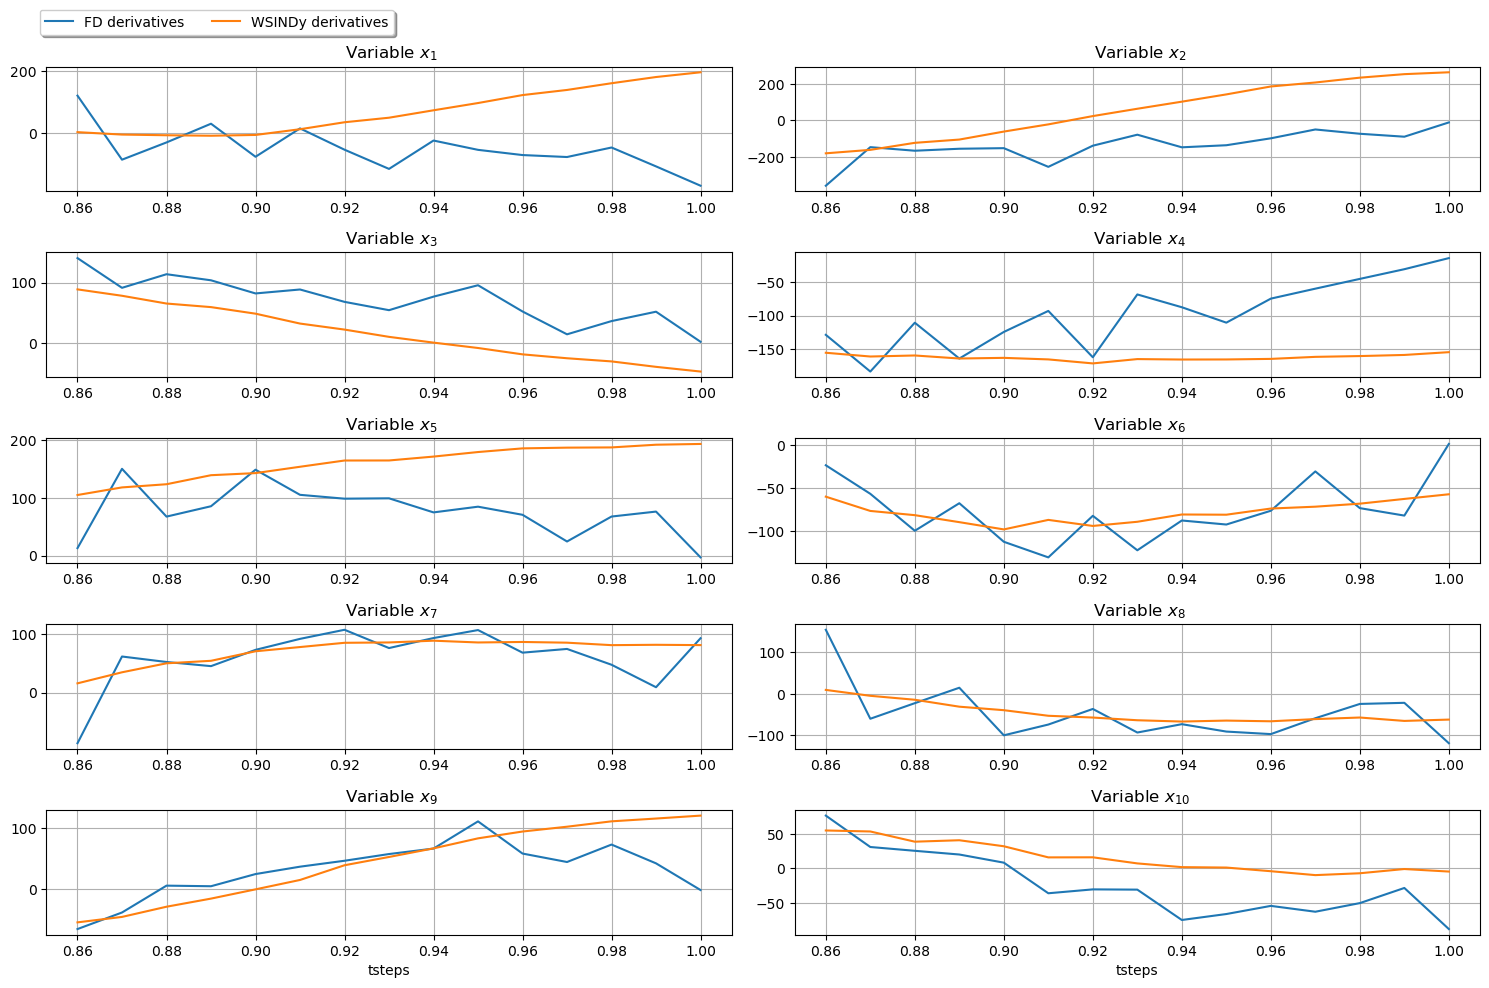

In [13]:
from simulai.math.differentiation import CollocationDerivative

diff_config={'step': time[1]-time[0]}
diff = CollocationDerivative(config=diff_config)
collocation_derivative = diff.solve(data=pdata_test)

swsindy_derivative = best_swsindy.eval(pdata_test)

fig, ax = plot_latent([
             (time_test, collocation_derivative),
             (time_test, swsindy_derivative),
             ], 
            [
             dict(label='FD derivatives'),
             dict(label='WSINDy derivatives'),
             ])

In [14]:
time_prediction = time
initial_state = pdata_train[0]
swsindy_prediction = best_swsindy.simulate(initial_state, time_prediction)


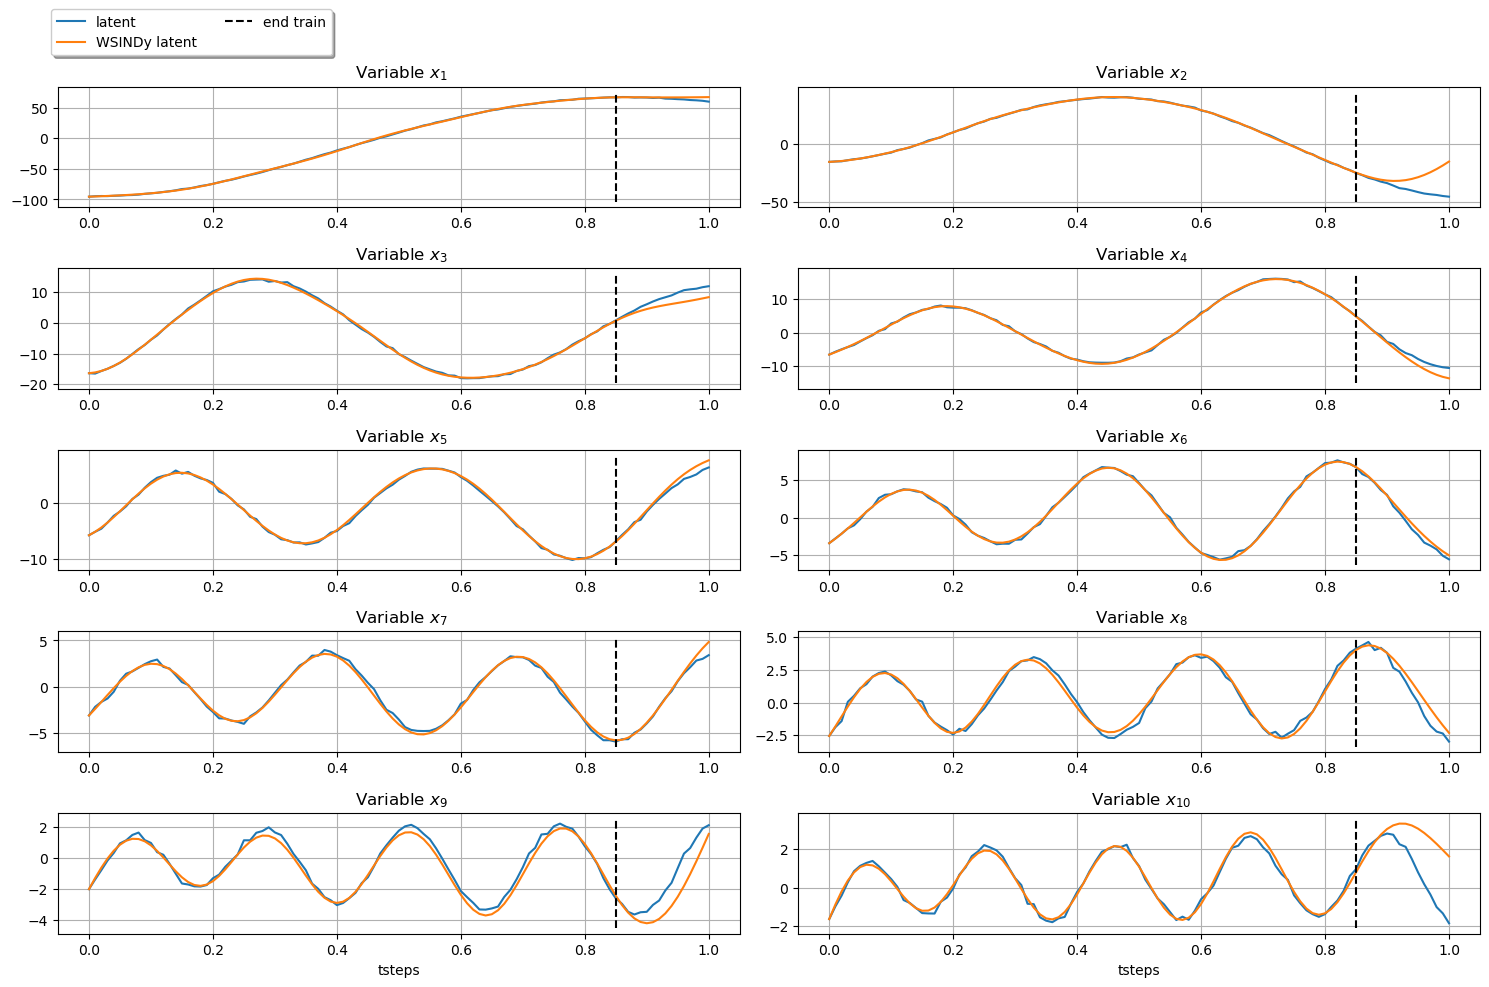

In [15]:
fig, ax = plot_latent(data = [ 
                                (time, pdata),
                                (time_prediction, swsindy_prediction),
                                ], 
                      data_kwargs=[ 
                                    dict(label='latent'),
                                    dict(label='WSINDy latent')
                                    ], 
                      vlines=[ time_train[-1] ],
                      vlines_kwargs = [ dict(label='end train', color='k', ls='--') ] )

# Reconstruction to original coordinates

In [16]:
from simulai.metrics import L2Norm, PointwiseError

perror = PointwiseError()

def perror_ndimensional(data=None, reference_data=None):
    original_shape = data.shape
    data_flattened = data.reshape((data.shape[0], -1))
    reference_data_flattened = reference_data.reshape((reference_data.shape[0], -1))    
    perror = PointwiseError()
    error = perror(data=data_flattened, reference_data=reference_data_flattened)
    error = abs(error)
    return error.reshape(original_shape)

swsindy_reconstructed = pipeline.reconstruct_data(data=swsindy_prediction)
swsindy_reconstructed = rescaler.apply_descaling(map_dict={'input': swsindy_reconstructed + data_mean})['input']
error = perror_ndimensional(data=swsindy_reconstructed, reference_data=data)

Applying the global reconstruction strategy.


In [17]:
datas = [gtdata, data, swsindy_reconstructed, error]
title = ['ground truth', 'noisy', 'Spectral WeakSINDy', 'relative error']

anim = anim_2D(
    # data is a list of data arrays to animate in (T, N, M) format
    data = datas,#, np.sum(PHI, axis=1) ], 
    # title is a list of titles for each data array
    title = title,#,  'ALL_SOURCES'],
    # force number os columns (leav it None to a single row plot)
    n_columns = 2,
    figsize=(8, 8),
    min_val = [0,0,0,0],
    max_val = [2,2,2,1.0],
)

In [18]:
HTML(anim.to_html5_video())